<a href="https://colab.research.google.com/github/libeiyang/2.5D-Resnet-Unet-for-fibula-segmentation/blob/main/unet_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment

dce surface distance volumne

In [ ]:
!pip install segmentation_models_pytorch
!pip install torch
!pip install nibabel
!pip install SimpleITK
!pip install pydicom
!pip install torchsummary

     |████████████████████████████████| 88 kB 4.7 MB/s 
     |████████████████████████████████| 58 kB 8.1 MB/s 
     |████████████████████████████████| 376 kB 43.8 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=8aeab43708cd82b9adb89450e50a7848d894a4fdc06b756dd3d5f92ec92f606c
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=4a73624a87b28ec98954cc6f69c77fc368682f3e7377e8521c602ed5f19cabd7
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
     |████████████████████████████████| 48.4 MB 1.1 MB/s 
     |████████████████████████████████| 2.0 MB 10.5 MB/s 


In [ ]:
import os

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import torch.nn as nn
from torch import optim
import time, cv2
from os.path import join
from datetime import datetime
from tqdm import tqdm
import imageio
import matplotlib.pyplot as plt
import torchsummary
import PIL.Image as Image
import os
from torchvision import transforms as transforms
#DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install SimpleITK

# Data check

In [ ]:
path = '/content/drive/MyDrive/ThesisProject/dataset/fibuladata01/test 0'
for i in [x for x in range(1,21) if x != 2]:
  files = os.listdir(path+str(i))   # 读入文件夹
  num_png = len(files)       # 统计文件夹中的文件个数
  print(num_png)             # 打印文件个数

983
734
670
790
786
794
799
810
951
803
767
761
999
1543
901
759
797
774
409


In [ ]:
path = '/content/drive/MyDrive/ThesisProject/dataset/fibuladata01/test 0'
for i in [x for x in range(1,21) if x != 2]:
  files = os.listdir(path+str(i)+' bmp')   # 读入文件夹
  num_png = len(files)       # 统计文件夹中的文件个数
  print(num_png)             # 打印文件个数

983
736
670
790
786
794
799
810
951
803
767
761
999
1543
901
759
797
774
409


In [ ]:
path = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/seg_npy/seg0'
for i in [x for x in range(1,21) if x != 2]:
  data_test = np.load(path+str(i)+'.npy')
  print(np.shape(data_test))

(983, 512, 512)
(734, 512, 512)
(670, 512, 512)
(790, 512, 512)
(786, 512, 512)
(794, 512, 512)
(799, 512, 512)
(810, 512, 512)
(951, 512, 512)
(803, 512, 512)
(767, 512, 512)
(761, 512, 512)
(999, 512, 512)
(1543, 512, 512)
(901, 512, 512)
(759, 512, 512)
(797, 512, 512)
(774, 512, 512)
(409, 512, 512)


In [ ]:
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_uint020.npz'
data = np.load(DATA_PATH)
images, gt = data['img'], data['seg']

In [ ]:
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz'
data = np.load(DATA_PATH)
images2, gt2 = data['img'], data['seg']

In [ ]:
size = gt.size
shape = np.shape(gt)
shape

(13824, 384, 384)

In [ ]:
size = gt.size
shape = np.shape(gt)
shape

(15830, 383, 383)

In [ ]:
max_images=np.max(images)
print("Max value of images is {}".format(max_images))

max_gts=np.max(gt[gt<255])
print("Max value of gts is {}".format(max_gts))

min_images=np.min(images)
print("Min value of images is {}".format(min_images))

min_gts=np.min(gt)
print("Min value of gts is {}".format(min_gts))

Max value of images is 255
Max value of gts is 0
Min value of images is 0
Min value of gts is 0


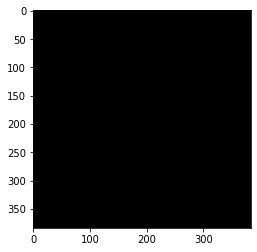

In [ ]:
plt.imshow((imgGt[0]*255).astype(np.uint8),cmap='gray')
plt.show() 

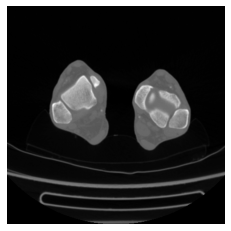

In [ ]:
plt.imshow(images[2480],cmap='gray')
plt.axis('off')
plt.show()

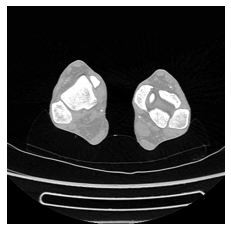

In [ ]:
plt.imshow(images2[2480-983],cmap='gray')
plt.axis('off')
plt.show()

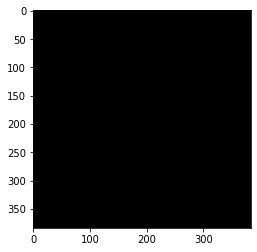

In [ ]:
plt.imshow(gt[2350],cmap='gray')
plt.show()

In [ ]:
import gc #（garbage collector）
images = images.astype(np.float16)/255.0
gt = seg_all.astype(np.float16)/255.0
imgGt = images*gt



In [ ]:
del images,gt,seg_all
gc.collect()

3195

In [ ]:
nonZero = imgGt[imgGt>0]

In [ ]:
mean = np.mean(nonZero)
std = np.var(nonZero.astype(np.float32))
print("Mean is {}".format(mean))
print("Std is {}".format(std))

Mean is 0.42724609375
Std is 0.01891089789569378


In [ ]:
nonZero

array([0.298 , 0.3098, 0.3137, ..., 0.3293, 0.3215, 0.3137], dtype=float16)

In [ ]:
# max = np.min(nonZero)

# max
pos = np.argwhere(imgGt>0.1)
pos


array([[  101,   198,   278],
       [  101,   198,   279],
       [  101,   198,   280],
       ...,
       [15784,   178,    67],
       [15784,   178,    68],
       [15784,   178,    69]])

In [ ]:
test = imgGt[0][0][355]
test

0.0

In [ ]:
max = np.max(nonZero)

max

# 我哭了，终于对了

0.9175

In [ ]:
max1 = np.max(images[2000][images[2000]>0])

max1

179

In [ ]:

np.savez('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_uint020.npz', img = images, seg = seg_all)   

In [ ]:
whos

Variable         Type        Data/Info
--------------------------------------
DATA_PATH        str         /content/drive/MyDrive/Th<...>pz/crop_axial_uint020.npz
DataLoader       type        <class 'torch.utils.data.dataloader.DataLoader'>
Dataset          type        <class 'torch.utils.data.dataset.Dataset'>
bmp_filepath     str         /content/drive/MyDrive/Th<...>fibuladata01/test 020 bmp
bmp_files        list        n=409
crop_img_axial   function    <function crop_img_axial at 0x7efbd8f92b00>
cv2              module      <module 'cv2.cv2' from '/<...>37m-x86_64-linux-gnu.so'>
data             NpzFile     <numpy.lib.npyio.NpzFile <...>object at 0x7efbd4095290>
datetime         type        <class 'datetime.datetime'>
drive            module      <module 'google.colab.dri<...>s/google/colab/drive.py'>
file             str         KLIMEK FRANZ MICHAEL_Axial+0612.0-000.bmp
gc               module      <module 'gc' (built-in)>
high_hsv         ndarray     3: 3 elems, type `int64`, 24

In [ ]:
path = '/content/drive/MyDrive/ThesisProject/dataset/fibuladata01/test 03'

In [ ]:
import os
for i in[x for x in range(1,21) if x!= 2]:
  bmp_filepath = '/content/drive/MyDrive/ThesisProject/dataset/fibuladata01/test 0'+str(i)+' bmp'
  bmp_files = os.listdir(bmp_filepath)
  bmp_files.sort()#求求了，下次一定记得排序，我吐了
  num_file = len(bmp_files)
  seg_data = np.zeros((0,512,512))
  for file in bmp_files:
    #traverse all files
    src=cv2.imread('/content/drive/MyDrive/ThesisProject/dataset/fibuladata01/test 0'+str(i)+' bmp/'+file)
    hsv = cv2.cvtColor(src, cv2.COLOR_BGR2HSV)
    low_hsv = np.array([10,10,0])
    high_hsv = np.array([360,255,255])
    mask = cv2.inRange(hsv,lowerb=low_hsv,upperb=high_hsv)
    seg_data = np.append(seg_data, mask)#先拼接成一个行
  seg_npy = seg_data.reshape(num_file,512,512).astype(np.uint8)#recombination
  np.save('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/seg_npy/seg0'+str(i)+'.npy',seg_npy)

In [ ]:
def crop_img_axial(img):#384*384,先竖再横
    startx = 128
    starty = 64
    endy = 512-64

    return img[:,-384:,starty:endy]

In [ ]:
import os
import numpy as np
img_path = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/img_npy/'
seg_path = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/seg_npy/'
seg_01_path = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/seg_npy/seg01.npy'
seg_all = np.load(seg_01_path)

for i in [x for x in range(3,21)]:
  seg_filepath = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/seg_npy/seg0'+str(i)+'.npy'
  seg_one = np.load(seg_filepath).astype(np.uint8)
  seg_all = np.append(seg_all,seg_one,axis=0)

seg_all = crop_img_axial(seg_all)

In [ ]:
np.savez('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_uint020.npz', img = images, seg = seg_all)   

In [ ]:
seg_020_path = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/seg_npy/seg020.npy'
seg_020 = np.load(seg_020_path)

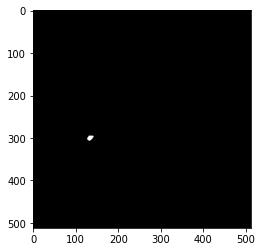

In [ ]:
plt.imshow(seg_020[363],cmap='gray')
plt.show()

In [ ]:
bmp_filepath = '/content/drive/MyDrive/ThesisProject/dataset/fibuladata01/test 018 bmp'
bmp_files = os.listdir(bmp_filepath)
bmp_files.sort()
for file in bmp_files:
  print(file)

VAN DAMME RONY REMI_Axial+0000.0-000.bmp
VAN DAMME RONY REMI_Axial+0000.7-000.bmp
VAN DAMME RONY REMI_Axial+0001.4-000.bmp
VAN DAMME RONY REMI_Axial+0002.1-000.bmp
VAN DAMME RONY REMI_Axial+0002.8-000.bmp
VAN DAMME RONY REMI_Axial+0003.5-000.bmp
VAN DAMME RONY REMI_Axial+0004.2-000.bmp
VAN DAMME RONY REMI_Axial+0004.9-000.bmp
VAN DAMME RONY REMI_Axial+0005.6-000.bmp
VAN DAMME RONY REMI_Axial+0006.3-000.bmp
VAN DAMME RONY REMI_Axial+0007.0-000.bmp
VAN DAMME RONY REMI_Axial+0007.7-000.bmp
VAN DAMME RONY REMI_Axial+0008.4-000.bmp
VAN DAMME RONY REMI_Axial+0009.1-000.bmp
VAN DAMME RONY REMI_Axial+0009.8-000.bmp
VAN DAMME RONY REMI_Axial+0010.5-000.bmp
VAN DAMME RONY REMI_Axial+0011.2-000.bmp
VAN DAMME RONY REMI_Axial+0011.9-000.bmp
VAN DAMME RONY REMI_Axial+0012.6-000.bmp
VAN DAMME RONY REMI_Axial+0013.3-000.bmp
VAN DAMME RONY REMI_Axial+0014.0-000.bmp
VAN DAMME RONY REMI_Axial+0014.7-000.bmp
VAN DAMME RONY REMI_Axial+0015.4-000.bmp
VAN DAMME RONY REMI_Axial+0016.1-000.bmp
VAN DAMME RONY R

# Data for sagittal and coronal

In [ ]:
#sliding window function
import cv2

def sliding_window(image, windowSize = 384):
  shape = image.shape[0]
  if(shape <= 384):
    # 这个地方要加小于400的时候的padding
    temp = np.zeros([0,384,384])
    temp = np.append(temp,image[0:384])
    return temp
  elif(shape>384 and shape<=384*2):
    temp = np.zeros([0,384,384])
    temp = np.append(temp,image[0:384])
    temp = np.append(temp,image[-384:])
    return temp
  elif(shape>384*2 and shape<=384*3):
    temp = np.zeros([0,384,384])
    temp = np.append(temp,image[0:384])
    temp = np.append(temp,image[int(shape/2)-192:int(shape/2)+192])
    temp = np.append(temp,image[-384:])
    return temp
  elif(shape>384*3 and shape<=384*4):
    temp = np.zeros([0,384,384])
    temp = np.append(temp,image[0:384])
    temp = np.append(temp,image[384:384*2])
    temp = np.append(temp,image[int(shape/2)-192:int(shape/2)+192])
    temp = np.append(temp,image[384*2:384*3])
    temp = np.append(temp,image[-384:])
    return temp
  elif(shape>384*4):
    print("The shape of image is out of 384*4!")



In [ ]:
# axial_z = [983,734,670,790,786,794,799,810,951,803,767,761,999,1543,901,759,797,774,409]
axial_z = [983,734,670,790,786,794,799]
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_uint020.npz'
data = np.load(DATA_PATH)
images = data['img']
start = 0
imgSlideForSave = np.zeros([0,384,384])
for i in axial_z:
  numForLabel = 0
  img = images[start:start+i]
  #grdth = gt[start:start+i]
  start = start+i
  for j in range(0,384):
    imgSlideForSave = np.append(imgSlideForSave,sliding_window(img[:,:,j]))
  print(int(imgSlideForSave.shape[0]/(384*384)))

  

1152
1920
2688
3840
4992
6144
7296


In [ ]:
high = int(imgSlideForSave.shape[0]/(384*384))
img_sagittal_1to7 = imgSlideForSave.reshape(high,384,384)
img_sagittal_1to7 = img_sagittal_1to7.astype(np.uint8)
np.save('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/sagittal/img_sagittal_1to7.npy',img_sagittal_1to7)

In [ ]:
# axial_z = [983,734,670,790,786,794,799,810,951,803,767,761,999,1543,901,759,797,774,409]
axial_z = [983,734,670,790,786,794,799]
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_uint020.npz'
data = np.load(DATA_PATH)
gts = data['seg']
start = 0
gtSlideForSave = np.zeros([0,384,384])
gtSlideForSave = gtSlideForSave.astype(np.uint8)
for i in axial_z:
  numForLabel = 0
  gt = gts[start:start+i]
  #grdth = gt[start:start+i]
  start = start+i
  for j in range(0,384):
    gtSlideForSave = np.append(gtSlideForSave,sliding_window(gt[:,:,j]))
  print(int(gtSlideForSave.shape[0]/(384*384)))

1152
1920
2688
3840
4992
6144
7296


In [ ]:
high = int(gtSlideForSave.shape[0]/(384*384))
gt_sagittal_1to7 = gtSlideForSave.reshape(high,384,384)
gt_sagittal_1to7 = gt_sagittal_1to7.astype(np.uint8)
np.save('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/sagittal/gt_sagittal_1to7.npy',gt_sagittal_1to7)

In [ ]:
np.savez('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to7.npz', img = img_sagittal_1to7, seg = gt_sagittal_1to7) 

In [ ]:
img_sagittal_1to7 = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/sagittal/img_sagittal_1to7.npy')

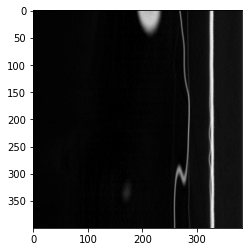

In [ ]:
plt.imshow(slideForSave[2],cmap='gray')
plt.show()

In [ ]:
whos

Variable         Type        Data/Info
--------------------------------------
DATA_PATH        str         /content/drive/MyDrive/Th<...>pz/crop_axial_uint020.npz
DataLoader       type        <class 'torch.utils.data.dataloader.DataLoader'>
Dataset          type        <class 'torch.utils.data.dataset.Dataset'>
axial_z          list        n=7
cv2              module      <module 'cv2.cv2' from '/<...>37m-x86_64-linux-gnu.so'>
data             NpzFile     <numpy.lib.npyio.NpzFile <...>object at 0x7fe08c7b7a10>
datetime         type        <class 'datetime.datetime'>
drive            module      <module 'google.colab.dri<...>s/google/colab/drive.py'>
gt               ndarray     799x384x384: 117817344 elems, type `uint8`, 117817344 bytes (112.359375 Mb)
gtSlideForSave   ndarray     1075838976: 1075838976 elems, type `float64`, 8606711808 bytes (8208.0 Mb)
gts              ndarray     15830x384x384: 2334228480 elems, type `uint8`, 2334228480 bytes (2226.09375 Mb)
i                int    

# Data of both end for sagittal

In [ ]:
#sliding window function
import cv2

def sliding_window_twoEnd(image, windowSize = 384):
  shape = image.shape[0]
  if(shape <= 384):
    
    temp = np.zeros([0,384,384])
    temp.astype(np.float32)
    temp = np.append(temp,image[0:384])
    return temp
  elif(shape>384):
    temp = np.zeros([0,384,384])
    temp.astype(np.float32)
    temp = np.append(temp,image[0:384])
    temp = np.append(temp,image[-384:])
    temp = temp.astype(np.float32)
    return temp

In [ ]:
# axial_z = [983,734,670,790,786,794,799,810,951,803,767,761,999,1543,901,759,797,774,409]
axial_z = [983,734,670,790,786,794,799,810,951,803,767,761,999,1543,901,759,797,774,409]
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz'
data = np.load(DATA_PATH)
images = data['img']


In [ ]:
del imgSlideForSave
gc.collect()

267

In [ ]:
axial_z = [983,734,670,790,786,794,799,810,951,803,767,761,999,1543,901,759,797,774,409]
numofz = 0
for i in axial_z:
  if(i == 1543):
    continue 
  numofz = numofz+1
imgSlideForSave = np.zeros([numofz*384*2,384,384], dtype=np.float32)
start = 0
saveNum = 0
for i in axial_z:
  if(i == 1543):
    start = start+i
    continue  
  numForLabel = 0
  img = images[start:start+i]
  #grdth = gt[start:start+i]
  start = start+i
  temp = np.zeros([384*2,384,384], dtype=np.float32)
  ntemp=0
  for j in range(0,384):
    temp[ntemp] = img[:,:,j][0:384]
    ntemp = ntemp+1
    temp[ntemp] = img[:,:,j][-384:]
    ntemp = ntemp+1

    
    #imgSlideForSave = np.append(imgSlideForSave,temp)
  imgSlideForSave[saveNum:(saveNum+384*2)] = temp
  saveNum = saveNum+384*2
  print(saveNum)
  #print("Min value of gts is {}".format(min_gts))
  print("start value is {}".format(start))

768
start value is 983
1536
start value is 1717
2304
start value is 2387
3072
start value is 3177
3840
start value is 3963
4608
start value is 4757
5376
start value is 5556
6144
start value is 6366
6912
start value is 7317
7680
start value is 8120
8448
start value is 8887
9216
start value is 9648
9984
start value is 10647
10752
start value is 13091
11520
start value is 13850
12288
start value is 14647
13056
start value is 15421
13824
start value is 15830


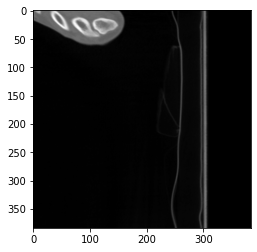

In [ ]:
plt.imshow(imgSlideForSave[20],cmap='gray')
plt.show() 

In [ ]:
 img = images[0:983]
 #testimg = img[:,:,50][0:384]
 testimg = img[50]

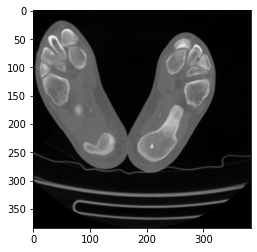

In [ ]:
plt.imshow(testimg,cmap='gray')
plt.show() 

In [ ]:
whos

In [ ]:

np.save('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/sagittal/img_sagittal_conv_1to20.npy',imgSlideForSave)

then for gt part

In [ ]:
# axial_z = [983,734,670,790,786,794,799,810,951,803,767,761,999,1543,901,759,797,774,409]
axial_z = [983,734,670,790,786,794,799,810,951,803,767,761,999,1543,901,759,797,774,409]
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz'
data = np.load(DATA_PATH)
images = data['seg']


In [ ]:
axial_z = [983,734,670,790,786,794,799,810,951,803,767,761,999,1543,901,759,797,774,409]
numofz = 0
for i in axial_z:
  if(i == 1543):
    continue 
  numofz = numofz+1
imgSlideForSave = np.zeros([numofz*384*2,384,384], dtype=np.uint8)
start = 0
saveNum = 0
for i in axial_z:
  if(i == 1543):
    start = start+i
    continue  
  numForLabel = 0
  img = images[start:start+i]
  #grdth = gt[start:start+i]
  start = start+i
  temp = np.zeros([384*2,384,384], dtype=np.uint8)
  ntemp=0
  for j in range(0,384):
    temp[ntemp] = img[:,:,j][0:384]
    ntemp = ntemp+1
    temp[ntemp] = img[:,:,j][-384:]
    ntemp = ntemp+1

    
    #imgSlideForSave = np.append(imgSlideForSave,temp)
  imgSlideForSave[saveNum:(saveNum+384*2)] = temp
  saveNum = saveNum+384*2
  print(saveNum)
  #print("Min value of gts is {}".format(min_gts))
  print("start value is {}".format(start))

768
start value is 983
1536
start value is 1717
2304
start value is 2387
3072
start value is 3177
3840
start value is 3963
4608
start value is 4757
5376
start value is 5556
6144
start value is 6366
6912
start value is 7317
7680
start value is 8120
8448
start value is 8887
9216
start value is 9648
9984
start value is 10647
10752
start value is 13091
11520
start value is 13850
12288
start value is 14647
13056
start value is 15421
13824
start value is 15830


In [ ]:

np.save('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/sagittal/gt_sagittal_1to20.npy',imgSlideForSave)

In [ ]:
img_sagittal_1to20 = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/sagittal/img_sagittal_conv_1to20.npy')

In [ ]:
np.savez('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz', img = img_sagittal_1to20, seg = imgSlideForSave) 

In [ ]:
whos

Variable       Type        Data/Info
------------------------------------
DataLoader     type        <class 'torch.utils.data.dataloader.DataLoader'>
Dataset        type        <class 'torch.utils.data.dataset.Dataset'>
Image          module      <module 'PIL.Image' from <...>t-packages/PIL/Image.py'>
adjust         ndarray     768x384x384: 113246208 elems, type `uint8`, 113246208 bytes (108.0 Mb)
cv2            module      <module 'cv2.cv2' from '/<...>37m-x86_64-linux-gnu.so'>
datetime       type        <class 'datetime.datetime'>
drive          module      <module 'google.colab.dri<...>s/google/colab/drive.py'>
imageio        module      <module 'imageio' from '/<...>ges/imageio/__init__.py'>
img            ndarray     13824x384x384: 2038431744 elems, type `float32`, 8153726976 bytes (7776.0 Mb)
join           function    <function join at 0x7f7c6ee31950>
nn             module      <module 'torch.nn' from '<...>es/torch/nn/__init__.py'>
np             module      <module 'numpy' fro

In [ ]:
img = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz')['img']

In [ ]:
adjust = img[:768,:,:]
temp = np.zeros([13824,384,384], dtype = np.uint8)
temp[-768:,:,:] = adjust
temp[:13056,:,:] = img[-13056:,:,:]

In [ ]:
seg = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz')['seg']

In [ ]:
adjust = seg[:768,:,:]
temp2 = np.zeros([13824,384,384], dtype = np.uint8)
temp2[-768:,:,:] = adjust
temp2[:13056,:,:] = seg[-13056:,:,:]

In [ ]:
np.savez('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz', img = temp, seg = temp2) 

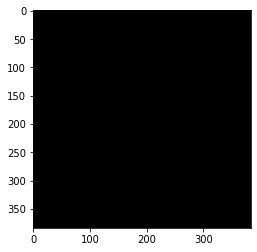

In [ ]:
plt.imshow((temp2[300]),cmap='gray')
plt.show() 

In [ ]:
max = np.max(temp2)
max

255

# Data Augmentation for sagittal and coronal

In [ ]:
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz'
img = np.load(DATA_PATH)['img']
seg = np.load(DATA_PATH)['seg']

num = 0
for i in range(seg.shape[0]):
  max = np.max(seg[i])
  if max == 255:
    num = num+1

print(num)

temp = np.zeros([num,384,384], dtype = np.uint8)



3460


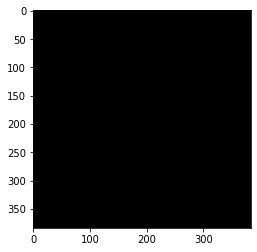

In [ ]:
plt.imshow(seg[601],cmap='gray')
plt.show() 

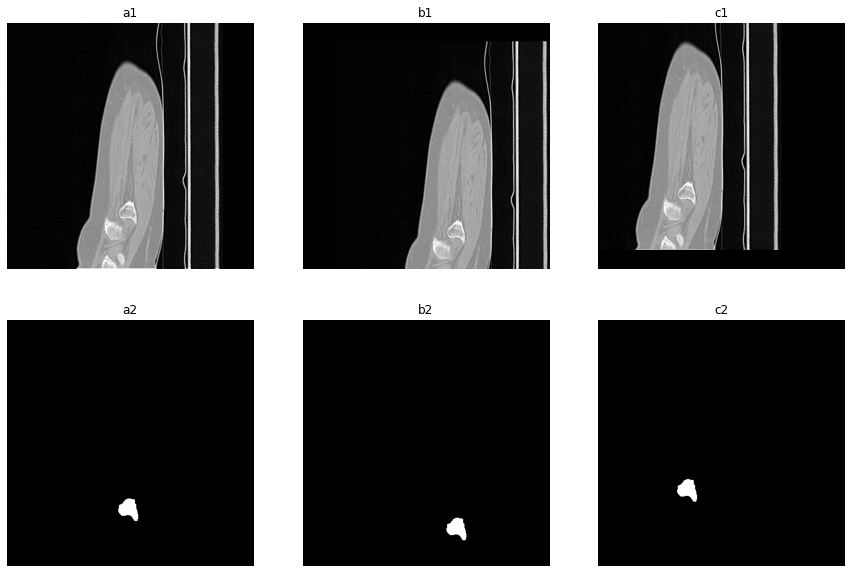

In [ ]:
snum = 849
test = img[snum]
h = 384
w = 384
mat_shift = np.float32([[1,0,50], [0,1,30]])
img_1 = cv2.warpAffine(test, mat_shift, (h, w))
mat_shift = np.float32([[1, 0, -50], [0, 1, -30]])
img_2 = cv2.warpAffine(test, mat_shift, (h, w))

test_seg = seg[snum]
h = 384
w = 384
mat_shift = np.float32([[1,0,50], [0,1,30]])
seg_1 = cv2.warpAffine(test_seg, mat_shift, (h, w))
mat_shift = np.float32([[1, 0, -50], [0, 1, -30]])
seg_2 = cv2.warpAffine(test_seg, mat_shift, (h, w))

## 显示
plt.figure(figsize=(15, 10))
plt.subplot(2,3,1), plt.imshow(test,cmap='gray')
plt.axis('off'); plt.title('a1')
plt.subplot(2,3,2), plt.imshow(img_1,cmap='gray')
plt.axis('off'); plt.title('b1')
plt.subplot(2,3,3), plt.imshow(img_2,cmap='gray')
plt.axis('off'); plt.title('c1')
plt.subplot(2,3,4), plt.imshow(test_seg,cmap='gray')
plt.axis('off'); plt.title('a2')
plt.subplot(2,3,5), plt.imshow(seg_1,cmap='gray')
plt.axis('off'); plt.title('b2')
plt.subplot(2,3,6), plt.imshow(seg_2,cmap='gray')
plt.axis('off'); plt.title('c2')
plt.show()

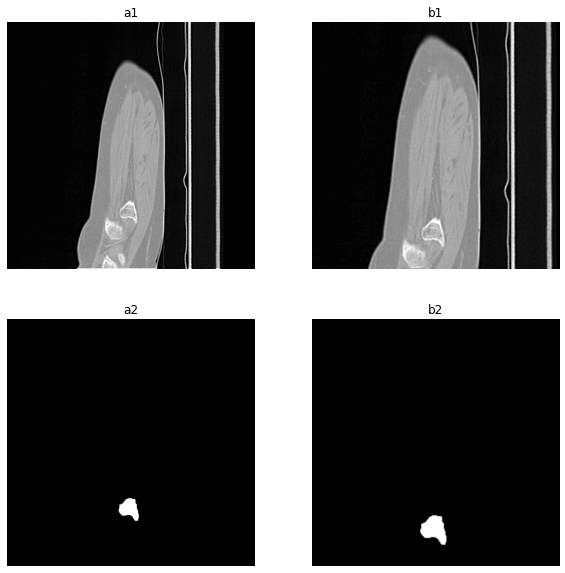

In [ ]:
h = 384
w = 384

# snum = 7503
# snum = 200
test = img[snum]

img_2 = cv2.resize(test, (int(h * 1.3), int(w * 1.3)))
h = h*1.3
w = w*1.3
img_2 = img_2[int((h - 384) / 2) : int((h + 384) / 2), int((w - 384) / 2) : int((w + 384) /2)]

h = 384
w = 384
test_seg = seg[snum]
seg_2 = cv2.resize(test_seg, (int(h * 1.3), int(w * 1.3)))
h = h*1.3
w = w*1.3
seg_2 = seg_2[int((h - 384) / 2) : int((h + 384) / 2), int((w - 384) / 2) : int((w + 384) /2)]

## 显示
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1), plt.imshow(test,cmap='gray')
plt.axis('off'); plt.title('a1')
plt.subplot(2,2,2), plt.imshow(img_2,cmap='gray')
plt.axis('off'); plt.title('b1')

plt.subplot(2,2,3), plt.imshow(test_seg,cmap='gray')
plt.axis('off'); plt.title('a2')
plt.subplot(2,2,4), plt.imshow(seg_2,cmap='gray')
plt.axis('off'); plt.title('b2')

plt.show()

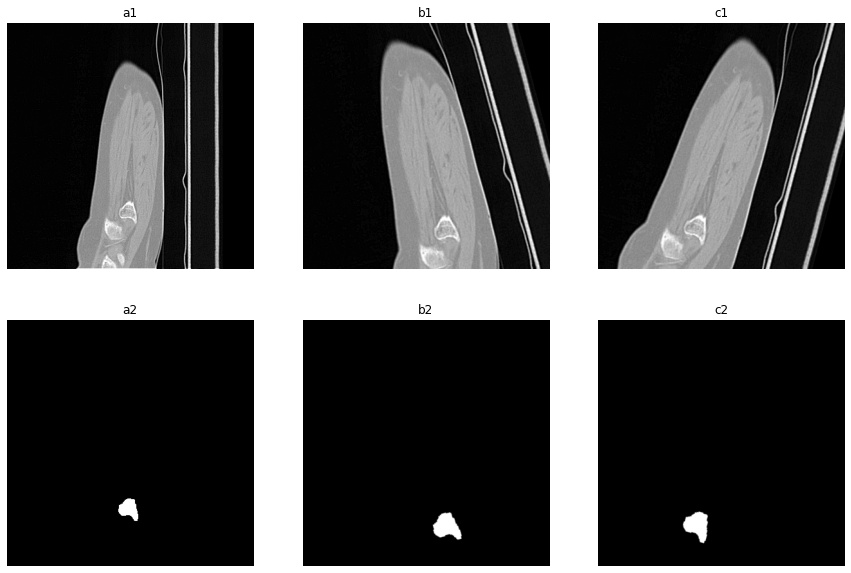

In [ ]:
#45度旋转

# snum = 7503
#snum = 200

cols = 384
rows = 384
test = img[snum]
M = cv2.getRotationMatrix2D((cols/2, rows/2), 15, 1.3)
img_1 = cv2.warpAffine(test, M,(cols, rows))

M = cv2.getRotationMatrix2D((cols/2, rows/2), 345, 1.3)
img_2 = cv2.warpAffine(test, M,(cols, rows))


test_seg = seg[snum]
M = cv2.getRotationMatrix2D((cols/2, rows/2), 15, 1.3)
seg_1 = cv2.warpAffine(test_seg, M,(cols, rows))

M = cv2.getRotationMatrix2D((cols/2, rows/2), 345, 1.3)
seg_2 = cv2.warpAffine(test_seg, M,(cols, rows))


## 显示
plt.figure(figsize=(15, 10))
plt.subplot(2,3,1), plt.imshow(test,cmap='gray')
plt.axis('off'); plt.title('a1')
plt.subplot(2,3,2), plt.imshow(img_1,cmap='gray')
plt.axis('off'); plt.title('b1')
plt.subplot(2,3,3), plt.imshow(img_2,cmap='gray')
plt.axis('off'); plt.title('c1')

plt.subplot(2,3,4), plt.imshow(test_seg,cmap='gray')
plt.axis('off'); plt.title('a2')
plt.subplot(2,3,5), plt.imshow(seg_1,cmap='gray')
plt.axis('off'); plt.title('b2')
plt.subplot(2,3,6), plt.imshow(seg_2,cmap='gray')
plt.axis('off'); plt.title('c2')

plt.show()

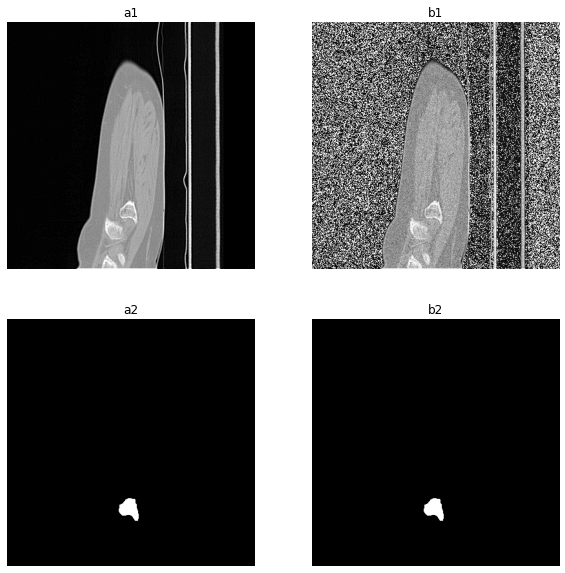

In [ ]:

def gasuss_noise(image, mean=0.2, var=0.005):
  ''' 
    添加高斯噪声
    mean : 均值 
    var : 方差
  '''
  image = np.array(image/255, dtype=float)
  noise = np.random.normal(mean, var ** 0.5, image.shape)
  out = image + noise
  if out.min() < 0:
    low_clip = -1.
  else:
    low_clip = 0.
  out = np.clip(out, low_clip, 1.0)
  out = np.uint8(out*255)
  return out

cols = 384
rows = 384
# snum = 7503
#snum = 200
test = img[snum]
img_s1 = gasuss_noise(test, 0, 0.005) 
img_s2 = gasuss_noise(test, 0, 0.05) 

test_seg = seg[snum]

plt.figure(figsize=(10, 10))
plt.subplot(2,2,1), plt.imshow(test,cmap='gray')
plt.axis('off'); plt.title('a1')
plt.subplot(2,2,2), plt.imshow(img_s1,cmap='gray')
plt.axis('off'); plt.title('b1')
# plt.subplot(1,3,3), plt.imshow(img_s2,cmap='gray')
# plt.axis('off'); plt.title('方差为0.05')

plt.subplot(2,2,3), plt.imshow(test_seg,cmap='gray')
plt.axis('off'); plt.title('a2')
plt.subplot(2,2,4), plt.imshow(test_seg,cmap='gray')
plt.axis('off'); plt.title('b2')

plt.show()

# DA data for sagittal

In [ ]:
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz'
img = np.load(DATA_PATH)['img'][2304:13824]
seg = np.load(DATA_PATH)['seg'][2304:13824]

num = 0
for i in range(seg.shape[0]):
  max = np.max(seg[i])
  if max == 255:
    num = num+1

print(num)


2830


In [ ]:
def gasuss_noise(image, mean=0.2, var=0.005):
  ''' 
    添加高斯噪声
    mean : 均值 
    var : 方差
  '''
  image = np.array(image/255, dtype=float)
  noise = np.random.normal(mean, var ** 0.5, image.shape)
  out = image + noise
  if out.min() < 0:
    low_clip = -1.
  else:
    low_clip = 0.
  out = np.clip(out, low_clip, 1.0)
  out = np.uint8(out*255)
  return out

def DAonce(img, seg):

  temp_img = np.zeros([5,384,384], dtype = np.uint8)
  temp_seg = np.zeros([5,384,384], dtype = np.uint8)

  test = img
  h = 384
  w = 384
  mat_shift = np.float32([[1,0,50], [0,1,30]])
  img_1 = cv2.warpAffine(test, mat_shift, (h, w))

  test_seg = seg
  h = 384
  w = 384
  mat_shift = np.float32([[1,0,50], [0,1,30]])
  seg_1 = cv2.warpAffine(test_seg, mat_shift, (h, w))


  temp_img[0] = img_1

  temp_seg[0] = seg_1


  cols = 384
  rows = 384
  test = img
  M = cv2.getRotationMatrix2D((cols/2, rows/2), 15, 1.3)
  img_1 = cv2.warpAffine(test, M,(cols, rows))

  M = cv2.getRotationMatrix2D((cols/2, rows/2), 345, 1.3)
  img_2 = cv2.warpAffine(test, M,(cols, rows))


  test_seg = seg
  M = cv2.getRotationMatrix2D((cols/2, rows/2), 15, 1.3)
  seg_1 = cv2.warpAffine(test_seg, M,(cols, rows))

  M = cv2.getRotationMatrix2D((cols/2, rows/2), 345, 1.3)
  seg_2 = cv2.warpAffine(test_seg, M,(cols, rows))

  temp_img[1] = img_1
  temp_img[2] = img_2
  temp_seg[1] = seg_1
  temp_seg[2] = seg_2


  cols = 384
  rows = 384

  test = img
  img_1 = gasuss_noise(test, 0, 0.005) 
  temp_img[3] = img_1
  temp_seg[3] = seg

  temp_img[4] = img
  temp_seg[4] = seg

  return temp_img, temp_seg

In [ ]:
temp_img = np.zeros([num*5,384,384], dtype = np.uint8)
temp_seg = np.zeros([num*5,384,384], dtype = np.uint8)
tempNum = 0
for i in range(seg.shape[0]):
  max = np.max(seg[i])
  if max == 255:
    temp_img[tempNum:tempNum+5], temp_seg[tempNum:tempNum+5]= DAonce(img[i],seg[i])
    tempNum = tempNum + 5


In [ ]:

np.savez('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/DA_crop_sagittal_conv1to20.npz', img = temp_img, seg = temp_seg)

In [ ]:
whos

Variable       Type        Data/Info
------------------------------------
DATA_PATH      str         /content/drive/MyDrive/Th<...>op_sagittal_uint1to20.npz
DAonce         function    <function DAonce at 0x7fd373d503b0>
DataLoader     type        <class 'torch.utils.data.dataloader.DataLoader'>
Dataset        type        <class 'torch.utils.data.dataset.Dataset'>
Image          module      <module 'PIL.Image' from <...>t-packages/PIL/Image.py'>
cv2            module      <module 'cv2.cv2' from '/<...>37m-x86_64-linux-gnu.so'>
datetime       type        <class 'datetime.datetime'>
drive          module      <module 'google.colab.dri<...>s/google/colab/drive.py'>
gasuss_noise   function    <function gasuss_noise at 0x7fd373d50320>
i              int         11519
imageio        module      <module 'imageio' from '/<...>ges/imageio/__init__.py'>
img            ndarray     11520x384x384: 1698693120 elems, type `uint8`, 1698693120 bytes (1620.0 Mb)
join           function    <function join 

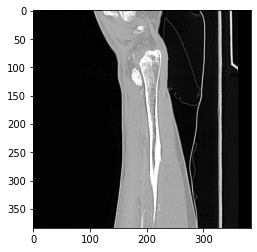

In [ ]:
plt.imshow(temp_img[2044],cmap='gray')
plt.show()

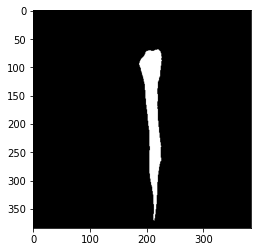

In [ ]:
plt.imshow(temp_seg[2044],cmap='gray')
plt.show()

# DA data for Axial

In [ ]:
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz'
img = np.load(DATA_PATH)['img'][2194:15830]
seg = np.load(DATA_PATH)['seg'][2194:15830]

In [ ]:
axial_z = [786,794,799,810,951,803,767,761,999,1543,901,759,797,774,409,983]
num = 0
index = -1
up = []
for n in axial_z:
  for i in range(n):
    max = np.max(seg[index+i])
    if max == 255:
      up.append(index+i)
      index = index+n
      break
up


[28,
 877,
 1648,
 2446,
 3301,
 4248,
 5106,
 5872,
 6658,
 7734,
 9228,
 10047,
 10804,
 11632,
 12321,
 12772]

In [ ]:
down = []
index = -1
for n in axial_z:
  for i in reversed(range(n)):
    max = np.max(seg[index+i])
    if max == 255:
      down.append(index+i)
      index = index+n
      break
down

[667,
 1476,
 2227,
 3091,
 3958,
 4801,
 5584,
 6345,
 7247,
 8636,
 9813,
 10581,
 11349,
 12094,
 12594,
 13422]

In [ ]:
newLength = (80+55)*16

In [ ]:
def gasuss_noise(image, mean=0.2, var=0.005):
  ''' 
    添加高斯噪声
    mean : 均值 
    var : 方差
  '''
  image = np.array(image/255, dtype=float)
  noise = np.random.normal(mean, var ** 0.5, image.shape)
  out = image + noise
  if out.min() < 0:
    low_clip = -1.
  else:
    low_clip = 0.
  out = np.clip(out, low_clip, 1.0)
  out = np.uint8(out*255)
  return out

def DAonce(img, seg):

  temp_img = np.zeros([5,384,384], dtype = np.uint8)
  temp_seg = np.zeros([5,384,384], dtype = np.uint8)

  test = img
  h = 384
  w = 384
  mat_shift = np.float32([[1,0,50], [0,1,30]])
  img_1 = cv2.warpAffine(test, mat_shift, (h, w))

  test_seg = seg
  h = 384
  w = 384
  mat_shift = np.float32([[1,0,50], [0,1,30]])
  seg_1 = cv2.warpAffine(test_seg, mat_shift, (h, w))


  temp_img[0] = img_1

  temp_seg[0] = seg_1


  cols = 384
  rows = 384
  test = img
  M = cv2.getRotationMatrix2D((cols/2, rows/2), 15, 1.3)
  img_1 = cv2.warpAffine(test, M,(cols, rows))

  M = cv2.getRotationMatrix2D((cols/2, rows/2), 345, 1.3)
  img_2 = cv2.warpAffine(test, M,(cols, rows))


  test_seg = seg
  M = cv2.getRotationMatrix2D((cols/2, rows/2), 15, 1.3)
  seg_1 = cv2.warpAffine(test_seg, M,(cols, rows))

  M = cv2.getRotationMatrix2D((cols/2, rows/2), 345, 1.3)
  seg_2 = cv2.warpAffine(test_seg, M,(cols, rows))

  temp_img[1] = img_1
  temp_img[2] = img_2
  temp_seg[1] = seg_1
  temp_seg[2] = seg_2


  cols = 384
  rows = 384

  test = img
  img_1 = gasuss_noise(test, 0, 0.005) 
  temp_img[3] = img_1
  temp_seg[3] = seg

  temp_img[4] = img
  temp_seg[4] = seg

  return temp_img, temp_seg

In [ ]:
temp_img = np.zeros([newLength*5,384,384], dtype = np.uint8)
temp_seg = np.zeros([newLength*5,384,384], dtype = np.uint8)
tempNum = 0
#up
#down
for i in up:
  for n in range(80):
    temp_img[tempNum:tempNum+5], temp_seg[tempNum:tempNum+5]= DAonce(img[i+n],seg[i+n])
    tempNum = tempNum + 5

for i in down:
  for n in range(55):
    temp_img[tempNum:tempNum+5], temp_seg[tempNum:tempNum+5]= DAonce(img[i-n],seg[i-n])
    tempNum = tempNum + 5


In [ ]:

np.savez('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/DA_crop_axial_conv1to20.npz', img = temp_img, seg = temp_seg)

In [ ]:
whos

Variable                Type        Data/Info
---------------------------------------------
DATA_PATH               str         /content/drive/MyDrive/Th<...>pz/crop_axial_conv020.npz
DAonce                  function    <function DAonce at 0x7efaecc21440>
DataLoader              type        <class 'torch.utils.data.dataloader.DataLoader'>
Dataset                 type        <class 'torch.utils.data.dataset.Dataset'>
Image                   module      <module 'PIL.Image' from <...>t-packages/PIL/Image.py'>
axial_z                 list        n=16
cv2                     module      <module 'cv2.cv2' from '/<...>37m-x86_64-linux-gnu.so'>
datetime                type        <class 'datetime.datetime'>
down                    list        n=16
drive                   module      <module 'google.colab.dri<...>s/google/colab/drive.py'>
gasuss_noise            function    <function gasuss_noise at 0x7efaecc217a0>
i                       int         13422
imageio                 module      <m

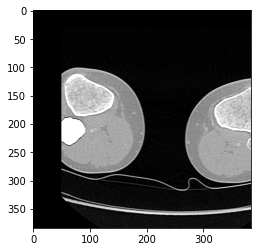

In [ ]:
plt.imshow(temp_img[10],cmap='gray')
plt.show()

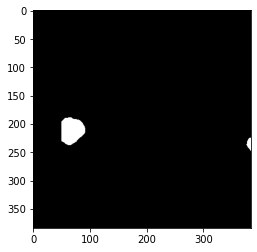

In [ ]:
plt.imshow(temp_seg[10700],cmap='gray')
plt.show()


# DA + original data sagittal

In [ ]:
imgDA= np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/DA_crop_sagittal_conv1to20.npz')['img']
segDA= np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/DA_crop_sagittal_conv1to20.npz')['seg']

In [ ]:
whos

In [ ]:
img = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz')['img'][2304:13824]
seg = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz')['seg'][2304:13824]

In [ ]:
num = imgDA.shape[0] + img.shape[0]
temp_img = np.zeros([num,384,384], dtype = np.uint8)
temp_seg = np.zeros([num,384,384], dtype = np.uint8)

In [ ]:
temp_img[0:14150] = imgDA
temp_seg[0:14150] = segDA
temp_img[14150:25670] = img
temp_seg[14150:25670] = seg

In [ ]:
per = np.random.permutation(temp_img.shape[0])		#打乱后的行号
temp_img = temp_img[per, :, :]		#获取打乱后的训练数据
temp_seg = temp_seg[per,:,:]

In [ ]:
np.savez('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/final1_crop_sagittal_conv1to20.npz', img = temp_img[0:12835], seg = temp_seg[0:12835])
np.savez('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/final2_crop_sagittal_conv1to20.npz', img = temp_img[12835:25670], seg = temp_seg[12835:25670])

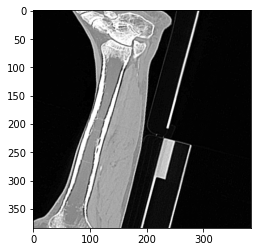

In [ ]:
plt.imshow(temp_img[102],cmap='gray')
plt.show()

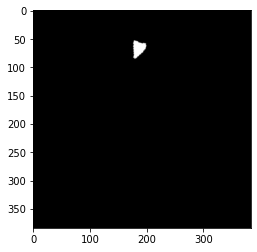

In [ ]:
plt.imshow(temp_seg[102],cmap='gray')
plt.show()


# DA + original data axial

In [ ]:
imgDA= np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/DA_crop_axial_conv1to20.npz')['img']
segDA= np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/DA_crop_axial_conv1to20.npz')['seg']

In [ ]:
whos

In [ ]:
img = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['img'][2194:15830]
seg = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['seg'][2194:15830]

In [ ]:
num = imgDA.shape[0] + img.shape[0]
temp_img = np.zeros([num,384,384], dtype = np.uint8)
temp_seg = np.zeros([num,384,384], dtype = np.uint8)
num

24436

In [ ]:
temp_img[0:10800] = imgDA
temp_seg[0:10800] = segDA
temp_img[10800:24436] = img
temp_seg[10800:24436] = seg

In [ ]:
per = np.random.permutation(temp_img.shape[0])		#打乱后的行号
temp_img = temp_img[per, :, :]		#获取打乱后的训练数据
temp_seg = temp_seg[per,:,:]

In [ ]:
np.savez('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/final1_crop_axial_conv1to20.npz', img = temp_img[0:12200], seg = temp_seg[0:12200])
np.savez('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/final2_crop_axial_conv1to20.npz', img = temp_img[12200:24436], seg = temp_seg[12200:24436])

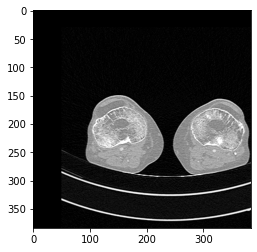

In [ ]:
plt.imshow(temp_img[10200],cmap='gray')
plt.show()

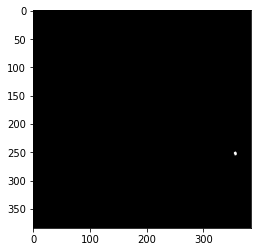

In [ ]:
plt.imshow(temp_seg[10200],cmap='gray')
plt.show()

# Data of both end for coronal

In [ ]:
#sliding window function
import cv2

def sliding_window_twoEnd(image, windowSize = 384):
  shape = image.shape[0]
  if(shape <= 384):
    # 这个地方要加小于400的时候的padding
    temp = np.zeros([0,384,384])
    temp.astype(np.float32)
    temp = np.append(temp,image[0:384])
    return temp
  elif(shape>384):
    temp = np.zeros([0,384,384])
    temp.astype(np.float32)
    temp = np.append(temp,image[0:384])
    temp = np.append(temp,image[-384:])
    temp = temp.astype(np.float32)
    return temp

In [ ]:
# axial_z = [983,734,670,790,786,794,799,810,951,803,767,761,999,1543,901,759,797,774,409]
axial_z = [983,734,670,790,786,794,799,810,951,803,767,761,999,1543,901,759,797,774,409]
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz'
data = np.load(DATA_PATH)
images = data['img']


In [ ]:
axial_z = [983,734,670,790,786,794,799,810,951,803,767,761,999,1543,901,759,797,774,409]
numofz = 0
for i in axial_z:
  if(i == 1543):
    continue 
  numofz = numofz+1
imgSlideForSave = np.zeros([numofz*384*2,384,384], dtype=np.float32)
start = 0
saveNum = 0
for i in axial_z:
  if(i == 1543):
    start = start+i
    continue  
  numForLabel = 0
  img = images[start:start+i]
  #grdth = gt[start:start+i]
  start = start+i
  temp = np.zeros([384*2,384,384], dtype=np.float32)
  ntemp=0
  for j in range(0,384):
    temp[ntemp] = img[:,j,:][0:384]
    ntemp = ntemp+1
    temp[ntemp] = img[:,j,:][-384:]
    ntemp = ntemp+1

    
    #imgSlideForSave = np.append(imgSlideForSave,temp)
  imgSlideForSave[saveNum:(saveNum+384*2)] = temp
  saveNum = saveNum+384*2
  print(saveNum)
  #print("Min value of gts is {}".format(min_gts))
  print("start value is {}".format(start))

768
start value is 983
1536
start value is 1717
2304
start value is 2387
3072
start value is 3177
3840
start value is 3963
4608
start value is 4757
5376
start value is 5556
6144
start value is 6366
6912
start value is 7317
7680
start value is 8120
8448
start value is 8887
9216
start value is 9648
9984
start value is 10647
10752
start value is 13091
11520
start value is 13850
12288
start value is 14647
13056
start value is 15421
13824
start value is 15830


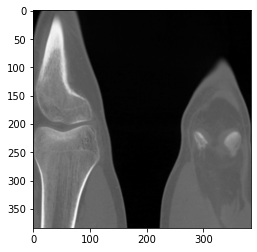

In [ ]:
img = images[0:983]
 #testimg = img[:,:,50][0:384]
 #[-384:]
testimg = img[:,100,:][-384:]
plt.imshow(testimg,cmap='gray')
plt.show() 

In [ ]:

np.save('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/coronal/img_coronal_conv_1to20.npy',imgSlideForSave)

In [ ]:
del images
gc.collect()

343

In [ ]:
whos

then for gt part

In [ ]:
# axial_z = [983,734,670,790,786,794,799,810,951,803,767,761,999,1543,901,759,797,774,409]
axial_z = [983,734,670,790,786,794,799,810,951,803,767,761,999,1543,901,759,797,774,409]
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz'
data = np.load(DATA_PATH)
images = data['seg']


In [ ]:
axial_z = [983,734,670,790,786,794,799,810,951,803,767,761,999,1543,901,759,797,774,409]
numofz = 0
for i in axial_z:
  if(i == 1543):
    continue 
  numofz = numofz+1
imgSlideForSave = np.zeros([numofz*384*2,384,384], dtype=np.uint8)
start = 0
saveNum = 0
for i in axial_z:
  if(i == 1543):
    start = start+i
    continue  
  numForLabel = 0
  img = images[start:start+i]
  #grdth = gt[start:start+i]
  start = start+i
  temp = np.zeros([384*2,384,384], dtype=np.uint8)
  ntemp=0
  for j in range(0,384):
    temp[ntemp] = img[:,j,:][0:384]
    ntemp = ntemp+1
    temp[ntemp] = img[:,j,:][-384:]
    ntemp = ntemp+1

    
    #imgSlideForSave = np.append(imgSlideForSave,temp)
  imgSlideForSave[saveNum:(saveNum+384*2)] = temp
  saveNum = saveNum+384*2
  print(saveNum)
  #print("Min value of gts is {}".format(min_gts))
  print("start value is {}".format(start))

768
start value is 983
1536
start value is 1717
2304
start value is 2387
3072
start value is 3177
3840
start value is 3963
4608
start value is 4757
5376
start value is 5556
6144
start value is 6366
6912
start value is 7317
7680
start value is 8120
8448
start value is 8887
9216
start value is 9648
9984
start value is 10647
10752
start value is 13091
11520
start value is 13850
12288
start value is 14647
13056
start value is 15421
13824
start value is 15830


In [ ]:

np.save('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/coronal/gt_coronal_1to20.npy',imgSlideForSave)

In [ ]:
img_coronal_1to20 = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/coronal/img_coronal_conv_1to20.npy')

In [ ]:
np.savez('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz', img = img_coronal_1to20, seg = imgSlideForSave) 

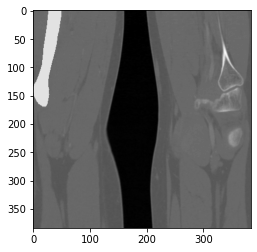

In [ ]:

testimg = img_coronal_1to20[401]
plt.imshow(testimg,cmap='gray')
plt.show() 

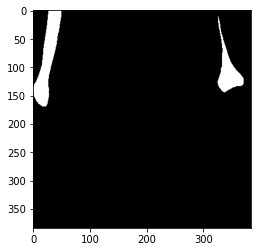

In [ ]:
testimg = imgSlideForSave[401]
plt.imshow(testimg,cmap='gray')
plt.show() 

In [ ]:
del img_coronal_1to20,imgSlideForSave
gc.collect()

5597

In [ ]:
whos

Variable          Type        Data/Info
---------------------------------------
DATA_PATH         str         /content/drive/MyDrive/Th<...>op_sagittal_uint1to20.npz
DataLoader        type        <class 'torch.utils.data.dataloader.DataLoader'>
Dataset           type        <class 'torch.utils.data.dataset.Dataset'>
DiceLoss          type        <class '__main__.DiceLoss'>
DiceLoss2         type        <class '__main__.DiceLoss2'>
DiceLoss3         type        <class '__main__.DiceLoss3'>
F                 module      <module 'torch.nn.functio<...>/torch/nn/functional.py'>
Image             module      <module 'PIL.Image' from <...>t-packages/PIL/Image.py'>
MyDataset         type        <class '__main__.MyDataset'>
SAVE_MODEL_PATH   str         /content/drive/MyDrive/Th<...>roject/processed/sagittal
SAVE_PATH         str         /content/drive/MyDrive/Th<...>processed/test50_sagittal
compute_loss      function    <function compute_loss at 0x7f37d8183a70>
cv2               module      <

In [ ]:
img = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz')['img']

In [ ]:
adjust = img[:768,:,:]
temp = np.zeros([13824,384,384], dtype = np.uint8)
temp[-768:,:,:] = adjust
temp[:13056,:,:] = img[-13056:,:,:]

In [ ]:
seg = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz')['seg']

In [ ]:
adjust = seg[:768,:,:]
temp2 = np.zeros([13824,384,384], dtype = np.uint8)
temp2[-768:,:,:] = adjust
temp2[:13056,:,:] = seg[-13056:,:,:]

In [ ]:
np.savez('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz', img = temp, seg = temp2) 

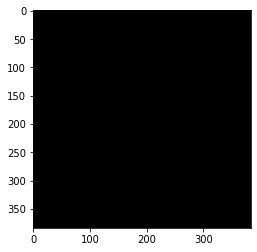

In [ ]:
plt.imshow((temp2[300]),cmap='gray')
plt.show() 

# Data of upgrade dataset

In [ ]:
axial_z = [983,734,670,790,786,794,799,810,951,803,767,761,999,1543,901,759,797,774,409]

DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/full_axial_uint_reg020.npz'
data = np.load(DATA_PATH)
images, gt = data['img'], data['seg']

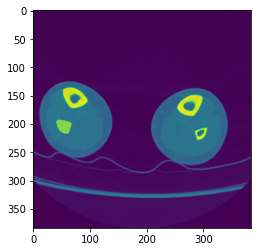

In [ ]:
from matplotlib.pyplot import imshow
im = images[400]
pil_image=Image.fromarray(im)
imshow(np.asarray(pil_image))

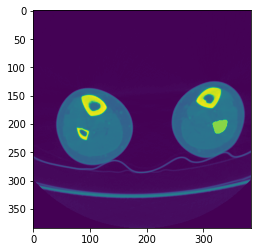

In [ ]:
new_im = transforms.RandomHorizontalFlip(p=1)(pil_image)   # p表示概率

imshow(np.asarray(new_im))

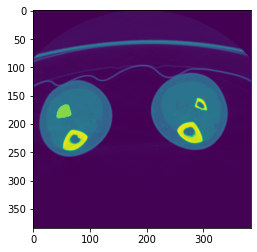

In [ ]:
new_im = transforms.RandomVerticalFlip(p=1)(pil_image)   # p表示概率

imshow(np.asarray(new_im))

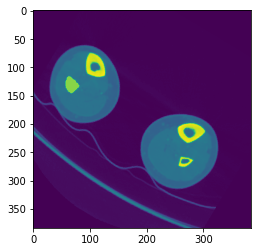

In [ ]:
new_im = transforms.RandomRotation(45)(pil_image)
imshow(np.asarray(new_im))

In [ ]:
whos

Variable       Type        Data/Info
------------------------------------
DATA_PATH      str         /content/drive/MyDrive/Th<...>ull_axial_uint_reg020.npz
DataLoader     type        <class 'torch.utils.data.dataloader.DataLoader'>
Dataset        type        <class 'torch.utils.data.dataset.Dataset'>
Image          module      <module 'PIL.Image' from <...>t-packages/PIL/Image.py'>
axial_z        list        n=19
cv2            module      <module 'cv2.cv2' from '/<...>37m-x86_64-linux-gnu.so'>
data           NpzFile     <numpy.lib.npyio.NpzFile <...>object at 0x7f12057bc790>
datetime       type        <class 'datetime.datetime'>
drive          module      <module 'google.colab.dri<...>s/google/colab/drive.py'>
gt             ndarray     15830x384x384: 2334228480 elems, type `uint8`, 2334228480 bytes (2226.09375 Mb)
im             ndarray     384x384: 147456 elems, type `float32`, 589824 bytes (576.0 kb)
imageio        module      <module 'imageio' from '/<...>ges/imageio/__init__.py'

# Function check

In [ ]:
# input, gt = batch
#             #print(input.shape)
#             input = input.to(device)
#             gt = gt.to(device)
#             input = input.unsqueeze(1)
#             #print(input.shape)
#             gt = gt.unsqueeze(1)
#             masks = model(input)
#             #print(masks.shape)
#             #print(gt.shape)

#             # compute loss
#             loss = compute_loss(masks, gt)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()
device = 'cuda:0'
input = torch.from_numpy(gt[15000].astype(np.float32)/255.0)
input2 = torch.from_numpy(gt[15000].astype(np.float32)/255.0)
input = input.to(device)
input = input.unsqueeze(1)
input2 = input2.to(device)
input2 = input2.unsqueeze(1)
loss = compute_loss(input,input2)
print(loss.item())
# print(intersection)
# print(inputs.sum())
# print(targets.sum())

tensor(455., device='cuda:0')
tensor(455., device='cuda:0')
tensor(455., device='cuda:0')
0.0


# Dataloader

In [ ]:
import os

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import torch.nn as nn
from torch import optim
import time, cv2
from os.path import join
from datetime import datetime
from tqdm import tqdm
import imageio

import torch.nn.functional as F
import gc #（garbage collector）

DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz'
# DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/final2_crop_axial_conv1to20.npz'
EVAL_DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz'
SAVE_PATH = '/content/drive/MyDrive/ThesisProject/processed/test34'
SAVE_MODEL_PATH = '/content/drive/MyDrive/ThesisProject/processed/34'
# axial_z = [734,670,790,786,794,799,810,951,803,767,761,999,1543,901,759,797,774,409,983]


class MyDataset(Dataset):
    def __init__(self, images, gts, start=0, end=13849, batch_size=32):
        "images shape: (D, W, H)"
        data = images[start:end]
        #d, w, h = data.shape
        #data = data.reshape(n*d, w, h)
        
        #data = data.astype(np.float32)/255.0
        self.images = data.astype(np.float32)/255.0
        self.length = len(self.images)
        del data
        
        #self.images = (data-0.42725)/0.01891

        gtdata = gts[start:end]
        #gtdata = gtdata.reshape(n*d, w, h)
        self.gt = gtdata.astype(np.float32)/255.0
        del gtdata
        gc.collect()
        print("we can delete data of dataset for saving RAM")
        self.batch_size = batch_size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.gt[idx]

    def get_loader(self, shuffle=True):
        return DataLoader(self, batch_size=self.batch_size,
                          shuffle=shuffle)


def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.epsilon = 1e-5

    def forward(self, predict, target,bce_weight = 0.5):
        assert predict.size() == target.size(), "the size of predict and target must be equal."
        # num = predict.size(0)

        # pre = torch.sigmoid(predict).view(num, -1)
        # tar = target.view(num, -1)

        # intersection = (pre * tar).sum(-1).sum()
        # union = (pre + tar).sum(-1).sum()

        # score = 1 - 2 * (intersection + self.epsilon) / (union + self.epsilon)
        bce = F.binary_cross_entropy_with_logits(predict, target)
        pred = torch.sigmoid(predict)
        dice = dice_loss(pred, target)
        score = bce * bce_weight + dice * (1 - bce_weight)
        return score

class DiceLoss2(nn.Module):
    def __init__(self):
        super(DiceLoss2, self).__init__()
        self.epsilon = 1e-5

    def forward(self, predict, target,bce_weight = 0.5):
      assert predict.size() == target.size(), "the size of predict and target must be equal."
      dice = dice_loss(pred,target)
      return dice
      
class DiceLoss3(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss3, self).__init__()
    
    def forward(self, inputs, targets, smooth=1e-5):
        #
        #inputs = torch.sigmoid(inputs)
        #flatten
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        #element_wise production to get intersection score
        intersection = (inputs*targets).sum()
        # for debug
        # print(intersection)
        # print(inputs.sum())
        # print(targets.sum())
        dice_score = (2*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice_score



def get_timestamp():
    now = datetime.now()
    time_str = now.isoformat()
    time_str = time_str.replace(':', '-')
    return time_str

def compute_loss(pred, gt):
    # print(pred.shape, gt.shape)
    # criterion = nn.BCEWithLogitsLoss()
    # loss = criterion(pred, gt)
    func = DiceLoss3()
    loss = func(pred, gt)

    return loss

# def calc_loss(pred, target, metrics, bce_weight=0.5):
#     bce = F.binary_cross_entropy_with_logits(pred, target)

#     pred = torch.sigmoid(pred)
#     dice = dice_loss(pred, target)

#     loss = bce * bce_weight + dice * (1 - bce_weight)

#     metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
#     metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
#     metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

#     return loss


def test_dataloader():
    data = np.load(DATA_PATH)
    images, gt = data['img'], data['seg']
    dataset = MyDataset(images, gt, batch_size=1)
    loader = dataset.get_loader(shuffle=True)

    out = 'images'
    writer = imageio.get_writer('train.mp4', format='FFMPEG', mode='I', fps=1,
                       codec='h264_vaapi')
    for i, batch in enumerate(loader):
        images, gt = batch
        gt_masks = gt.cpu().numpy()
        pred_masks = images.cpu().numpy()
        img = np.concatenate([gt_masks[0] * 255, pred_masks[0] * 255])
        path = join(out, 'train_{}.jpg'.format(i))
        writer.append_data(img.astype(np.uint8))

        # cv2.imwrite(path, img)
        #
        # print(images.shape, gt.shape)
    writer.close()

def load_npz(path):
    data = np.load(path)
    images, gt = data['img'], data['seg']
    return images, gt

def dice(im1, im2):    
  smooth=1e-5  
  intersection = np.logical_and(im1, im2)      
  return (2. * (intersection.sum())+smooth) / (np.sum(im1>0) + np.sum(im2>0)+smooth)

def deNoise(pred):
  length = pred.shape[0]
  temp = np.zeros([length,384,384], dtype = np.uint8)
  flag = 1
  start = length//2
  while(flag):
    max = np.max(pred[start])
    start = start - 1
    if max == 0 or start < 0:
      flag = 0
  begin = start

  flag = 1
  start = length//2
  while(flag):
    max = np.max(pred[start])
    start = start + 1
    if max == 0 or start == length:
      flag = 0
  end = start
  temp[begin:end-1,:,:] = pred[begin:end-1,:,:]
  return temp



def result_analysis(pred, gt):

  avg_dice = 0
  n = 0
  for i in range(pred.shape[0]):

    data1 = pred[i,:,:]
    data2 = gt[i,:,:]
    
    loss = dice(data1,data2)

    avg_dice = avg_dice + loss
    n=n+1
  
  avg_dice = avg_dice/n
  return avg_dice

def train(epochs, save_path,save_model_path):
    os.makedirs(save_path, exist_ok=True)
    # prepare data
    #images, annotations = load_npz(DATA_PATH)
    images, segs = load_npz(DATA_PATH)
    print("we can get npz")
    train_data = MyDataset(images, segs, start=2194, end = -1, batch_size=32)
    train_loader = train_data.get_loader()
    print("we can get train_data loader")
    del train_data,images, segs
    gc.collect()
    print("we can delete train data for saving RAM")
    # 734,1404,2194
    images, segs = load_npz(EVAL_DATA_PATH)
    eval_data = MyDataset(images,segs,start=1404, end = 2194)
    test_data = MyDataset(images, segs, start=0, end=734)
    del images, segs
    gc.collect()
    eval_loader = eval_data.get_loader(shuffle = False)
    test_loader = test_data.get_loader(shuffle=False)
    print("we can get test_data loader")
    del test_data, eval_data
    gc.collect()
    print("we can delete test data for saving RAM")
    train_Loss_list = []
    valid1_Loss_list = []
    valid2_Loss_list = []
 
    #aux_params=dict(pooling='max',dropout=0.5,classes=1,)

    # prepare model
    model = smp.Unet(
        encoder_name="resnet34",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_depth=5,
        encoder_weights= None,  # use `imagenet` pre-trained weights for encoder initialization
        decoder_channels = (256, 128, 64, 32, 16),
        in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,  # model output channels (number of classes in your dataset)
        activation='sigmoid',#relu
        #aux_params=aux_params
    )

    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    device = 'cuda:0'
    model.to(device)
    best_loss = 100
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0
        for batch in train_loader:
            input, gt = batch
            #print(input.shape)
            input = input.to(device)
            gt = gt.to(device)
            input = input.unsqueeze(1)
            #print(input.shape)
            gt = gt.unsqueeze(1)
            masks = model(input)
            #print(masks.shape)
            #print(gt.shape)

            # compute loss
            loss = compute_loss(masks, gt)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            #print("mask max:{} loss:{}, step: {}".format(torch.max(masks), loss, epoch))
        train_loss /= len(train_loader)
        # print("train loss:{}, step: {}".format(train_loss, epoch))

        model.eval()
        numForSave=0
        avg_dice = 0
        temp_n = len(eval_loader.dataset)
        #print("length of test scans is {}".format(temp_n))
        temp = np.zeros([temp_n,384,384], dtype = np.uint8)
        temp2 = np.zeros([temp_n,384,384], dtype = np.uint8)
        with torch.no_grad():
            # compute eval loss              
          for j, eval_batch in enumerate(eval_loader):
            eval_input, eval_gt = eval_batch
            eval_input = eval_input.to(device)
            eval_gt = eval_gt.to(device)
            eval_input = eval_input.unsqueeze(1)
            
            eval_gt = eval_gt.unsqueeze(1)
            outputs = model(eval_input)
            outputs = outputs.squeeze(1)
            outputs[outputs >= 0.5] = 1
            outputs[outputs < 0.5] = 0
            outputs_mask = outputs.cpu().numpy()
            eval_gt_mask = eval_gt.cpu().numpy()
            
            for j in range(outputs.shape[0]):
              temp[numForSave] = outputs_mask[j]
              temp2[numForSave] = eval_gt_mask[j]
              numForSave=numForSave+1
              loss = dice(eval_gt_mask[j],outputs_mask[j])
              #print("No.{}:  {}".format(numForSave,loss))
              avg_dice = avg_dice + loss


        vol_loss = dice(temp,temp2)
        avg_loss = avg_dice/numForSave

        train_Loss_list.append(train_loss)
        valid1_Loss_list.append(avg_loss)
        valid2_Loss_list.append(vol_loss)

        print("train loss:{}, valid loss1:{}, valid loss2:{}, step: {}".format(train_loss, avg_loss, vol_loss, epoch))
            # save model
        path = join(save_model_path, 'unet-{}-step-{}.tar'.format(get_timestamp(),epoch))
        torch.save(model.state_dict(), path)
            # if loss < best_loss:
            
    train_Loss_list=np.array(train_Loss_list)
    valid1_Loss_list=np.array(valid1_Loss_list)
    valid2_Loss_list=np.array(valid2_Loss_list)

    np.save(SAVE_MODEL_PATH+'/f_train_Loss_list.npy',train_Loss_list)
    np.save(SAVE_MODEL_PATH+'/f_valid1_Loss_list.npy',valid1_Loss_list)
    np.save(SAVE_MODEL_PATH+'/f_valid2_Loss_list.npy',valid2_Loss_list)



    # evaluate test
    numForSave=0
    avg_dice = 0
    model.eval()
    temp_n = len(test_loader.dataset)
    print("length of test scans is {}".format(temp_n))
    temp = np.zeros([temp_n,384,384], dtype = np.uint8)
    temp2 = np.zeros([temp_n,384,384], dtype = np.uint8)
    for i, batch in enumerate(test_loader):
        input, gt = batch
        input = input.to(device)
        input = input.unsqueeze(1)
        pred = model(input)
        # print(pred.shape)
        pred = pred.squeeze(1)
        pred[pred >= 0.5] = 1
        pred[pred < 0.5] = 0
        gt_masks = gt.cpu().numpy()
        pred_masks = pred.cpu().numpy()
       

        for j in range(pred.shape[0]):
            temp[numForSave] = pred_masks[j]
            temp2[numForSave] = gt_masks[j]
            numForSave=numForSave+1
            loss = dice(gt_masks[j],pred_masks[j])
            print("No.{}:  {}".format(numForSave,loss))
            avg_dice = avg_dice + loss
    
    np.save(SAVE_PATH+'/pred3D_1.npy', temp)
    vol_dice = dice(temp,temp2)
    avg_dice = avg_dice/numForSave
    print("average dice is {}".format(avg_dice))  
    print("vol dice is {}".format(vol_dice))  



def evaluate(checkpoint, save_path, train=False):
    ck = torch.load(checkpoint)
    # prepare model
    # prepare model
    model = smp.Unet(
        encoder_name="resnet34",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_depth=5,
        encoder_weights=None,  # use `imagenet` pre-trained weights for encoder initialization
        decoder_channels = (256, 128, 64, 32, 16),
        in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,  # model output channels (number of classes in your dataset)
        activation='sigmoid',#relu
        #aux_params=aux_params
    )
    model.load_state_dict(ck)
    model.eval()

    # prepare data
    images, annotations = load_npz(EVAL_DATA_PATH)
    
    # test_data = MyDataset(images, annotations, start=14646, end=15420)
    test_data = MyDataset(images, annotations, start=0, end=734)
    # test_data = MyDataset(images, annotations, start=734, end=1404)
    test_loader = test_data.get_loader(shuffle=False)
    del test_data
    gc.collect()
    device = 'cuda:0'
    model.to(device)
    loader = test_loader
    info = 'test      '

    # evaluate
    numForSave=0
    avg_dice = 0

    temp_n = len(loader.dataset)
    print("length of test scans is {}".format(temp_n))
    # temp = np.zeros([temp_n,384,384], dtype = np.uint8)
    # temp2 = np.zeros([temp_n,384,384], dtype = np.uint8)
    temp = np.zeros([temp_n,384,384], dtype = np.float)
    temp2 = np.zeros([temp_n,384,384], dtype = np.float)
    with torch.no_grad():
      for i, batch in enumerate(loader):
        input, gt = batch
        input = input.to(device)
        input = input.unsqueeze(1)
        pred = model(input)
        # print(pred.shape)
        pred = pred.squeeze(1)
        pred[pred >= 0.5] = 1
        pred[pred < 0.5] = 0
        gt_masks = gt.cpu().numpy()
        pred_masks = pred.cpu().numpy()
       

        for j in range(pred.shape[0]):
            temp[numForSave] = pred_masks[j]
            temp2[numForSave] = gt_masks[j]
            numForSave=numForSave+1
            loss = dice(gt_masks[j],pred_masks[j])
            print("No.{}:  {}".format(numForSave,loss))
            avg_dice = avg_dice + loss
    
    np.save(SAVE_PATH+'/f_pred3D_1.npy', temp)
    vol_dice = dice(temp,temp2)
    avg_dice = avg_dice/numForSave
    print("average dice is {}".format(avg_dice))  
    print("vol dice is {}".format(vol_dice))

    temp = deNoise(temp)
    avg_dice2 = result_analysis(temp,temp2)
    vol_dice2 = dice(temp,temp2)
    np.save(SAVE_PATH+'/f_NoisePred3D_1.npy', temp)
    print("After denoise, average dice is {}".format(avg_dice2))  
    print("After denoise, vol dice is {}".format(vol_dice2))
      
      

def continue_train(epochs, checkpoint, data_path, save_path,save_model_path):
  os.makedirs(save_path, exist_ok=True)
  images, segs = load_npz(data_path)
  print("we can get npz")
  train_data = MyDataset(images, segs, start=0, end =-1, batch_size=32)
  del images,segs
  gc.collect()
  train_loader = train_data.get_loader()
  print("we can get train_data loader")
  del train_data
  gc.collect()
  print("we can delete train data for saving RAM")
  images_eval, segs_eval = load_npz(EVAL_DATA_PATH)
  eval_data = MyDataset(images_eval,segs_eval,start=1404, end = 2194)
  test_data = MyDataset(images_eval, segs_eval, start=0, end=734)
  del images_eval, segs_eval
  gc.collect()
  eval_loader = eval_data.get_loader(shuffle = False)
  test_loader = test_data.get_loader(shuffle=False)
  print("we can get test_data loader")
  del test_data, eval_data
  gc.collect()
  print("we can delete test data for saving RAM")
  train_Loss_list = []
  valid1_Loss_list = []
  valid2_Loss_list = []
  ck = torch.load(checkpoint)
      

  model = smp.Unet(
        encoder_name="resnet50",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_depth=5,
        encoder_weights=None,  # use `imagenet` pre-trained weights for encoder initialization
        decoder_channels = (256, 128, 64, 32, 16),
        in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,  # model output channels (number of classes in your dataset)
        activation='sigmoid'#relu
    )
  model.load_state_dict(ck)
  optimizer = optim.Adam(model.parameters(), lr=1e-4)

  device = 'cuda:0'
  model.to(device)
  best_loss = 100
  for epoch in tqdm(range(epochs)):
      model.train()
      train_loss = 0
      for batch in train_loader:
          input, gt = batch
          #print(input.shape)
          input = input.to(device)
          gt = gt.to(device)
          input = input.unsqueeze(1)
          #print(input.shape)
          gt = gt.unsqueeze(1)
          masks = model(input)
          #print(masks.shape)
          #print(gt.shape)

          # compute loss
          loss = compute_loss(masks, gt)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
          #print("mask max:{} loss:{}, step: {}".format(torch.max(masks), loss, epoch))
      train_loss /= len(train_loader)
      # print("train loss:{}, step: {}".format(train_loss, epoch))

      model.eval()
      numForSave=0
      avg_dice = 0
      temp_n = len(eval_loader.dataset)
      #print("length of test scans is {}".format(temp_n))
      temp = np.zeros([temp_n,384,384], dtype = np.uint8)
      temp2 = np.zeros([temp_n,384,384], dtype = np.uint8)
      with torch.no_grad():
          # compute eval loss              
        for j, eval_batch in enumerate(eval_loader):
          eval_input, eval_gt = eval_batch
          eval_input = eval_input.to(device)
          eval_gt = eval_gt.to(device)
          eval_input = eval_input.unsqueeze(1)
          
          eval_gt = eval_gt.unsqueeze(1)
          outputs = model(eval_input)
          outputs = outputs.squeeze(1)
          outputs[outputs >= 0.5] = 1
          outputs[outputs < 0.5] = 0
          outputs_mask = outputs.cpu().numpy()
          eval_gt_mask = eval_gt.cpu().numpy()
          
          for j in range(outputs.shape[0]):
            temp[numForSave] = outputs_mask[j]
            temp2[numForSave] = eval_gt_mask[j]
            numForSave=numForSave+1
            loss = dice(eval_gt_mask[j],outputs_mask[j])
            #print("No.{}:  {}".format(numForSave,loss))
            avg_dice = avg_dice + loss


      vol_loss = dice(temp,temp2)
      avg_loss = avg_dice/numForSave

      train_Loss_list.append(train_loss)
      valid1_Loss_list.append(avg_loss)
      valid2_Loss_list.append(vol_loss)
      
      

      print("train loss:{}, valid loss1:{}, valid loss2:{}, step: {}".format(train_loss, avg_loss, vol_loss, epoch))
          # save model
      path = join(save_model_path, 'unet-{}-step-{}.tar'.format(get_timestamp(),epoch))
      torch.save(model.state_dict(), path)
          # if loss < best_loss:

  train_Loss_list=np.array(train_Loss_list)
  valid1_Loss_list=np.array(valid1_Loss_list)
  valid2_Loss_list=np.array(valid2_Loss_list)

  np.save(SAVE_MODEL_PATH+'/f2_train_Loss_list.npy',train_Loss_list)
  np.save(SAVE_MODEL_PATH+'/f2_valid1_Loss_list.npy',valid1_Loss_list)
  np.save(SAVE_MODEL_PATH+'/f2_valid2_Loss_list.npy',valid2_Loss_list)


In [ ]:
train(35, SAVE_PATH, SAVE_MODEL_PATH)

we can get npz
we can delete data of dataset for saving RAM
we can get train_data loader
we can delete train data for saving RAM
we can delete data of dataset for saving RAM
we can delete data of dataset for saving RAM
we can get test_data loader
we can delete test data for saving RAM


  0%|          | 0/35 [00:00<?, ?it/s]

train loss:0.8749387923113356, valid loss1:0.5113110543592329, valid loss2:0.3778042644882937, step: 0


  3%|▎         | 1/35 [03:59<2:15:39, 239.38s/it]

train loss:0.45103688192590896, valid loss1:0.840813716327696, valid loss2:0.7979137653938311, step: 1


  6%|▌         | 2/35 [08:03<2:13:14, 242.25s/it]

train loss:0.3205491033594279, valid loss1:0.7863543490586069, valid loss2:0.7265707614485896, step: 2


  9%|▊         | 3/35 [12:02<2:08:16, 240.52s/it]

train loss:0.26732835850615133, valid loss1:0.7921178435703276, valid loss2:0.7708214657334901, step: 3


 11%|█▏        | 4/35 [16:00<2:03:54, 239.82s/it]

train loss:0.26303207776585563, valid loss1:0.8357914965510291, valid loss2:0.8286060666406961, step: 4


 14%|█▍        | 5/35 [20:01<2:00:01, 240.05s/it]

train loss:0.23751795291900635, valid loss1:0.8585176774153443, valid loss2:0.8168142701958013, step: 5


 17%|█▋        | 6/35 [23:59<1:55:45, 239.49s/it]

train loss:0.20753016418818848, valid loss1:0.8973763236117436, valid loss2:0.8777118312519024, step: 6


 20%|██        | 7/35 [27:58<1:51:37, 239.19s/it]

train loss:0.17529285652017704, valid loss1:0.8959097246783064, valid loss2:0.8746931659936521, step: 7


 23%|██▎       | 8/35 [31:57<1:47:41, 239.31s/it]

train loss:0.15739761163814286, valid loss1:0.903819138554052, valid loss2:0.8853125132054381, step: 8


 26%|██▌       | 9/35 [35:56<1:43:37, 239.12s/it]

train loss:0.14038682472510416, valid loss1:0.8960237616326805, valid loss2:0.8795654947668113, step: 9


 29%|██▊       | 10/35 [39:55<1:39:33, 238.96s/it]

train loss:0.1284851716608856, valid loss1:0.9329405739219516, valid loss2:0.9234647744353434, step: 10


 31%|███▏      | 11/35 [43:54<1:35:35, 238.98s/it]

train loss:0.12220670286330462, valid loss1:0.9116974129994767, valid loss2:0.8988477854944983, step: 11


 34%|███▍      | 12/35 [47:52<1:31:33, 238.87s/it]

train loss:0.11705199630813241, valid loss1:0.907430573594063, valid loss2:0.8998977686684247, step: 12


 37%|███▋      | 13/35 [51:51<1:27:32, 238.75s/it]

train loss:0.11198572336371107, valid loss1:0.9227088766746545, valid loss2:0.9117899327183551, step: 13


 40%|████      | 14/35 [55:50<1:23:38, 238.96s/it]

train loss:0.10747475799967031, valid loss1:0.9262587218871605, valid loss2:0.9261991276923086, step: 14


 43%|████▎     | 15/35 [59:49<1:19:37, 238.89s/it]

train loss:0.10300091781437537, valid loss1:0.9356115237943078, valid loss2:0.933381669862064, step: 15


 46%|████▌     | 16/35 [1:03:47<1:15:36, 238.75s/it]

train loss:0.093203105189482, valid loss1:0.9460406733877204, valid loss2:0.9459640790166488, step: 16


 49%|████▊     | 17/35 [1:07:46<1:11:39, 238.84s/it]

train loss:0.0892649986704842, valid loss1:0.9319190174491137, valid loss2:0.925349930263956, step: 17


 51%|█████▏    | 18/35 [1:11:45<1:07:37, 238.68s/it]

train loss:0.08464117784410785, valid loss1:0.9474988126779961, valid loss2:0.9378389922716787, step: 18


 54%|█████▍    | 19/35 [1:15:43<1:03:36, 238.56s/it]

train loss:0.0833043749215173, valid loss1:0.9081247235304035, valid loss2:0.8963418647637922, step: 19


 57%|█████▋    | 20/35 [1:19:42<59:40, 238.72s/it]  

train loss:0.07704616807383731, valid loss1:0.9534140484860439, valid loss2:0.9487502070827168, step: 20


 60%|██████    | 21/35 [1:23:40<55:39, 238.55s/it]

train loss:0.0736874351735975, valid loss1:0.9388143901860047, valid loss2:0.9372548349041804, step: 21


 63%|██████▎   | 22/35 [1:27:38<51:39, 238.44s/it]

train loss:0.06936888686387824, valid loss1:0.9480810580187817, valid loss2:0.9558787776468354, step: 22


 66%|██████▌   | 23/35 [1:31:37<47:43, 238.60s/it]

train loss:0.06522298571097487, valid loss1:0.9441549936918521, valid loss2:0.9475661238912073, step: 23


 69%|██████▊   | 24/35 [1:35:36<43:43, 238.52s/it]

train loss:0.06074991564002472, valid loss1:0.9626567766650234, valid loss2:0.9678636154515619, step: 24


 71%|███████▏  | 25/35 [1:39:34<39:44, 238.49s/it]

train loss:0.05907226613868874, valid loss1:0.9485761353382889, valid loss2:0.9471781287422557, step: 25


 74%|███████▍  | 26/35 [1:43:33<35:48, 238.71s/it]

train loss:0.055116748642307256, valid loss1:0.9626724970643479, valid loss2:0.9686280332958567, step: 26


 77%|███████▋  | 27/35 [1:47:32<31:48, 238.59s/it]

train loss:0.05321317743640873, valid loss1:0.9647970183446731, valid loss2:0.9704378909137196, step: 27


 80%|████████  | 28/35 [1:51:30<27:49, 238.50s/it]

train loss:0.04991247168190306, valid loss1:0.9571547756462082, valid loss2:0.9649902547388781, step: 28


 83%|████████▎ | 29/35 [1:55:29<23:52, 238.70s/it]

train loss:0.04679203577845661, valid loss1:0.9583720888568348, valid loss2:0.9656987421402236, step: 29


 86%|████████▌ | 30/35 [1:59:28<19:53, 238.63s/it]

train loss:0.04778751696021551, valid loss1:0.9612876191998664, valid loss2:0.9673008074187986, step: 30


 89%|████████▊ | 31/35 [2:03:26<15:54, 238.56s/it]

train loss:0.04464995288737206, valid loss1:0.9651694173949521, valid loss2:0.9690832313566395, step: 31


 91%|█████████▏| 32/35 [2:07:25<11:56, 238.70s/it]

train loss:0.04182739377859326, valid loss1:0.9605034631486465, valid loss2:0.965383963555436, step: 32


 94%|█████████▍| 33/35 [2:11:24<07:57, 238.63s/it]

train loss:0.04039118189443191, valid loss1:0.9642895572721054, valid loss2:0.9718815374923597, step: 33


 97%|█████████▋| 34/35 [2:15:22<03:58, 238.57s/it]

train loss:0.038559234533153595, valid loss1:0.9687465418600977, valid loss2:0.9754108329218609, step: 34


100%|██████████| 35/35 [2:19:21<00:00, 238.90s/it]


length of test scans is 734


RuntimeError: ignored

In [ ]:
evaluate

# Dataloader 3 channels

In [ ]:
import os

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import torch.nn as nn
from torch import optim
import time, cv2
from os.path import join
from datetime import datetime
from tqdm import tqdm
import imageio

import torch.nn.functional as F
import gc #（garbage collector）

# DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_uint020.npz'
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz'
SAVE_PATH = '/content/drive/MyDrive/ThesisProject/processed/test50'
SAVE_MODEL_PATH = '/content/drive/MyDrive/ThesisProject/processed'
# axial_z = [734,670,790,786,794,799,810,951,803,767,761,999,1543,901,759,797,774,409,983]


class MyDataset(Dataset):
    def __init__(self, images, gts, start=0, end=13849, batch_size=32):
        "images shape: (D, W, H)"
        data = images[start:end]
        #d, w, h = data.shape
        #data = data.reshape(n*d, w, h)
        
        #data = data.astype(np.float32)/255.0
        self.images = data.astype(np.float32)/255.0
        self.length = len(self.images)
        del data
        
        #self.images = (data-0.42725)/0.01891

        gtdata = gts[start:end]
        #gtdata = gtdata.reshape(n*d, w, h)
        self.gt = gtdata.astype(np.float32)/255.0
        del gtdata
        gc.collect()
        print("we can delete data of dataset for saving RAM")
        self.batch_size = batch_size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.gt[idx]

    def get_loader(self, shuffle=True):
        return DataLoader(self, batch_size=self.batch_size,
                          shuffle=shuffle)


def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.epsilon = 1e-5

    def forward(self, predict, target,bce_weight = 0.5):
        assert predict.size() == target.size(), "the size of predict and target must be equal."
        # num = predict.size(0)

        # pre = torch.sigmoid(predict).view(num, -1)
        # tar = target.view(num, -1)

        # intersection = (pre * tar).sum(-1).sum()
        # union = (pre + tar).sum(-1).sum()

        # score = 1 - 2 * (intersection + self.epsilon) / (union + self.epsilon)
        bce = F.binary_cross_entropy_with_logits(predict, target)
        pred = torch.sigmoid(predict)
        dice = dice_loss(pred, target)
        score = bce * bce_weight + dice * (1 - bce_weight)
        return score

class DiceLoss2(nn.Module):
    def __init__(self):
        super(DiceLoss2, self).__init__()
        self.epsilon = 1e-5

    def forward(self, predict, target,bce_weight = 0.5):
      assert predict.size() == target.size(), "the size of predict and target must be equal."
      dice = dice_loss(pred,target)
      return dice
      
class DiceLoss3(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss3, self).__init__()
    
    def forward(self, inputs, targets, smooth=1e-5):
        #
        #inputs = torch.sigmoid(inputs)
        #flatten
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        #element_wise production to get intersection score
        intersection = (inputs*targets).sum()
        # for debug
        # print(intersection)
        # print(inputs.sum())
        # print(targets.sum())
        dice_score = (2*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice_score



def get_timestamp():
    now = datetime.now()
    time_str = now.isoformat()
    time_str = time_str.replace(':', '-')
    return time_str

def compute_loss(pred, gt):
    # print(pred.shape, gt.shape)
    # criterion = nn.BCEWithLogitsLoss()
    # loss = criterion(pred, gt)
    func = DiceLoss3()
    loss = func(pred, gt)

    return loss

# def calc_loss(pred, target, metrics, bce_weight=0.5):
#     bce = F.binary_cross_entropy_with_logits(pred, target)

#     pred = torch.sigmoid(pred)
#     dice = dice_loss(pred, target)

#     loss = bce * bce_weight + dice * (1 - bce_weight)

#     metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
#     metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
#     metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

#     return loss


def test_dataloader():
    data = np.load(DATA_PATH)
    images, gt = data['img'], data['seg']
    dataset = MyDataset(images, gt, batch_size=1)
    loader = dataset.get_loader(shuffle=True)

    out = 'images'
    writer = imageio.get_writer('train.mp4', format='FFMPEG', mode='I', fps=1,
                       codec='h264_vaapi')
    for i, batch in enumerate(loader):
        images, gt = batch
        gt_masks = gt.cpu().numpy()
        pred_masks = images.cpu().numpy()
        img = np.concatenate([gt_masks[0] * 255, pred_masks[0] * 255])
        path = join(out, 'train_{}.jpg'.format(i))
        writer.append_data(img.astype(np.uint8))

        # cv2.imwrite(path, img)
        #
        # print(images.shape, gt.shape)
    writer.close()

def load_npz(path):
    data = np.load(path)
    images, gt = data['img'], data['seg']
    return images, gt

def dice(im1, im2):    
  smooth=1e-5  
  intersection = np.logical_and(im1, im2)      
  return (2. * (intersection.sum())+smooth) / (np.sum(im1>0) + np.sum(im2>0)+smooth)

def deNoise(pred):
  length = pred.shape[0]
  temp = np.zeros([length,384,384], dtype = np.uint8)
  flag = 1
  start = length//2
  while(flag):
    max = np.max(pred[start])
    start = start - 1
    if max == 0 or start < 0:
      flag = 0
  begin = start

  flag = 1
  start = length//2
  while(flag):
    max = np.max(pred[start])
    start = start + 1
    if max == 0 or start == length:
      flag = 0
  end = start
  temp[begin:end-1,:,:] = pred[begin:end-1,:,:]
  return temp



def result_analysis(pred, gt):

  avg_dice = 0
  n = 0
  for i in range(pred.shape[0]):

    data1 = pred[i,:,:]
    data2 = gt[i,:,:]
    
    loss = dice(data1,data2)

    avg_dice = avg_dice + loss
    n=n+1
  
  avg_dice = avg_dice/n
  return avg_dice

def train(epochs, save_path,save_model_path):
    os.makedirs(save_path, exist_ok=True)
    # prepare data
    #images, annotations = load_npz(DATA_PATH)
    images, segs = load_npz(DATA_PATH)
    print("we can get npz")
    train_data = MyDataset(images, segs, start=2194, end = -1, batch_size=32)
    train_loader = train_data.get_loader()
    print("we can get train_data loader")
    del train_data
    gc.collect()
    print("we can delete train data for saving RAM")
    # 734,1404,2194
    eval_data = MyDataset(images,segs,start=1404, end = 2194)
    test_data = MyDataset(images, segs, start=0, end=734)
    del images, segs
    gc.collect()
    eval_loader = eval_data.get_loader(shuffle = False)
    test_loader = test_data.get_loader(shuffle=False)
    print("we can get test_data loader")
    del test_data, eval_data
    gc.collect()
    print("we can delete test data for saving RAM")
 
    #aux_params=dict(pooling='max',dropout=0.5,classes=1,)

    # prepare model
    model = smp.Unet(
        encoder_name="resnet50",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_depth=5,
        encoder_weights= None,  # use `imagenet` pre-trained weights for encoder initialization
        decoder_channels = (256, 128, 64, 32, 16),
        in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,  # model output channels (number of classes in your dataset)
        activation='sigmoid',#relu
        #aux_params=aux_params
    )

    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    device = 'cuda:0'
    model.to(device)
    best_loss = 100
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0
        for batch in train_loader:
            input, gt = batch
            #print(input.shape)
            input = input.to(device)
            gt = gt.to(device)
            input = input.unsqueeze(1)
            #print(input.shape)
            gt = gt.unsqueeze(1)
            masks = model(input)
            #print(masks.shape)
            #print(gt.shape)

            # compute loss
            loss = compute_loss(masks, gt)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            #print("mask max:{} loss:{}, step: {}".format(torch.max(masks), loss, epoch))
        train_loss /= len(train_loader)
        # print("train loss:{}, step: {}".format(train_loss, epoch))

        model.eval()
        numForSave=0
        avg_dice = 0
        temp_n = len(eval_loader.dataset)
        #print("length of test scans is {}".format(temp_n))
        temp = np.zeros([temp_n,384,384], dtype = np.uint8)
        temp2 = np.zeros([temp_n,384,384], dtype = np.uint8)
        with torch.no_grad():
            # compute eval loss              
          for j, eval_batch in enumerate(eval_loader):
            eval_input, eval_gt = eval_batch
            eval_input = eval_input.to(device)
            eval_gt = eval_gt.to(device)
            eval_input = eval_input.unsqueeze(1)
            
            eval_gt = eval_gt.unsqueeze(1)
            outputs = model(eval_input)
            outputs = outputs.squeeze(1)
            outputs[outputs >= 0.5] = 1
            outputs[outputs < 0.5] = 0
            outputs_mask = outputs.cpu().numpy()
            eval_gt_mask = eval_gt.cpu().numpy()
            
            for j in range(outputs.shape[0]):
              temp[numForSave] = outputs_mask[j]
              temp2[numForSave] = eval_gt_mask[j]
              numForSave=numForSave+1
              loss = dice(eval_gt_mask[j],outputs_mask[j])
              #print("No.{}:  {}".format(numForSave,loss))
              avg_dice = avg_dice + loss


        vol_loss = dice(temp,temp2)
        avg_loss = avg_dice/numForSave
        print("train loss:{}, valid loss1:{}, valid loss2:{}, step: {}".format(train_loss, avg_loss, vol_loss, epoch))
            # save model
        path = join(save_model_path, 'unet-{}-step-{}.tar'.format(get_timestamp(),epoch))
        torch.save(model.state_dict(), path)
            # if loss < best_loss:



    # evaluate test
    numForSave=0
    avg_dice = 0
    model.eval()
    temp_n = len(test_loader.dataset)
    print("length of test scans is {}".format(temp_n))
    temp = np.zeros([temp_n,384,384], dtype = np.uint8)
    temp2 = np.zeros([temp_n,384,384], dtype = np.uint8)
    for i, batch in enumerate(test_loader):
        input, gt = batch
        input = input.to(device)
        input = input.unsqueeze(1)
        pred = model(input)
        # print(pred.shape)
        pred = pred.squeeze(1)
        pred[pred >= 0.5] = 1
        pred[pred < 0.5] = 0
        gt_masks = gt.cpu().numpy()
        pred_masks = pred.cpu().numpy()
       

        for j in range(pred.shape[0]):
            temp[numForSave] = pred_masks[j]
            temp2[numForSave] = gt_masks[j]
            numForSave=numForSave+1
            loss = dice(gt_masks[j],pred_masks[j])
            print("No.{}:  {}".format(numForSave,loss))
            avg_dice = avg_dice + loss
    
    np.save(SAVE_PATH+'/pred3D.npy', temp)
    vol_dice = dice(temp,temp2)
    avg_dice = avg_dice/numForSave
    print("average dice is {}".format(avg_dice))  
    print("vol dice is {}".format(vol_dice))  



def evaluate(checkpoint, save_path, train=False):
    ck = torch.load(checkpoint)
    # prepare model
    # prepare model
    model = smp.Unet(
        encoder_name="resnet50",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_depth=5,
        encoder_weights=None,  # use `imagenet` pre-trained weights for encoder initialization
        decoder_channels = (256, 128, 64, 32, 16),
        in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,  # model output channels (number of classes in your dataset)
        activation='sigmoid',#relu
        #aux_params=aux_params
    )
    model.load_state_dict(ck)
    model.eval()

    # prepare data
    images, annotations = load_npz(DATA_PATH)
    
    # test_data = MyDataset(images, annotations, start=14646, end=15420)
    test_data = MyDataset(images, annotations, start=0, end=734)
    # test_data = MyDataset(images, annotations, start=734, end=1404)
    test_loader = test_data.get_loader(shuffle=False)
    del test_data
    gc.collect()
    device = 'cuda:0'
    model.to(device)
    loader = test_loader
    info = 'test      '

    # evaluate
    numForSave=0
    avg_dice = 0

    temp_n = len(loader.dataset)
    print("length of test scans is {}".format(temp_n))
    temp = np.zeros([temp_n,384,384], dtype = np.uint8)
    temp2 = np.zeros([temp_n,384,384], dtype = np.uint8)
    with torch.no_grad():
      for i, batch in enumerate(loader):
        input, gt = batch
        input = input.to(device)
        input = input.unsqueeze(1)
        pred = model(input)
        # print(pred.shape)
        pred = pred.squeeze(1)
        pred[pred >= 0.5] = 1
        pred[pred < 0.5] = 0
        gt_masks = gt.cpu().numpy()
        pred_masks = pred.cpu().numpy()
       

        for j in range(pred.shape[0]):
            temp[numForSave] = pred_masks[j]
            temp2[numForSave] = gt_masks[j]
            numForSave=numForSave+1
            loss = dice(gt_masks[j],pred_masks[j])
            print("No.{}:  {}".format(numForSave,loss))
            avg_dice = avg_dice + loss
    
    np.save(SAVE_PATH+'/pred3D_1.npy', temp)
    vol_dice = dice(temp,temp2)
    avg_dice = avg_dice/numForSave
    print("average dice is {}".format(avg_dice))  
    print("vol dice is {}".format(vol_dice))

    temp = deNoise(temp)
    avg_dice2 = result_analysis(temp,temp2)
    vol_dice2 = dice(temp,temp2)
    np.save(SAVE_PATH+'/deNoisePred3D_1.npy', temp)
    print("After denoise, average dice is {}".format(avg_dice2))  
    print("After denoise, vol dice is {}".format(vol_dice2))
      
      




# Dataloader resnet 34

In [ ]:
import os

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import torch.nn as nn
from torch import optim
import time, cv2
from os.path import join
from datetime import datetime
from tqdm import tqdm
import imageio

import torch.nn.functional as F
import gc #（garbage collector）

# DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_uint020.npz'
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz'
SAVE_PATH = '/content/drive/MyDrive/ThesisProject/processed/test34'
SAVE_MODEL_PATH = '/content/drive/MyDrive/ThesisProject/processed'
# axial_z = [983,734,670,790,786,794,799,810,951,803,767,761,999,1543,901,759,797,774,409]

class MyDataset(Dataset):
    def __init__(self, images, gts, start=0, end=13849, batch_size=32):
        "images shape: (D, W, H)"
        data = images[start:end]
        #d, w, h = data.shape
        #data = data.reshape(n*d, w, h)
        
        #data = data.astype(np.float32)/255.0
        self.images = data.astype(np.float32)/255.0
        del data
        
        #self.images = (data-0.42725)/0.01891

        gtdata = gts[start:end]
        #gtdata = gtdata.reshape(n*d, w, h)
        self.gt = gtdata.astype(np.float32)/255.0
        del gtdata
        gc.collect()
        print("we can delete data of dataset for saving RAM")
        self.batch_size = batch_size

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        return self.images[idx], self.gt[idx]

    def get_loader(self, shuffle=True):
        return DataLoader(self, batch_size=self.batch_size,
                          shuffle=shuffle)


def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.epsilon = 1e-5

    def forward(self, predict, target,bce_weight = 0.5):
        assert predict.size() == target.size(), "the size of predict and target must be equal."
        # num = predict.size(0)

        # pre = torch.sigmoid(predict).view(num, -1)
        # tar = target.view(num, -1)

        # intersection = (pre * tar).sum(-1).sum()
        # union = (pre + tar).sum(-1).sum()

        # score = 1 - 2 * (intersection + self.epsilon) / (union + self.epsilon)
        bce = F.binary_cross_entropy_with_logits(predict, target)
        pred = torch.sigmoid(predict)
        dice = dice_loss(pred, target)
        score = bce * bce_weight + dice * (1 - bce_weight)
        return score

class DiceLoss2(nn.Module):
    def __init__(self):
        super(DiceLoss2, self).__init__()
        self.epsilon = 1e-5

    def forward(self, predict, target,bce_weight = 0.5):
      assert predict.size() == target.size(), "the size of predict and target must be equal."
      dice = dice_loss(pred,target)
      return dice
      
class DiceLoss3(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss3, self).__init__()
    
    def forward(self, inputs, targets, smooth=1e-5):
        #
        #inputs = torch.sigmoid(inputs)
        #flatten
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        #element_wise production to get intersection score
        intersection = (inputs*targets).sum()
        # for debug
        # print(intersection)
        # print(inputs.sum())
        # print(targets.sum())
        dice_score = (2*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice_score



def get_timestamp():
    now = datetime.now()
    time_str = now.isoformat()
    time_str = time_str.replace(':', '-')
    return time_str

def compute_loss(pred, gt):
    # print(pred.shape, gt.shape)
    # criterion = nn.BCEWithLogitsLoss()
    # loss = criterion(pred, gt)
    func = DiceLoss3()
    loss = func(pred, gt)

    return loss

# def calc_loss(pred, target, metrics, bce_weight=0.5):
#     bce = F.binary_cross_entropy_with_logits(pred, target)

#     pred = torch.sigmoid(pred)
#     dice = dice_loss(pred, target)

#     loss = bce * bce_weight + dice * (1 - bce_weight)

#     metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
#     metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
#     metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

#     return loss


def test_dataloader():
    data = np.load(DATA_PATH)
    images, gt = data['img'], data['seg']
    dataset = MyDataset(images, gt, batch_size=1)
    loader = dataset.get_loader(shuffle=True)

    out = 'images'
    writer = imageio.get_writer('train.mp4', format='FFMPEG', mode='I', fps=1,
                       codec='h264_vaapi')
    for i, batch in enumerate(loader):
        images, gt = batch
        gt_masks = gt.cpu().numpy()
        pred_masks = images.cpu().numpy()
        img = np.concatenate([gt_masks[0] * 255, pred_masks[0] * 255])
        path = join(out, 'train_{}.jpg'.format(i))
        writer.append_data(img.astype(np.uint8))

        # cv2.imwrite(path, img)
        #
        # print(images.shape, gt.shape)
    writer.close()

def load_npz(path):
    data = np.load(path)
    images, gt = data['img'], data['seg']
    return images, gt


def train(epochs, save_path,save_model_path):
    os.makedirs(save_path, exist_ok=True)
    # prepare data
    #images, annotations = load_npz(DATA_PATH)
    images, segs = load_npz(DATA_PATH)
    print("we can get npz")
    train_data = MyDataset(images, segs, batch_size=32)
    train_loader = train_data.get_loader()
    print("we can get train_data loader")
    del train_data
    gc.collect()
    print("we can delete train data for saving RAM")
    eval_data = MyDataset(images,segs,start=13849, end = 15420)
    test_data = MyDataset(images, segs, start=15420, end=-1)
    del images, segs
    gc.collect()
    eval_loader = eval_data.get_loader(shuffle = False)
    test_loader = test_data.get_loader(shuffle=False)
    print("we can get test_data loader")
    del test_data, eval_data
    gc.collect()
    print("we can delete test data for saving RAM")
 
    #aux_params=dict(pooling='max',dropout=0.5,classes=1,)

    # prepare model
    model = smp.Unet(
        encoder_name="resnet34",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_depth=5,
        encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
        decoder_channels = (256, 128, 64, 32, 16),
        in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,  # model output channels (number of classes in your dataset)
        activation='sigmoid',#relu
        #aux_params=aux_params
    )

    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    device = 'cuda:0'
    model.to(device)
    best_loss = 100
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0
        for batch in train_loader:
            input, gt = batch
            #print(input.shape)
            input = input.to(device)
            gt = gt.to(device)
            input = input.unsqueeze(1)
            #print(input.shape)
            gt = gt.unsqueeze(1)
            masks = model(input)
            #print(masks.shape)
            #print(gt.shape)

            # compute loss
            loss = compute_loss(masks, gt)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            #print("mask max:{} loss:{}, step: {}".format(torch.max(masks), loss, epoch))
        train_loss /= len(train_loader)
        # print("train loss:{}, step: {}".format(train_loss, epoch))

        model.eval()
        valid_loss = 0
        with torch.no_grad():
            # compute eval loss              
          for j, eval_batch in enumerate(eval_loader):
            eval_input, eval_gt = eval_batch
            eval_input = eval_input.to(device)
            eval_gt = eval_gt.to(device)
            eval_input = eval_input.unsqueeze(1)
            
            eval_gt = eval_gt.unsqueeze(1)
            outputs = model(eval_input)
            loss2 = compute_loss(outputs, eval_gt)
            valid_loss += loss2.item()
        valid_loss /= len(eval_loader)
        print("train loss:{}, valid loss:{}, step: {}".format(train_loss, valid_loss, epoch))
            # save model
        path = join(save_model_path, 'unet-{}-step-{}.tar'.format(get_timestamp(),epoch))
        torch.save(model.state_dict(), path)
            # if loss < best_loss:



    # evaluate
    numForSave=0
    avg_dice = 0
    model.eval()
    for i, batch in enumerate(loader):
        input, gt = batch
        input = input.to(device)
        input = input.unsqueeze(1)
        pred = model.predict(input)
        # print(pred.shape)
        pred = pred.squeeze(1)
        pred[pred >= 0.5] = 1
        pred[pred < 0.5] = 0
        gt_masks = gt.cpu().numpy()
        pred_masks = pred.cpu().numpy()
       

        for j in range(pred.shape[0]):
            numForSave=numForSave+1
            loss = dice(gt_masks[j],pred_masks[j])
            print(loss)
            avg_dice = avg_dice + loss
    avg_dice = avg_dice/numForSave
    print("average dice is {}".format(avg_dice)) 



def evaluate(checkpoint, save_path, train=False):
    ck = torch.load(checkpoint)

    # prepare model
    model = smp.Unet(
        encoder_name="resnet34",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_depth=5,
        encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
        decoder_channels = (256, 128, 64, 32, 16),
        in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,  # model output channels (number of classes in your dataset)
        activation='sigmoid',#relu
        #aux_params=aux_params
    )
    model.load_state_dict(ck)
    model.eval()

    # prepare data
    images, annotations = load_npz(DATA_PATH)
    
    test_data = MyDataset(images, annotations, start=15420, end=-1)
    
    test_loader = test_data.get_loader(shuffle=False)
    del test_data
    gc.collect()
    device = 'cuda:0'
    model.to(device)
    loader = test_loader
    info = 'test      '

    # evaluate
    numForSave=0
    avg_dice = 0
    model.eval()
    for i, batch in enumerate(loader):
        input, gt = batch
        input = input.to(device)
        input = input.unsqueeze(1)
        pred = model.predict(input)
        # print(pred.shape)
        pred = pred.squeeze(1)
        pred[pred >= 0.5] = 1
        pred[pred < 0.5] = 0
        gt_masks = gt.cpu().numpy()
        pred_masks = pred.cpu().numpy()
       

        for j in range(pred.shape[0]):
            numForSave=numForSave+1
            loss = dice(gt_masks[j],pred_masks[j])
            print(loss)
            avg_dice = avg_dice + loss
    avg_dice = avg_dice/numForSave
    print("average dice is {}".format(avg_dice)) 




In [ ]:
train(35, SAVE_PATH, SAVE_MODEL_PATH)  #this is for experiment 2

we can get npz
we can delete data of dataset for saving RAM
we can get train_data loader
we can delete train data for saving RAM
we can delete data of dataset for saving RAM
we can delete data of dataset for saving RAM
we can get test_data loader
we can delete test data for saving RAM


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

  0%|          | 0/35 [00:00<?, ?it/s]

train loss:0.5644772632292732, valid loss:0.7371698212623596, step: 0


  3%|▎         | 1/35 [04:03<2:18:01, 243.58s/it]

train loss:0.36231057129060423, valid loss:0.430836535692215, step: 1


  6%|▌         | 2/35 [08:06<2:13:52, 243.42s/it]

train loss:0.32200384332731746, valid loss:0.39681748986244203, step: 2


  9%|▊         | 3/35 [12:10<2:09:50, 243.45s/it]

train loss:0.292559139860695, valid loss:0.3484553098678589, step: 3


 11%|█▏        | 4/35 [16:13<2:05:47, 243.47s/it]

train loss:0.25939477150765083, valid loss:0.3362855410575867, step: 4


 14%|█▍        | 5/35 [20:17<2:01:43, 243.45s/it]

train loss:0.22940693675232815, valid loss:0.34391141653060914, step: 5


 17%|█▋        | 6/35 [24:20<1:57:39, 243.42s/it]

train loss:0.20933382010074467, valid loss:0.34523656845092776, step: 6


 20%|██        | 7/35 [28:23<1:53:33, 243.35s/it]

train loss:0.18843300499486593, valid loss:0.3429613280296326, step: 7


 23%|██▎       | 8/35 [32:26<1:49:26, 243.19s/it]

train loss:0.17410615437575908, valid loss:0.3370695090293884, step: 8


 26%|██▌       | 9/35 [36:29<1:45:19, 243.07s/it]

train loss:0.16247630752537046, valid loss:0.3082520604133606, step: 9


 29%|██▊       | 10/35 [40:32<1:41:14, 242.99s/it]

train loss:0.15503768722675138, valid loss:0.3451089954376221, step: 10


 31%|███▏      | 11/35 [44:35<1:37:10, 242.94s/it]

train loss:0.15092074334208463, valid loss:0.3370590245723724, step: 11


 34%|███▍      | 12/35 [48:37<1:33:06, 242.90s/it]

train loss:0.1443965290490254, valid loss:0.30465423107147216, step: 12


 37%|███▋      | 13/35 [52:40<1:29:03, 242.87s/it]

train loss:0.13271379236811578, valid loss:0.35461942315101624, step: 13


 40%|████      | 14/35 [56:43<1:24:59, 242.83s/it]

train loss:0.12677754527151447, valid loss:0.3328982281684876, step: 14


 43%|████▎     | 15/35 [1:00:46<1:20:56, 242.85s/it]

train loss:0.1169137602314938, valid loss:0.29182066440582277, step: 15


 46%|████▌     | 16/35 [1:04:49<1:16:54, 242.86s/it]

train loss:0.1101638612791242, valid loss:0.3648028182983398, step: 16


 49%|████▊     | 17/35 [1:08:52<1:12:52, 242.90s/it]

train loss:0.1047083098123035, valid loss:0.3494078004360199, step: 17


 51%|█████▏    | 18/35 [1:12:55<1:08:49, 242.90s/it]

train loss:0.09621759898117453, valid loss:0.3607092308998108, step: 18


 54%|█████▍    | 19/35 [1:16:58<1:04:47, 242.96s/it]

train loss:0.09745231621810525, valid loss:0.2630316913127899, step: 19


 57%|█████▋    | 20/35 [1:21:01<1:00:45, 243.01s/it]

train loss:0.08909521890292267, valid loss:0.2582496702671051, step: 20


 60%|██████    | 21/35 [1:25:04<56:42, 243.01s/it]  

train loss:0.08488206499993939, valid loss:0.33387678503990176, step: 21


 63%|██████▎   | 22/35 [1:29:07<52:38, 242.96s/it]

train loss:0.08005987537925843, valid loss:0.354225400686264, step: 22


 66%|██████▌   | 23/35 [1:33:10<48:35, 242.95s/it]

train loss:0.07683513139742351, valid loss:0.3401191961765289, step: 23


 69%|██████▊   | 24/35 [1:37:13<44:32, 242.92s/it]

train loss:0.07349517769406079, valid loss:0.2698196065425873, step: 24


 71%|███████▏  | 25/35 [1:41:15<40:29, 242.92s/it]

train loss:0.06767135335446506, valid loss:0.31046873092651367, step: 25


 74%|███████▍  | 26/35 [1:45:18<36:26, 242.90s/it]

train loss:0.06548745885456958, valid loss:0.2448183262348175, step: 26


 77%|███████▋  | 27/35 [1:49:21<32:22, 242.85s/it]

train loss:0.06217760549681842, valid loss:0.27640169382095336, step: 27


 80%|████████  | 28/35 [1:53:24<28:19, 242.84s/it]

train loss:0.05943728043906408, valid loss:0.24242268204689027, step: 28


 83%|████████▎ | 29/35 [1:57:27<24:16, 242.82s/it]

train loss:0.05808693638574719, valid loss:0.2400163531303406, step: 29


 86%|████████▌ | 30/35 [2:01:30<20:14, 242.88s/it]

train loss:0.05561749888347423, valid loss:0.294628244638443, step: 30


 89%|████████▊ | 31/35 [2:05:33<16:11, 242.97s/it]

train loss:0.05331282238486733, valid loss:0.31560637831687927, step: 31


 91%|█████████▏| 32/35 [2:09:36<12:09, 243.03s/it]

train loss:0.051934850133318826, valid loss:0.2499431252479553, step: 32


 94%|█████████▍| 33/35 [2:13:39<08:06, 243.12s/it]

train loss:0.05120008082643117, valid loss:0.24865029692649843, step: 33


 97%|█████████▋| 34/35 [2:17:42<04:03, 243.13s/it]

train loss:0.05029650070375438, valid loss:0.28651604652404783, step: 34


100%|██████████| 35/35 [2:21:46<00:00, 243.03s/it]


# Dataloader resnet 101

In [ ]:
import os

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import torch.nn as nn
from torch import optim
import time, cv2
from os.path import join
from datetime import datetime
from tqdm import tqdm
import imageio

import torch.nn.functional as F
import gc #（garbage collector）

# DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_uint020.npz'
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz'
SAVE_PATH = '/content/drive/MyDrive/ThesisProject/processed/test101'
SAVE_MODEL_PATH = '/content/drive/MyDrive/ThesisProject/processed'
# axial_z = [983,734,670,790,786,794,799,810,951,803,767,761,999,1543,901,759,797,774,409]

class MyDataset(Dataset):
    def __init__(self, images, gts, start=0, end=13849, batch_size=32):
        "images shape: (D, W, H)"
        data = images[start:end]
        #d, w, h = data.shape
        #data = data.reshape(n*d, w, h)
        
        #data = data.astype(np.float32)/255.0
        self.images = data.astype(np.float32)/255.0
        del data
        
        #self.images = (data-0.42725)/0.01891

        gtdata = gts[start:end]
        #gtdata = gtdata.reshape(n*d, w, h)
        self.gt = gtdata.astype(np.float32)/255.0
        del gtdata
        gc.collect()
        print("we can delete data of dataset for saving RAM")
        self.batch_size = batch_size

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        return self.images[idx], self.gt[idx]

    def get_loader(self, shuffle=True):
        return DataLoader(self, batch_size=self.batch_size,
                          shuffle=shuffle)


def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.epsilon = 1e-5

    def forward(self, predict, target,bce_weight = 0.5):
        assert predict.size() == target.size(), "the size of predict and target must be equal."
        # num = predict.size(0)

        # pre = torch.sigmoid(predict).view(num, -1)
        # tar = target.view(num, -1)

        # intersection = (pre * tar).sum(-1).sum()
        # union = (pre + tar).sum(-1).sum()

        # score = 1 - 2 * (intersection + self.epsilon) / (union + self.epsilon)
        bce = F.binary_cross_entropy_with_logits(predict, target)
        pred = torch.sigmoid(predict)
        dice = dice_loss(pred, target)
        score = bce * bce_weight + dice * (1 - bce_weight)
        return score

class DiceLoss2(nn.Module):
    def __init__(self):
        super(DiceLoss2, self).__init__()
        self.epsilon = 1e-5

    def forward(self, predict, target,bce_weight = 0.5):
      assert predict.size() == target.size(), "the size of predict and target must be equal."
      dice = dice_loss(pred,target)
      return dice
      
class DiceLoss3(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss3, self).__init__()
    
    def forward(self, inputs, targets, smooth=1e-5):
        #
        #inputs = torch.sigmoid(inputs)
        #flatten
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        #element_wise production to get intersection score
        intersection = (inputs*targets).sum()
        # for debug
        # print(intersection)
        # print(inputs.sum())
        # print(targets.sum())
        dice_score = (2*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice_score



def get_timestamp():
    now = datetime.now()
    time_str = now.isoformat()
    time_str = time_str.replace(':', '-')
    return time_str

def compute_loss(pred, gt):
    # print(pred.shape, gt.shape)
    # criterion = nn.BCEWithLogitsLoss()
    # loss = criterion(pred, gt)
    func = DiceLoss3()
    loss = func(pred, gt)

    return loss

# def calc_loss(pred, target, metrics, bce_weight=0.5):
#     bce = F.binary_cross_entropy_with_logits(pred, target)

#     pred = torch.sigmoid(pred)
#     dice = dice_loss(pred, target)

#     loss = bce * bce_weight + dice * (1 - bce_weight)

#     metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
#     metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
#     metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

#     return loss


def test_dataloader():
    data = np.load(DATA_PATH)
    images, gt = data['img'], data['seg']
    dataset = MyDataset(images, gt, batch_size=1)
    loader = dataset.get_loader(shuffle=True)

    out = 'images'
    writer = imageio.get_writer('train.mp4', format='FFMPEG', mode='I', fps=1,
                       codec='h264_vaapi')
    for i, batch in enumerate(loader):
        images, gt = batch
        gt_masks = gt.cpu().numpy()
        pred_masks = images.cpu().numpy()
        img = np.concatenate([gt_masks[0] * 255, pred_masks[0] * 255])
        path = join(out, 'train_{}.jpg'.format(i))
        writer.append_data(img.astype(np.uint8))

        # cv2.imwrite(path, img)
        #
        # print(images.shape, gt.shape)
    writer.close()

def load_npz(path):
    data = np.load(path)
    images, gt = data['img'], data['seg']
    return images, gt


def dice(im1, im2):    
  smooth=1e-5  
  intersection = np.logical_and(im1, im2)      
  return (2. * (intersection.sum())+smooth) / (np.sum(im1>0) + np.sum(im2>0)+smooth)
def result_analysis(data_path):
  img_names = os.listdir(data_path)
  avg_dice = 0
  n = 0
  for img_name in img_names:
    print(img_name)
    data = cv2.imread(SAVE_PATH + img_name)
    data1 = data[0:384,:,1]
    data2 = data[-384:,:,1]
    
    loss = dice(data1,data2)
    print(loss)
    avg_dice = avg_dice + loss
    n=n+1
  
  avg_dice = avg_dice/n
  print("average dice is {}".format(avg_dice))

def train(epochs, save_path,save_model_path):
    os.makedirs(save_path, exist_ok=True)
    # prepare data
    #images, annotations = load_npz(DATA_PATH)
    images, segs = load_npz(DATA_PATH)
    print("we can get npz")
    train_data = MyDataset(images, segs, batch_size=32)
    train_loader = train_data.get_loader()
    print("we can get train_data loader")
    del train_data
    gc.collect()
    print("we can delete train data for saving RAM")
    eval_data = MyDataset(images,segs,start=13849, end = 15420)
    test_data = MyDataset(images, segs, start=15420, end=-1)
    del images, segs
    gc.collect()
    eval_loader = eval_data.get_loader(shuffle = False)
    test_loader = test_data.get_loader(shuffle=False)
    print("we can get test_data loader")
    del test_data, eval_data
    gc.collect()
    print("we can delete test data for saving RAM")
 
    #aux_params=dict(pooling='max',dropout=0.5,classes=1,)

    # prepare model
    model = smp.Unet(
        encoder_name="resnet101",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_depth=5,
        encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
        decoder_channels = (256, 128, 64, 32, 16),
        in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,  # model output channels (number of classes in your dataset)
        activation='sigmoid',#relu
        #aux_params=aux_params
    )

    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    device = 'cuda:0'
    model.to(device)
    best_loss = 100
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0
        for batch in train_loader:
            input, gt = batch
            #print(input.shape)
            input = input.to(device)
            gt = gt.to(device)
            input = input.unsqueeze(1)
            #print(input.shape)
            gt = gt.unsqueeze(1)
            masks = model(input)
            #print(masks.shape)
            #print(gt.shape)

            # compute loss
            loss = compute_loss(masks, gt)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            #print("mask max:{} loss:{}, step: {}".format(torch.max(masks), loss, epoch))
        train_loss /= len(train_loader)
        # print("train loss:{}, step: {}".format(train_loss, epoch))

        model.eval()
        valid_loss = 0
        with torch.no_grad():
            # compute eval loss              
          for j, eval_batch in enumerate(eval_loader):
            eval_input, eval_gt = eval_batch
            eval_input = eval_input.to(device)
            eval_gt = eval_gt.to(device)
            eval_input = eval_input.unsqueeze(1)
            
            eval_gt = eval_gt.unsqueeze(1)
            outputs = model(eval_input)
            loss2 = compute_loss(outputs, eval_gt)
            valid_loss += loss2.item()
        valid_loss /= len(eval_loader)
        print("train loss:{}, valid loss:{}, step: {}".format(train_loss, valid_loss, epoch))
            # save model
        path = join(save_model_path, 'unet-{}-step-{}.tar'.format(get_timestamp(),epoch))
        torch.save(model.state_dict(), path)
            # if loss < best_loss:



    # evaluate
    numForSave=0
    avg_dice = 0
    model.eval()
    temp_n = len(test_loader)
    temp = np.zeros([temp_n,384,384], dtype=np.uint8)   
    #ntemp=0   for j in range(0,384):     temp[ntemp] = img[:,:,j][0:384]
    for i, batch in enumerate(test_loader):
        input, gt = batch
        input = input.to(device)
        input = input.unsqueeze(1)
        pred = model.predict(input)
        # print(pred.shape)
        pred = pred.squeeze(1)
        pred[pred >= 0.5] = 1
        pred[pred < 0.5] = 0
        gt_masks = gt.cpu().numpy()
        pred_masks = pred.cpu().numpy()
        
       

        for j in range(pred.shape[0]):
            temp[numForSave] = pred_masks
            numForSave=numForSave+1
            loss = dice(gt_masks[j],pred_masks[j])
            print(loss)
            avg_dice = avg_dice + loss

    np.save(SAVE_PATH, temp)
    avg_dice = avg_dice/numForSave
    print("average dice is {}".format(avg_dice))  
            
            # print("prediction saved to {}".format(path))


def evaluate(checkpoint, save_path, train=False):
    ck = torch.load(checkpoint)
    # prepare model
    # prepare model
    model = smp.Unet(
        encoder_name="resnet50",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_depth=5,
        encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
        decoder_channels = (256, 128, 64, 32, 16),
        in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,  # model output channels (number of classes in your dataset)
        activation='sigmoid',#relu
        #aux_params=aux_params
    )
    model.load_state_dict(ck)
    model.eval()

    # prepare data
    images, annotations = load_npz(DATA_PATH)
    
    test_data = MyDataset(images, annotations, start=15420, end=-1)
    
    test_loader = test_data.get_loader(shuffle=False)
    del test_data
    gc.collect()
    device = 'cuda:0'
    model.to(device)
    loader = test_loader
    info = 'test      '

    # evaluate
    numForSave=0
    avg_dice = 0
    model.eval()
    for i, batch in enumerate(loader):
        input, gt = batch
        input = input.to(device)
        input = input.unsqueeze(1)
        pred = model.predict(input)
        # print(pred.shape)
        pred = pred.squeeze(1)
        pred[pred >= 0.5] = 1
        pred[pred < 0.5] = 0
        gt_masks = gt.cpu().numpy()
        pred_masks = pred.cpu().numpy()
       

        for j in range(pred.shape[0]):
            numForSave=numForSave+1
            loss = dice(gt_masks[j],pred_masks[j])
            print(loss)
            avg_dice = avg_dice + loss
    avg_dice = avg_dice/numForSave
    print("average dice is {}".format(avg_dice)) 



In [ ]:
train(35, SAVE_PATH, SAVE_MODEL_PATH)

we can get npz
we can delete data of dataset for saving RAM
we can get train_data loader
we can delete train data for saving RAM
we can delete data of dataset for saving RAM
we can delete data of dataset for saving RAM
we can get test_data loader
we can delete test data for saving RAM


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

  0%|          | 0/35 [00:00<?, ?it/s]


RuntimeError: ignored

# continue train

In [ ]:
def continue_train(epochs, checkpoint, save_path,save_model_path):
  os.makedirs(save_path, exist_ok=True)
  images, segs = load_npz(DATA_PATH)
  print("we can get npz")
  train_data = MyDataset(images, segs, batch_size=32)
  train_loader = train_data.get_loader()
  print("we can get train_data loader")
  del train_data
  gc.collect()
  print("we can delete train data for saving RAM")
  eval_data = MyDataset(images,segs,start=13849, end = 15420)
  test_data = MyDataset(images, segs, start=15420, end=-1)
  del images, segs
  gc.collect()
  eval_loader = eval_data.get_loader(shuffle = False)
  test_loader = test_data.get_loader(shuffle=False)
  print("we can get test_data loader")
  del test_data, eval_data
  gc.collect()
  print("we can delete test data for saving RAM")
  ck = torch.load(checkpoint)

  model = smp.Unet(
        encoder_name="resnet50",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_depth=5,
        encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
        decoder_channels = (256, 128, 64, 32, 16),
        in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,  # model output channels (number of classes in your dataset)
        activation='sigmoid'#relu
    )
  model.load_state_dict(ck)
  optimizer = optim.Adam(model.parameters(), lr=1e-3)

  device = 'cuda:0'
  model.to(device)
  best_loss = 100
  for epoch in tqdm(range(epochs)):
      model.train()
      train_loss = 0
      for batch in train_loader:
          input, gt = batch
          #print(input.shape)
          input = input.to(device)
          gt = gt.to(device)
          input = input.unsqueeze(1)
          #print(input.shape)
          gt = gt.unsqueeze(1)
          masks = model(input)
          #print(masks.shape)
          #print(gt.shape)
           # compute loss
          loss = compute_loss(masks, gt)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
          #print("mask max:{} loss:{}, step: {}".format(torch.max(masks), loss, epoch))
      train_loss /= len(train_loader)
      # print("train loss:{}, step: {}".format(train_loss, epoch))
      model.eval()
      valid_loss = 0
      with torch.no_grad():
          # compute eval loss              
        for j, eval_batch in enumerate(eval_loader):
          eval_input, eval_gt = eval_batch
          eval_input = eval_input.to(device)
          eval_gt = eval_gt.to(device)
          eval_input = eval_input.unsqueeze(1)
          
          eval_gt = eval_gt.unsqueeze(1)
          outputs = model(eval_input)
          loss2 = compute_loss(outputs, eval_gt)
          valid_loss += loss2.item()
      valid_loss /= len(eval_loader)
      print("train loss:{}, valid loss:{}, step: {}".format(train_loss, valid_loss, epoch))
            # if loss < best_loss:

      # evaluate
      numForSave=0
      model.eval()
      for i, batch in enumerate(test_loader):
          input, gt = batch
          input = input.to(device)
          input = input.unsqueeze(1)
          pred = model.predict(input)
          # print(pred.shape)
          pred = pred.squeeze(1)
          pred[pred >= 0.5] = 1
          pred[pred < 0.5] = 0
          gt_masks = gt.cpu().numpy()
          pred_masks = pred.cpu().numpy()
        
          for j in range(pred.shape[0]):
              numForSave=numForSave+1
              path = join(save_path, '{}_batch_{}_{}_pred.jpg'.format(numForSave, i, j))
              img = np.concatenate([gt_masks[j], pred_masks[j]])
              cv2.imwrite(path, img)
              
              # print("prediction saved to {}".format(path))

        # save model
      path = join(save_model_path, 'unet-{}.tar'.format(get_timestamp()))
      torch.save(model.state_dict(), path)


In [ ]:
continue_train(10, SAVE_MODEL_PATH+'/'+'unet-2021-12-26T13-13-43.371721.tar', SAVE_PATH, SAVE_MODEL_PATH)

we can get npz
we can delete data of dataset for saving RAM
we can get train_data loader
we can delete train data for saving RAM
we can delete data of dataset for saving RAM
we can delete data of dataset for saving RAM
we can get test_data loader
we can delete test data for saving RAM


  0%|          | 0/10 [00:00<?, ?it/s]

train loss:0.0909917972654999, valid loss:0.28222833275794984, step: 0


 10%|█         | 1/10 [06:15<56:21, 375.72s/it]

train loss:0.11496033651999459, valid loss:0.37482017278671265, step: 1


 20%|██        | 2/10 [12:30<50:00, 375.00s/it]

train loss:0.1135905407042206, valid loss:0.2505767273902893, step: 2


 30%|███       | 3/10 [18:44<43:44, 374.87s/it]

train loss:0.10619967253599101, valid loss:0.3548340940475464, step: 3


 40%|████      | 4/10 [24:59<37:28, 374.70s/it]

train loss:0.09916360314944049, valid loss:0.28648651838302613, step: 4


 50%|█████     | 5/10 [31:13<31:12, 374.56s/it]

train loss:0.09802322740092288, valid loss:0.25487501740455626, step: 5


 60%|██████    | 6/10 [37:27<24:57, 374.46s/it]

# DA train for sagittal

In [ ]:
# run the dataloader first
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/DA_crop_sagittal_conv1to20.npz'
DATA_PATH_EVAL = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz'
SAVE_MODEL_PATH = '/content/drive/MyDrive/ThesisProject/processed/sagittal_DA'
def continue_train(epochs, checkpoint, save_path,save_model_path):
  os.makedirs(save_path, exist_ok=True)
  images, segs = load_npz(DATA_PATH)
  print("we can get npz")
  train_data = MyDataset(images, segs, start=0, end =-1, batch_size=32)
  del images,segs
  gc.collect()
  train_loader = train_data.get_loader()
  print("we can get train_data loader")
  del train_data
  gc.collect()
  print("we can delete train data for saving RAM")
  images_eval, segs_eval = load_npz(DATA_PATH_EVAL)
  eval_data = MyDataset(images_eval,segs_eval, start=1536,end=2304)
  test_data = MyDataset(images_eval, segs_eval, start=768,end=1536)
  del images_eval, segs_eval
  gc.collect()
  eval_loader = eval_data.get_loader(shuffle = False)
  test_loader = test_data.get_loader(shuffle=False)
  print("we can get test_data loader")
  del test_data, eval_data
  gc.collect()
  print("we can delete test data for saving RAM")
  train_Loss_list = []
  valid1_Loss_list = []
  valid2_Loss_list = []
  ck = torch.load(checkpoint)
      

  model = smp.Unet(
        encoder_name="resnet50",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_depth=5,
        encoder_weights=None,  # use `imagenet` pre-trained weights for encoder initialization
        decoder_channels = (256, 128, 64, 32, 16),
        in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,  # model output channels (number of classes in your dataset)
        activation='sigmoid'#relu
    )
  model.load_state_dict(ck)
  optimizer = optim.Adam(model.parameters(), lr=1e-4)

  device = 'cuda:0'
  model.to(device)
  best_loss = 100
  for epoch in tqdm(range(epochs)):
      model.train()
      train_loss = 0
      for batch in train_loader:
          input, gt = batch
          #print(input.shape)
          input = input.to(device)
          gt = gt.to(device)
          input = input.unsqueeze(1)
          #print(input.shape)
          gt = gt.unsqueeze(1)
          masks = model(input)
          #print(masks.shape)
          #print(gt.shape)

          # compute loss
          loss = compute_loss(masks, gt)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
          #print("mask max:{} loss:{}, step: {}".format(torch.max(masks), loss, epoch))
      train_loss /= len(train_loader)
      # print("train loss:{}, step: {}".format(train_loss, epoch))

      model.eval()
      numForSave=0
      avg_dice = 0
      temp_n = len(eval_loader.dataset)
      #print("length of test scans is {}".format(temp_n))
      temp = np.zeros([temp_n,384,384], dtype = np.uint8)
      temp2 = np.zeros([temp_n,384,384], dtype = np.uint8)
      with torch.no_grad():
          # compute eval loss              
        for j, eval_batch in enumerate(eval_loader):
          eval_input, eval_gt = eval_batch
          eval_input = eval_input.to(device)
          eval_gt = eval_gt.to(device)
          eval_input = eval_input.unsqueeze(1)
          
          eval_gt = eval_gt.unsqueeze(1)
          outputs = model(eval_input)
          outputs = outputs.squeeze(1)
          outputs[outputs >= 0.5] = 1
          outputs[outputs < 0.5] = 0
          outputs_mask = outputs.cpu().numpy()
          eval_gt_mask = eval_gt.cpu().numpy()
          
          for j in range(outputs.shape[0]):
            temp[numForSave] = outputs_mask[j]
            temp2[numForSave] = eval_gt_mask[j]
            numForSave=numForSave+1
            loss = dice(eval_gt_mask[j],outputs_mask[j])
            #print("No.{}:  {}".format(numForSave,loss))
            avg_dice = avg_dice + loss


      vol_loss = dice(temp,temp2)
      avg_loss = avg_dice/numForSave

      train_Loss_list.append(train_loss)
      valid1_Loss_list.append(avg_loss)
      valid2_Loss_list.append(vol_loss)
      
      

      print("train loss:{}, valid loss1:{}, valid loss2:{}, step: {}".format(train_loss, avg_loss, vol_loss, epoch))
          # save model
      path = join(save_model_path, 'unet-{}-step-{}.tar'.format(get_timestamp(),epoch))
      torch.save(model.state_dict(), path)
          # if loss < best_loss:

  train_Loss_list=np.array(train_Loss_list)
  valid1_Loss_list=np.array(valid1_Loss_list)
  valid2_Loss_list=np.array(valid2_Loss_list)

  np.save(SAVE_MODEL_PATH+'/train_Loss_list.npy',train_Loss_list)
  np.save(SAVE_MODEL_PATH+'/valid1_Loss_list.npy',valid1_Loss_list)
  np.save(SAVE_MODEL_PATH+'/valid2_Loss_list.npy',valid2_Loss_list)

  # # evaluate test
  # numForSave=0
  # avg_dice = 0
  # model.eval()
  # temp_n = len(test_loader.dataset)
  # print("length of test scans is {}".format(temp_n))
  # temp = np.zeros([temp_n,384,384], dtype = np.uint8)
  # temp2 = np.zeros([temp_n,384,384], dtype = np.uint8)
  # for i, batch in enumerate(test_loader):
  #     input, gt = batch
  #     input = input.to(device)
  #     input = input.unsqueeze(1)
  #     pred = model(input)
  #     # print(pred.shape)
  #     pred = pred.squeeze(1)
  #     pred[pred >= 0.5] = 1
  #     pred[pred < 0.5] = 0
  #     gt_masks = gt.cpu().numpy()
  #     pred_masks = pred.cpu().numpy()
      

  #     for j in range(pred.shape[0]):
  #         temp[numForSave] = pred_masks[j]
  #         temp2[numForSave] = gt_masks[j]
  #         numForSave=numForSave+1
  #         loss = dice(gt_masks[j],pred_masks[j])
  #         print("No.{}:  {}".format(numForSave,loss))
  #         avg_dice = avg_dice + loss
  
  # np.save(SAVE_PATH+'/pred3D_1.npy', temp)
  # vol_dice = dice(temp,temp2)
  # avg_dice = avg_dice/numForSave
  # print("average dice is {}".format(avg_dice))  
  # print("vol dice is {}".format(vol_dice))  


In [ ]:
continue_train(15, '/content/drive/MyDrive/ThesisProject/processed/sagittal/unet-2021-12-31T02-34-33.868125-step-25.tar', SAVE_PATH, SAVE_MODEL_PATH)

we can get npz
we can delete data of dataset for saving RAM
we can get train_data loader
we can delete train data for saving RAM
we can delete data of dataset for saving RAM
we can delete data of dataset for saving RAM
we can get test_data loader
we can delete test data for saving RAM


  0%|          | 0/15 [00:00<?, ?it/s]

train loss:0.21011894779872678, valid loss1:0.7635840912317482, valid loss2:0.8556081727577634, step: 0


  7%|▋         | 1/15 [06:18<1:28:21, 378.66s/it]

train loss:0.14464704783183457, valid loss1:0.7252726829710626, valid loss2:0.8670690130616314, step: 1


 13%|█▎        | 2/15 [12:33<1:21:34, 376.48s/it]

train loss:0.12671707042452982, valid loss1:0.7699798812819644, valid loss2:0.8534436598064938, step: 2


 20%|██        | 3/15 [18:46<1:14:59, 374.95s/it]

train loss:0.11065234031957105, valid loss1:0.8151013868764857, valid loss2:0.8518175934756224, step: 3


 27%|██▋       | 4/15 [24:59<1:08:36, 374.21s/it]

train loss:0.10353464466723578, valid loss1:0.831819016741287, valid loss2:0.8788290022363506, step: 4


 33%|███▎      | 5/15 [31:13<1:02:21, 374.15s/it]

train loss:0.09165522853084934, valid loss1:0.799262307229763, valid loss2:0.8750873523191353, step: 5


 40%|████      | 6/15 [37:26<56:03, 373.67s/it]  

train loss:0.0874086561913415, valid loss1:0.7897303087100122, valid loss2:0.8595931646811938, step: 6


 47%|████▋     | 7/15 [43:39<49:46, 373.33s/it]

train loss:0.0823960064765293, valid loss1:0.7479367108727747, valid loss2:0.828725940132637, step: 7


 53%|█████▎    | 8/15 [49:53<43:34, 373.48s/it]

train loss:0.08134904712371309, valid loss1:0.8071434765042843, valid loss2:0.8642877907979973, step: 8


 60%|██████    | 9/15 [56:05<37:19, 373.30s/it]

train loss:0.07755832949287467, valid loss1:0.8503109085455401, valid loss2:0.8926951403390653, step: 9


 67%|██████▋   | 10/15 [1:02:18<31:05, 373.18s/it]

train loss:0.07190078106744564, valid loss1:0.8007085043114016, valid loss2:0.8790999896321666, step: 10


 73%|███████▎  | 11/15 [1:08:32<24:52, 373.24s/it]

train loss:0.06864242911607901, valid loss1:0.7538262480349193, valid loss2:0.8372243049998077, step: 11


 80%|████████  | 12/15 [1:14:44<18:39, 373.04s/it]

train loss:0.06302996548250082, valid loss1:0.7988168883668857, valid loss2:0.8536648241638765, step: 12


 87%|████████▋ | 13/15 [1:20:57<12:25, 372.91s/it]

train loss:0.06097103228149242, valid loss1:0.8345590994278624, valid loss2:0.8797970231632132, step: 13


 93%|█████████▎| 14/15 [1:27:11<06:13, 373.17s/it]

train loss:0.05787387752640597, valid loss1:0.8453455419910919, valid loss2:0.8872754366311425, step: 14


100%|██████████| 15/15 [1:33:24<00:00, 373.61s/it]


# DA eval for sagittal

In [ ]:
evaluate('/content/drive/MyDrive/ThesisProject/processed/sagittal_DA/unet-2022-01-01T22-00-09.418638-step-9.tar',SAVE_PATH,train=False)

we can delete data of dataset for saving RAM
length of test scans is 768
No.1:  1.0
No.2:  1.0
No.3:  1.0
No.4:  1.0
No.5:  1.0
No.6:  1.0
No.7:  1.0
No.8:  1.0
No.9:  1.0
No.10:  1.0
No.11:  1.0
No.12:  1.0
No.13:  1.0
No.14:  1.0
No.15:  1.0
No.16:  1.0
No.17:  1.0
No.18:  1.0
No.19:  1.0
No.20:  1.0
No.21:  1.0
No.22:  1.0
No.23:  1.0
No.24:  1.0
No.25:  1.0
No.26:  1.0
No.27:  1.0
No.28:  1.0
No.29:  1.0
No.30:  1.0
No.31:  1.0
No.32:  1.0
No.33:  1.0
No.34:  1.0
No.35:  1.0
No.36:  1.0
No.37:  1.0
No.38:  1.0
No.39:  1.0
No.40:  1.0
No.41:  1.0
No.42:  1.0
No.43:  1.0
No.44:  1.0
No.45:  1.0
No.46:  1.0
No.47:  1.0
No.48:  1.0
No.49:  1.0
No.50:  1.0
No.51:  1.0
No.52:  1.0
No.53:  1.0
No.54:  1.0
No.55:  1.0
No.56:  1.0
No.57:  1.0
No.58:  1.0
No.59:  1.0
No.60:  1.0
No.61:  1.0
No.62:  1.0
No.63:  1.0
No.64:  1.0
No.65:  1.0
No.66:  1.0
No.67:  1.0
No.68:  0.19753091373265966
No.69:  1.0
No.70:  0.5986842237274927
No.71:  1.0
No.72:  0.5639686797919405
No.73:  1.0
No.74:  0.4420

# DA train for sagittal

In [ ]:
# run the dataloader first
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/DA_crop_sagittal_conv1to20.npz'
DATA_PATH_EVAL = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz'
SAVE_MODEL_PATH = '/content/drive/MyDrive/ThesisProject/processed/sagittal_DA'
def continue_train(epochs, checkpoint, save_path,save_model_path):
  os.makedirs(save_path, exist_ok=True)
  images, segs = load_npz(DATA_PATH)
  print("we can get npz")
  train_data = MyDataset(images, segs, start=0, end =-1, batch_size=32)
  del images,segs
  gc.collect()
  train_loader = train_data.get_loader()
  print("we can get train_data loader")
  del train_data
  gc.collect()
  print("we can delete train data for saving RAM")
  images_eval, segs_eval = load_npz(DATA_PATH_EVAL)
  eval_data = MyDataset(images_eval,segs_eval, start=1536,end=2304)
  test_data = MyDataset(images_eval, segs_eval, start=768,end=1536)
  del images_eval, segs_eval
  gc.collect()
  eval_loader = eval_data.get_loader(shuffle = False)
  test_loader = test_data.get_loader(shuffle=False)
  print("we can get test_data loader")
  del test_data, eval_data
  gc.collect()
  print("we can delete test data for saving RAM")
  train_Loss_list = []
  valid1_Loss_list = []
  valid2_Loss_list = []
  ck = torch.load(checkpoint)
      

  model = smp.Unet(
        encoder_name="resnet50",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_depth=5,
        encoder_weights=None,  # use `imagenet` pre-trained weights for encoder initialization
        decoder_channels = (256, 128, 64, 32, 16),
        in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,  # model output channels (number of classes in your dataset)
        activation='sigmoid'#relu
    )
  model.load_state_dict(ck)
  optimizer = optim.Adam(model.parameters(), lr=1e-4)

  device = 'cuda:0'
  model.to(device)
  best_loss = 100
  for epoch in tqdm(range(epochs)):
      model.train()
      train_loss = 0
      for batch in train_loader:
          input, gt = batch
          #print(input.shape)
          input = input.to(device)
          gt = gt.to(device)
          input = input.unsqueeze(1)
          #print(input.shape)
          gt = gt.unsqueeze(1)
          masks = model(input)
          #print(masks.shape)
          #print(gt.shape)

          # compute loss
          loss = compute_loss(masks, gt)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
          #print("mask max:{} loss:{}, step: {}".format(torch.max(masks), loss, epoch))
      train_loss /= len(train_loader)
      # print("train loss:{}, step: {}".format(train_loss, epoch))

      model.eval()
      numForSave=0
      avg_dice = 0
      temp_n = len(eval_loader.dataset)
      #print("length of test scans is {}".format(temp_n))
      temp = np.zeros([temp_n,384,384], dtype = np.uint8)
      temp2 = np.zeros([temp_n,384,384], dtype = np.uint8)
      with torch.no_grad():
          # compute eval loss              
        for j, eval_batch in enumerate(eval_loader):
          eval_input, eval_gt = eval_batch
          eval_input = eval_input.to(device)
          eval_gt = eval_gt.to(device)
          eval_input = eval_input.unsqueeze(1)
          
          eval_gt = eval_gt.unsqueeze(1)
          outputs = model(eval_input)
          outputs = outputs.squeeze(1)
          outputs[outputs >= 0.5] = 1
          outputs[outputs < 0.5] = 0
          outputs_mask = outputs.cpu().numpy()
          eval_gt_mask = eval_gt.cpu().numpy()
          
          for j in range(outputs.shape[0]):
            temp[numForSave] = outputs_mask[j]
            temp2[numForSave] = eval_gt_mask[j]
            numForSave=numForSave+1
            loss = dice(eval_gt_mask[j],outputs_mask[j])
            #print("No.{}:  {}".format(numForSave,loss))
            avg_dice = avg_dice + loss


      vol_loss = dice(temp,temp2)
      avg_loss = avg_dice/numForSave

      train_Loss_list.append(train_loss)
      valid1_Loss_list.append(avg_loss)
      valid2_Loss_list.append(vol_loss)
      
      

      print("train loss:{}, valid loss1:{}, valid loss2:{}, step: {}".format(train_loss, avg_loss, vol_loss, epoch))
          # save model
      path = join(save_model_path, 'unet-{}-step-{}.tar'.format(get_timestamp(),epoch))
      torch.save(model.state_dict(), path)
          # if loss < best_loss:

  train_Loss_list=np.array(train_Loss_list)
  valid1_Loss_list=np.array(valid1_Loss_list)
  valid2_Loss_list=np.array(valid2_Loss_list)

  np.save(SAVE_MODEL_PATH+'/train_Loss_list.npy',train_Loss_list)
  np.save(SAVE_MODEL_PATH+'/valid1_Loss_list.npy',valid1_Loss_list)
  np.save(SAVE_MODEL_PATH+'/valid2_Loss_list.npy',valid2_Loss_list)

  # # evaluate test
  # numForSave=0
  # avg_dice = 0
  # model.eval()
  # temp_n = len(test_loader.dataset)
  # print("length of test scans is {}".format(temp_n))
  # temp = np.zeros([temp_n,384,384], dtype = np.uint8)
  # temp2 = np.zeros([temp_n,384,384], dtype = np.uint8)
  # for i, batch in enumerate(test_loader):
  #     input, gt = batch
  #     input = input.to(device)
  #     input = input.unsqueeze(1)
  #     pred = model(input)
  #     # print(pred.shape)
  #     pred = pred.squeeze(1)
  #     pred[pred >= 0.5] = 1
  #     pred[pred < 0.5] = 0
  #     gt_masks = gt.cpu().numpy()
  #     pred_masks = pred.cpu().numpy()
      

  #     for j in range(pred.shape[0]):
  #         temp[numForSave] = pred_masks[j]
  #         temp2[numForSave] = gt_masks[j]
  #         numForSave=numForSave+1
  #         loss = dice(gt_masks[j],pred_masks[j])
  #         print("No.{}:  {}".format(numForSave,loss))
  #         avg_dice = avg_dice + loss
  
  # np.save(SAVE_PATH+'/pred3D_1.npy', temp)
  # vol_dice = dice(temp,temp2)
  # avg_dice = avg_dice/numForSave
  # print("average dice is {}".format(avg_dice))  
  # print("vol dice is {}".format(vol_dice))  


In [ ]:
continue_train(15, '/content/drive/MyDrive/ThesisProject/processed/sagittal/unet-2021-12-31T02-34-33.868125-step-25.tar', SAVE_PATH, SAVE_MODEL_PATH)

we can get npz
we can delete data of dataset for saving RAM
we can get train_data loader
we can delete train data for saving RAM
we can delete data of dataset for saving RAM
we can delete data of dataset for saving RAM
we can get test_data loader
we can delete test data for saving RAM


  0%|          | 0/15 [00:00<?, ?it/s]

train loss:0.21011894779872678, valid loss1:0.7635840912317482, valid loss2:0.8556081727577634, step: 0


  7%|▋         | 1/15 [06:18<1:28:21, 378.66s/it]

train loss:0.14464704783183457, valid loss1:0.7252726829710626, valid loss2:0.8670690130616314, step: 1


 13%|█▎        | 2/15 [12:33<1:21:34, 376.48s/it]

train loss:0.12671707042452982, valid loss1:0.7699798812819644, valid loss2:0.8534436598064938, step: 2


 20%|██        | 3/15 [18:46<1:14:59, 374.95s/it]

train loss:0.11065234031957105, valid loss1:0.8151013868764857, valid loss2:0.8518175934756224, step: 3


 27%|██▋       | 4/15 [24:59<1:08:36, 374.21s/it]

train loss:0.10353464466723578, valid loss1:0.831819016741287, valid loss2:0.8788290022363506, step: 4


 33%|███▎      | 5/15 [31:13<1:02:21, 374.15s/it]

train loss:0.09165522853084934, valid loss1:0.799262307229763, valid loss2:0.8750873523191353, step: 5


 40%|████      | 6/15 [37:26<56:03, 373.67s/it]  

train loss:0.0874086561913415, valid loss1:0.7897303087100122, valid loss2:0.8595931646811938, step: 6


 47%|████▋     | 7/15 [43:39<49:46, 373.33s/it]

train loss:0.0823960064765293, valid loss1:0.7479367108727747, valid loss2:0.828725940132637, step: 7


 53%|█████▎    | 8/15 [49:53<43:34, 373.48s/it]

train loss:0.08134904712371309, valid loss1:0.8071434765042843, valid loss2:0.8642877907979973, step: 8


 60%|██████    | 9/15 [56:05<37:19, 373.30s/it]

train loss:0.07755832949287467, valid loss1:0.8503109085455401, valid loss2:0.8926951403390653, step: 9


 67%|██████▋   | 10/15 [1:02:18<31:05, 373.18s/it]

train loss:0.07190078106744564, valid loss1:0.8007085043114016, valid loss2:0.8790999896321666, step: 10


 73%|███████▎  | 11/15 [1:08:32<24:52, 373.24s/it]

train loss:0.06864242911607901, valid loss1:0.7538262480349193, valid loss2:0.8372243049998077, step: 11


 80%|████████  | 12/15 [1:14:44<18:39, 373.04s/it]

train loss:0.06302996548250082, valid loss1:0.7988168883668857, valid loss2:0.8536648241638765, step: 12


 87%|████████▋ | 13/15 [1:20:57<12:25, 372.91s/it]

train loss:0.06097103228149242, valid loss1:0.8345590994278624, valid loss2:0.8797970231632132, step: 13


 93%|█████████▎| 14/15 [1:27:11<06:13, 373.17s/it]

train loss:0.05787387752640597, valid loss1:0.8453455419910919, valid loss2:0.8872754366311425, step: 14


100%|██████████| 15/15 [1:33:24<00:00, 373.61s/it]


# Regularization

In [ ]:
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_uint020.npz'

mean = np.float32(0.42725)
var = np.float32(0.01891)


data = np.load(DATA_PATH)
images, gt = data['img'], data['seg']

In [ ]:
images_reg = (images-mean)/var

In [ ]:
images_reg = (images-mean)*5+images

In [ ]:
kernel = np.array([[-1, -1, -1], [-1, 10.5, -1], [-1, -1, -1]])#定义卷积核
imageEnhance = cv2.filter2D(images,-1, kernel)#进行卷积运算

In [ ]:
np.savez('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz', img = imageEnhance, seg = gt)   

In [ ]:
# change the data squence
seg = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['seg']

In [ ]:
whos

Variable       Type        Data/Info
------------------------------------
DataLoader     type        <class 'torch.utils.data.dataloader.DataLoader'>
Dataset        type        <class 'torch.utils.data.dataset.Dataset'>
Image          module      <module 'PIL.Image' from <...>t-packages/PIL/Image.py'>
adjust         ndarray     983x384x384: 144949248 elems, type `uint8`, 144949248 bytes (138.234375 Mb)
cv2            module      <module 'cv2.cv2' from '/<...>37m-x86_64-linux-gnu.so'>
datetime       type        <class 'datetime.datetime'>
drive          module      <module 'google.colab.dri<...>s/google/colab/drive.py'>
imageio        module      <module 'imageio' from '/<...>ges/imageio/__init__.py'>
img            ndarray     15830x384x384: 2334228480 elems, type `uint8`, 2334228480 bytes (2226.09375 Mb)
join           function    <function join at 0x7fcdc0a2f950>
nn             module      <module 'torch.nn' from '<...>es/torch/nn/__init__.py'>
np             module      <module 'num

In [ ]:
adjust = img[:983,:,:]
temp = np.zeros([15830,384,384], dtype = np.uint8)
temp[-983:,:,:] = adjust
temp[:14847,:,:] = img[-14847:,:,:]

In [ ]:
adjust2 = seg[:983,:,:]
temp2 = np.zeros([15830,384,384], dtype = np.uint8)
temp2[-983:,:,:] = adjust2
temp2[:14847,:,:] = seg[-14847:,:,:]

In [ ]:
np.savez('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz', img = temp, seg = temp2) 

In [ ]:
t1 = img[-14847:,:,:]

In [ ]:
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/full_axial_uint_reg020.npz'
data = np.load(DATA_PATH)
images, gt = data['img'], data['seg']

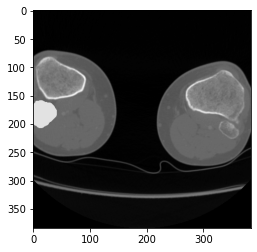

In [ ]:
plt.imshow((images_reg[735]),cmap='gray')
plt.show() 

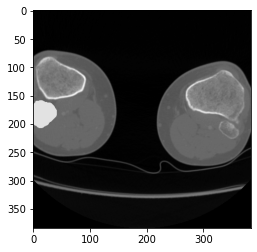

In [ ]:
plt.imshow((images[735]),cmap='gray')
plt.show() 

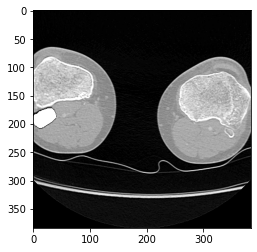

In [ ]:
plt.imshow(imageEnhance[750],cmap='gray')
plt.show() 

In [ ]:
from skimage.feature import canny
edges = canny(images[735], sigma=2)

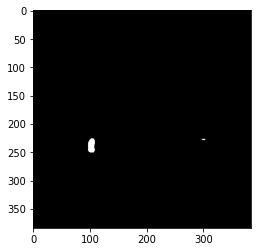

In [ ]:
plt.imshow(temp2[100],cmap='gray')
plt.show() 

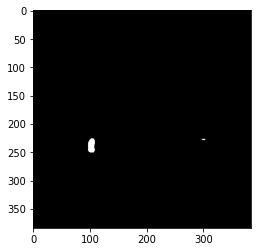

In [ ]:
plt.imshow(seg[1083],cmap='gray')
plt.show() 

In [ ]:
max = np.max(imageEnhance[735])
max

255

In [ ]:
min = np.min(imageEnhance[735])
min

0

In [ ]:
whos

Variable       Type        Data/Info
------------------------------------
DATA_PATH      str         /content/drive/MyDrive/Th<...>pz/crop_axial_uint020.npz
DataLoader     type        <class 'torch.utils.data.dataloader.DataLoader'>
Dataset        type        <class 'torch.utils.data.dataset.Dataset'>
Image          module      <module 'PIL.Image' from <...>t-packages/PIL/Image.py'>
cv2            module      <module 'cv2.cv2' from '/<...>37m-x86_64-linux-gnu.so'>
data           NpzFile     <numpy.lib.npyio.NpzFile <...>object at 0x7fc671cb6290>
datetime       type        <class 'datetime.datetime'>
drive          module      <module 'google.colab.dri<...>s/google/colab/drive.py'>
gt             ndarray     15830x384x384: 2334228480 elems, type `uint8`, 2334228480 bytes (2226.09375 Mb)
imageEnhance   ndarray     15830x384x384: 2334228480 elems, type `uint8`, 2334228480 bytes (2226.09375 Mb)
imageio        module      <module 'imageio' from '/<...>ges/imageio/__init__.py'>
images       

In [ ]:
max = np.max(gt)
max

255

In [ ]:
min = np.min(images)
min

-22.593866

# Train

In [ ]:
train(35, SAVE_PATH, SAVE_MODEL_PATH)

#this is for experiment 1

we can get npz
we can delete data of dataset for saving RAM
we can get train_data loader
we can delete train data for saving RAM
we can delete data of dataset for saving RAM
we can delete data of dataset for saving RAM
we can get test_data loader
we can delete test data for saving RAM


  0%|          | 0/35 [00:00<?, ?it/s]

train loss:0.9262162941121943, valid loss1:0.7198052231547207, valid loss2:0.6555251980242398, step: 0


  3%|▎         | 1/35 [06:00<3:24:02, 360.08s/it]

train loss:0.42265650260085524, valid loss1:0.693632057468437, valid loss2:0.6419060105733578, step: 1


  6%|▌         | 2/35 [11:59<3:17:51, 359.74s/it]

train loss:0.3364298229195195, valid loss1:0.8138222468156351, valid loss2:0.7696623840362741, step: 2


  9%|▊         | 3/35 [17:59<3:11:50, 359.69s/it]

train loss:0.2807198226870642, valid loss1:0.8482229276035076, valid loss2:0.807007585971896, step: 3


 11%|█▏        | 4/35 [23:58<3:05:48, 359.63s/it]

train loss:0.25167824680408774, valid loss1:0.830346360557662, valid loss2:0.7814987593850384, step: 4


 14%|█▍        | 5/35 [29:58<2:59:45, 359.50s/it]

train loss:0.2147750103501581, valid loss1:0.8465989636905806, valid loss2:0.8212017201611989, step: 5


 17%|█▋        | 6/35 [35:56<2:53:37, 359.23s/it]

train loss:0.19018497232530937, valid loss1:0.8725955734108995, valid loss2:0.8458784234436877, step: 6


 20%|██        | 7/35 [41:55<2:47:32, 359.03s/it]

train loss:0.17386407274273016, valid loss1:0.8960779928125123, valid loss2:0.8910159216357665, step: 7


 23%|██▎       | 8/35 [47:54<2:41:31, 358.96s/it]

train loss:0.1596580661431967, valid loss1:0.9081450420950478, valid loss2:0.9118272055255552, step: 8


 26%|██▌       | 9/35 [53:53<2:35:32, 358.94s/it]

train loss:0.13805111119004546, valid loss1:0.9230826358155396, valid loss2:0.9194254254310725, step: 9


 29%|██▊       | 10/35 [59:51<2:29:28, 358.76s/it]

train loss:0.12330463940421647, valid loss1:0.8870942515217826, valid loss2:0.8892912518021677, step: 10


 31%|███▏      | 11/35 [1:05:50<2:23:32, 358.84s/it]

train loss:0.12087955589316768, valid loss1:0.8872293235467211, valid loss2:0.8776750262300235, step: 11


 34%|███▍      | 12/35 [1:11:49<2:17:34, 358.87s/it]

train loss:0.1282336769115171, valid loss1:0.8705372686968772, valid loss2:0.8639931594709664, step: 12


 37%|███▋      | 13/35 [1:17:48<2:11:34, 358.83s/it]

train loss:0.13084859842438887, valid loss1:0.8957163891047722, valid loss2:0.8905271368568566, step: 13


 40%|████      | 14/35 [1:23:47<2:05:36, 358.90s/it]

train loss:0.11388901525135621, valid loss1:0.9206027394152063, valid loss2:0.9224823451707478, step: 14


 43%|████▎     | 15/35 [1:29:46<1:59:37, 358.89s/it]

train loss:0.10433515452668594, valid loss1:0.9065463049355238, valid loss2:0.9036444613453647, step: 15


 46%|████▌     | 16/35 [1:35:44<1:53:34, 358.67s/it]

train loss:0.08780759377557723, valid loss1:0.9304761775718501, valid loss2:0.9313944138864254, step: 16


 49%|████▊     | 17/35 [1:41:42<1:47:36, 358.71s/it]

train loss:0.08048756926623664, valid loss1:0.9031838405900672, valid loss2:0.9052757944384854, step: 17


 51%|█████▏    | 18/35 [1:47:41<1:41:38, 358.76s/it]

train loss:0.07533469468145795, valid loss1:0.9405921136104618, valid loss2:0.9489528504115141, step: 18


 54%|█████▍    | 19/35 [1:53:40<1:35:40, 358.77s/it]

train loss:0.07092054568632425, valid loss1:0.9470852557865387, valid loss2:0.9561948264805705, step: 19


 57%|█████▋    | 20/35 [1:59:39<1:29:43, 358.88s/it]

train loss:0.06674002149345165, valid loss1:0.9193736676526705, valid loss2:0.9297329916584458, step: 20


 60%|██████    | 21/35 [2:05:38<1:23:45, 358.95s/it]

train loss:0.06229836767674609, valid loss1:0.9489579688048906, valid loss2:0.9645539276921319, step: 21


 63%|██████▎   | 22/35 [2:11:37<1:17:44, 358.81s/it]

train loss:0.05883555431834987, valid loss1:0.9511846412809429, valid loss2:0.9607372802177802, step: 22


 66%|██████▌   | 23/35 [2:17:36<1:11:46, 358.87s/it]

train loss:0.05493432646333753, valid loss1:0.9442635099607025, valid loss2:0.9562826254683894, step: 23


 69%|██████▊   | 24/35 [2:23:35<1:05:47, 358.87s/it]

train loss:0.05439207216057342, valid loss1:0.9475609737344296, valid loss2:0.9584035913998391, step: 24


 71%|███████▏  | 25/35 [2:29:34<59:49, 358.94s/it]  

train loss:0.04923203873690174, valid loss1:0.9489335384848271, valid loss2:0.9641033208602517, step: 25


 74%|███████▍  | 26/35 [2:35:33<53:50, 358.98s/it]

train loss:0.046911334963537214, valid loss1:0.944513167587668, valid loss2:0.9606728713351397, step: 26


 77%|███████▋  | 27/35 [2:41:32<47:51, 358.98s/it]

train loss:0.0442079951947411, valid loss1:0.9543672155401255, valid loss2:0.9695780472897504, step: 27


 80%|████████  | 28/35 [2:47:31<41:52, 358.88s/it]

train loss:0.04347447140155408, valid loss1:0.9512727608333155, valid loss2:0.9650691011055921, step: 28


 83%|████████▎ | 29/35 [2:53:30<35:53, 358.98s/it]

train loss:0.04187902912881391, valid loss1:0.9548225488862516, valid loss2:0.9671471215499127, step: 29


 86%|████████▌ | 30/35 [2:59:29<29:54, 358.95s/it]

train loss:0.0421518510342761, valid loss1:0.9465531974157764, valid loss2:0.9589807462767573, step: 30


 89%|████████▊ | 31/35 [3:09:26<24:26, 366.67s/it]


KeyboardInterrupt: ignored

In [ ]:
train(20, SAVE_PATH, SAVE_MODEL_PATH)
#this is for DA part 1

we can get npz
we can delete data of dataset for saving RAM
we can get train_data loader
we can delete train data for saving RAM
we can delete data of dataset for saving RAM
we can delete data of dataset for saving RAM
we can get test_data loader
we can delete test data for saving RAM


  0%|          | 0/20 [00:00<?, ?it/s]

train loss:0.8706901452616247, valid loss1:0.45787342307320833, valid loss2:0.49997010847478335, step: 0


  5%|▌         | 1/20 [05:28<1:43:53, 328.10s/it]

train loss:0.5254821805429708, valid loss1:0.6876172876339213, valid loss2:0.7681331562867594, step: 1


 10%|█         | 2/20 [10:54<1:38:03, 326.88s/it]

train loss:0.4188998340000033, valid loss1:0.6724669019746056, valid loss2:0.7654118415567182, step: 2


 15%|█▌        | 3/20 [16:17<1:32:08, 325.18s/it]

train loss:0.36294228181789057, valid loss1:0.6746198242451814, valid loss2:0.7120549497863328, step: 3


 20%|██        | 4/20 [21:40<1:26:30, 324.41s/it]

train loss:0.3241032997038976, valid loss1:0.6936927963874298, valid loss2:0.7592197927308353, step: 4


 25%|██▌       | 5/20 [27:04<1:21:04, 324.27s/it]

train loss:0.28546666318833513, valid loss1:0.702122781052808, valid loss2:0.7705688060499465, step: 5


 30%|███       | 6/20 [32:27<1:15:34, 323.90s/it]

train loss:0.2621903244737555, valid loss1:0.7095544469425779, valid loss2:0.7940659164266287, step: 6


 35%|███▌      | 7/20 [37:50<1:10:07, 323.62s/it]

train loss:0.2404466535096393, valid loss1:0.7189145670022196, valid loss2:0.7946124706888145, step: 7


 40%|████      | 8/20 [43:15<1:04:46, 323.84s/it]

train loss:0.22828994917619916, valid loss1:0.7675063624251068, valid loss2:0.835729063917367, step: 8


 45%|████▌     | 9/20 [48:38<59:20, 323.69s/it]  

train loss:0.20545618399899668, valid loss1:0.748961136295907, valid loss2:0.8280666020325694, step: 9


 50%|█████     | 10/20 [54:01<53:55, 323.59s/it]

train loss:0.19023744504489198, valid loss1:0.7840883999908016, valid loss2:0.8335402688018079, step: 10


 55%|█████▌    | 11/20 [59:25<48:33, 323.74s/it]

train loss:0.17477056789772674, valid loss1:0.8135477552788732, valid loss2:0.8982770332768332, step: 11


 60%|██████    | 12/20 [1:04:48<43:08, 323.54s/it]

train loss:0.15844682249099173, valid loss1:0.8299762651182699, valid loss2:0.9002383144210314, step: 12


 65%|██████▌   | 13/20 [1:10:12<37:43, 323.39s/it]

train loss:0.14723963949692812, valid loss1:0.821065026918339, valid loss2:0.9155587383379838, step: 13


 70%|███████   | 14/20 [1:15:35<32:21, 323.52s/it]

train loss:0.14212963655981095, valid loss1:0.8206082534318064, valid loss2:0.9034370522146696, step: 14


 75%|███████▌  | 15/20 [1:20:58<26:56, 323.27s/it]

train loss:0.13363637381199142, valid loss1:0.8022415903889674, valid loss2:0.8761598526386175, step: 15


 80%|████████  | 16/20 [1:26:21<21:32, 323.14s/it]

train loss:0.12608365940798016, valid loss1:0.8343785906877305, valid loss2:0.9372436508013812, step: 16


 85%|████████▌ | 17/20 [1:31:44<16:09, 323.25s/it]

train loss:0.12000144573406399, valid loss1:0.8081879133550193, valid loss2:0.9029812846806, step: 17


 90%|█████████ | 18/20 [1:37:07<10:46, 323.01s/it]

train loss:0.11699472890474409, valid loss1:0.8256575349331877, valid loss2:0.9247946088804739, step: 18


 95%|█████████▌| 19/20 [1:42:29<05:22, 322.88s/it]

train loss:0.10775485837646805, valid loss1:0.8100188446024967, valid loss2:0.9086682241469146, step: 19


100%|██████████| 20/20 [1:47:53<00:00, 323.66s/it]


length of test scans is 734


RuntimeError: ignored

In [ ]:
continue_train(20,SAVE_MODEL_PATH+'/unet-2022-01-04T19-15-32.967274-step-16.tar',DATA_PATH,SAVE_PATH,SAVE_MODEL_PATH)

we can get npz
we can delete data of dataset for saving RAM
we can get train_data loader
we can delete train data for saving RAM
we can delete data of dataset for saving RAM
we can delete data of dataset for saving RAM
we can get test_data loader
we can delete test data for saving RAM


  0%|          | 0/20 [00:00<?, ?it/s]

train loss:0.11718154887306473, valid loss1:0.7893238349566437, valid loss2:0.8938309693978126, step: 0


  5%|▌         | 1/20 [05:26<1:43:14, 326.02s/it]

train loss:0.13489099566681267, valid loss1:0.8083014707128369, valid loss2:0.9132500372850908, step: 1


 10%|█         | 2/20 [10:50<1:37:34, 325.23s/it]

train loss:0.12542117140000544, valid loss1:0.8484767426710059, valid loss2:0.9044593835890409, step: 2


 15%|█▌        | 3/20 [16:14<1:31:55, 324.44s/it]

train loss:0.10859607125075617, valid loss1:0.8150551638718463, valid loss2:0.9333824275913003, step: 3


 20%|██        | 4/20 [21:37<1:26:25, 324.10s/it]

train loss:0.10176324626484365, valid loss1:0.8341400962701561, valid loss2:0.9166572052784516, step: 4


 25%|██▌       | 5/20 [27:01<1:20:58, 323.87s/it]

train loss:0.09526695003708723, valid loss1:0.8467941188751127, valid loss2:0.9283571831906571, step: 5


 30%|███       | 6/20 [32:25<1:15:37, 324.10s/it]

train loss:0.09003830111680391, valid loss1:0.8837985796089051, valid loss2:0.9430669433225461, step: 6


 35%|███▌      | 7/20 [37:49<1:10:11, 323.94s/it]

train loss:0.08499426692335163, valid loss1:0.8596037271035301, valid loss2:0.9513499830132022, step: 7


 40%|████      | 8/20 [43:13<1:04:46, 323.84s/it]

train loss:0.07790442328540215, valid loss1:0.9332285509443686, valid loss2:0.9540942885768625, step: 8


 45%|████▌     | 9/20 [48:36<59:20, 323.66s/it]  

train loss:0.07247726817666394, valid loss1:0.8688632355638083, valid loss2:0.950719579874281, step: 9


 50%|█████     | 10/20 [53:59<53:55, 323.57s/it]

train loss:0.06588286332611004, valid loss1:0.9123694539920657, valid loss2:0.9591926362853177, step: 10


 55%|█████▌    | 11/20 [59:22<48:31, 323.50s/it]

train loss:0.062290648878710074, valid loss1:0.8834256885626967, valid loss2:0.9593164800667118, step: 11


 60%|██████    | 12/20 [1:04:45<43:06, 323.35s/it]

train loss:0.05639587089847336, valid loss1:0.928902825448175, valid loss2:0.9685915109576634, step: 12


 65%|██████▌   | 13/20 [1:10:09<37:43, 323.34s/it]

train loss:0.05366802075513038, valid loss1:0.9431267900343916, valid loss2:0.9664754260239591, step: 13


 70%|███████   | 14/20 [1:15:32<32:19, 323.30s/it]

train loss:0.050287939082860326, valid loss1:0.9066769704767956, valid loss2:0.9750465152662018, step: 14


 75%|███████▌  | 15/20 [1:20:56<26:57, 323.47s/it]

train loss:0.0458440657695342, valid loss1:0.9444788424102181, valid loss2:0.9759521173426794, step: 15


 80%|████████  | 16/20 [1:26:19<21:33, 323.46s/it]

train loss:0.04444845102474521, valid loss1:0.9565045988434401, valid loss2:0.9777467790503771, step: 16


 85%|████████▌ | 17/20 [1:31:43<16:10, 323.46s/it]

train loss:0.0426000523193698, valid loss1:0.916257631474895, valid loss2:0.9733456628439047, step: 17


 90%|█████████ | 18/20 [1:37:07<10:47, 323.58s/it]

train loss:0.041222331884946894, valid loss1:0.9601165007334557, valid loss2:0.9780957573134207, step: 18


 95%|█████████▌| 19/20 [1:42:30<05:23, 323.61s/it]

train loss:0.03991962537441802, valid loss1:0.9345351783821014, valid loss2:0.9748997500044051, step: 19


100%|██████████| 20/20 [1:47:54<00:00, 323.73s/it]


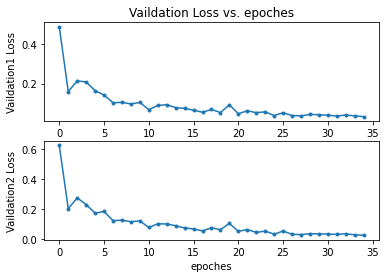

In [ ]:
train_Loss_list = list(np.load(SAVE_MODEL_PATH+'/f_train_Loss_list.npy'))
Valid1_loss_list = list(np.load(SAVE_MODEL_PATH+'/f_valid1_Loss_list.npy'))
Valid2_loss_list = list(np.load(SAVE_MODEL_PATH+'/f_valid2_Loss_list.npy'))
for i in range(len(Valid1_loss_list)):
    Valid1_loss_list[i] = 1 - Valid1_loss_list[i]
for i in range(len(Valid2_loss_list)):
    Valid2_loss_list[i] = 1 - Valid2_loss_list[i]
# train_Loss_list.append(train_loss / (len(train_dataset)))
# Accuracy_list.append(100 * train_acc / (len(train_dataset)))

#我这里迭代了200次，所以x的取值范围为(0，200)，然后再将每次相对应的准确率以及损失率附在x上
x1 = range(0, 35)
x2 = range(0, 35)
x3 = range(0, 35)
y1 = train_Loss_list
y2 = Valid1_loss_list
y3 = Valid2_loss_list
#plt.subplot(3, 1, 1)
# plt.plot(x1, y1, 'o-')
# plt.title('Train Loss vs. epoches')
# plt.ylabel('Train Loss')
# plt.xlabel('epoches')

plt.subplot(2, 1, 1)
plt.title('Vaildation Loss vs. epoches')
plt.plot(x2, y2, '.-')
plt.xlabel('epoches')
plt.ylabel('Vaildation1 Loss')
plt.subplot(2, 1, 2)
plt.plot(x3, y3, '.-')
plt.xlabel('epoches')
plt.ylabel('Vaildation2 Loss')
plt.show()
#plt.savefig("accuracy_loss.jpg")

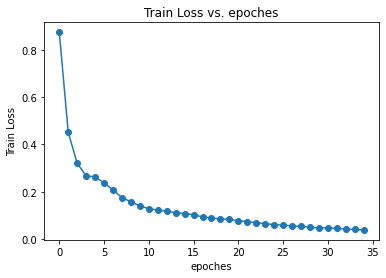

In [ ]:
plt.plot(x1, y1, 'o-')
plt.title('Train Loss vs. epoches')
plt.ylabel('Train Loss')
plt.xlabel('epoches')
plt.show()

In [ ]:
path = join('/content/drive/MyDrive/ThesisProject/processed', 'unet-{}.tar'.format(get_timestamp()))
torch.save(model.state_dict(), path)

In [ ]:
# Press the green button in the gutter to run the script.
if __name__ == '__main__':
    # test_dataloader()
    train(30, SAVE_PATH)
    # evaluate('sigmoid/unet-2021-07-15T20-32-05.923134.tar', 'sigmoid', train=True)

# Dataloader for Sagittal




In [ ]:
#axial_z = [983,734,670,790,786,794,799,810,951,803,767,761,999,1543,901,759,797,774,409]
#一共13824个

In [ ]:
import os

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import torch.nn as nn
from torch import optim
import time, cv2
from os.path import join
from datetime import datetime
from tqdm import tqdm
import imageio

import torch.nn.functional as F
import gc #（garbage collector）

# DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_uint020.npz'
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz'
SAVE_PATH = '/content/drive/MyDrive/ThesisProject/processed/test50_sagittal'
SAVE_MODEL_PATH = '/content/drive/MyDrive/ThesisProject/processed/sagittal'
# axial_z = [734,670,790,786,794,799,810,951,803,767,761,999,1543,901,759,797,774,409,983]


class MyDataset(Dataset):
    def __init__(self, images, gts, start=0, end=13849, batch_size=32):
        "images shape: (D, W, H)"
        data = images[start:end]
        #d, w, h = data.shape
        #data = data.reshape(n*d, w, h)
        
        #data = data.astype(np.float32)/255.0
        self.images = data.astype(np.float32)/255.0
        self.length = len(self.images)
        del data
        
        #self.images = (data-0.42725)/0.01891

        gtdata = gts[start:end]
        #gtdata = gtdata.reshape(n*d, w, h)
        self.gt = gtdata.astype(np.float32)/255.0
        del gtdata
        gc.collect()
        print("we can delete data of dataset for saving RAM")
        self.batch_size = batch_size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.gt[idx]

    def get_loader(self, shuffle=True):
        return DataLoader(self, batch_size=self.batch_size,
                          shuffle=shuffle)


def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.epsilon = 1e-5

    def forward(self, predict, target,bce_weight = 0.5):
        assert predict.size() == target.size(), "the size of predict and target must be equal."
        # num = predict.size(0)

        # pre = torch.sigmoid(predict).view(num, -1)
        # tar = target.view(num, -1)

        # intersection = (pre * tar).sum(-1).sum()
        # union = (pre + tar).sum(-1).sum()

        # score = 1 - 2 * (intersection + self.epsilon) / (union + self.epsilon)
        bce = F.binary_cross_entropy_with_logits(predict, target)
        pred = torch.sigmoid(predict)
        dice = dice_loss(pred, target)
        score = bce * bce_weight + dice * (1 - bce_weight)
        return score

class DiceLoss2(nn.Module):
    def __init__(self):
        super(DiceLoss2, self).__init__()
        self.epsilon = 1e-5

    def forward(self, predict, target,bce_weight = 0.5):
      assert predict.size() == target.size(), "the size of predict and target must be equal."
      dice = dice_loss(pred,target)
      return dice
      
class DiceLoss3(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss3, self).__init__()
    
    def forward(self, inputs, targets, smooth=1e-5):
        #
        #inputs = torch.sigmoid(inputs)
        #flatten
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        #element_wise production to get intersection score
        intersection = (inputs*targets).sum()
        # for debug
        # print(intersection)
        # print(inputs.sum())
        # print(targets.sum())
        dice_score = (2*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice_score



def get_timestamp():
    now = datetime.now()
    time_str = now.isoformat()
    time_str = time_str.replace(':', '-')
    return time_str

def compute_loss(pred, gt):
    # print(pred.shape, gt.shape)
    # criterion = nn.BCEWithLogitsLoss()
    # loss = criterion(pred, gt)
    func = DiceLoss3()
    loss = func(pred, gt)

    return loss

# def calc_loss(pred, target, metrics, bce_weight=0.5):
#     bce = F.binary_cross_entropy_with_logits(pred, target)

#     pred = torch.sigmoid(pred)
#     dice = dice_loss(pred, target)

#     loss = bce * bce_weight + dice * (1 - bce_weight)

#     metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
#     metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
#     metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

#     return loss


def test_dataloader():
    data = np.load(DATA_PATH)
    images, gt = data['img'], data['seg']
    dataset = MyDataset(images, gt, batch_size=1)
    loader = dataset.get_loader(shuffle=True)

    out = 'images'
    writer = imageio.get_writer('train.mp4', format='FFMPEG', mode='I', fps=1,
                       codec='h264_vaapi')
    for i, batch in enumerate(loader):
        images, gt = batch
        gt_masks = gt.cpu().numpy()
        pred_masks = images.cpu().numpy()
        img = np.concatenate([gt_masks[0] * 255, pred_masks[0] * 255])
        path = join(out, 'train_{}.jpg'.format(i))
        writer.append_data(img.astype(np.uint8))

        # cv2.imwrite(path, img)
        #
        # print(images.shape, gt.shape)
    writer.close()

def load_npz(path):
    data = np.load(path)
    images, gt = data['img'], data['seg']
    return images, gt

def dice(im1, im2):    
  smooth=1e-5  
  intersection = np.logical_and(im1, im2)      
  return (2. * (intersection.sum())+smooth) / (np.sum(im1>0) + np.sum(im2>0)+smooth)

def deNoise(pred):
  length = pred.shape[0]
  temp = np.zeros([length,384,384], dtype = np.uint8)
  flag = 1
  start = length//2
  while(flag):
    max = np.max(pred[start])
    start = start - 1
    if max == 0 or start < 0:
      flag = 0
  begin = start

  flag = 1
  start = length//2
  while(flag):
    max = np.max(pred[start])
    start = start + 1
    if max == 0 or start == length:
      flag = 0
  end = start
  temp[begin:end-1,:,:] = pred[begin:end-1,:,:]
  return temp



def result_analysis(pred, gt):

  avg_dice = 0
  n = 0
  for i in range(pred.shape[0]):

    data1 = pred[i,:,:]
    data2 = gt[i,:,:]
    
    loss = dice(data1,data2)

    avg_dice = avg_dice + loss
    n=n+1
  
  avg_dice = avg_dice/n
  return avg_dice

def train(epochs, save_path,save_model_path):
    os.makedirs(save_path, exist_ok=True)
    # prepare data
    #images, annotations = load_npz(DATA_PATH)
    images, segs = load_npz(DATA_PATH)
    print("we can get npz")
    train_data = MyDataset(images, segs, start=2304, end = -1, batch_size=32)
    train_loader = train_data.get_loader()
    print("we can get train_data loader")
    del train_data
    gc.collect()
    print("we can delete train data for saving RAM")
    # 734,1404,2194
    eval_data = MyDataset(images,segs,start=1536, end = 2304)
    test_data = MyDataset(images, segs, start=0, end=768)
    del images, segs
    gc.collect()
    eval_loader = eval_data.get_loader(shuffle = False)
    test_loader = test_data.get_loader(shuffle=False)
    print("we can get test_data loader")
    del test_data, eval_data
    gc.collect()
    print("we can delete test data for saving RAM")
    train_Loss_list = []
    valid1_Loss_list = []
    valid2_Loss_list = []
 
    #aux_params=dict(pooling='max',dropout=0.5,classes=1,)

    # prepare model
    model = smp.Unet(
        encoder_name="resnet50",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_depth=5,
        encoder_weights= None,  # use `imagenet` pre-trained weights for encoder initialization
        decoder_channels = (256, 128, 64, 32, 16),
        in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,  # model output channels (number of classes in your dataset)
        activation='sigmoid',#relu
        #aux_params=aux_params
    )

    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    device = 'cuda:0'
    model.to(device)
    best_loss = 100
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0
        for batch in train_loader:
            input, gt = batch
            #print(input.shape)
            input = input.to(device)
            gt = gt.to(device)
            input = input.unsqueeze(1)
            #print(input.shape)
            gt = gt.unsqueeze(1)
            masks = model(input)
            #print(masks.shape)
            #print(gt.shape)

            # compute loss
            loss = compute_loss(masks, gt)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            #print("mask max:{} loss:{}, step: {}".format(torch.max(masks), loss, epoch))
        train_loss /= len(train_loader)
        # print("train loss:{}, step: {}".format(train_loss, epoch))

        model.eval()
        numForSave=0
        avg_dice = 0
        temp_n = len(eval_loader.dataset)
        #print("length of test scans is {}".format(temp_n))
        temp = np.zeros([temp_n,384,384], dtype = np.uint8)
        temp2 = np.zeros([temp_n,384,384], dtype = np.uint8)
        with torch.no_grad():
            # compute eval loss              
          for j, eval_batch in enumerate(eval_loader):
            eval_input, eval_gt = eval_batch
            eval_input = eval_input.to(device)
            eval_gt = eval_gt.to(device)
            eval_input = eval_input.unsqueeze(1)
            
            eval_gt = eval_gt.unsqueeze(1)
            outputs = model(eval_input)
            outputs = outputs.squeeze(1)
            outputs[outputs >= 0.5] = 1
            outputs[outputs < 0.5] = 0
            outputs_mask = outputs.cpu().numpy()
            eval_gt_mask = eval_gt.cpu().numpy()
            
            for j in range(outputs.shape[0]):
              temp[numForSave] = outputs_mask[j]
              temp2[numForSave] = eval_gt_mask[j]
              numForSave=numForSave+1
              loss = dice(eval_gt_mask[j],outputs_mask[j])
              #print("No.{}:  {}".format(numForSave,loss))
              avg_dice = avg_dice + loss


        vol_loss = dice(temp,temp2)
        avg_loss = avg_dice/numForSave

        train_Loss_list.append(train_loss)
        valid1_Loss_list.append(avg_loss)
        valid2_Loss_list.append(vol_loss)
        
        

        print("train loss:{}, valid loss1:{}, valid loss2:{}, step: {}".format(train_loss, avg_loss, vol_loss, epoch))
            # save model
        path = join(save_model_path, 'unet-{}-step-{}.tar'.format(get_timestamp(),epoch))
        torch.save(model.state_dict(), path)
            # if loss < best_loss:

    train_Loss_list=np.array(train_Loss_list)
    valid1_Loss_list=np.array(valid1_Loss_list)
    valid2_Loss_list=np.array(valid2_Loss_list)

    np.save(SAVE_MODEL_PATH+'/train_Loss_list.npy',train_Loss_list)
    np.save(SAVE_MODEL_PATH+'/valid1_Loss_list.npy',valid1_Loss_list)
    np.save(SAVE_MODEL_PATH+'/valid2_Loss_list.npy',valid2_Loss_list)

    # evaluate test
    numForSave=0
    avg_dice = 0
    model.eval()
    temp_n = len(test_loader.dataset)
    print("length of test scans is {}".format(temp_n))
    temp = np.zeros([temp_n,384,384], dtype = np.uint8)
    temp2 = np.zeros([temp_n,384,384], dtype = np.uint8)
    for i, batch in enumerate(test_loader):
        input, gt = batch
        input = input.to(device)
        input = input.unsqueeze(1)
        pred = model(input)
        # print(pred.shape)
        pred = pred.squeeze(1)
        pred[pred >= 0.5] = 1
        pred[pred < 0.5] = 0
        gt_masks = gt.cpu().numpy()
        pred_masks = pred.cpu().numpy()
       

        for j in range(pred.shape[0]):
            temp[numForSave] = pred_masks[j]
            temp2[numForSave] = gt_masks[j]
            numForSave=numForSave+1
            loss = dice(gt_masks[j],pred_masks[j])
            print("No.{}:  {}".format(numForSave,loss))
            avg_dice = avg_dice + loss
    
    np.save(SAVE_PATH+'/pred3D_1.npy', temp)
    vol_dice = dice(temp,temp2)
    avg_dice = avg_dice/numForSave
    print("average dice is {}".format(avg_dice))  
    print("vol dice is {}".format(vol_dice))  


# test_data = MyDataset(images, segs, start=0, end=768)

def evaluate(checkpoint, save_path, train=False):
    ck = torch.load(checkpoint)
    # prepare model
    # prepare model
    model = smp.Unet(
        encoder_name="resnet50",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_depth=5,
        encoder_weights=None,  # use `imagenet` pre-trained weights for encoder initialization
        decoder_channels = (256, 128, 64, 32, 16),
        in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,  # model output channels (number of classes in your dataset)
        activation='sigmoid',#relu
        #aux_params=aux_params
    )
    model.load_state_dict(ck)
    model.eval()

    # prepare data
    images, annotations = load_npz(DATA_PATH)
    
    # test_data = MyDataset(images, annotations, start=14646, end=15420)
    # test_data = MyDataset(images, annotations, start=0, end=734)
    test_data = MyDataset(images, annotations, start=768, end=1536)
    test_loader = test_data.get_loader(shuffle=False)
    del test_data
    gc.collect()
    device = 'cuda:0'
    model.to(device)
    loader = test_loader
    info = 'test      '

    # evaluate
    numForSave=0
    avg_dice = 0

    temp_n = len(loader.dataset)
    print("length of test scans is {}".format(temp_n))
    temp = np.zeros([temp_n,384,384], dtype = np.uint8)
    temp2 = np.zeros([temp_n,384,384], dtype = np.uint8)
    with torch.no_grad():
      for i, batch in enumerate(loader):
        input, gt = batch
        input = input.to(device)
        input = input.unsqueeze(1)
        pred = model(input)
        # print(pred.shape)
        pred = pred.squeeze(1)
        pred[pred >= 0.5] = 1
        pred[pred < 0.5] = 0
        gt_masks = gt.cpu().numpy()
        pred_masks = pred.cpu().numpy()
       

        for j in range(pred.shape[0]):
            temp[numForSave] = pred_masks[j]
            temp2[numForSave] = gt_masks[j]
            numForSave=numForSave+1
            loss = dice(gt_masks[j],pred_masks[j])
            print("No.{}:  {}".format(numForSave,loss))
            avg_dice = avg_dice + loss
    
    np.save(SAVE_PATH+'/pred3D_2.npy', temp)
    vol_dice = dice(temp,temp2)
    avg_dice = avg_dice/numForSave
    print("average dice is {}".format(avg_dice))  
    print("vol dice is {}".format(vol_dice))

    temp = deNoise(temp)
    avg_dice2 = result_analysis(temp,temp2)
    vol_dice2 = dice(temp,temp2)
    np.save(SAVE_PATH+'/deNoisePred3D_2.npy', temp)
    print("After denoise, average dice is {}".format(avg_dice2))  
    print("After denoise, vol dice is {}".format(vol_dice2))
      
      




# final Dataloader for Sagittal




In [ ]:
#axial_z = [983,734,670,790,786,794,799,810,951,803,767,761,999,1543,901,759,797,774,409]
#一共13824个

In [ ]:
import os

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import torch.nn as nn
from torch import optim
import time, cv2
from os.path import join
from datetime import datetime
from tqdm import tqdm
import imageio

import torch.nn.functional as F
import gc #（garbage collector）

# DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_uint020.npz'
EVAL_DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz'
DATA_PATH1 = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/final1_crop_sagittal_conv1to20.npz'
DATA_PATH2 = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/final2_crop_sagittal_conv1to20.npz'
SAVE_PATH = '/content/drive/MyDrive/ThesisProject/processed/test50_sagittal'
SAVE_MODEL_PATH = '/content/drive/MyDrive/ThesisProject/processed/sagittal'
# axial_z = [734,670,790,786,794,799,810,951,803,767,761,999,1543,901,759,797,774,409,983]


class MyDataset(Dataset):
    def __init__(self, images, gts, start=0, end=13849, batch_size=32):
        "images shape: (D, W, H)"
        data = images[start:end]
        #d, w, h = data.shape
        #data = data.reshape(n*d, w, h)
        
        #data = data.astype(np.float32)/255.0
        self.images = data.astype(np.float32)/255.0
        self.length = len(self.images)
        del data
        
        #self.images = (data-0.42725)/0.01891

        gtdata = gts[start:end]
        #gtdata = gtdata.reshape(n*d, w, h)
        self.gt = gtdata.astype(np.float32)/255.0
        del gtdata
        gc.collect()
        print("we can delete data of dataset for saving RAM")
        self.batch_size = batch_size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.gt[idx]

    def get_loader(self, shuffle=True):
        return DataLoader(self, batch_size=self.batch_size,
                          shuffle=shuffle)


def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.epsilon = 1e-5

    def forward(self, predict, target,bce_weight = 0.5):
        assert predict.size() == target.size(), "the size of predict and target must be equal."
        # num = predict.size(0)

        # pre = torch.sigmoid(predict).view(num, -1)
        # tar = target.view(num, -1)

        # intersection = (pre * tar).sum(-1).sum()
        # union = (pre + tar).sum(-1).sum()

        # score = 1 - 2 * (intersection + self.epsilon) / (union + self.epsilon)
        bce = F.binary_cross_entropy_with_logits(predict, target)
        pred = torch.sigmoid(predict)
        dice = dice_loss(pred, target)
        score = bce * bce_weight + dice * (1 - bce_weight)
        return score

class DiceLoss2(nn.Module):
    def __init__(self):
        super(DiceLoss2, self).__init__()
        self.epsilon = 1e-5

    def forward(self, predict, target,bce_weight = 0.5):
      assert predict.size() == target.size(), "the size of predict and target must be equal."
      dice = dice_loss(pred,target)
      return dice
      
class DiceLoss3(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss3, self).__init__()
    
    def forward(self, inputs, targets, smooth=1e-5):
        #
        #inputs = torch.sigmoid(inputs)
        #flatten
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        #element_wise production to get intersection score
        intersection = (inputs*targets).sum()
        # for debug
        # print(intersection)
        # print(inputs.sum())
        # print(targets.sum())
        dice_score = (2*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice_score



def get_timestamp():
    now = datetime.now()
    time_str = now.isoformat()
    time_str = time_str.replace(':', '-')
    return time_str

def compute_loss(pred, gt):
    # print(pred.shape, gt.shape)
    # criterion = nn.BCEWithLogitsLoss()
    # loss = criterion(pred, gt)
    func = DiceLoss3()
    loss = func(pred, gt)

    return loss

# def calc_loss(pred, target, metrics, bce_weight=0.5):
#     bce = F.binary_cross_entropy_with_logits(pred, target)

#     pred = torch.sigmoid(pred)
#     dice = dice_loss(pred, target)

#     loss = bce * bce_weight + dice * (1 - bce_weight)

#     metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
#     metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
#     metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

#     return loss


def test_dataloader():
    data = np.load(DATA_PATH)
    images, gt = data['img'], data['seg']
    dataset = MyDataset(images, gt, batch_size=1)
    loader = dataset.get_loader(shuffle=True)

    out = 'images'
    writer = imageio.get_writer('train.mp4', format='FFMPEG', mode='I', fps=1,
                       codec='h264_vaapi')
    for i, batch in enumerate(loader):
        images, gt = batch
        gt_masks = gt.cpu().numpy()
        pred_masks = images.cpu().numpy()
        img = np.concatenate([gt_masks[0] * 255, pred_masks[0] * 255])
        path = join(out, 'train_{}.jpg'.format(i))
        writer.append_data(img.astype(np.uint8))

        # cv2.imwrite(path, img)
        #
        # print(images.shape, gt.shape)
    writer.close()

def load_npz(path):
    data = np.load(path)
    images, gt = data['img'], data['seg']
    return images, gt

def dice(im1, im2):    
  smooth=1e-5  
  intersection = np.logical_and(im1, im2)      
  return (2. * (intersection.sum())+smooth) / (np.sum(im1>0) + np.sum(im2>0)+smooth)

def deNoise(pred):
  length = pred.shape[0]
  temp = np.zeros([length,384,384], dtype = np.uint8)
  flag = 1
  start = length//2
  while(flag):
    max = np.max(pred[start])
    start = start - 1
    if max == 0 or start < 0:
      flag = 0
  begin = start

  flag = 1
  start = length//2
  while(flag):
    max = np.max(pred[start])
    start = start + 1
    if max == 0 or start == length:
      flag = 0
  end = start
  temp[begin:end-1,:,:] = pred[begin:end-1,:,:]
  return temp



def result_analysis(pred, gt):

  avg_dice = 0
  n = 0
  for i in range(pred.shape[0]):

    data1 = pred[i,:,:]
    data2 = gt[i,:,:]
    
    loss = dice(data1,data2)

    avg_dice = avg_dice + loss
    n=n+1
  
  avg_dice = avg_dice/n
  return avg_dice

def train(epochs, data_path, save_path,save_model_path):
    os.makedirs(save_path, exist_ok=True)
    # prepare data
    #images, annotations = load_npz(DATA_PATH)
    images, segs = load_npz(data_path)
    print("we can get npz")
    train_data = MyDataset(images, segs, start=0, end = -1, batch_size=32)
    train_loader = train_data.get_loader()
    print("we can get train_data loader")
    del images, segs,train_data
    gc.collect()
    print("we can delete train data for saving RAM")
    # 734,1404,2194
    images, segs = load_npz(EVAL_DATA_PATH)
    eval_data = MyDataset(images,segs,start=1536, end = 2304)
    test_data = MyDataset(images, segs, start=0, end=768)
    del images, segs
    gc.collect()
    eval_loader = eval_data.get_loader(shuffle = False)
    test_loader = test_data.get_loader(shuffle=False)
    print("we can get test_data loader")
    del test_data, eval_data
    gc.collect()
    print("we can delete test data for saving RAM")
    train_Loss_list = []
    valid1_Loss_list = []
    valid2_Loss_list = []
 
    #aux_params=dict(pooling='max',dropout=0.5,classes=1,)

    # prepare model
    model = smp.Unet(
        encoder_name="resnet50",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_depth=5,
        encoder_weights= None,  # use `imagenet` pre-trained weights for encoder initialization
        decoder_channels = (256, 128, 64, 32, 16),
        in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,  # model output channels (number of classes in your dataset)
        activation='sigmoid',#relu
        #aux_params=aux_params
    )

    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    device = 'cuda:0'
    model.to(device)
    best_loss = 100
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0
        for batch in train_loader:
            input, gt = batch
            #print(input.shape)
            input = input.to(device)
            gt = gt.to(device)
            input = input.unsqueeze(1)
            #print(input.shape)
            gt = gt.unsqueeze(1)
            masks = model(input)
            #print(masks.shape)
            #print(gt.shape)

            # compute loss
            loss = compute_loss(masks, gt)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            #print("mask max:{} loss:{}, step: {}".format(torch.max(masks), loss, epoch))
        train_loss /= len(train_loader)
        # print("train loss:{}, step: {}".format(train_loss, epoch))

        model.eval()
        numForSave=0
        avg_dice = 0
        temp_n = len(eval_loader.dataset)
        #print("length of test scans is {}".format(temp_n))
        temp = np.zeros([temp_n,384,384], dtype = np.uint8)
        temp2 = np.zeros([temp_n,384,384], dtype = np.uint8)
        with torch.no_grad():
            # compute eval loss              
          for j, eval_batch in enumerate(eval_loader):
            eval_input, eval_gt = eval_batch
            eval_input = eval_input.to(device)
            eval_gt = eval_gt.to(device)
            eval_input = eval_input.unsqueeze(1)
            
            eval_gt = eval_gt.unsqueeze(1)
            outputs = model(eval_input)
            outputs = outputs.squeeze(1)
            outputs[outputs >= 0.5] = 1
            outputs[outputs < 0.5] = 0
            outputs_mask = outputs.cpu().numpy()
            eval_gt_mask = eval_gt.cpu().numpy()
            
            for j in range(outputs.shape[0]):
              temp[numForSave] = outputs_mask[j]
              temp2[numForSave] = eval_gt_mask[j]
              numForSave=numForSave+1
              loss = dice(eval_gt_mask[j],outputs_mask[j])
              #print("No.{}:  {}".format(numForSave,loss))
              avg_dice = avg_dice + loss


        vol_loss = dice(temp,temp2)
        avg_loss = avg_dice/numForSave

        train_Loss_list.append(train_loss)
        valid1_Loss_list.append(avg_loss)
        valid2_Loss_list.append(vol_loss)
        
        

        print("train loss:{}, valid loss1:{}, valid loss2:{}, step: {}".format(train_loss, avg_loss, vol_loss, epoch))
            # save model
        path = join(save_model_path, 'unet-{}-step-{}.tar'.format(get_timestamp(),epoch))
        torch.save(model.state_dict(), path)
            # if loss < best_loss:

    train_Loss_list=np.array(train_Loss_list)
    valid1_Loss_list=np.array(valid1_Loss_list)
    valid2_Loss_list=np.array(valid2_Loss_list)

    np.save(SAVE_MODEL_PATH+'/f_train_Loss_list.npy',train_Loss_list)
    np.save(SAVE_MODEL_PATH+'/f_valid1_Loss_list.npy',valid1_Loss_list)
    np.save(SAVE_MODEL_PATH+'/f_valid2_Loss_list.npy',valid2_Loss_list)

    # # evaluate test
    # numForSave=0
    # avg_dice = 0
    # model.eval()
    # temp_n = len(test_loader.dataset)
    # print("length of test scans is {}".format(temp_n))
    # temp = np.zeros([temp_n,384,384], dtype = np.uint8)
    # temp2 = np.zeros([temp_n,384,384], dtype = np.uint8)
    # for i, batch in enumerate(test_loader):
    #     input, gt = batch
    #     input = input.to(device)
    #     input = input.unsqueeze(1)
    #     pred = model(input)
    #     # print(pred.shape)
    #     pred = pred.squeeze(1)
    #     pred[pred >= 0.5] = 1
    #     pred[pred < 0.5] = 0
    #     gt_masks = gt.cpu().numpy()
    #     pred_masks = pred.cpu().numpy()
       

    #     for j in range(pred.shape[0]):
    #         temp[numForSave] = pred_masks[j]
    #         temp2[numForSave] = gt_masks[j]
    #         numForSave=numForSave+1
    #         loss = dice(gt_masks[j],pred_masks[j])
    #         print("No.{}:  {}".format(numForSave,loss))
    #         avg_dice = avg_dice + loss
    
    # np.save(SAVE_PATH+'/pred3D_1.npy', temp)
    # vol_dice = dice(temp,temp2)
    # avg_dice = avg_dice/numForSave
    # print("average dice is {}".format(avg_dice))  
    # print("vol dice is {}".format(vol_dice))  


# test_data = MyDataset(images, segs, start=0, end=768)

def evaluate(checkpoint, save_path, train=False):
    ck = torch.load(checkpoint)
    # prepare model
    # prepare model
    model = smp.Unet(
        encoder_name="resnet50",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_depth=5,
        encoder_weights=None,  # use `imagenet` pre-trained weights for encoder initialization
        decoder_channels = (256, 128, 64, 32, 16),
        in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,  # model output channels (number of classes in your dataset)
        activation='sigmoid',#relu
        #aux_params=aux_params
    )
    model.load_state_dict(ck)
    model.eval()

    # prepare data
    images, annotations = load_npz(EVAL_DATA_PATH)
    
    # test_data = MyDataset(images, annotations, start=14646, end=15420)
    test_data = MyDataset(images, annotations, start=0, end=768)
    # test_data = MyDataset(images, annotations, start=768, end=1536)
    test_loader = test_data.get_loader(shuffle=False)
    del test_data
    gc.collect()
    device = 'cuda:0'
    model.to(device)
    loader = test_loader
    info = 'test      '

    # evaluate
    numForSave=0
    avg_dice = 0

    temp_n = len(loader.dataset)
    print("length of test scans is {}".format(temp_n))
    # temp = np.zeros([temp_n,384,384], dtype = np.uint8)
    # temp2 = np.zeros([temp_n,384,384], dtype = np.uint8)
    temp = np.zeros([temp_n,384,384], dtype = np.float)
    temp2 = np.zeros([temp_n,384,384], dtype = np.float)
    with torch.no_grad():
      for i, batch in enumerate(loader):
        input, gt = batch
        input = input.to(device)
        input = input.unsqueeze(1)
        pred = model(input)
        # print(pred.shape)
        pred = pred.squeeze(1)
        # pred[pred >= 0.5] = 1
        # pred[pred < 0.5] = 0
        gt_masks = gt.cpu().numpy()
        pred_masks = pred.cpu().numpy()
       

        for j in range(pred.shape[0]):
            temp[numForSave] = pred_masks[j]
            temp2[numForSave] = gt_masks[j]
            numForSave=numForSave+1
            loss = dice(gt_masks[j],pred_masks[j])
            print("No.{}:  {}".format(numForSave,loss))
            avg_dice = avg_dice + loss
    
    np.save(SAVE_PATH+'/prob_pred3D_1.npy', temp)
    vol_dice = dice(temp,temp2)
    avg_dice = avg_dice/numForSave
    print("average dice is {}".format(avg_dice))  
    print("vol dice is {}".format(vol_dice))

    temp = deNoise(temp)
    avg_dice2 = result_analysis(temp,temp2)
    vol_dice2 = dice(temp,temp2)
    np.save(SAVE_PATH+'/deNoisePred3D_1.npy', temp)
    print("After denoise, average dice is {}".format(avg_dice2))  
    print("After denoise, vol dice is {}".format(vol_dice2))
      
      

def continue_train(epochs, checkpoint, data_path, save_path,save_model_path):
  os.makedirs(save_path, exist_ok=True)
  images, segs = load_npz(data_path)
  print("we can get npz")
  train_data = MyDataset(images, segs, start=0, end =-1, batch_size=32)
  del images,segs
  gc.collect()
  train_loader = train_data.get_loader()
  print("we can get train_data loader")
  del train_data
  gc.collect()
  print("we can delete train data for saving RAM")
  images_eval, segs_eval = load_npz(EVAL_DATA_PATH)
  eval_data = MyDataset(images_eval,segs_eval, start=1536,end=2304)
  test_data = MyDataset(images_eval, segs_eval, start=768,end=1536)
  del images_eval, segs_eval
  gc.collect()
  eval_loader = eval_data.get_loader(shuffle = False)
  test_loader = test_data.get_loader(shuffle=False)
  print("we can get test_data loader")
  del test_data, eval_data
  gc.collect()
  print("we can delete test data for saving RAM")
  train_Loss_list = []
  valid1_Loss_list = []
  valid2_Loss_list = []
  ck = torch.load(checkpoint)
      

  model = smp.Unet(
        encoder_name="resnet50",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_depth=5,
        encoder_weights=None,  # use `imagenet` pre-trained weights for encoder initialization
        decoder_channels = (256, 128, 64, 32, 16),
        in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,  # model output channels (number of classes in your dataset)
        activation='sigmoid'#relu
    )
  model.load_state_dict(ck)
  optimizer = optim.Adam(model.parameters(), lr=1e-4)

  device = 'cuda:0'
  model.to(device)
  best_loss = 100
  for epoch in tqdm(range(epochs)):
      model.train()
      train_loss = 0
      for batch in train_loader:
          input, gt = batch
          #print(input.shape)
          input = input.to(device)
          gt = gt.to(device)
          input = input.unsqueeze(1)
          #print(input.shape)
          gt = gt.unsqueeze(1)
          masks = model(input)
          #print(masks.shape)
          #print(gt.shape)

          # compute loss
          loss = compute_loss(masks, gt)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
          #print("mask max:{} loss:{}, step: {}".format(torch.max(masks), loss, epoch))
      train_loss /= len(train_loader)
      # print("train loss:{}, step: {}".format(train_loss, epoch))

      model.eval()
      numForSave=0
      avg_dice = 0
      temp_n = len(eval_loader.dataset)
      #print("length of test scans is {}".format(temp_n))
      temp = np.zeros([temp_n,384,384], dtype = np.uint8)
      temp2 = np.zeros([temp_n,384,384], dtype = np.uint8)
      with torch.no_grad():
          # compute eval loss              
        for j, eval_batch in enumerate(eval_loader):
          eval_input, eval_gt = eval_batch
          eval_input = eval_input.to(device)
          eval_gt = eval_gt.to(device)
          eval_input = eval_input.unsqueeze(1)
          
          eval_gt = eval_gt.unsqueeze(1)
          outputs = model(eval_input)
          outputs = outputs.squeeze(1)
          outputs[outputs >= 0.5] = 1
          outputs[outputs < 0.5] = 0
          outputs_mask = outputs.cpu().numpy()
          eval_gt_mask = eval_gt.cpu().numpy()
          
          for j in range(outputs.shape[0]):
            temp[numForSave] = outputs_mask[j]
            temp2[numForSave] = eval_gt_mask[j]
            numForSave=numForSave+1
            loss = dice(eval_gt_mask[j],outputs_mask[j])
            #print("No.{}:  {}".format(numForSave,loss))
            avg_dice = avg_dice + loss


      vol_loss = dice(temp,temp2)
      avg_loss = avg_dice/numForSave

      train_Loss_list.append(train_loss)
      valid1_Loss_list.append(avg_loss)
      valid2_Loss_list.append(vol_loss)
      
      

      print("train loss:{}, valid loss1:{}, valid loss2:{}, step: {}".format(train_loss, avg_loss, vol_loss, epoch))
          # save model
      path = join(save_model_path, 'unet-{}-step-{}.tar'.format(get_timestamp(),epoch))
      torch.save(model.state_dict(), path)
          # if loss < best_loss:

  train_Loss_list=np.array(train_Loss_list)
  valid1_Loss_list=np.array(valid1_Loss_list)
  valid2_Loss_list=np.array(valid2_Loss_list)

  np.save(SAVE_MODEL_PATH+'/f2_train_Loss_list.npy',train_Loss_list)
  np.save(SAVE_MODEL_PATH+'/f2_valid1_Loss_list.npy',valid1_Loss_list)
  np.save(SAVE_MODEL_PATH+'/f2_valid2_Loss_list.npy',valid2_Loss_list)


# train for sagittal

In [ ]:
train(25, DATA_PATH1, SAVE_PATH, SAVE_MODEL_PATH)

we can get npz
we can delete data of dataset for saving RAM
we can get train_data loader
we can delete train data for saving RAM
we can delete data of dataset for saving RAM
we can delete data of dataset for saving RAM
we can get test_data loader
we can delete test data for saving RAM


  0%|          | 0/25 [00:00<?, ?it/s]

train loss:0.8398957095335965, valid loss1:0.1957226933514525, valid loss2:0.060263089333711876, step: 0


  4%|▍         | 1/25 [05:39<2:15:53, 339.72s/it]

train loss:0.4709849373914709, valid loss1:0.6631722840650045, valid loss2:0.697986111223071, step: 1


  8%|▊         | 2/25 [11:23<2:11:04, 341.93s/it]

train loss:0.3468084480632004, valid loss1:0.6850366191777922, valid loss2:0.7429791449993443, step: 2


 12%|█▏        | 3/25 [17:02<2:04:53, 340.61s/it]

train loss:0.2866202914596197, valid loss1:0.583451526973477, valid loss2:0.6927014697767224, step: 3


 16%|█▌        | 4/25 [22:41<1:58:59, 339.97s/it]

train loss:0.2460656584198795, valid loss1:0.7126663821567113, valid loss2:0.7976887533835786, step: 4


 20%|██        | 5/25 [28:20<1:53:14, 339.74s/it]

train loss:0.211116482221072, valid loss1:0.7383889383388625, valid loss2:0.8210577452194773, step: 5


 24%|██▍       | 6/25 [33:59<1:47:30, 339.50s/it]

train loss:0.1872722075056674, valid loss1:0.7241665555906854, valid loss2:0.8230038229188964, step: 6


 28%|██▊       | 7/25 [39:40<1:41:56, 339.82s/it]

train loss:0.16881008883613852, valid loss1:0.6373663867911656, valid loss2:0.7548245590487692, step: 7


 32%|███▏      | 8/25 [45:19<1:36:12, 339.57s/it]

train loss:0.1688572660607485, valid loss1:0.7312135237075705, valid loss2:0.789968634481139, step: 8


 36%|███▌      | 9/25 [50:57<1:30:28, 339.27s/it]

train loss:0.15849510443151293, valid loss1:0.6288077546719076, valid loss2:0.7471152982569418, step: 9


 40%|████      | 10/25 [56:37<1:24:52, 339.47s/it]

train loss:0.16008414987900957, valid loss1:0.8787642258934527, valid loss2:0.9238171202290567, step: 10


 44%|████▍     | 11/25 [1:02:16<1:19:09, 339.28s/it]

train loss:0.1480451294438756, valid loss1:0.7206986842385574, valid loss2:0.8551786693581017, step: 11


 48%|████▊     | 12/25 [1:07:55<1:13:29, 339.20s/it]

train loss:0.13483835215592266, valid loss1:0.7762834930083917, valid loss2:0.8919105600930011, step: 12


 52%|█████▏    | 13/25 [1:13:35<1:07:52, 339.37s/it]

train loss:0.12160187603822395, valid loss1:0.8994027755448143, valid loss2:0.9277528336311804, step: 13


 56%|█████▌    | 14/25 [1:19:14<1:02:11, 339.21s/it]

train loss:0.11408594992030319, valid loss1:0.7647048112281601, valid loss2:0.8886517057067223, step: 14


 60%|██████    | 15/25 [1:24:52<56:31, 339.11s/it]  

train loss:0.10667984491557031, valid loss1:0.9044975271255667, valid loss2:0.9542453728244491, step: 15


 64%|██████▍   | 16/25 [1:30:32<50:53, 339.27s/it]

train loss:0.09884286994364724, valid loss1:0.8728307833649036, valid loss2:0.9358589958094997, step: 16


 68%|██████▊   | 17/25 [1:36:11<45:12, 339.12s/it]

train loss:0.09268813717424573, valid loss1:0.8832495974498588, valid loss2:0.9446347070561494, step: 17


 72%|███████▏  | 18/25 [1:41:50<39:33, 339.03s/it]

train loss:0.08878199467018469, valid loss1:0.9195982182999763, valid loss2:0.9552932813041848, step: 18


 76%|███████▌  | 19/25 [1:47:30<33:55, 339.31s/it]

train loss:0.08606999979090335, valid loss1:0.866720408170713, valid loss2:0.9372338081651442, step: 19


 80%|████████  | 20/25 [1:53:08<28:15, 339.16s/it]

train loss:0.07814830600918822, valid loss1:0.9300590496998108, valid loss2:0.9586408091360256, step: 20


 84%|████████▍ | 21/25 [1:58:47<22:36, 339.08s/it]

train loss:0.07495924059431351, valid loss1:0.876935077469967, valid loss2:0.9511890305013719, step: 21


 88%|████████▊ | 22/25 [2:04:27<16:58, 339.36s/it]

train loss:0.07217195526284365, valid loss1:0.8671653504207765, valid loss2:0.9415991291286874, step: 22


 92%|█████████▏| 23/25 [2:10:06<11:18, 339.26s/it]

train loss:0.06920125324334671, valid loss1:0.9105698089714308, valid loss2:0.9507823096669676, step: 23


 96%|█████████▌| 24/25 [2:15:45<05:39, 339.18s/it]

train loss:0.06562855335610424, valid loss1:0.8688397290223134, valid loss2:0.9523849737746845, step: 24


100%|██████████| 25/25 [2:21:25<00:00, 339.43s/it]


In [ ]:
continue_train(25,SAVE_MODEL_PATH+'/unet-2022-01-02T02-40-03.592106-step-20.tar',DATA_PATH2,SAVE_PATH,SAVE_MODEL_PATH)

we can get npz
we can delete data of dataset for saving RAM
we can get train_data loader
we can delete train data for saving RAM
we can delete data of dataset for saving RAM
we can delete data of dataset for saving RAM
we can get test_data loader
we can delete test data for saving RAM


  0%|          | 0/25 [00:00<?, ?it/s]

train loss:0.07427700271653892, valid loss1:0.92959917385411, valid loss2:0.9641919506791685, step: 0


  4%|▍         | 1/25 [05:39<2:15:38, 339.10s/it]

train loss:0.08529878092642447, valid loss1:0.8124229591868048, valid loss2:0.8921850948861659, step: 1


  8%|▊         | 2/25 [11:20<2:10:30, 340.47s/it]

train loss:0.07790580703251397, valid loss1:0.918736709679152, valid loss2:0.9671845168632187, step: 2


 12%|█▏        | 3/25 [16:58<2:04:23, 339.25s/it]

train loss:0.07399594368626229, valid loss1:0.9229094930772055, valid loss2:0.9589208167158593, step: 3


 16%|█▌        | 4/25 [22:36<1:58:32, 338.69s/it]

train loss:0.07906799529915426, valid loss1:0.9305601451428194, valid loss2:0.9613240335660417, step: 4


 20%|██        | 5/25 [28:15<1:52:59, 338.99s/it]

train loss:0.0670580602996978, valid loss1:0.9063431708146843, valid loss2:0.9653579912296922, step: 5


 24%|██▍       | 6/25 [33:53<1:47:15, 338.69s/it]

train loss:0.06550101824660799, valid loss1:0.9250399383887644, valid loss2:0.9674367351509581, step: 6


 28%|██▊       | 7/25 [39:32<1:41:34, 338.58s/it]

train loss:0.060610876895895054, valid loss1:0.9327226996656522, valid loss2:0.9703370275727339, step: 7


 32%|███▏      | 8/25 [45:11<1:35:58, 338.73s/it]

train loss:0.056132698385276604, valid loss1:0.9025887517269974, valid loss2:0.9582985072099969, step: 8


 36%|███▌      | 9/25 [50:49<1:30:15, 338.44s/it]

train loss:0.05349222759702312, valid loss1:0.9155875562074786, valid loss2:0.9595566957625865, step: 9


 40%|████      | 10/25 [56:26<1:24:34, 338.27s/it]

train loss:0.05356935363503831, valid loss1:0.9488003722402252, valid loss2:0.9680542440952853, step: 10


 44%|████▍     | 11/25 [1:02:05<1:18:59, 338.51s/it]

train loss:0.047940987259594364, valid loss1:0.9306295925258489, valid loss2:0.9707360126249872, step: 11


 48%|████▊     | 12/25 [1:07:43<1:13:18, 338.37s/it]

train loss:0.047965485658218614, valid loss1:0.9351278806410185, valid loss2:0.9718330156864645, step: 12


 52%|█████▏    | 13/25 [1:13:22<1:07:39, 338.29s/it]

train loss:0.04650631072509348, valid loss1:0.8676362406802278, valid loss2:0.9694482676592628, step: 13


 56%|█████▌    | 14/25 [1:19:01<1:02:03, 338.54s/it]

train loss:0.0426308155356355, valid loss1:0.9474105371782383, valid loss2:0.9765068551243675, step: 14


 60%|██████    | 15/25 [1:24:39<56:24, 338.45s/it]  

train loss:0.042301227204242155, valid loss1:0.9643797809164728, valid loss2:0.9815968495133313, step: 15


 64%|██████▍   | 16/25 [1:30:17<50:45, 338.35s/it]

train loss:0.04068205086746026, valid loss1:0.8691979345827155, valid loss2:0.9543949935674633, step: 16


 68%|██████▊   | 17/25 [1:35:56<45:08, 338.58s/it]

train loss:0.039313007794802464, valid loss1:0.9187736357968083, valid loss2:0.9754890617797728, step: 17


 72%|███████▏  | 18/25 [1:41:34<39:29, 338.49s/it]

train loss:0.035510045527225705, valid loss1:0.9348891709069903, valid loss2:0.9797234150583055, step: 18


 76%|███████▌  | 19/25 [1:47:13<33:50, 338.37s/it]

train loss:0.03756272941086423, valid loss1:0.8726760594947586, valid loss2:0.9517163109274474, step: 19


 80%|████████  | 20/25 [1:52:52<28:13, 338.64s/it]

train loss:0.03662082271196356, valid loss1:0.9551372814708845, valid loss2:0.98119882903631, step: 20


 84%|████████▍ | 21/25 [1:58:30<22:33, 338.47s/it]

train loss:0.034830454421873706, valid loss1:0.9077162970962457, valid loss2:0.9714306109461625, step: 21


 88%|████████▊ | 22/25 [2:04:08<16:55, 338.37s/it]

train loss:0.03448276080895419, valid loss1:0.8992146617678819, valid loss2:0.9759480995217698, step: 22


 92%|█████████▏| 23/25 [2:09:47<11:17, 338.60s/it]

train loss:0.034248493648880156, valid loss1:0.9615111831524766, valid loss2:0.9838598389344767, step: 23


 96%|█████████▌| 24/25 [2:15:26<05:38, 338.52s/it]

train loss:0.032972020889396096, valid loss1:0.9127249488077839, valid loss2:0.9828245699707364, step: 24


100%|██████████| 25/25 [2:21:04<00:00, 338.57s/it]


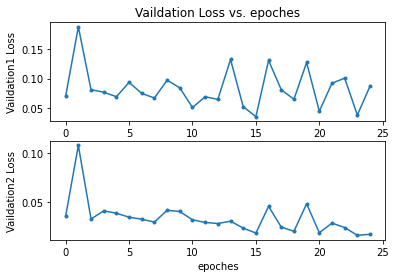

In [ ]:

train_Loss_list = list(np.load(SAVE_MODEL_PATH+'/f2_train_Loss_list.npy'))
Valid1_loss_list = list(np.load(SAVE_MODEL_PATH+'/f2_valid1_Loss_list.npy'))
Valid2_loss_list = list(np.load(SAVE_MODEL_PATH+'/f2_valid2_Loss_list.npy'))
for i in range(len(Valid1_loss_list)):
    Valid1_loss_list[i] = 1 - Valid1_loss_list[i]
for i in range(len(Valid2_loss_list)):
    Valid2_loss_list[i] = 1 - Valid2_loss_list[i]
# train_Loss_list.append(train_loss / (len(train_dataset)))
# Accuracy_list.append(100 * train_acc / (len(train_dataset)))

#我这里迭代了200次，所以x的取值范围为(0，200)，然后再将每次相对应的准确率以及损失率附在x上
x1 = range(0, 25)
x2 = range(0, 25)
x3 = range(0, 25)
y1 = train_Loss_list
y2 = Valid1_loss_list
y3 = Valid2_loss_list
#plt.subplot(3, 1, 1)
# plt.plot(x1, y1, 'o-')
# plt.title('Train Loss vs. epoches')
# plt.ylabel('Train Loss')
# plt.xlabel('epoches')

plt.subplot(2, 1, 1)
plt.title('Vaildation Loss vs. epoches')
plt.plot(x2, y2, '.-')
plt.xlabel('epoches')
plt.ylabel('Vaildation1 Loss')
plt.subplot(2, 1, 2)
plt.plot(x3, y3, '.-')
plt.xlabel('epoches')
plt.ylabel('Vaildation2 Loss')
plt.show()
#plt.savefig("accuracy_loss.jpg")

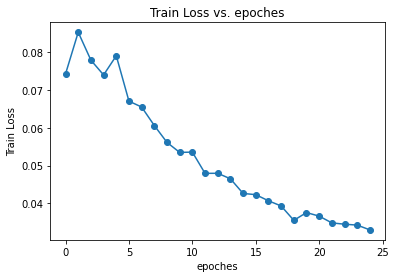

In [ ]:
plt.plot(x1, y1, 'o-')
plt.title('Train Loss vs. epoches')
plt.ylabel('Train Loss')
plt.xlabel('epoches')
plt.show()

In [ ]:
evaluate(SAVE_MODEL_PATH+'/'+'unet-2022-01-02T12-48-24.981961-step-23.tar',SAVE_PATH,train=False)
# test 2

we can delete data of dataset for saving RAM
length of test scans is 768
No.1:  1.0
No.2:  1.0
No.3:  1.0
No.4:  1.0
No.5:  1.0
No.6:  1.0
No.7:  1.0
No.8:  1.0
No.9:  1.0
No.10:  1.0
No.11:  1.0
No.12:  1.0
No.13:  1.0
No.14:  1.0
No.15:  1.0
No.16:  1.0
No.17:  1.0
No.18:  1.0
No.19:  1.0
No.20:  1.0
No.21:  1.0
No.22:  1.0
No.23:  1.0
No.24:  1.0
No.25:  1.0
No.26:  1.0
No.27:  1.0
No.28:  1.0
No.29:  1.0
No.30:  1.0
No.31:  1.0
No.32:  1.0
No.33:  1.0
No.34:  1.0
No.35:  1.0
No.36:  1.0
No.37:  1.0
No.38:  1.0
No.39:  1.0
No.40:  1.0
No.41:  1.0
No.42:  1.0
No.43:  1.0
No.44:  1.0
No.45:  1.0
No.46:  1.0
No.47:  1.0
No.48:  1.0
No.49:  1.0
No.50:  1.0
No.51:  1.0
No.52:  1.0
No.53:  1.0
No.54:  1.0
No.55:  1.0
No.56:  1.0
No.57:  1.0
No.58:  1.0
No.59:  1.0
No.60:  1.0
No.61:  1.0
No.62:  1.0
No.63:  1.0
No.64:  1.0
No.65:  1.0
No.66:  1.0
No.67:  1.0
No.68:  6.849314599362014e-08
No.69:  1.0
No.70:  0.7865168599293016
No.71:  1.0
No.72:  0.828451886434061
No.73:  1.0
No.74:  0.861

In [ ]:
evaluate(SAVE_MODEL_PATH+'/'+'unet-2022-01-02T12-48-24.981961-step-23.tar',SAVE_PATH,train=False)
# test 1

we can delete data of dataset for saving RAM
length of test scans is 768
No.1:  1.0
No.2:  1.0
No.3:  1.0
No.4:  1.0
No.5:  1.0
No.6:  1.0
No.7:  1.0
No.8:  1.0
No.9:  1.0
No.10:  1.0
No.11:  1.0
No.12:  1.0
No.13:  1.0
No.14:  1.0
No.15:  1.0
No.16:  1.0
No.17:  1.0
No.18:  1.0
No.19:  1.0
No.20:  1.0
No.21:  1.0
No.22:  1.0
No.23:  1.0
No.24:  1.0
No.25:  1.0
No.26:  1.0
No.27:  1.0
No.28:  1.0
No.29:  1.0
No.30:  1.0
No.31:  1.0
No.32:  1.0
No.33:  1.0
No.34:  1.0
No.35:  1.0
No.36:  1.0
No.37:  1.0
No.38:  1.0
No.39:  1.0
No.40:  1.0
No.41:  1.0
No.42:  1.0
No.43:  1.0
No.44:  1.0
No.45:  1.0
No.46:  1.0
No.47:  1.0
No.48:  1.0
No.49:  1.0
No.50:  1.0
No.51:  1.0
No.52:  1.0
No.53:  1.0
No.54:  1.0
No.55:  1.0
No.56:  1.0
No.57:  1.0
No.58:  1.0
No.59:  1.0
No.60:  1.0
No.61:  1.0
No.62:  1.0
No.63:  1.0
No.64:  1.0
No.65:  1.0
No.66:  1.0
No.67:  1.0
No.68:  0.489361756450877
No.69:  1.0
No.70:  0.8544891685916666
No.71:  1.0
No.72:  0.9013539670917995
No.73:  1.0
No.74:  0.854285

In [ ]:
# test 1 probility
evaluate(SAVE_MODEL_PATH+'/'+'unet-2022-01-02T12-48-24.981961-step-23.tar',SAVE_PATH,train=False)

In [ ]:
# test 2 probility
evaluate(SAVE_MODEL_PATH+'/'+'unet-2022-01-02T12-48-24.981961-step-23.tar',SAVE_PATH,train=False)

In [ ]:
# test 1 probility not DA
evaluate(SAVE_MODEL_PATH+'/'+'unet-2021-12-31T02-34-33.868125-step-25.tar',SAVE_PATH,train=False)

we can delete data of dataset for saving RAM
length of test scans is 768
No.1:  6.811989054414244e-09
No.2:  2.4999937500156254e-06
No.3:  8.496176648290768e-09
No.4:  2.4999937500156254e-06
No.5:  1.2004801776653041e-08
No.6:  2.4999937500156254e-06
No.7:  7.107320489642357e-09
No.8:  2.4999937500156254e-06
No.9:  6.385696000091341e-09
No.10:  2.4999937500156254e-06
No.11:  1.1560693507968863e-08
No.12:  2.4999937500156254e-06
No.13:  1.8248174849485864e-08
No.14:  2.4999937500156254e-06
No.15:  9.940357754071991e-09
No.16:  2.4999937500156254e-06
No.17:  7.535794969587077e-09
No.18:  2.4999937500156254e-06
No.19:  7.087172168056896e-09
No.20:  2.4999937500156254e-06
No.21:  7.199423994244609e-09
No.22:  2.4999937500156254e-06
No.23:  7.11743767176201e-09
No.24:  2.4999937500156254e-06
No.25:  6.81663253703727e-09
No.26:  2.4999937500156254e-06
No.27:  4.518752803801388e-09
No.28:  2.4999937500156254e-06
No.29:  4.719207150923987e-09
No.30:  2.4999937500156254e-06
No.31:  4.6598322243

In [ ]:
# test 2 probility not DA
evaluate(SAVE_MODEL_PATH+'/'+'unet-2021-12-31T02-34-33.868125-step-25.tar',SAVE_PATH,train=False)

In [ ]:
SAVE_MODEL_PATH = '/content/drive/MyDrive/ThesisProject/processed/sagittal'
path = join(SAVE_MODEL_PATH, 'unet-{}.tar'.format(get_timestamp()))

torch.save(model.state_dict(), path)

In [ ]:
whos

In [ ]:
evaluate(SAVE_MODEL_PATH+'/'+'unet-2021-11-16T19-54-20.610486.tar',SAVE_PATH,train=False)

we can delete data of dataset for saving RAM


# Dataloader for coronal

In [ ]:
import os

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import torch.nn as nn
from torch import optim
import time, cv2
from os.path import join
from datetime import datetime
from tqdm import tqdm
import imageio

import torch.nn.functional as F
import gc #（garbage collector）

# DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_uint020.npz'
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz'
SAVE_PATH = '/content/drive/MyDrive/ThesisProject/processed/test50_coronal'
SAVE_MODEL_PATH = '/content/drive/MyDrive/ThesisProject/processed/coronal'
# axial_z = [734,670,790,786,794,799,810,951,803,767,761,999,1543,901,759,797,774,409,983]


class MyDataset(Dataset):
    def __init__(self, images, gts, start=0, end=13849, batch_size=32):
        "images shape: (D, W, H)"
        data = images[start:end]
        #d, w, h = data.shape
        #data = data.reshape(n*d, w, h)
        
        #data = data.astype(np.float32)/255.0
        self.images = data.astype(np.float32)/255.0
        self.length = len(self.images)
        del data
        
        #self.images = (data-0.42725)/0.01891

        gtdata = gts[start:end]
        #gtdata = gtdata.reshape(n*d, w, h)
        self.gt = gtdata.astype(np.float32)/255.0
        del gtdata
        gc.collect()
        print("we can delete data of dataset for saving RAM")
        self.batch_size = batch_size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.gt[idx]

    def get_loader(self, shuffle=True):
        return DataLoader(self, batch_size=self.batch_size,
                          shuffle=shuffle)


def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.epsilon = 1e-5

    def forward(self, predict, target,bce_weight = 0.5):
        assert predict.size() == target.size(), "the size of predict and target must be equal."
        # num = predict.size(0)

        # pre = torch.sigmoid(predict).view(num, -1)
        # tar = target.view(num, -1)

        # intersection = (pre * tar).sum(-1).sum()
        # union = (pre + tar).sum(-1).sum()

        # score = 1 - 2 * (intersection + self.epsilon) / (union + self.epsilon)
        bce = F.binary_cross_entropy_with_logits(predict, target)
        pred = torch.sigmoid(predict)
        dice = dice_loss(pred, target)
        score = bce * bce_weight + dice * (1 - bce_weight)
        return score

class DiceLoss2(nn.Module):
    def __init__(self):
        super(DiceLoss2, self).__init__()
        self.epsilon = 1e-5

    def forward(self, predict, target,bce_weight = 0.5):
      assert predict.size() == target.size(), "the size of predict and target must be equal."
      dice = dice_loss(pred,target)
      return dice
      
class DiceLoss3(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss3, self).__init__()
    
    def forward(self, inputs, targets, smooth=1e-5):
        #
        #inputs = torch.sigmoid(inputs)
        #flatten
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        #element_wise production to get intersection score
        intersection = (inputs*targets).sum()
        # for debug
        # print(intersection)
        # print(inputs.sum())
        # print(targets.sum())
        dice_score = (2*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice_score



def get_timestamp():
    now = datetime.now()
    time_str = now.isoformat()
    time_str = time_str.replace(':', '-')
    return time_str

def compute_loss(pred, gt):
    # print(pred.shape, gt.shape)
    # criterion = nn.BCEWithLogitsLoss()
    # loss = criterion(pred, gt)
    func = DiceLoss3()
    loss = func(pred, gt)

    return loss

# def calc_loss(pred, target, metrics, bce_weight=0.5):
#     bce = F.binary_cross_entropy_with_logits(pred, target)

#     pred = torch.sigmoid(pred)
#     dice = dice_loss(pred, target)

#     loss = bce * bce_weight + dice * (1 - bce_weight)

#     metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
#     metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
#     metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

#     return loss


def test_dataloader():
    data = np.load(DATA_PATH)
    images, gt = data['img'], data['seg']
    dataset = MyDataset(images, gt, batch_size=1)
    loader = dataset.get_loader(shuffle=True)

    out = 'images'
    writer = imageio.get_writer('train.mp4', format='FFMPEG', mode='I', fps=1,
                       codec='h264_vaapi')
    for i, batch in enumerate(loader):
        images, gt = batch
        gt_masks = gt.cpu().numpy()
        pred_masks = images.cpu().numpy()
        img = np.concatenate([gt_masks[0] * 255, pred_masks[0] * 255])
        path = join(out, 'train_{}.jpg'.format(i))
        writer.append_data(img.astype(np.uint8))

        # cv2.imwrite(path, img)
        #
        # print(images.shape, gt.shape)
    writer.close()

def load_npz(path):
    data = np.load(path)
    images, gt = data['img'], data['seg']
    return images, gt

def dice(im1, im2):    
  smooth=1e-5  
  intersection = np.logical_and(im1, im2)      
  return (2. * (intersection.sum())+smooth) / (np.sum(im1>0) + np.sum(im2>0)+smooth)

def deNoise(pred):
  length = pred.shape[0]
  temp = np.zeros([length,384,384], dtype = np.uint8)
  flag = 1
  start = length//2
  while(flag):
    max = np.max(pred[start])
    start = start - 1
    if max == 0 or start < 0:
      flag = 0
  begin = start

  flag = 1
  start = length//2
  while(flag):
    max = np.max(pred[start])
    start = start + 1
    if max == 0 or start == length:
      flag = 0
  end = start
  temp[begin:end-1,:,:] = pred[begin:end-1,:,:]
  return temp



def result_analysis(pred, gt):

  avg_dice = 0
  n = 0
  for i in range(pred.shape[0]):

    data1 = pred[i,:,:]
    data2 = gt[i,:,:]
    
    loss = dice(data1,data2)

    avg_dice = avg_dice + loss
    n=n+1
  
  avg_dice = avg_dice/n
  return avg_dice

def train(epochs, data_path, save_path,save_model_path):
    os.makedirs(save_path, exist_ok=True)
    # prepare data
    #images, annotations = load_npz(DATA_PATH)
    images, segs = load_npz(data_path)
    print("we can get npz")
    train_data = MyDataset(images, segs, start=0, end = -1, batch_size=32)
    train_loader = train_data.get_loader()
    print("we can get train_data loader")
    del images, segs,train_data
    gc.collect()
    print("we can delete train data for saving RAM")
    # 734,1404,2194
    images, segs = load_npz(EVAL_DATA_PATH)
    eval_data = MyDataset(images,segs,start=1536, end = 2304)
    test_data = MyDataset(images, segs, start=0, end=768)
    del images, segs
    gc.collect()
    eval_loader = eval_data.get_loader(shuffle = False)
    test_loader = test_data.get_loader(shuffle=False)
    print("we can get test_data loader")
    del test_data, eval_data
    gc.collect()
    print("we can delete test data for saving RAM")
    train_Loss_list = []
    valid1_Loss_list = []
    valid2_Loss_list = []
 
    #aux_params=dict(pooling='max',dropout=0.5,classes=1,)

    # prepare model
    model = smp.Unet(
        encoder_name="resnet50",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_depth=5,
        encoder_weights= None,  # use `imagenet` pre-trained weights for encoder initialization
        decoder_channels = (256, 128, 64, 32, 16),
        in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,  # model output channels (number of classes in your dataset)
        activation='sigmoid',#relu
        #aux_params=aux_params
    )

    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    device = 'cuda:0'
    model.to(device)
    best_loss = 100
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0
        for batch in train_loader:
            input, gt = batch
            #print(input.shape)
            input = input.to(device)
            gt = gt.to(device)
            input = input.unsqueeze(1)
            #print(input.shape)
            gt = gt.unsqueeze(1)
            masks = model(input)
            #print(masks.shape)
            #print(gt.shape)

            # compute loss
            loss = compute_loss(masks, gt)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            #print("mask max:{} loss:{}, step: {}".format(torch.max(masks), loss, epoch))
        train_loss /= len(train_loader)
        # print("train loss:{}, step: {}".format(train_loss, epoch))

        model.eval()
        numForSave=0
        avg_dice = 0
        temp_n = len(eval_loader.dataset)
        #print("length of test scans is {}".format(temp_n))
        temp = np.zeros([temp_n,384,384], dtype = np.uint8)
        temp2 = np.zeros([temp_n,384,384], dtype = np.uint8)
        with torch.no_grad():
            # compute eval loss              
          for j, eval_batch in enumerate(eval_loader):
            eval_input, eval_gt = eval_batch
            eval_input = eval_input.to(device)
            eval_gt = eval_gt.to(device)
            eval_input = eval_input.unsqueeze(1)
            
            eval_gt = eval_gt.unsqueeze(1)
            outputs = model(eval_input)
            outputs = outputs.squeeze(1)
            outputs[outputs >= 0.5] = 1
            outputs[outputs < 0.5] = 0
            outputs_mask = outputs.cpu().numpy()
            eval_gt_mask = eval_gt.cpu().numpy()
            
            for j in range(outputs.shape[0]):
              temp[numForSave] = outputs_mask[j]
              temp2[numForSave] = eval_gt_mask[j]
              numForSave=numForSave+1
              loss = dice(eval_gt_mask[j],outputs_mask[j])
              #print("No.{}:  {}".format(numForSave,loss))
              avg_dice = avg_dice + loss


        vol_loss = dice(temp,temp2)
        avg_loss = avg_dice/numForSave

        train_Loss_list.append(train_loss)
        valid1_Loss_list.append(avg_loss)
        valid2_Loss_list.append(vol_loss)
        
        

        print("train loss:{}, valid loss1:{}, valid loss2:{}, step: {}".format(train_loss, avg_loss, vol_loss, epoch))
            # save model
        path = join(save_model_path, 'unet-{}-step-{}.tar'.format(get_timestamp(),epoch))
        torch.save(model.state_dict(), path)
            # if loss < best_loss:

    train_Loss_list=np.array(train_Loss_list)
    valid1_Loss_list=np.array(valid1_Loss_list)
    valid2_Loss_list=np.array(valid2_Loss_list)

    np.save(SAVE_MODEL_PATH+'/f_train_Loss_list.npy',train_Loss_list)
    np.save(SAVE_MODEL_PATH+'/f_valid1_Loss_list.npy',valid1_Loss_list)
    np.save(SAVE_MODEL_PATH+'/f_valid2_Loss_list.npy',valid2_Loss_list)

    # # evaluate test
    # numForSave=0
    # avg_dice = 0
    # model.eval()
    # temp_n = len(test_loader.dataset)
    # print("length of test scans is {}".format(temp_n))
    # temp = np.zeros([temp_n,384,384], dtype = np.uint8)
    # temp2 = np.zeros([temp_n,384,384], dtype = np.uint8)
    # for i, batch in enumerate(test_loader):
    #     input, gt = batch
    #     input = input.to(device)
    #     input = input.unsqueeze(1)
    #     pred = model(input)
    #     # print(pred.shape)
    #     pred = pred.squeeze(1)
    #     pred[pred >= 0.5] = 1
    #     pred[pred < 0.5] = 0
    #     gt_masks = gt.cpu().numpy()
    #     pred_masks = pred.cpu().numpy()
       

    #     for j in range(pred.shape[0]):
    #         temp[numForSave] = pred_masks[j]
    #         temp2[numForSave] = gt_masks[j]
    #         numForSave=numForSave+1
    #         loss = dice(gt_masks[j],pred_masks[j])
    #         print("No.{}:  {}".format(numForSave,loss))
    #         avg_dice = avg_dice + loss
    
    # np.save(SAVE_PATH+'/pred3D_1.npy', temp)
    # vol_dice = dice(temp,temp2)
    # avg_dice = avg_dice/numForSave
    # print("average dice is {}".format(avg_dice))  
    # print("vol dice is {}".format(vol_dice))  


# test_data = MyDataset(images, segs, start=0, end=768)

def evaluate(checkpoint, save_path, train=False):
    ck = torch.load(checkpoint)
    # prepare model
    # prepare model
    model = smp.Unet(
        encoder_name="resnet50",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_depth=5,
        encoder_weights=None,  # use `imagenet` pre-trained weights for encoder initialization
        decoder_channels = (256, 128, 64, 32, 16),
        in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,  # model output channels (number of classes in your dataset)
        activation='sigmoid',#relu
        #aux_params=aux_params
    )
    model.load_state_dict(ck)
    model.eval()

    # prepare data
    images, annotations = load_npz(DATA_PATH)
    
    # test_data = MyDataset(images, annotations, start=14646, end=15420)
    # test_data = MyDataset(images, annotations, start=0, end=768)
    test_data = MyDataset(images, annotations, start=768, end=1536)
    test_loader = test_data.get_loader(shuffle=False)
    del test_data
    gc.collect()
    device = 'cuda:0'
    model.to(device)
    loader = test_loader
    info = 'test      '

    # evaluate
    numForSave=0
    avg_dice = 0

    temp_n = len(loader.dataset)
    print("length of test scans is {}".format(temp_n))
    # temp = np.zeros([temp_n,384,384], dtype = np.uint8)
    # temp2 = np.zeros([temp_n,384,384], dtype = np.uint8)
    temp = np.zeros([temp_n,384,384], dtype = np.float)
    temp2 = np.zeros([temp_n,384,384], dtype = np.float)
    with torch.no_grad():
      for i, batch in enumerate(loader):
        input, gt = batch
        input = input.to(device)
        input = input.unsqueeze(1)
        pred = model(input)
        # print(pred.shape)
        pred = pred.squeeze(1)
        # pred[pred >= 0.5] = 1
        # pred[pred < 0.5] = 0
        gt_masks = gt.cpu().numpy()
        pred_masks = pred.cpu().numpy()
       

        for j in range(pred.shape[0]):
            temp[numForSave] = pred_masks[j]
            temp2[numForSave] = gt_masks[j]
            numForSave=numForSave+1
            loss = dice(gt_masks[j],pred_masks[j])
            print("No.{}:  {}".format(numForSave,loss))
            avg_dice = avg_dice + loss
    
    np.save(SAVE_PATH+'/prob_pred3D_2.npy', temp)
    vol_dice = dice(temp,temp2)
    avg_dice = avg_dice/numForSave
    print("average dice is {}".format(avg_dice))  
    print("vol dice is {}".format(vol_dice))

    temp = deNoise(temp)
    avg_dice2 = result_analysis(temp,temp2)
    vol_dice2 = dice(temp,temp2)
    np.save(SAVE_PATH+'/deNoisePred3D_2.npy', temp)
    print("After denoise, average dice is {}".format(avg_dice2))  
    print("After denoise, vol dice is {}".format(vol_dice2))
      
    




# train for coronal

In [ ]:
train(30, SAVE_PATH, SAVE_MODEL_PATH)

we can get npz
we can delete data of dataset for saving RAM
we can get train_data loader
we can delete train data for saving RAM
we can delete data of dataset for saving RAM
we can delete data of dataset for saving RAM
we can get test_data loader
we can delete test data for saving RAM


  0%|          | 0/30 [00:00<?, ?it/s]

train loss:0.9642389289206929, valid loss1:0.32230059110320625, valid loss2:0.0972266760128098, step: 0


  3%|▎         | 1/30 [05:07<2:28:45, 307.78s/it]

train loss:0.7294827424817615, valid loss1:0.7409779921285168, valid loss2:0.453499160653617, step: 1


  7%|▋         | 2/30 [10:13<2:23:01, 306.49s/it]

train loss:0.548541788260142, valid loss1:0.7994300466826183, valid loss2:0.5234620799460993, step: 2


 10%|█         | 3/30 [15:17<2:17:27, 305.47s/it]

train loss:0.4367017024093204, valid loss1:0.8392763350501027, valid loss2:0.6381155082495039, step: 3


 13%|█▎        | 4/30 [20:21<2:12:10, 305.02s/it]

train loss:0.389074501560794, valid loss1:0.8714559030411139, valid loss2:0.7979659906825182, step: 4


 17%|█▋        | 5/30 [25:26<2:07:02, 304.88s/it]

train loss:0.33700501140620975, valid loss1:0.827086272625542, valid loss2:0.7916383880807483, step: 5


 20%|██        | 6/30 [30:31<2:01:53, 304.73s/it]

train loss:0.37159598337279426, valid loss1:0.7970724180622483, valid loss2:0.6910092319705474, step: 6


 23%|██▎       | 7/30 [35:36<1:56:53, 304.95s/it]

train loss:0.35113576336039437, valid loss1:0.8575446242919025, valid loss2:0.8052594314027733, step: 7


 27%|██▋       | 8/30 [40:41<1:51:51, 305.08s/it]

train loss:0.30893272327052224, valid loss1:0.9058344368017388, valid loss2:0.8293710994646726, step: 8


 30%|███       | 9/30 [45:46<1:46:45, 305.03s/it]

train loss:0.26897545804580053, valid loss1:0.9316744084334575, valid loss2:0.8163900582920135, step: 9


 33%|███▎      | 10/30 [50:52<1:41:43, 305.16s/it]

train loss:0.24173644052611457, valid loss1:0.9231370402905874, valid loss2:0.8155399283767039, step: 10


 37%|███▋      | 11/30 [55:57<1:36:38, 305.19s/it]

train loss:0.2680437268482314, valid loss1:0.9172104305507555, valid loss2:0.7718774748594033, step: 11


 40%|████      | 12/30 [1:01:02<1:31:30, 305.05s/it]

train loss:0.22763982448312972, valid loss1:0.9131244647001885, valid loss2:0.8265272148745556, step: 12


 43%|████▎     | 13/30 [1:06:07<1:26:26, 305.12s/it]

train loss:0.2288417042957412, valid loss1:0.891185035891309, valid loss2:0.883397710667887, step: 13


 47%|████▋     | 14/30 [1:11:12<1:21:23, 305.19s/it]

train loss:0.23667921804719502, valid loss1:0.9481382149910456, valid loss2:0.8639792323261798, step: 14


 50%|█████     | 15/30 [1:16:17<1:16:15, 305.05s/it]

train loss:0.23192935470077727, valid loss1:0.9239718526338873, valid loss2:0.8665064165226114, step: 15


 53%|█████▎    | 16/30 [1:21:23<1:11:13, 305.23s/it]

train loss:0.19805480771594577, valid loss1:0.9218354009685932, valid loss2:0.8687482389093223, step: 16


 57%|█████▋    | 17/30 [1:26:28<1:06:07, 305.18s/it]

train loss:0.18782284557819368, valid loss1:0.9357987139456009, valid loss2:0.8844814906995899, step: 17


 60%|██████    | 18/30 [1:31:33<1:01:00, 305.08s/it]

train loss:0.17781142228179508, valid loss1:0.9425258013244985, valid loss2:0.9059055842562985, step: 18


 63%|██████▎   | 19/30 [1:36:38<55:58, 305.31s/it]  

train loss:0.1643585044476721, valid loss1:0.9503229515233951, valid loss2:0.8983386695828421, step: 19


 67%|██████▋   | 20/30 [1:41:44<50:53, 305.31s/it]

train loss:0.16227065920829772, valid loss1:0.924187457782502, valid loss2:0.9125410954961212, step: 20


 70%|███████   | 21/30 [1:46:48<45:46, 305.15s/it]

train loss:0.17260967526170942, valid loss1:0.9314636256927254, valid loss2:0.8633359255358085, step: 21


 73%|███████▎  | 22/30 [1:51:54<40:42, 305.33s/it]

train loss:0.1657842912607723, valid loss1:0.9568940167659067, valid loss2:0.9118877346971569, step: 22


 77%|███████▋  | 23/30 [1:57:00<35:37, 305.34s/it]

train loss:0.168828803466426, valid loss1:0.9376788885776919, valid loss2:0.8725191412508733, step: 23


 80%|████████  | 24/30 [2:02:04<30:31, 305.20s/it]

train loss:0.15289036813709472, valid loss1:0.9285307383140982, valid loss2:0.9149201243536798, step: 24


 83%|████████▎ | 25/30 [2:07:10<25:27, 305.43s/it]

train loss:0.16103065576818254, valid loss1:0.9468027025667446, valid loss2:0.8784813923872304, step: 25


 87%|████████▋ | 26/30 [2:12:15<20:21, 305.32s/it]

train loss:0.15002744512425528, valid loss1:0.9248627530344122, valid loss2:0.9167384495084185, step: 26


 90%|█████████ | 27/30 [2:17:20<15:15, 305.21s/it]

train loss:0.1511116647058063, valid loss1:0.945130651633871, valid loss2:0.8502261021641185, step: 27


 93%|█████████▎| 28/30 [2:22:26<10:10, 305.42s/it]

train loss:0.13045716020796033, valid loss1:0.9525928920212303, valid loss2:0.9062673141191957, step: 28


 97%|█████████▋| 29/30 [2:27:32<05:05, 305.36s/it]

train loss:0.1277584496471617, valid loss1:0.9539687984648125, valid loss2:0.9301687530535444, step: 29


100%|██████████| 30/30 [2:32:37<00:00, 305.23s/it]


length of test scans is 768


RuntimeError: ignored

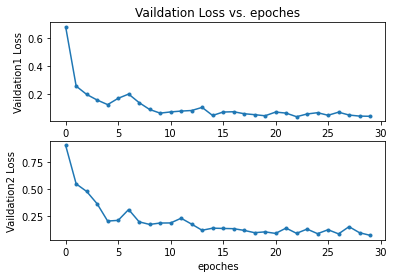

In [ ]:
train_Loss_list = list(np.load(SAVE_MODEL_PATH+'/train_Loss_list.npy'))
Valid1_loss_list = list(np.load(SAVE_MODEL_PATH+'/valid1_Loss_list.npy'))
Valid2_loss_list = list(np.load(SAVE_MODEL_PATH+'/valid2_Loss_list.npy'))
for i in range(len(Valid1_loss_list)):
    Valid1_loss_list[i] = 1 - Valid1_loss_list[i]
for i in range(len(Valid2_loss_list)):
    Valid2_loss_list[i] = 1 - Valid2_loss_list[i]
# train_Loss_list.append(train_loss / (len(train_dataset)))
# Accuracy_list.append(100 * train_acc / (len(train_dataset)))

#我这里迭代了200次，所以x的取值范围为(0，200)，然后再将每次相对应的准确率以及损失率附在x上
x1 = range(0, 30)
x2 = range(0, 30)
x3 = range(0, 30)
y1 = train_Loss_list
y2 = Valid1_loss_list
y3 = Valid2_loss_list
#plt.subplot(3, 1, 1)
# plt.plot(x1, y1, 'o-')
# plt.title('Train Loss vs. epoches')
# plt.ylabel('Train Loss')
# plt.xlabel('epoches')

plt.subplot(2, 1, 1)
plt.title('Vaildation Loss vs. epoches')
plt.plot(x2, y2, '.-')
plt.xlabel('epoches')
plt.ylabel('Vaildation1 Loss')
plt.subplot(2, 1, 2)
plt.plot(x3, y3, '.-')
plt.xlabel('epoches')
plt.ylabel('Vaildation2 Loss')
plt.show()
#plt.savefig("accuracy_loss.jpg")

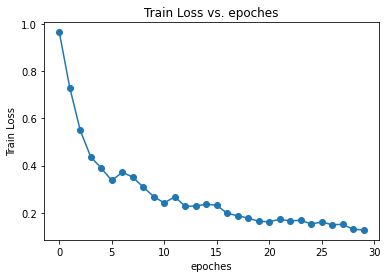

In [ ]:
plt.plot(x1, y1, 'o-')
plt.title('Train Loss vs. epoches')
plt.ylabel('Train Loss')
plt.xlabel('epoches')
plt.show()

In [ ]:
evaluate(SAVE_MODEL_PATH+'/'+'unet-2021-12-31T16-59-10.006831-step-29.tar',SAVE_PATH,train=False)
# test 1

we can delete data of dataset for saving RAM
length of test scans is 734
No.1:  1.0
No.2:  1.0
No.3:  1.0
No.4:  1.0
No.5:  1.0
No.6:  1.0
No.7:  1.0
No.8:  1.0
No.9:  1.0
No.10:  1.0
No.11:  1.0
No.12:  1.0
No.13:  1.0
No.14:  1.0
No.15:  1.0
No.16:  1.0
No.17:  1.0
No.18:  1.0
No.19:  1.0
No.20:  1.0
No.21:  1.0
No.22:  1.0
No.23:  1.0
No.24:  1.0
No.25:  1.0
No.26:  1.0
No.27:  1.0
No.28:  1.0
No.29:  1.0
No.30:  1.0
No.31:  1.0
No.32:  1.0
No.33:  1.0
No.34:  1.0
No.35:  1.0
No.36:  1.0
No.37:  1.0
No.38:  1.0
No.39:  1.0
No.40:  1.0
No.41:  1.0
No.42:  1.0
No.43:  1.0
No.44:  1.0
No.45:  1.0
No.46:  1.0
No.47:  1.0
No.48:  1.0
No.49:  1.0
No.50:  1.0
No.51:  1.0
No.52:  1.0
No.53:  1.0
No.54:  1.0
No.55:  1.0
No.56:  1.0
No.57:  1.0
No.58:  1.0
No.59:  1.0
No.60:  1.0
No.61:  1.0
No.62:  1.0
No.63:  1.0
No.64:  1.0
No.65:  1.0
No.66:  1.0
No.67:  1.0
No.68:  1.0
No.69:  1.0
No.70:  1.0
No.71:  1.0
No.72:  1.0
No.73:  1.0
No.74:  1.0
No.75:  1.0
No.76:  1.0
No.77:  1.0
No.78:  1.0


In [ ]:
evaluate(SAVE_MODEL_PATH+'/'+'unet-2021-12-31T16-59-10.006831-step-29.tar',SAVE_PATH,train=False)
# test 2

we can delete data of dataset for saving RAM
length of test scans is 768
No.1:  1.0
No.2:  1.0
No.3:  1.0
No.4:  1.0
No.5:  1.0
No.6:  1.0
No.7:  1.0
No.8:  1.0
No.9:  1.0
No.10:  1.0
No.11:  1.0
No.12:  1.0
No.13:  1.0
No.14:  1.0
No.15:  1.0
No.16:  1.0
No.17:  1.0
No.18:  1.0
No.19:  1.0
No.20:  1.0
No.21:  1.0
No.22:  1.0
No.23:  1.0
No.24:  1.0
No.25:  1.0
No.26:  1.0
No.27:  1.0
No.28:  1.0
No.29:  1.0
No.30:  1.0
No.31:  1.0
No.32:  1.0
No.33:  1.0
No.34:  1.0
No.35:  1.0
No.36:  1.0
No.37:  1.0
No.38:  1.0
No.39:  1.0
No.40:  1.0
No.41:  1.0
No.42:  1.0
No.43:  1.0
No.44:  1.0
No.45:  1.0
No.46:  1.0
No.47:  1.0
No.48:  1.0
No.49:  1.0
No.50:  1.0
No.51:  1.0
No.52:  1.0
No.53:  1.0
No.54:  1.0
No.55:  1.0
No.56:  1.0
No.57:  1.0
No.58:  1.0
No.59:  1.0
No.60:  1.0
No.61:  1.0
No.62:  1.0
No.63:  1.0
No.64:  1.0
No.65:  1.0
No.66:  1.0
No.67:  1.0
No.68:  1.0
No.69:  1.0
No.70:  1.0
No.71:  1.0
No.72:  1.0
No.73:  1.0
No.74:  1.0
No.75:  1.0
No.76:  1.0
No.77:  1.0
No.78:  1.0


In [ ]:
# test 1 probility not DA
evaluate(SAVE_MODEL_PATH+'/'+'unet-2021-12-31T16-59-10.006831-step-29.tar',SAVE_PATH,train=False)

In [ ]:
# test 2 probility not DA
evaluate(SAVE_MODEL_PATH+'/'+'unet-2021-12-31T16-59-10.006831-step-29.tar',SAVE_PATH,train=False)

we can delete data of dataset for saving RAM
length of test scans is 768
No.1:  1.0
No.2:  1.0
No.3:  1.0
No.4:  1.0
No.5:  1.0
No.6:  1.0
No.7:  1.0
No.8:  1.0
No.9:  1.0
No.10:  1.0
No.11:  1.0
No.12:  1.0
No.13:  1.0
No.14:  1.0
No.15:  1.0
No.16:  1.0
No.17:  1.0
No.18:  1.0
No.19:  1.0
No.20:  1.0
No.21:  1.0
No.22:  1.0
No.23:  1.0
No.24:  1.0
No.25:  1.0
No.26:  1.0
No.27:  1.0
No.28:  1.0
No.29:  1.0
No.30:  1.0
No.31:  1.0
No.32:  1.0
No.33:  1.0
No.34:  1.0
No.35:  1.0
No.36:  1.0
No.37:  1.0
No.38:  1.0
No.39:  1.0
No.40:  1.0
No.41:  1.0
No.42:  1.0
No.43:  1.0
No.44:  1.0
No.45:  1.0
No.46:  1.0
No.47:  1.0
No.48:  1.0
No.49:  1.0
No.50:  1.0
No.51:  1.0
No.52:  1.0
No.53:  1.0
No.54:  1.0
No.55:  1.0
No.56:  1.0
No.57:  1.0
No.58:  1.0
No.59:  1.0
No.60:  1.0
No.61:  1.0
No.62:  1.0
No.63:  1.0
No.64:  1.0
No.65:  1.0
No.66:  1.0
No.67:  1.0
No.68:  1.0
No.69:  1.0
No.70:  1.0
No.71:  1.0
No.72:  1.0
No.73:  1.0
No.74:  1.0
No.75:  1.0
No.76:  1.0
No.77:  1.0
No.78:  1.0


In [ ]:
SAVE_MODEL_PATH = '/content/drive/MyDrive/ThesisProject/processed/coronal'
path = join(SAVE_MODEL_PATH, 'unet-{}.tar'.format(get_timestamp()))

torch.save(model.state_dict(), path)

In [ ]:
whos

In [ ]:
evaluate(SAVE_MODEL_PATH+'/'+'unet-2021-11-16T19-54-20.610486.tar',SAVE_PATH,train=False)

we can delete data of dataset for saving RAM


# result analysis for sagittal

In [ ]:
SAVE_PATH = '/content/drive/MyDrive/ThesisProject/processed/test50_sagittal/'
smooth=1e-5
def dice(im1, im2):
    intersection = np.logical_and(im1, im2)

    return (2. * (intersection.sum())+smooth) / (np.sum(im1>0) + np.sum(im2>0)+smooth)

def dice_self(data1,data2):
  num1 = 0
  num2 = 0
  intersection = 0
  for i in range(384):
    for j in range(384):
      if(data1[i,j] == 1):
        num1 = num1+1
        if(data2[i,j] == 1):
          intersection = intersection + 1
      if(data2[i,j] == 1):
        num2 = num2+1
  return 2*intersection/(num1+num2)



def result_analysis(data_path):
  img_names = os.listdir(data_path)
  avg_dice = 0
  n = 0
  for img_name in img_names:
    print(img_name)
    data = cv2.imread(SAVE_PATH + img_name)
    data1 = data[0:384,:,1]
    data2 = data[-384:,:,1]
    
    loss = dice(data1,data2)
    print(loss)
    avg_dice = avg_dice + loss
    n=n+1
  
  avg_dice = avg_dice/n
  print("average dice is {}".format(avg_dice))

def result_analysis_forNormal(data_path):
  img_names = os.listdir(data_path)
  avg_dice = 0
  n = 0
  for img_name in img_names:
    print(img_name)
    data = cv2.imread(SAVE_PATH + img_name)
    data1 = data[0:384,:,1]
    data2 = data[-384:,:,1]
    
    loss = dice(data1,data2)
    if(loss==1)or(loss<0.05):
      continue
    print(loss)
    avg_dice = avg_dice + loss
    n=n+1
  
  avg_dice = avg_dice/n
  print("average dice is {}".format(avg_dice))

In [ ]:
result_analysis(SAVE_PATH)

1_batch_0_0_pred.jpg
1.0
2_batch_0_1_pred.jpg
1.0
3_batch_0_2_pred.jpg
1.0
4_batch_0_3_pred.jpg
1.0
5_batch_0_4_pred.jpg
1.0
6_batch_0_5_pred.jpg
1.0
7_batch_0_6_pred.jpg
1.0
8_batch_0_7_pred.jpg
1.0
9_batch_0_8_pred.jpg
1.0
10_batch_0_9_pred.jpg
1.0
11_batch_0_10_pred.jpg
1.0
12_batch_0_11_pred.jpg
1.0
13_batch_0_12_pred.jpg
1.0
14_batch_0_13_pred.jpg
1.0
15_batch_0_14_pred.jpg
1.0
16_batch_0_15_pred.jpg
1.0
17_batch_0_16_pred.jpg
1.0
18_batch_0_17_pred.jpg
1.0
19_batch_0_18_pred.jpg
1.0
20_batch_0_19_pred.jpg
1.0
21_batch_0_20_pred.jpg
1.0
22_batch_0_21_pred.jpg
1.0
23_batch_0_22_pred.jpg
1.0
24_batch_0_23_pred.jpg
1.0
25_batch_0_24_pred.jpg
1.0
26_batch_0_25_pred.jpg
1.0
27_batch_0_26_pred.jpg
1.0
28_batch_0_27_pred.jpg
1.0
29_batch_0_28_pred.jpg
1.0
30_batch_0_29_pred.jpg
1.0
31_batch_0_30_pred.jpg
1.0
32_batch_0_31_pred.jpg
1.0
33_batch_1_0_pred.jpg
1.0
34_batch_1_1_pred.jpg
1.0
35_batch_1_2_pred.jpg
1.0
36_batch_1_3_pred.jpg
1.0
37_batch_1_4_pred.jpg
1.0
38_batch_1_5_pred.jpg
1.0

In [ ]:
result_analysis_forNormal(SAVE_PATH)

1_batch_0_0_pred.jpg
2_batch_0_1_pred.jpg
3_batch_0_2_pred.jpg
4_batch_0_3_pred.jpg
5_batch_0_4_pred.jpg
6_batch_0_5_pred.jpg
7_batch_0_6_pred.jpg
8_batch_0_7_pred.jpg
9_batch_0_8_pred.jpg
10_batch_0_9_pred.jpg
11_batch_0_10_pred.jpg
12_batch_0_11_pred.jpg
13_batch_0_12_pred.jpg
14_batch_0_13_pred.jpg
15_batch_0_14_pred.jpg
16_batch_0_15_pred.jpg
17_batch_0_16_pred.jpg
18_batch_0_17_pred.jpg
19_batch_0_18_pred.jpg
20_batch_0_19_pred.jpg
21_batch_0_20_pred.jpg
22_batch_0_21_pred.jpg
23_batch_0_22_pred.jpg
24_batch_0_23_pred.jpg
25_batch_0_24_pred.jpg
26_batch_0_25_pred.jpg
27_batch_0_26_pred.jpg
28_batch_0_27_pred.jpg
29_batch_0_28_pred.jpg
30_batch_0_29_pred.jpg
31_batch_0_30_pred.jpg
32_batch_0_31_pred.jpg
33_batch_1_0_pred.jpg
34_batch_1_1_pred.jpg
35_batch_1_2_pred.jpg
36_batch_1_3_pred.jpg
37_batch_1_4_pred.jpg
38_batch_1_5_pred.jpg
39_batch_1_6_pred.jpg
40_batch_1_7_pred.jpg
41_batch_1_8_pred.jpg
42_batch_1_9_pred.jpg
43_batch_1_10_pred.jpg
44_batch_1_11_pred.jpg
45_batch_1_12_pre

In [ ]:
# for test
SAVE_PATH = '/content/drive/MyDrive/ThesisProject/processed/test50_sagittal/'
data = cv2.imread(SAVE_PATH + '151_batch_4_22_pred.jpg')
data1 = data[0:384,:,1]
data2 = data[-384:,:,1]
intersection = np.logical_and(data1, data2)
intersection

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

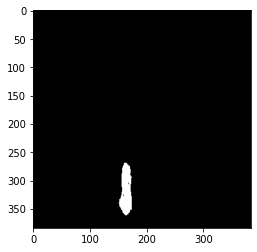

In [ ]:
plt.imshow(data2,cmap='gray')
plt.show() 

# result analysis for coronal

In [ ]:
SAVE_PATH = '/content/drive/MyDrive/ThesisProject/processed/test50_coronal/'
smooth=1e-5
def dice(im1, im2):
    intersection = np.logical_and(im1, im2)

    return (2. * (intersection.sum())+smooth) / (np.sum(im1>0) + np.sum(im2>0)+smooth)

def dice_self(data1,data2):
  num1 = 0
  num2 = 0
  intersection = 0
  for i in range(384):
    for j in range(384):
      if(data1[i,j] == 1):
        num1 = num1+1
        if(data2[i,j] == 1):
          intersection = intersection + 1
      if(data2[i,j] == 1):
        num2 = num2+1
  return 2*intersection/(num1+num2)



def result_analysis(data_path):
  img_names = os.listdir(data_path)
  avg_dice = 0
  n = 0
  for img_name in img_names:
    print(img_name)
    data = cv2.imread(SAVE_PATH + img_name)
    data1 = data[0:384,:,1]
    data2 = data[-384:,:,1]
    
    loss = dice(data1,data2)
    print(loss)
    avg_dice = avg_dice + loss
    n=n+1
  
  avg_dice = avg_dice/n
  print("average dice is {}".format(avg_dice))

def result_analysis_forNormal(data_path):
  img_names = os.listdir(data_path)
  avg_dice = 0
  n = 0
  for img_name in img_names:
    print(img_name)
    data = cv2.imread(SAVE_PATH + img_name)
    data1 = data[0:384,:,1]
    data2 = data[-384:,:,1]
    
    loss = dice(data1,data2)
    if(loss==1)or(loss<0.05):
      continue
    print(loss)
    avg_dice = avg_dice + loss
    n=n+1
  
  avg_dice = avg_dice/n
  print("average dice is {}".format(avg_dice))

In [ ]:
result_analysis(SAVE_PATH)

1_batch_0_0_pred.jpg
1.0
2_batch_0_1_pred.jpg
1.0
3_batch_0_2_pred.jpg
1.0
4_batch_0_3_pred.jpg
1.0
5_batch_0_4_pred.jpg
1.0
6_batch_0_5_pred.jpg
1.0
7_batch_0_6_pred.jpg
1.0
8_batch_0_7_pred.jpg
1.0
9_batch_0_8_pred.jpg
1.0
10_batch_0_9_pred.jpg
1.0
11_batch_0_10_pred.jpg
1.0
12_batch_0_11_pred.jpg
1.0
13_batch_0_12_pred.jpg
1.0
14_batch_0_13_pred.jpg
1.0
15_batch_0_14_pred.jpg
1.0
16_batch_0_15_pred.jpg
1.0
17_batch_0_16_pred.jpg
1.0
18_batch_0_17_pred.jpg
1.0
19_batch_0_18_pred.jpg
1.0
20_batch_0_19_pred.jpg
1.0
21_batch_0_20_pred.jpg
1.0
22_batch_0_21_pred.jpg
1.0
23_batch_0_22_pred.jpg
1.0
24_batch_0_23_pred.jpg
1.0
25_batch_0_24_pred.jpg
1.0
26_batch_0_25_pred.jpg
1.0
27_batch_0_26_pred.jpg
1.0
28_batch_0_27_pred.jpg
1.0
29_batch_0_28_pred.jpg
1.0
30_batch_0_29_pred.jpg
1.0
31_batch_0_30_pred.jpg
1.0
32_batch_0_31_pred.jpg
1.0
33_batch_1_0_pred.jpg
1.0
34_batch_1_1_pred.jpg
1.0
35_batch_1_2_pred.jpg
1.0
36_batch_1_3_pred.jpg
1.0
37_batch_1_4_pred.jpg
1.0
38_batch_1_5_pred.jpg
1.0

In [ ]:
result_analysis_forNormal(SAVE_PATH)

1_batch_0_0_pred.jpg
2_batch_0_1_pred.jpg
3_batch_0_2_pred.jpg
4_batch_0_3_pred.jpg
5_batch_0_4_pred.jpg
6_batch_0_5_pred.jpg
7_batch_0_6_pred.jpg
8_batch_0_7_pred.jpg
9_batch_0_8_pred.jpg
10_batch_0_9_pred.jpg
11_batch_0_10_pred.jpg
12_batch_0_11_pred.jpg
13_batch_0_12_pred.jpg
14_batch_0_13_pred.jpg
15_batch_0_14_pred.jpg
16_batch_0_15_pred.jpg
17_batch_0_16_pred.jpg
18_batch_0_17_pred.jpg
19_batch_0_18_pred.jpg
20_batch_0_19_pred.jpg
21_batch_0_20_pred.jpg
22_batch_0_21_pred.jpg
23_batch_0_22_pred.jpg
24_batch_0_23_pred.jpg
25_batch_0_24_pred.jpg
26_batch_0_25_pred.jpg
27_batch_0_26_pred.jpg
28_batch_0_27_pred.jpg
29_batch_0_28_pred.jpg
30_batch_0_29_pred.jpg
31_batch_0_30_pred.jpg
32_batch_0_31_pred.jpg
33_batch_1_0_pred.jpg
34_batch_1_1_pred.jpg
35_batch_1_2_pred.jpg
36_batch_1_3_pred.jpg
37_batch_1_4_pred.jpg
38_batch_1_5_pred.jpg
39_batch_1_6_pred.jpg
40_batch_1_7_pred.jpg
41_batch_1_8_pred.jpg
42_batch_1_9_pred.jpg
43_batch_1_10_pred.jpg
44_batch_1_11_pred.jpg
45_batch_1_12_pre

# Evaluate

In [ ]:
evaluate(SAVE_MODEL_PATH+'/'+'unet-2021-12-30T17-25-25.576254-step-29.tar',SAVE_PATH,train=False)
# for resnet 50 axial test 1

we can delete data of dataset for saving RAM
length of test scans is 734
No.1:  7.575757001836591e-08
No.2:  1.0
No.3:  1.0
No.4:  1.0
No.5:  1.0
No.6:  1.0
No.7:  1.0
No.8:  1.0
No.9:  1.0
No.10:  1.0
No.11:  1.0
No.12:  1.0
No.13:  1.0
No.14:  1.0
No.15:  1.0
No.16:  1.0
No.17:  1.0
No.18:  4.9999750001249995e-06
No.19:  1.0
No.20:  1.0
No.21:  1.0
No.22:  1.0
No.23:  1.0
No.24:  1.0
No.25:  1.0
No.26:  1.0
No.27:  1.0
No.28:  1.0
No.29:  1.0
No.30:  1.0
No.31:  1.0
No.32:  1.0
No.33:  1.0
No.34:  1.0
No.35:  1.0
No.36:  1.0
No.37:  1.0
No.38:  1.0
No.39:  1.0
No.40:  1.0
No.41:  1.0
No.42:  1.0
No.43:  1.0
No.44:  1.0
No.45:  1.0
No.46:  1.0
No.47:  1.0
No.48:  1.0
No.49:  1.0
No.50:  1.0
No.51:  1.0
No.52:  1.0
No.53:  1.0
No.54:  1.0
No.55:  1.0
No.56:  1.0
No.57:  1.0
No.58:  1.0
No.59:  1.0
No.60:  1.0
No.61:  1.0
No.62:  1.0
No.63:  1.0
No.64:  1.0
No.65:  1.0
No.66:  1.0
No.67:  1.0
No.68:  1.0
No.69:  1.0
No.70:  1.0
No.71:  1.0
No.72:  1.0
No.73:  1.0
No.74:  1.0
No.75:  1.0

In [ ]:
evaluate(SAVE_MODEL_PATH+'/'+'unet-2021-12-30T17-25-25.576254-step-29.tar',SAVE_PATH,train=False)
# for resnet 50 axial test 2

we can delete data of dataset for saving RAM
length of test scans is 670
No.1:  1.2499984375019533e-06
No.2:  1.0
No.3:  1.0
No.4:  1.0
No.5:  1.0
No.6:  1.0
No.7:  1.0
No.8:  1.0
No.9:  1.0
No.10:  1.0
No.11:  1.0
No.12:  1.1363635072314196e-07
No.13:  8.333332638888948e-08
No.14:  9.9999990000001e-08
No.15:  5.208333062065987e-08
No.16:  4.97512413059084e-08
No.17:  4.5662098371593685e-08
No.18:  4.6948354603363636e-08
No.19:  3.9999998400000067e-08
No.20:  3.0120481020467445e-08
No.21:  2.2779042761297436e-08
No.22:  2.2779042761297436e-08
No.23:  2.1459227007312727e-08
No.24:  1.9841269447593863e-08
No.25:  1.808318231314318e-08
No.26:  1.7241379013079675e-08
No.27:  1.6611295405127984e-08
No.28:  1.6474464308493176e-08
No.29:  1.9011406482672882e-08
No.30:  2.99401188640683e-08
No.31:  1.0204080591420348e-07
No.32:  1.99999960000008e-07
No.33:  1.2987011300388145e-07
No.34:  1.612902965660812e-07
No.35:  2.1276591217746549e-07
No.36:  9.523808616780132e-08
No.37:  1.13636350723141

In [ ]:
evaluate(SAVE_MODEL_PATH+'/'+'unet-2022-01-06T00-00-28.274763-step-34.tar',SAVE_PATH,train=False)
# resnet 34 test 2

we can delete data of dataset for saving RAM
length of test scans is 670
No.1:  3.3333222222592593e-06
No.2:  1.0
No.3:  1.0
No.4:  1.0
No.5:  1.0
No.6:  1.0
No.7:  1.0
No.8:  1.0
No.9:  1.0
No.10:  1.0
No.11:  1.0
No.12:  1.0
No.13:  1.0
No.14:  1.0
No.15:  1.0
No.16:  1.9999960000080004e-06
No.17:  1.6666638888935187e-06
No.18:  1.88679209683168e-07
No.19:  2.2222217283951715e-07
No.20:  2.6315782548478277e-07
No.21:  2.777777006173054e-07
No.22:  2.3809518140590918e-07
No.23:  1.6666663888889353e-07
No.24:  8.264462126903957e-08
No.25:  4.587155752882764e-08
No.26:  3.4246574169637875e-08
No.27:  3.389830393565072e-08
No.28:  3.584229262214005e-08
No.29:  4.08163248646398e-08
No.30:  4.97512413059084e-08
No.31:  1.2820511176857542e-07
No.32:  1.4492751522789636e-07
No.33:  1.0101009080706154e-07
No.34:  1.0752687015840106e-07
No.35:  9.259258401920519e-08
No.36:  8.771929055093942e-08
No.37:  8.84955673897728e-08
No.38:  7.751937383570747e-08
No.39:  6.578946935595596e-08
No.40:  6.

In [ ]:
evaluate(SAVE_MODEL_PATH+'/'+'unet-2022-01-06T00-00-28.274763-step-34.tar',SAVE_PATH,train=False)
# resnet 34 test 1

we can delete data of dataset for saving RAM
length of test scans is 734
No.1:  1.0
No.2:  1.0
No.3:  1.0
No.4:  1.0
No.5:  1.0
No.6:  1.0
No.7:  1.0
No.8:  1.0
No.9:  1.0
No.10:  1.0
No.11:  1.0
No.12:  1.0
No.13:  9.090900826453795e-07
No.14:  1.3333331555555792e-07
No.15:  7.575757001836591e-08
No.16:  3.3444814934956026e-08
No.17:  1.8832391359088678e-08
No.18:  1.9762845459232306e-08
No.19:  2.4154588788536506e-08
No.20:  1.7889087336510067e-08
No.21:  2.1786491900076432e-08
No.22:  1.9607842752787398e-08
No.23:  2.0964360147497692e-08
No.24:  2.463054126525761e-08
No.25:  2.5641024983563467e-08
No.26:  2.8011203697165168e-08
No.27:  2.8818442973531907e-08
No.28:  2.597402529937597e-08
No.29:  3.194888076840637e-08
No.30:  2.36406613796534e-08
No.31:  3.174603073822125e-08
No.32:  1.0
No.33:  1.0
No.34:  9.99999000001e-07
No.35:  1.0
No.36:  1.0
No.37:  1.0
No.38:  8.84955673897728e-08
No.39:  7.936507306626405e-08
No.40:  1.1904760487528514e-07
No.41:  9.99999000001e-07
No.42:  3

In [ ]:
evaluate(SAVE_MODEL_PATH+'/'+'unet-2021-12-29T23-55-17.490702-step-33.tar',SAVE_PATH,train=False)
# test 1 for prob

we can delete data of dataset for saving RAM
length of test scans is 734
No.1:  1.0
No.2:  1.0
No.3:  1.0
No.4:  1.0
No.5:  1.0
No.6:  1.0
No.7:  1.0
No.8:  1.0
No.9:  1.0
No.10:  1.0
No.11:  1.0
No.12:  1.0
No.13:  1.0
No.14:  1.0
No.15:  1.0
No.16:  1.0
No.17:  1.0
No.18:  1.0
No.19:  1.0
No.20:  1.0
No.21:  1.0
No.22:  1.0
No.23:  1.0
No.24:  1.0
No.25:  1.0
No.26:  1.0
No.27:  1.0
No.28:  1.0
No.29:  1.0
No.30:  1.0
No.31:  1.0
No.32:  1.0
No.33:  1.0
No.34:  1.0
No.35:  1.0
No.36:  1.0
No.37:  1.0
No.38:  1.0
No.39:  1.0
No.40:  1.0
No.41:  1.0
No.42:  1.0
No.43:  1.0
No.44:  1.0
No.45:  1.0
No.46:  1.0
No.47:  1.0
No.48:  1.0
No.49:  1.0
No.50:  1.0
No.51:  1.0
No.52:  1.0
No.53:  1.0
No.54:  1.0
No.55:  1.0
No.56:  1.0
No.57:  1.0
No.58:  1.0
No.59:  1.0
No.60:  1.0
No.61:  1.0
No.62:  1.0
No.63:  1.0
No.64:  1.0
No.65:  1.0
No.66:  1.0
No.67:  1.0
No.68:  1.0
No.69:  1.0
No.70:  1.0
No.71:  1.0
No.72:  1.0
No.73:  1.0
No.74:  1.0
No.75:  1.0
No.76:  1.0
No.77:  1.0
No.78:  1.0


In [ ]:
evaluate(SAVE_MODEL_PATH+'/'+'unet-2021-12-29T23-55-17.490702-step-33.tar',SAVE_PATH,train=False)
# test 2 for prob

we can delete data of dataset for saving RAM
length of test scans is 670
No.1:  1.7241376337693735e-07
No.2:  1.0
No.3:  1.0
No.4:  1.0
No.5:  1.0
No.6:  1.0
No.7:  1.0
No.8:  1.0
No.9:  1.0
No.10:  1.0
No.11:  1.0
No.12:  1.0
No.13:  1.0
No.14:  1.0
No.15:  1.0
No.16:  1.0
No.17:  1.0
No.18:  1.0
No.19:  1.0
No.20:  1.0
No.21:  1.0
No.22:  1.0101009080706154e-07
No.23:  3.787878644398537e-08
No.24:  3.8461536982248583e-08
No.25:  3.4602074927263847e-08
No.26:  3.55871873456517e-08
No.27:  2.9325512336495244e-08
No.28:  3.7313431443528686e-08
No.29:  6.134968948774911e-08
No.30:  3.8461523668644745e-07
No.31:  1.0
No.32:  1.0
No.33:  1.0
No.34:  1.0
No.35:  1.0
No.36:  1.0
No.37:  1.0
No.38:  1.0
No.39:  1.0
No.40:  1.0
No.41:  1.0
No.42:  1.4285693877580176e-06
No.43:  3.2258054110305127e-07
No.44:  3.1249990234378054e-07
No.45:  1.0869564035916953e-07
No.46:  2.8571420408165597e-07
No.47:  1.0
No.48:  1.4285693877580176e-06
No.49:  1.4285693877580176e-06
No.50:  1.0989009781427497e-0

In [ ]:
evaluate(SAVE_MODEL_PATH+'/'+'unet-2022-01-04T21-55-07.318714-step-18.tar',SAVE_PATH,train=False)
# final prob test 1

In [ ]:
evaluate(SAVE_MODEL_PATH+'/'+'unet-2022-01-04T21-55-07.318714-step-18.tar',SAVE_PATH,train=False)
# final prob test 2

In [ ]:
evaluate(SAVE_MODEL_PATH+'/'+'unet-2022-01-04T21-55-07.318714-step-18.tar',SAVE_PATH,train=False)
# final test 1

we can delete data of dataset for saving RAM
length of test scans is 734
No.1:  1.0
No.2:  9.9999990000001e-08
No.3:  1.492537090666106e-07
No.4:  5.347593296920145e-08
No.5:  5.4945051926096054e-08
No.6:  3.7037023319620994e-07
No.7:  5.555552469137518e-07
No.8:  2.8571420408165597e-07
No.9:  4.97512413059084e-08
No.10:  3.1055899656649085e-08
No.11:  4.9019605440215425e-08
No.12:  2.4999937500156254e-06
No.13:  1.0
No.14:  3.3333222222592593e-06
No.15:  2.499999937500002e-08
No.16:  2.0283975247789553e-08
No.17:  7.633587203542962e-08
No.18:  5.7803464866851745e-08
No.19:  3.3333222222592593e-06
No.20:  1.0
No.21:  1.0
No.22:  1.0
No.23:  1.0
No.24:  1.0
No.25:  1.0
No.26:  1.0
No.27:  1.0
No.28:  1.4285693877580176e-06
No.29:  2.4999993750001564e-07
No.30:  1.063829674060673e-07
No.31:  3.333332222222593e-07
No.32:  1.0
No.33:  1.6666638888935187e-06
No.34:  1.0
No.35:  1.0
No.36:  1.0
No.37:  2.9411756055365867e-07
No.38:  1.5384613017751845e-07
No.39:  7.692301775152482e-07
No.40:

In [ ]:
evaluate(SAVE_MODEL_PATH+'/'+'unet-2022-01-04T21-55-07.318714-step-18.tar',SAVE_PATH,train=False)
# final test 2

we can delete data of dataset for saving RAM
length of test scans is 670
No.1:  1.0
No.2:  1.0
No.3:  1.0
No.4:  1.0
No.5:  1.0
No.6:  1.0
No.7:  1.0
No.8:  1.0
No.9:  1.0
No.10:  1.0
No.11:  1.0
No.12:  1.0
No.13:  1.0
No.14:  1.0
No.15:  1.0
No.16:  1.0
No.17:  1.0
No.18:  1.0
No.19:  1.0
No.20:  1.0
No.21:  1.0
No.22:  1.0
No.23:  1.0
No.24:  1.9999960000080004e-06
No.25:  1.0
No.26:  1.0
No.27:  1.0
No.28:  1.0
No.29:  1.0
No.30:  3.3333222222592593e-06
No.31:  1.0
No.32:  1.0
No.33:  1.0
No.34:  1.0
No.35:  1.0
No.36:  1.0
No.37:  1.0
No.38:  1.0
No.39:  1.0
No.40:  8.333326388894677e-07
No.41:  1.9999960000080004e-06
No.42:  3.1249990234378054e-07
No.43:  1.0
No.44:  1.0
No.45:  1.0
No.46:  1.0
No.47:  9.99999000001e-07
No.48:  1.0
No.49:  1.0
No.50:  1.0
No.51:  1.0
No.52:  1.0
No.53:  1.0
No.54:  1.0
No.55:  1.0
No.56:  1.0
No.57:  1.0
No.58:  1.0
No.59:  1.0
No.60:  1.0
No.61:  1.0
No.62:  1.0
No.63:  5.882349480970894e-07
No.64:  0.7157895036011049
No.65:  0.9152542420760316


In [ ]:
#aux_params=dict(pooling='max',dropout=0.5,classes=1,)

# prepare model
model = smp.Unet(
    encoder_name="resnet50",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_depth=5,
    encoder_weights=None,  # use `imagenet` pre-trained weights for encoder initialization
    decoder_channels = (256, 128, 64, 32, 16),
    in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,  # model output channels (number of classes in your dataset)
    activation='sigmoid',#relu
    #aux_params=aux_params
)


optimizer = optim.Adam(model.parameters(), lr=1e-4)
device = 'cuda:0'
model.to(device)
from torchsummary import summary
result, params_info = summary(model, input_size=(1, 384, 384))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 192, 192]           3,136
       BatchNorm2d-2         [-1, 64, 192, 192]             128
              ReLU-3         [-1, 64, 192, 192]               0
         MaxPool2d-4           [-1, 64, 96, 96]               0
            Conv2d-5           [-1, 64, 96, 96]           4,096
       BatchNorm2d-6           [-1, 64, 96, 96]             128
              ReLU-7           [-1, 64, 96, 96]               0
            Conv2d-8           [-1, 64, 96, 96]          36,864
       BatchNorm2d-9           [-1, 64, 96, 96]             128
             ReLU-10           [-1, 64, 96, 96]               0
           Conv2d-11          [-1, 256, 96, 96]          16,384
      BatchNorm2d-12          [-1, 256, 96, 96]             512
           Conv2d-13          [-1, 256, 96, 96]          16,384
      BatchNorm2d-14          [-1, 256,

TypeError: ignored

we can get npz
we can get train_data


# result analysis

In [ ]:
# SAVE_PATH = '/content/drive/MyDrive/ThesisProject/processed/test50/'
smooth=1e-5
def dice(im1, im2):
    intersection = np.logical_and(im1, im2)

    return (2. * (intersection.sum())+smooth) / (np.sum(im1>0) + np.sum(im2>0)+smooth)

def dice_self(data1,data2):
  num1 = 0
  num2 = 0
  intersection = 0
  for i in range(384):
    for j in range(384):
      if(data1[i,j] == 1):
        num1 = num1+1
        if(data2[i,j] == 1):
          intersection = intersection + 1
      if(data2[i,j] == 1):
        num2 = num2+1
  return 2*intersection/(num1+num2)



def result_analysis(data_path):
  img_names = os.listdir(data_path)
  avg_dice = 0
  n = 0
  for img_name in img_names:
    print(img_name)
    data = cv2.imread(SAVE_PATH + img_name)
    data1 = data[0:384,:,1]
    data2 = data[-384:,:,1]
    
    loss = dice(data1,data2)
    print(loss)
    avg_dice = avg_dice + loss
    n=n+1
  
  avg_dice = avg_dice/n
  print("average dice is {}".format(avg_dice))

def result_analysis_forNormal(data_path):
  img_names = os.listdir(data_path)
  avg_dice = 0
  n = 0
  for img_name in img_names:
    print(img_name)
    data = cv2.imread(SAVE_PATH + img_name)
    data1 = data[0:384,:,1]
    data2 = data[-384:,:,1]
    
    loss = dice(data1,data2)
    if(loss==1)or(loss<0.05):
      continue
    print(loss)
    avg_dice = avg_dice + loss
    n=n+1
  
  avg_dice = avg_dice/n
  print("average dice is {}".format(avg_dice))


In [ ]:
# for test
SAVE_PATH = '/content/drive/MyDrive/ThesisProject/processed/test50/'
data = cv2.imread(SAVE_PATH + '19_batch_0_18_pred.jpg')
data1 = data[0:384,:,1]
data2 = data[-384:,:,1]
intersection = np.logical_and(data1, data2)
intersection

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
inter_sum = 2. *intersection.sum()
inter_sum

0.0

In [ ]:
data1_sum = np.sum(data1>0)
data1_sum

0

In [ ]:
data2_sum = np.sum(data2>0)
data2_sum

0

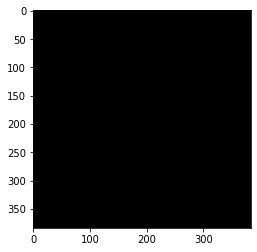

In [ ]:
plt.imshow(data1,cmap='gray')
plt.show() 

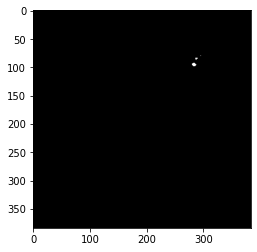

In [ ]:
plt.imshow(data2,cmap='gray')
plt.show() 

In [ ]:
np.set_printoptions(threshold=np.inf)
data1

In [ ]:
max2 = np.max(data1)
max2

2

In [ ]:
result_analysis(SAVE_PATH)#test 50

5_batch_0_4_pred.jpg
1.0
2_batch_0_1_pred.jpg
1.0
7_batch_0_6_pred.jpg
1.0
8_batch_0_7_pred.jpg
1.0
10_batch_0_9_pred.jpg
1.0
4_batch_0_3_pred.jpg
1.0
6_batch_0_5_pred.jpg
1.0
1_batch_0_0_pred.jpg
1.3850415320631368e-08
9_batch_0_8_pred.jpg
1.0
3_batch_0_2_pred.jpg
1.0
11_batch_0_10_pred.jpg
1.0
15_batch_0_14_pred.jpg
1.0
13_batch_0_12_pred.jpg
1.0
14_batch_0_13_pred.jpg
1.0
12_batch_0_11_pred.jpg
1.0
16_batch_0_15_pred.jpg
1.0
17_batch_0_16_pred.jpg
1.0
18_batch_0_17_pred.jpg
1.0
19_batch_0_18_pred.jpg
1.0
20_batch_0_19_pred.jpg
1.0
21_batch_0_20_pred.jpg
1.0
22_batch_0_21_pred.jpg
1.0
23_batch_0_22_pred.jpg
1.0
24_batch_0_23_pred.jpg
1.0
25_batch_0_24_pred.jpg
7.092198078567512e-08
26_batch_0_25_pred.jpg
3.7037023319620994e-07
27_batch_0_26_pred.jpg
1.855287535152365e-08
29_batch_0_28_pred.jpg
1.0
28_batch_0_27_pred.jpg
1.492537090666106e-07
30_batch_0_29_pred.jpg
1.0
31_batch_0_30_pred.jpg
1.0
32_batch_0_31_pred.jpg
1.0
33_batch_1_0_pred.jpg
1.0
34_batch_1_1_pred.jpg
1.0
36_batch_1_

In [ ]:
result_analysis_forNormal(SAVE_PATH)# test 50

5_batch_0_4_pred.jpg
2_batch_0_1_pred.jpg
7_batch_0_6_pred.jpg
8_batch_0_7_pred.jpg
10_batch_0_9_pred.jpg
4_batch_0_3_pred.jpg
6_batch_0_5_pred.jpg
1_batch_0_0_pred.jpg
9_batch_0_8_pred.jpg
3_batch_0_2_pred.jpg
11_batch_0_10_pred.jpg
15_batch_0_14_pred.jpg
13_batch_0_12_pred.jpg
14_batch_0_13_pred.jpg
12_batch_0_11_pred.jpg
16_batch_0_15_pred.jpg
17_batch_0_16_pred.jpg
18_batch_0_17_pred.jpg
19_batch_0_18_pred.jpg
20_batch_0_19_pred.jpg
21_batch_0_20_pred.jpg
22_batch_0_21_pred.jpg
23_batch_0_22_pred.jpg
24_batch_0_23_pred.jpg
25_batch_0_24_pred.jpg
26_batch_0_25_pred.jpg
27_batch_0_26_pred.jpg
29_batch_0_28_pred.jpg
28_batch_0_27_pred.jpg
30_batch_0_29_pred.jpg
31_batch_0_30_pred.jpg
32_batch_0_31_pred.jpg
33_batch_1_0_pred.jpg
34_batch_1_1_pred.jpg
36_batch_1_3_pred.jpg
35_batch_1_2_pred.jpg
37_batch_1_4_pred.jpg
38_batch_1_5_pred.jpg
39_batch_1_6_pred.jpg
40_batch_1_7_pred.jpg
41_batch_1_8_pred.jpg
42_batch_1_9_pred.jpg
43_batch_1_10_pred.jpg
44_batch_1_11_pred.jpg
45_batch_1_12_pre

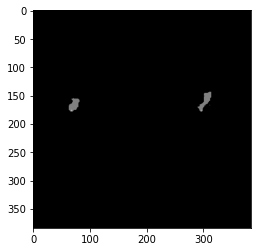

In [ ]:
SAVE_PATH = '/content/drive/MyDrive/ThesisProject/processed/test50/'
data = cv2.imread(SAVE_PATH + '349_batch_10_28_pred.jpg')
# data1 = data[0:384,:,1]
data2 = data[-384:,:,1]
plt.imshow(data2,cmap='gray')
plt.show() 

In [ ]:
max = np.max(data)
max

2

In [ ]:
whos

Variable       Type        Data/Info
------------------------------------
DataLoader     type        <class 'torch.utils.data.dataloader.DataLoader'>
Dataset        type        <class 'torch.utils.data.dataset.Dataset'>
Image          module      <module 'PIL.Image' from <...>t-packages/PIL/Image.py'>
SAVE_PATH      str         /content/drive/MyDrive/Th<...>Project/processed/test50/
cv2            module      <module 'cv2.cv2' from '/<...>37m-x86_64-linux-gnu.so'>
data           ndarray     768x384x3: 884736 elems, type `uint8`, 884736 bytes (864.0 kb)
data1          ndarray     384x384: 147456 elems, type `uint8`, 147456 bytes (144.0 kb)
data2          ndarray     384x384: 147456 elems, type `uint8`, 147456 bytes (144.0 kb)
datetime       type        <class 'datetime.datetime'>
drive          module      <module 'google.colab.dri<...>s/google/colab/drive.py'>
imageio        module      <module 'imageio' from '/<...>ges/imageio/__init__.py'>
join           function    <function join at

In [ ]:
SAVE_PATH = '/content/drive/MyDrive/ThesisProject/processed/test34/'
result_analysis(SAVE_PATH)

1_batch_0_0_pred.jpg
2.777777006173054e-07
2_batch_0_1_pred.jpg
1.0
3_batch_0_2_pred.jpg
1.0
4_batch_0_3_pred.jpg
1.0
5_batch_0_4_pred.jpg
1.0
6_batch_0_5_pred.jpg
1.0
7_batch_0_6_pred.jpg
1.0
8_batch_0_7_pred.jpg
1.0
9_batch_0_8_pred.jpg
1.0
10_batch_0_9_pred.jpg
1.0
11_batch_0_10_pred.jpg
1.0
12_batch_0_11_pred.jpg
1.0
13_batch_0_12_pred.jpg
1.0
14_batch_0_13_pred.jpg
1.0
15_batch_0_14_pred.jpg
1.0
16_batch_0_15_pred.jpg
1.0
17_batch_0_16_pred.jpg
1.0
18_batch_0_17_pred.jpg
1.0
19_batch_0_18_pred.jpg
1.0
20_batch_0_19_pred.jpg
1.0
21_batch_0_20_pred.jpg
1.0
22_batch_0_21_pred.jpg
1.0
23_batch_0_22_pred.jpg
1.0
24_batch_0_23_pred.jpg
1.0
25_batch_0_24_pred.jpg
1.0
26_batch_0_25_pred.jpg
1.0
27_batch_0_26_pred.jpg
1.0
28_batch_0_27_pred.jpg
1.0
29_batch_0_28_pred.jpg
1.0
30_batch_0_29_pred.jpg
1.0
31_batch_0_30_pred.jpg
1.0
32_batch_0_31_pred.jpg
1.0
33_batch_1_0_pred.jpg
1.0
34_batch_1_1_pred.jpg
1.0
35_batch_1_2_pred.jpg
1.0
36_batch_1_3_pred.jpg
1.0
37_batch_1_4_pred.jpg
1.0
38_batc

In [ ]:
intersection = np.logical_and(data, data)
result =  2. * 255 * intersection.sum() / (data.sum() + data.sum())
print(data.sum())

In [ ]:
import matplotlib.pyplot as plt
SAVE_PATH = '/content/drive/MyDrive/ThesisProject/processed/sigmoid/'
data = cv2.imread(SAVE_PATH + '1_batch_0_0_pred.jpg')
data = data[:,:,1]

data1 = data[0:256,:]
data2 = data[256:,:]

plt.imshow(data1)


TypeError: ignored

In [ ]:
plt.imshow(data)

In [ ]:

test = dice_self(data,data)
print(test)


In [ ]:
num = 0
for i in range(256):
  for j in range(256):
    if(data2[i,j] == 1):
      data2[i,j] = 0
      num = num+1
print(num)

In [ ]:
data.shape

# Evaluate for 3 axis

In [ ]:
images, annotations = load_npz(DATA_PATH)

In [ ]:
DATA_PATH_axial = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/full_axial_uint_reg020.npz'
SAVE_PATH_Allaxis = '/content/drive/MyDrive/ThesisProject/processed/Allaxis'
SAVE_MODEL_PATH_axial = '/content/drive/MyDrive/ThesisProject/processed'

DATA_PATH_sagittal = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz'
SAVE_MODEL_PATH_sagittal = '/content/drive/MyDrive/ThesisProject/processed/sagittal'

DATA_PATH_coronal = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz'
SAVE_MODEL_PATH_coronal = '/content/drive/MyDrive/ThesisProject/processed/coronal'


def evaluateAxial(DATA_PATH_axial, save_path_axial,save_path_sagittal,save_path_coronal, train=False):
    ck_axial = torch.load(save_path_axial)
    # prepare model
    model_axial = smp.Unet(
        encoder_name="resnet50",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_depth=5,
        encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
        decoder_channels = (256, 128, 64, 32, 16),
        in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,  # model output channels (number of classes in your dataset)
        activation='sigmoid'#relu
    )
    model_axial.load_state_dict(ck_axial)
    model_axial.eval()

    # prepare data
    images, annotations = load_npz(DATA_PATH_axial)

    test_data_axial = MyDataset(images, annotations, start=15420, end=-1)
    test_loader_axial = test_data_axial.get_loader(shuffle=False)
    del test_data_axial
    gc.collect()
    device = 'cuda:0'
    model_axial.to(device)
    loader_axial = test_loader_axial
    info = 'test      '
    num = len(loader_axial.dataset)
    print(num)
    temp1 = np.zeros([num,384,384], dtype=np.float16)
    numForSave=0
    for i, batch in enumerate(loader_axial):
        input, gt = batch
        input = input.to(device)
        input = input.unsqueeze(1)
        pred_axial = model_axial.predict(input)
        # print(pred.shape)
        pred_axial = pred_axial.squeeze(1)
        pred_value_axial = pred_axial.cpu().numpy()

        for j in range(pred_value_axial.shape[0]):
            #path = join(save_path_axial, '{}_batch_{}_{}_pred.jpg'.format(numForSave, i, j))
            temp1[numForSave,:,:] = pred_value_axial[j]
            numForSave = numForSave+1
            #cv2.imwrite(path, img)

    return temp1,num

def evaluateSagittal(num,DATA_PATH_sagittal, save_path_axial,save_path_sagittal,save_path_coronal, train=False):
    ck_sagittal = torch.load(save_path_sagittal)
    # prepare model
    model_sagittal = smp.Unet(
        encoder_name="resnet50",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_depth=5,
        encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
        decoder_channels = (256, 128, 64, 32, 16),
        in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,  # model output channels (number of classes in your dataset)
        activation='sigmoid'#relu
    )
    model_sagittal.load_state_dict(ck_sagittal)
    model_sagittal.eval()

    # prepare data
    images, annotations = load_npz(DATA_PATH_sagittal)

    test_data_sagittal = MyDataset(images, annotations, start=13056, end=13823)
    test_loader_sagittal = test_data_sagittal.get_loader(shuffle=False)
    del test_data_sagittal
    gc.collect()
    device = 'cuda:0'
    model_sagittal.to(device)
    loader_sagittal = test_loader_sagittal
    info = 'test      '
    numS = len(loader_sagittal.dataset)
    print(numS)
    temp1 = np.zeros([num,384,384], dtype=np.float16)
    numForSave=0
    for i, batch in enumerate(loader_sagittal):
        input, gt = batch
        input = input.to(device)
        input = input.unsqueeze(1)
        pred_sagittal = model_sagittal.predict(input)
        # print(pred.shape)
        pred_sagittal = pred_sagittal.squeeze(1)
        pred_value_sagittal = pred_sagittal.cpu().numpy()

        for j in range(pred_value_sagittal.shape[0]):
            #path = join(save_path_axial, '{}_batch_{}_{}_pred.jpg'.format(numForSave, i, j))
            #tempxx2[:,:,100][-384:] = np.where(tempxx1 > tempxx2[:,:,100][-384:], tempxx1, tempxx2[:,:,100][-384:])
            if(numForSave%2 == 0):
              temp1[:,:,int(numForSave/2)][:384] = pred_value_sagittal[j]
              print(int(numForSave/2)) 
              numForSave = numForSave+1

            else:
              numForSave = numForSave-1
              temp1[:,:,int(numForSave/2)][-384:] = np.where(pred_value_sagittal[j] > temp1[:,:,int(numForSave/2)][-384:], pred_value_sagittal[j], temp1[:,:,int(numForSave/2)][-384:])
              #temp2_2[:,:,numForSave][-384:] = pred_value_sagittal[j]
              print(int(numForSave/2)) 
              numForSave = numForSave+2
              #print(numForSave)

    return temp1

def evaluateCoronal(num,DATA_PATH_coronal, save_path_axial,save_path_sagittal,save_path_coronal, train=False):
    ck_coronal = torch.load(save_path_coronal)
    # prepare model
    model_coronal = smp.Unet(
        encoder_name="resnet50",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_depth=5,
        encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
        decoder_channels = (256, 128, 64, 32, 16),
        in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,  # model output channels (number of classes in your dataset)
        activation='sigmoid'#relu
    )
    model_coronal.load_state_dict(ck_coronal)
    model_coronal.eval()

    # prepare data
    images, annotations = load_npz(DATA_PATH_coronal)

    test_data_coronal = MyDataset(images, annotations, start=13056, end=13823)
    test_loader_coronal = test_data_coronal.get_loader(shuffle=False)
    del test_data_coronal
    gc.collect()
    device = 'cuda:0'
    model_coronal.to(device)
    loader_coronal = test_loader_coronal
    info = 'test      '
    numC = len(loader_coronal.dataset)
    print(numC)
    temp1 = np.zeros([num,384,384], dtype=np.float16)
    numForSave=0
    for i, batch in enumerate(loader_coronal):
        input, gt = batch
        input = input.to(device)
        input = input.unsqueeze(1)
        pred_coronal = model_coronal.predict(input)
        # print(pred.shape)
        pred_coronal = pred_coronal.squeeze(1)
        pred_value_coronal = pred_coronal.cpu().numpy()

        for j in range(pred_value_coronal.shape[0]):
            #path = join(save_path_axial, '{}_batch_{}_{}_pred.jpg'.format(numForSave, i, j))
            #tempxx2[:,:,100][-384:] = np.where(tempxx1 > tempxx2[:,:,100][-384:], tempxx1, tempxx2[:,:,100][-384:])
            if(numForSave%2 == 0):
              temp1[:,int(numForSave/2),:][:384] = pred_value_coronal[j]
              print(int(numForSave/2)) 
              numForSave = numForSave+1

            else:
              numForSave = numForSave-1
              temp1[:,int(numForSave/2),:][-384:] = np.where(pred_value_coronal[j] > temp1[:,int(numForSave/2),:][-384:], pred_value_coronal[j], temp1[:,int(numForSave/2),:][-384:])
              #temp2_2[:,:,numForSave][-384:] = pred_value_sagittal[j]
              print(int(numForSave/2)) 
              numForSave = numForSave+2
              #print(numForSave)

    return temp1

    
def evaluateAll():

    temp1,num = evaluateAxial(DATA_PATH_axial, SAVE_MODEL_PATH_axial+'/'+'unet-2021-11-14T18-42-14.661451.tar',
            SAVE_MODEL_PATH_sagittal+'/'+'unet-2021-11-16T19-54-20.610486.tar',
            SAVE_MODEL_PATH_coronal+'/'+'unet-2021-11-17T17-30-47.051055.tar',
            SAVE_PATH_Allaxis)
    temp2 = evaluateSagittal(num,DATA_PATH_sagittal, SAVE_MODEL_PATH_axial+'/'+'unet-2021-11-14T18-42-14.661451.tar',
            SAVE_MODEL_PATH_sagittal+'/'+'unet-2021-11-16T19-54-20.610486.tar',
            SAVE_MODEL_PATH_coronal+'/'+'unet-2021-11-17T17-30-47.051055.tar',
            SAVE_PATH_Allaxis)
    temp3 = evaluateCoronal(num,DATA_PATH_coronal, SAVE_MODEL_PATH_axial+'/'+'unet-2021-11-14T18-42-14.661451.tar',
            SAVE_MODEL_PATH_sagittal+'/'+'unet-2021-11-16T19-54-20.610486.tar',
            SAVE_MODEL_PATH_coronal+'/'+'unet-2021-11-17T17-30-47.051055.tar',
            SAVE_PATH_Allaxis)
    return temp1,temp2,temp3



temp1,temp2,temp3 = evaluateAll()

    # temp = np.append(temp,image[0:384])
    # temp = np.append(temp,image[-384:])

        
#         # pred[pred >= 0.5] = 1
#         # pred[pred < 0.5] = 0
#         # gt_masks = gt.cpu().numpy()
#         # pred_masks = pred.cpu().numpy()
       
#         # for j in range(pred.shape[0]):
#         #     numForSave=numForSave+1
#         #     path = join(save_path_axial, '{}_batch_{}_{}_pred.jpg'.format(numForSave, i, j))
#         #     img = np.concatenate([gt_masks[j], pred_masks[j]])
#         #     cv2.imwrite(path, img)
            
#             # print("prediction saved to {}".format(path))

# #evaluate(SAVE_MODEL_PATH+'/'+'unet-2021-11-16T19-54-20.610486.tar',SAVE_PATH,train=False)           



# temp,temp1,temp2,temp3 = evaluateAll(images, annotations, SAVE_MODEL_PATH_axial+'/'+'unet-2021-11-14T18-42-14.661451.tar',
#             SAVE_MODEL_PATH_sagittal+'/'+'unet-2021-11-16T19-54-20.610486.tar',
#             SAVE_MODEL_PATH_coronal+'/'+'unet-2021-11-17T17-30-47.051055.tar',
#             SAVE_PATH_Allaxis)

# temp = evaluateAll(SAVE_MODEL_PATH_axial+'/'+'unet-2021-11-14T18-42-14.661451.tar',
#             SAVE_MODEL_PATH_sagittal+'/'+'unet-2021-11-16T19-54-20.610486.tar',
#             SAVE_MODEL_PATH_coronal+'/'+'unet-2021-11-17T17-30-47.051055.tar',
#             SAVE_PATH_Allaxis)

In [ ]:
# np.save("/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/nii/0907eval", readytonii)
np.save("/content/drive/MyDrive/ThesisProject/processed/Allaxis/axial", temp1)
np.save("/content/drive/MyDrive/ThesisProject/processed/Allaxis/sagittal", temp2)
np.save("/content/drive/MyDrive/ThesisProject/processed/Allaxis/coronal", temp3)
# np.save(temp1,temp2,temp3)

In [ ]:
temp1 = np.load("/content/drive/MyDrive/ThesisProject/processed/Allaxis/axial.npy")
temp2 = np.load("/content/drive/MyDrive/ThesisProject/processed/Allaxis/sagittal.npy")
temp3 = np.load("/content/drive/MyDrive/ThesisProject/processed/Allaxis/coronal.npy")

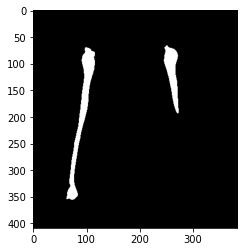

In [ ]:
plt.imshow(temp3[:,158,:].astype(np.uint8),cmap = 'gray')
plt.show()

In [ ]:
whos

In [ ]:
# this code is combined three axials
result_final = np.where(temp1 > temp2, temp1, temp2)
result_final = np.where(result_final > temp2, result_final, temp2)

In [ ]:
# this code is only combined 2 axials
result_final = np.where(temp1 > temp3, temp1, temp3)

In [ ]:
np.save("/content/drive/MyDrive/ThesisProject/processed/Allaxis/409finalFor1and3axial", result_final)

In [ ]:
np.save("/content/drive/MyDrive/ThesisProject/processed/Allaxis/409out", resultOut)

In [ ]:
def predictOut(pred):
  pred[pred >= 0.5] = 1
  pred[pred < 0.5] = 0
  pred = pred.astype(np.uint8)
  return pred

smooth=1e-5
def dice(im1, im2):
    intersection = np.logical_and(im1, im2)

    return (2. * (intersection.sum())+smooth) / (np.sum(im1>0) + np.sum(im2>0)+smooth)

def dice_self(data1,data2):
  num1 = 0
  num2 = 0
  intersection = 0
  for i in range(384):
    for j in range(384):
      if(data1[i,j] == 1):
        num1 = num1+1
        if(data2[i,j] == 1):
          intersection = intersection + 1
      if(data2[i,j] == 1):
        num2 = num2+1
  return 2*intersection/(num1+num2)



def result_analysis(pred,gt):
  avg_dice = 0
  n = 0
  for j in range(pred.shape[0]):
    data1 = pred[j]
    data2 = gt[j]
    
    print(n)
    loss = dice(data1,data2)
    print(loss)
    avg_dice = avg_dice + loss
    n=n+1
  
  avg_dice = avg_dice/n
  print("average dice is {}".format(avg_dice))

def result_analysis_forNormal(pred,gt):
  avg_dice = 0
  n = 0
  m = 0
  for j in range(pred.shape[0]):
    data1 = pred[j]
    data2 = gt[j]
    
    loss = dice(data1,data2)
    print(m)
    m=m+1
    if((loss == 1) or loss<0.05):
      continue
    
    print(loss)
    avg_dice = avg_dice + loss
    n = n+1
  
  avg_dice = avg_dice/n
  print("average dice is {}".format(avg_dice))



In [ ]:
import SimpleITK as sitk
resultOut = predictOut(result_final)
readytonii = resultOut

readytonii = readytonii.astype(np.int16)
nii = sitk.GetImageFromArray(readytonii)

sitk.WriteImage(nii,'/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/nii/409oneAxis1Out.nii')

In [ ]:
import SimpleITK as sitk

out = sitk.GetImageFromArray(annotations[-409:])
sitk.WriteImage(out,'/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/nii/409Gt.nii')

In [ ]:


img,gt = load_npz('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_uint020.npz')
out = sitk.GetImageFromArray(img[-409:])
sitk.WriteImage(out,'/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/nii/img20Crop.nii')

In [ ]:
whos

In [ ]:
#this is for 1 axials
resultOut = predictOut(temp1)
result_analysis_forNormal(resultOut,annotations[-409:])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
0.823529418252595
79
0.6303030415059685
80
0.662131526935793
81
0.729874781218698
82
0.8353741518996713
83
0.8545034658833318
84
0.8680765370787862
85
0.8128249582944111
86
0.7928902643516981
87
0.8068259398851472
88
0.8024096397445203
89
0.7915742805345106
90
0.8211716350402279
91
0.8617121361161234
92
0.8772413798747521
93
0.8846846852041229
94
0.8861646239660042
95
0.8875379944093008
96
0.8819982778553046
97
0.8915555560375308
98
0.8984841529697557
99
0.8693630875436397
100
0.8545627383338272
101
0.8631578954227674
102
0.8892508149334918
103
0.8935912944764735
104
0.8995463389530374
105
0.8890356678399229
106
0.8442677280035273
107
0.816161617399585
108
0.8340548352521296
109
0.8653386464913255
110
0.8920985565667072
111
0.8835978846243573
112
0.88419117753500

In [ ]:
#this is for 2 axials
resultOut = predictOut(result_final)
result_analysis_forNormal(resultOut,annotations[-409:])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
0.21722847907811837
78
0.3876923171124259
79
0.3933975324154397
80
0.42874252181146677
81
0.4894514821787818
82
0.5889792268384894
83
0.6440677994829072
84
0.7058823551038063
85
0.7641633744126259
86
0.8193939404885215
87
0.8413325813589352
88
0.8325459326375542
89
0.8173220516808261
90
0.8361904769705214
91
0.8594594600925248
92
0.8838852102256722
93
0.8950131238188401
94
0.8911827961669557
95
0.8897468902198761
96
0.8826291084821635
97
0.8930150314190316
98
0.8979405038995857
99
0.8682385581681065
100
0.8525367479727987
101
0.8585657377561468
102
0.8881720436119782
103
0.8978873245429148
104
0.905778895064203
105
0.885139520537706
106
0.8375733865781253
107
0.8109187762255741
108
0.8210227285438727
109
0.8464536255147808
110
0.8701406131502017
111
0.86153846272189

In [ ]:
#this is for 3 axials
resultOut = predictOut(result_final)
result_analysis_forNormal(resultOut,annotations[-409:])


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
0.25000007211537767
78
0.823529418252595
79
0.6547619150368478
80
0.6726457472500953
81
0.7308377944592194
82
0.8342391326869683
83
0.843181819963843
84
0.840975611307555
85
0.8316831697055844
86
0.8598265906081893
87
0.8554610866222296
88
0.8333333343114241
89
0.8152173923086011
90
0.830784914216183
91
0.8649155728662495
92
0.8798165143127682
93
0.8871910117429617
94
0.8891797561554111
95
0.8901384087796782
96
0.8831615125293749
97
0.8923349583857555
98
0.8978470000098625
99
0.8685555045584973
100
0.8529411771682106
101
0.8597104350488746
102
0.8864981178779014
103
0.8950471704301464
104
0.89867841473456
105
0.8779857980762699
106
0.8308489965596306
107
0.7981651389373189
108
0.8050139289344433
109
0.8334612445628454
110
0.8545897656004081
111
0.8484848497602285
11

In [ ]:
# this is for three axials
result_analysis(resultOut,annotations[-409:])

0
1.0
1
1.0
2
1.0
3
1.0
4
1.0
5
1.0
6
1.0
7
1.0
8
1.0
9
1.0
10
1.2499984375019533e-06
11
1.0
12
1.0
13
1.0
14
1.0
15
3.9999984000006404e-07
16
1.6666638888935187e-06
17
1.1111098765445817e-06
18
1.923076553254509e-07
19
9.615383690828492e-08
20
8.474575553002072e-08
21
1.3513511687363285e-07
22
1.4492751522789636e-07
23
2.8571420408165597e-07
24
3.2258054110305127e-07
25
4.5454524793397825e-07
26
2.4999937500156254e-06
27
1.0
28
1.0
29
1.0
30
1.0
31
1.0
32
1.0
33
1.0
34
1.0
35
1.0
36
1.0
37
1.0
38
1.0
39
1.0
40
1.0
41
1.0
42
1.0
43
1.0
44
1.0
45
1.0
46
1.0
47
1.0
48
1.0
49
1.0
50
1.0
51
1.2499984375019533e-06
52
3.95256901373245e-08
53
5.555552469137518e-07
54
1.0
55
1.0
56
1.0
57
1.0
58
1.0
59
1.0
60
1.0
61
1.0
62
1.0
63
1.0
64
1.0
65
1.0
66
1.0
67
1.0
68
1.0
69
1.0
70
1.0
71
1.0
72
1.0
73
1.0
74
1.0
75
1.0
76
1.0
77
0.25000007211537767
78
0.823529418252595
79
0.6547619150368478
80
0.6726457472500953
81
0.7308377944592194
82
0.8342391326869683
83
0.843181819963843
84
0.840975611307555

In [ ]:
# this is for two axials
result_analysis(resultOut,annotations[-409:])

0
1.0
1
1.0
2
1.0
3
1.0
4
1.0
5
1.0
6
1.0
7
1.0
8
1.0
9
1.0
10
1.2499984375019533e-06
11
1.0
12
1.0
13
1.0
14
1.0
15
3.9999984000006404e-07
16
1.6666638888935187e-06
17
1.1111098765445817e-06
18
1.923076553254509e-07
19
9.615383690828492e-08
20
8.474575553002072e-08
21
1.3513511687363285e-07
22
1.4492751522789636e-07
23
2.8571420408165597e-07
24
3.2258054110305127e-07
25
4.5454524793397825e-07
26
2.4999937500156254e-06
27
1.0
28
1.0
29
1.0
30
1.0
31
1.0
32
1.0
33
1.0
34
1.0
35
1.0
36
1.0
37
1.0
38
1.0
39
1.0
40
1.0
41
1.0
42
1.0
43
1.0
44
1.0
45
1.0
46
1.0
47
1.0
48
1.0
49
1.0
50
1.0
51
1.2499984375019533e-06
52
3.95256901373245e-08
53
5.555552469137518e-07
54
1.0
55
1.0
56
1.0
57
1.0
58
1.0
59
1.0
60
2.4999937500156254e-06
61
1.1111098765445817e-06
62
5.555552469137518e-07
63
3.2258054110305127e-07
64
2.2222217283951715e-07
65
1.5624997558594132e-07
66
1.1363635072314196e-07
67
8.474575553002072e-08
68
7.042253025193449e-08
69
5.747126106487006e-08
70
4.545454338842985e-08
71
3.731343

In [ ]:
# this is for one axials
result_analysis(resultOut,annotations[-409:])

0
1.0
1
1.0
2
1.0
3
1.0
4
1.0
5
1.0
6
1.0
7
1.0
8
1.0
9
1.0
10
1.2499984375019533e-06
11
1.0
12
1.0
13
1.0
14
1.0
15
3.9999984000006404e-07
16
1.6666638888935187e-06
17
1.1111098765445817e-06
18
1.923076553254509e-07
19
9.615383690828492e-08
20
8.474575553002072e-08
21
1.3513511687363285e-07
22
1.4492751522789636e-07
23
2.8571420408165597e-07
24
3.2258054110305127e-07
25
4.5454524793397825e-07
26
2.4999937500156254e-06
27
1.0
28
1.0
29
1.0
30
1.0
31
1.0
32
1.0
33
1.0
34
1.0
35
1.0
36
1.0
37
1.0
38
1.0
39
1.0
40
1.0
41
1.0
42
1.0
43
1.0
44
1.0
45
1.0
46
1.0
47
1.0
48
1.0
49
1.0
50
1.0
51
1.2499984375019533e-06
52
3.95256901373245e-08
53
5.555552469137518e-07
54
1.0
55
1.0
56
1.0
57
1.0
58
1.0
59
1.0
60
1.0
61
1.0
62
1.0
63
1.0
64
1.0
65
1.0
66
1.0
67
1.0
68
1.0
69
1.0
70
1.0
71
1.0
72
1.0
73
1.0
74
1.0
75
1.0
76
1.0
77
1.0989009781427497e-07
78
0.823529418252595
79
0.6303030415059685
80
0.662131526935793
81
0.729874781218698
82
0.8353741518996713
83
0.8545034658833318
84
0.8680765370787

In [ ]:
# np.where(condition, x, y)
# np.where(a > b, a, b)
# 满足条件(condition)，输出x，不满足输出y。

result_final = np.where(temp1 > temp2, temp1, temp2)
result_final = np.where(result_final > temp2, result_final, temp2)

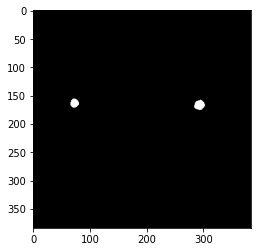

In [ ]:
plt.imshow(predictOut(temp1)[317],cmap='gray')
plt.show()

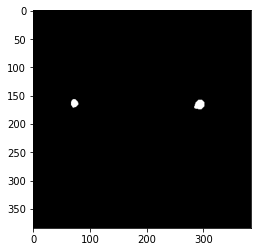

In [ ]:

plt.imshow(annotations[-409:][317],cmap='gray')
plt.show()

In [ ]:
test = (int)(1/2)
test

0

In [ ]:
tempxx2 = np.zeros([409,384,384], dtype=np.uint8)

tempxx1 = np.ones([384,384])

tempxx2[:,:,100][-384:] = np.where(temp[1] > tempxx2[:,:,100][-384:], temp[1], tempxx2[:,:,100][-384:])
# np.where(a > b, a, b)

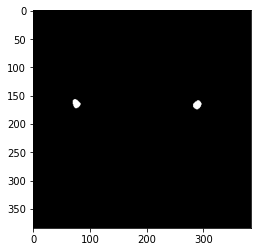

In [ ]:
plt.imshow(resultOut[300],cmap='gray')
plt.show()

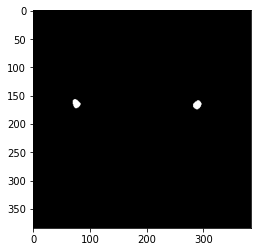

In [ ]:
plt.imshow(predictOut(temp1)[300],cmap='gray')
plt.show()

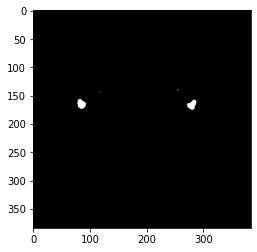

In [ ]:
plt.imshow(predictOut(temp2)[250],cmap='gray')
plt.show()

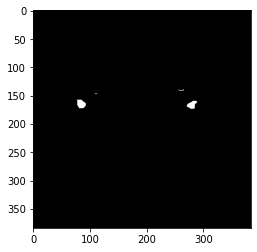

In [ ]:
plt.imshow(predictOut(temp3)[250],cmap='gray')
plt.show()

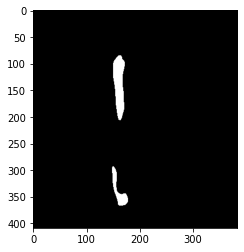

In [ ]:
#[:,:,int(numForSave/2)][:384]
test33 = predictOut(temp2)
plt.imshow(test33[:,:,100],cmap='gray')
plt.show()

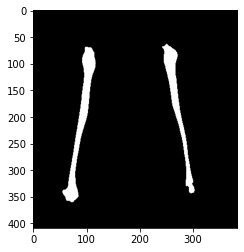

In [ ]:
plt.imshow(predictOut(temp3)[:,160,:],cmap='gray')
plt.show()

In [ ]:
max = test33.max()
max

1

In [ ]:
np.set_printoptions(threshold=np.inf)
test33

In [ ]:
maxPos = np.argwhere(temp2>=0.5)
maxPos


In [ ]:
temp2[:,:,100][:384] = temp[1]

In [ ]:
whos

Variable                   Type        Data/Info
------------------------------------------------
DATA_PATH                  str         /content/drive/MyDrive/Th<...>ull_axial_uint_reg020.npz
DATA_PATH_axial            str         /content/drive/MyDrive/Th<...>ull_axial_uint_reg020.npz
DATA_PATH_coronal          str         /content/drive/MyDrive/Th<...>rop_coronal_uint1to20.npz
DATA_PATH_sagittal         str         /content/drive/MyDrive/Th<...>op_sagittal_uint1to20.npz
DataLoader                 type        <class 'torch.utils.data.dataloader.DataLoader'>
Dataset                    type        <class 'torch.utils.data.dataset.Dataset'>
DiceLoss                   type        <class '__main__.DiceLoss'>
DiceLoss2                  type        <class '__main__.DiceLoss2'>
DiceLoss3                  type        <class '__main__.DiceLoss3'>
F                          module      <module 'torch.nn.functio<...>/torch/nn/functional.py'>
MyDataset                  type        <class '__main_

# 3D visualization

In [ ]:
path = '/content/drive/MyDrive/ThesisProject/processed/test50'

path_list = os.listdir(path)

        
path_list = sorted(path_list, key = lambda x:os.path.getmtime(os.path.join(path, x)))

print(path_list)

['1_batch_0_0_pred.jpg', '2_batch_0_1_pred.jpg', '3_batch_0_2_pred.jpg', '4_batch_0_3_pred.jpg', '5_batch_0_4_pred.jpg', '6_batch_0_5_pred.jpg', '7_batch_0_6_pred.jpg', '8_batch_0_7_pred.jpg', '9_batch_0_8_pred.jpg', '10_batch_0_9_pred.jpg', '11_batch_0_10_pred.jpg', '12_batch_0_11_pred.jpg', '13_batch_0_12_pred.jpg', '14_batch_0_13_pred.jpg', '15_batch_0_14_pred.jpg', '16_batch_0_15_pred.jpg', '17_batch_0_16_pred.jpg', '18_batch_0_17_pred.jpg', '19_batch_0_18_pred.jpg', '20_batch_0_19_pred.jpg', '21_batch_0_20_pred.jpg', '22_batch_0_21_pred.jpg', '23_batch_0_22_pred.jpg', '24_batch_0_23_pred.jpg', '25_batch_0_24_pred.jpg', '26_batch_0_25_pred.jpg', '27_batch_0_26_pred.jpg', '28_batch_0_27_pred.jpg', '29_batch_0_28_pred.jpg', '30_batch_0_29_pred.jpg', '31_batch_0_30_pred.jpg', '32_batch_0_31_pred.jpg', '33_batch_1_0_pred.jpg', '34_batch_1_1_pred.jpg', '35_batch_1_2_pred.jpg', '36_batch_1_3_pred.jpg', '37_batch_1_4_pred.jpg', '38_batch_1_5_pred.jpg', '39_batch_1_6_pred.jpg', '40_batch_1

In [ ]:
path = '/content/drive/MyDrive/ThesisProject/processed/test50/'
readytonii = np.zeros((409,384,384))
temp3 = np.zeros((409,384,384))
n = 0
for filename in path_list:
    temp3 = cv2.imread(path+filename, 0)[-384:,:]#this only predict part
    readytonii[n] = temp3
    #readytonii[n][:,:,:3] = (255,48,48) 
    #readytonii[n] = cv2.imread(path+filename, 0)
    n = n+1
    if n==500:
      break

In [ ]:
readytonii = readytonii.transpose(1,2,0)
#zxy to xyz

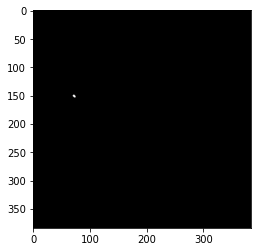

In [ ]:

plt.imshow(readytonii[400].astype(np.uint8),cmap='gray')
plt.show() 

In [ ]:
max = readytonii.min()
max

48.0

In [ ]:
import nibabel as nib
import numpy as np


new_image = nib.Nifti1Image(readytonii, affine=np.eye(4)).to_filename('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/nii/test50Axial')

In [ ]:
%whos

In [ ]:
import SimpleITK as sitk

readytonii = readytonii.astype(np.int16)
nii = sitk.GetImageFromArray(np.transpose(readytonii,(0,1,2,3)), isVector=True)


sitk.WriteImage(nii, '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/nii/evaluateGrayNewaxis.nii')

In [ ]:
import SimpleITK as sitk

out = sitk.GetImageFromArray(readytonii)
sitk.writeImage(out,'/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/nii/evaluateGrayzxy.nii.gz')

In [ ]:
np.save("/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/nii/0907eval", readytonii)

In [ ]:
import SimpleITK as sitk
save_dicom_path = '/content/drive/MyDrive/ThesisProject/dataset/dicom/'

n = 0
for filename in path_list:
    img = sitk.GetImageFromArray(cv2.imread(path+filename, 0)[-256:,:])
    #path = join(save_path, '{}_{}_{}_pred.jpg'.format(info, i, j))
    if n < 10:
      sitk.WriteImage(img, save_dicom_path+"00{}.dcm".format(n))
    if n>=10 and n<100:
      sitk.WriteImage(img, save_dicom_path+"0{}.dcm".format(n))
    if n>=100 and n<1000:
      sitk.WriteImage(img, save_dicom_path+"{}.dcm".format(n))
    n = n+1
    if n==500:
      break


In [ ]:
import SimpleITK as sitk
img = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_uint020.npz')['img']
img = sitk.GetImageFromArray(img)

sitk.WriteImage(img, '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/nii/img020.nii')

# export

In [ ]:
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_test_equal_halfmirror_test_uint020.npz'

data = np.load(DATA_PATH)
images = data['img_crop']
data = images[15]

images = data.astype(np.int16)

shape = images.max
shape


<function ndarray.max>

In [ ]:
import SimpleITK as sitk

nii = sitk.GetImageFromArray(np.transpose(images[:,:,:,np.newaxis],(0,1,2,3)))

sitk.WriteImage(nii, '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/nii/evaluateGrayImage15.nii')

In [ ]:
max = readytonii.max()
max

255

# Dicom export

In [ ]:
import pydicom
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import ExplicitVRLittleEndian
import pydicom._storage_sopclass_uids

image2d = image2d.astype(np.uint16)

print("Setting file meta information...")
# Populate required values for file meta information

meta = pydicom.Dataset()
meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.MRImageStorage
meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian  

ds = Dataset()
ds.file_meta = meta

ds.is_little_endian = True
ds.is_implicit_VR = False

ds.SOPClassUID = pydicom._storage_sopclass_uids.MRImageStorage
ds.PatientName = "Test^Firstname"
ds.PatientID = "123456"

ds.Modality = "MR"
ds.SeriesInstanceUID = pydicom.uid.generate_uid()
ds.StudyInstanceUID = pydicom.uid.generate_uid()
ds.FrameOfReferenceUID = pydicom.uid.generate_uid()

ds.BitsStored = 16
ds.BitsAllocated = 16
ds.SamplesPerPixel = 1
ds.HighBit = 15

ds.ImagesInAcquisition = "1"

ds.Rows = image2d.shape[0]
ds.Columns = image2d.shape[1]
ds.InstanceNumber = 1

ds.ImagePositionPatient = r"0\0\1"
ds.ImageOrientationPatient = r"1\0\0\0\-1\0"
ds.ImageType = r"ORIGINAL\PRIMARY\AXIAL"

ds.RescaleIntercept = "0"
ds.RescaleSlope = "1"
ds.PixelSpacing = r"1\1"
ds.PhotometricInterpretation = "MONOCHROME2"
ds.PixelRepresentation = 1

pydicom.dataset.validate_file_meta(ds.file_meta, enforce_standard=True)

print("Setting pixel data...")
ds.PixelData = image2d.tobytes()

ds.save_as(r"out.dcm")

In [ ]:
# authors : Guillaume Lemaitre <g.lemaitre58@gmail.com>
# license : MIT

import os
import tempfile
import datetime

import pydicom
from pydicom.dataset import FileDataset, FileMetaDataset

# Create some temporary filenames
suffix = '.dcm'
filename_little_endian = tempfile.NamedTemporaryFile(suffix=suffix).name
filename_big_endian = tempfile.NamedTemporaryFile(suffix=suffix).name

print("Setting file meta information...")
# Populate required values for file meta information
file_meta = FileMetaDataset()
file_meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.2'
file_meta.MediaStorageSOPInstanceUID = "1.2.3"
file_meta.ImplementationClassUID = "1.2.3.4"

print("Setting dataset values...")
# Create the FileDataset instance (initially no data elements, but file_meta
# supplied)
ds = FileDataset(filename_little_endian, {},
                 file_meta=file_meta, preamble=b"\0" * 128)

# Add the data elements -- not trying to set all required here. Check DICOM
# standard
ds.PatientName = "Number15"
ds.PatientID = "123456"

# Set the transfer syntax
ds.is_little_endian = True
ds.is_implicit_VR = True

# Set creation date/time
dt = datetime.datetime.now()
ds.ContentDate = dt.strftime('%Y%m%d')
timeStr = dt.strftime('%H%M%S.%f')  # long format with micro seconds
ds.ContentTime = timeStr

print("Writing test file", filename_little_endian)
ds.save_as(filename_little_endian)
print("File saved.")




In [ ]:
import os
import tempfile
import datetime
import pydicom
from pydicom.dataset import FileDataset, FileMetaDataset
def write_dicom(pixel_array,filename):
    """
    INPUTS:
    pixel_array: 2D numpy ndarray.  If pixel_array is larger than 2D, errors.
    filename: string name for the output file.
    """

    ## This code block was taken from the output of a MATLAB secondary
    ## capture.  I do not know what the long dotted UIDs mean, but
    ## this code works.
    file_meta = Dataset()
    file_meta.MediaStorageSOPClassUID = 'Secondary Capture Image Storage'
    file_meta.MediaStorageSOPInstanceUID = '1.3.6.1.4.1.9590.100.1.1.111165684411017669021768385720736873780'
    file_meta.ImplementationClassUID = '1.3.6.1.4.1.9590.100.1.0.100.4.0'
    ds = FileDataset(filename, {},file_meta = file_meta,preamble="\0"*128)
    ds.Modality = 'WSD'
    ds.ContentDate = str(datetime.date.today()).replace('-','')
    ds.ContentTime = str(time.time()) #milliseconds since the epoch
    ds.StudyInstanceUID =  '1.3.6.1.4.1.9590.100.1.1.124313977412360175234271287472804872093'
    ds.SeriesInstanceUID = '1.3.6.1.4.1.9590.100.1.1.369231118011061003403421859172643143649'
    ds.SOPInstanceUID =    '1.3.6.1.4.1.9590.100.1.1.111165684411017669021768385720736873780'
    ds.SOPClassUID = 'Secondary Capture Image Storage'
    ds.SecondaryCaptureDeviceManufctur = 'Python 2.7.3'

    ## These are the necessary imaging components of the FileDataset object.
    ds.SamplesPerPixel = 1
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.PixelRepresentation = 0
    ds.HighBit = 15
    ds.BitsStored = 16
    ds.BitsAllocated = 16
    ds.SmallestImagePixelValue = '\\x00\\x00'
    ds.LargestImagePixelValue = '\\xff\\xff'
    ds.Columns = pixel_array.shape[0]
    ds.Rows = pixel_array.shape[1]
    if pixel_array.dtype != np.uint16:
        pixel_array = pixel_array.astype(np.uint16)
    ds.PixelData = pixel_array.tostring()

    ds.save_as(filename)
    return



In [ ]:
save_dicom_path = '/content/drive/MyDrive/ThesisProject/dataset/dicom/'


for i in range(1):
  write_dicom(readytonii[i], '1.dcm')

TypeError: ignored

In [ ]:
%whos

Variable          Type                          Data/Info
---------------------------------------------------------
DATA_PATH         str                           /content/drive/MyDrive/Th<...>lfmirror_test_uint020.npz
DataLoader        type                          <class 'torch.utils.data.dataloader.DataLoader'>
Dataset           type                          <class 'torch.utils.data.dataset.Dataset'>
FileDataset       type                          <class 'pydicom.dataset.FileDataset'>
FileMetaDataset   type                          <class 'pydicom.dataset.FileMetaDataset'>
cv2               module                        <module 'cv2.cv2' from '/<...>37m-x86_64-linux-gnu.so'>
data              ndarray                       500x256x256: 32768000 elems, type `uint8`, 32768000 bytes (31.25 Mb)
datetime          module                        <module 'datetime' from '<...>b/python3.7/datetime.py'>
drive             module                        <module 'google.colab.dri<...>s/google/cola

# Temp for Thesis data and image

In [ ]:
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz'

mean = np.float32(0.42725)
var = np.float32(0.01891)


data = np.load(DATA_PATH)
images, gt = data['img'], data['seg']

In [ ]:
images_reg = (images-mean)/var

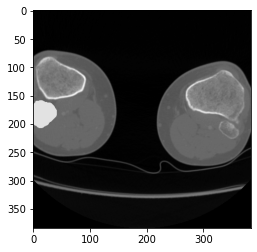

In [ ]:
plt.imshow((images[735]),cmap='gray')
plt.show() 

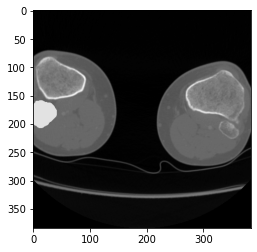

In [ ]:
plt.imshow((images_reg[735]),cmap='gray')
plt.show() 

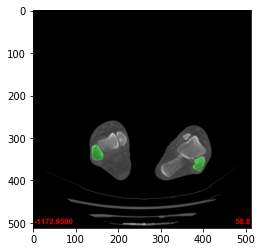

In [ ]:
##read bmp file
bmp_filepath = '/content/drive/MyDrive/ThesisProject/dataset/fibuladata01/test 08 bmp/_Axial+0058.8-000.bmp'
bmp = plt.imread(bmp_filepath)
plt.imshow(bmp)
plt.show()
pos = np.unravel_index(np.argmax(bmp),bmp.shape)

In [ ]:
whos

Variable          Type        Data/Info
---------------------------------------
DATA_PATH         str         /content/drive/MyDrive/Th<...>pz/crop_axial_uint020.npz
DataLoader        type        <class 'torch.utils.data.dataloader.DataLoader'>
Dataset           type        <class 'torch.utils.data.dataset.Dataset'>
DiceLoss          type        <class '__main__.DiceLoss'>
DiceLoss2         type        <class '__main__.DiceLoss2'>
DiceLoss3         type        <class '__main__.DiceLoss3'>
F                 module      <module 'torch.nn.functio<...>/torch/nn/functional.py'>
Image             module      <module 'PIL.Image' from <...>t-packages/PIL/Image.py'>
MyDataset         type        <class '__main__.MyDataset'>
SAVE_MODEL_PATH   str         /content/drive/MyDrive/ThesisProject/processed
SAVE_PATH         str         /content/drive/MyDrive/Th<...>sProject/processed/test50
compute_loss      function    <function compute_loss at 0x7fa2b755e170>
cv2               module      <module 'c

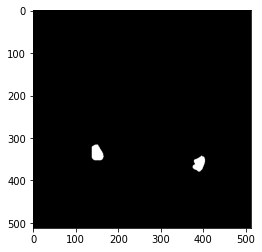

In [ ]:
src=cv2.imread(bmp_filepath)
hsv = cv2.cvtColor(src, cv2.COLOR_BGR2HSV)
low_hsv = np.array([10,10,0])
high_hsv = np.array([360,255,255])
mask = cv2.inRange(hsv,lowerb=low_hsv,upperb=high_hsv)
plt.imshow(mask, cmap='gray')
plt.show()

In [ ]:
SAVE_PATH = '/content/drive/MyDrive/ThesisProject/processed/test50/'
pred3D = np.load(SAVE_PATH+'pred3D.npy')

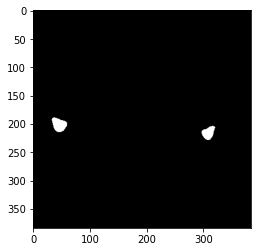

In [ ]:
plt.imshow(pred3D[500], cmap='gray')
plt.show()

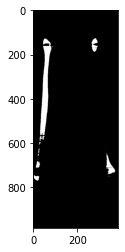

In [ ]:
plt.imshow(pred3D[:,200,:], cmap='gray')
plt.show()

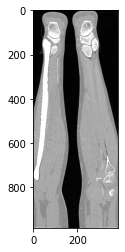

In [ ]:
plt.imshow(images[:983,:,:][:,200,:], cmap='gray')
plt.show()

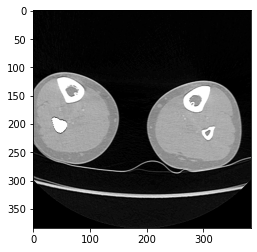

In [ ]:
plt.imshow(images[500], cmap='gray')
plt.show()

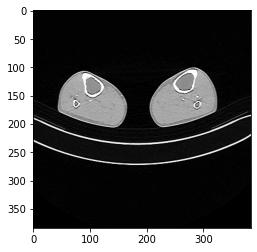

In [ ]:
plt.imshow(images[15420+300], cmap='gray')
plt.show()

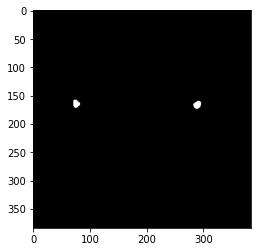

In [ ]:
plt.imshow(gt[15420+300], cmap='gray')
plt.show()

In [ ]:
max = np.min(pred3D[269])
max

0

# 3D export

In [ ]:
import SimpleITK as sitk
readytonii = np.load('/content/drive/MyDrive/ThesisProject/processed/test50/deNoisePred3D_1.npy')

out = sitk.GetImageFromArray(readytonii)

sitk.WriteImage(out,'/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/nii/No1_axial.nii')

In [ ]:
import SimpleITK as sitk
readytonii = np.load('/content/drive/MyDrive/ThesisProject/processed/test50/deNoisePred3D.npy')
out = sitk.GetImageFromArray(readytonii)
sitk.WriteImage(out,'/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/nii/No2_axial_denoise.nii')

In [ ]:
readytonii = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['img'][734:734+670,:,:]
out = sitk.GetImageFromArray(readytonii)
sitk.WriteImage(out,'/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/nii/No2_axial_raw.nii')

In [ ]:
readytonii = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['seg'][734:734+670,:,:]
out = sitk.GetImageFromArray(readytonii)
sitk.WriteImage(out,'/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/nii/No2_axial_gt.nii')

this is for export vtk file

In [ ]:
import SimpleITK as sitk
# readytonii = np.load('/content/drive/MyDrive/ThesisProject/processed/test50/deNoisePred3D_1.npy')
# readytonii = np.load('/content/drive/MyDrive/ThesisProject/final_result/test1_mergeAxis.npy')
readytonii = np.load('/content/drive/MyDrive/ThesisProject/final_result/test1_mergeDA.npy')
out = sitk.GetImageFromArray(readytonii)
# 0.742188\0.742188 0.6 test 2
# 0.642578\0.642578 0.6 test 1
out.SetSpacing((0.642578,0.642578,0.6))

sitk.WriteImage(out,'/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/nii/No1_mergeDA.nii')

In [ ]:
import SimpleITK as sitk
readytonii = np.load('/content/drive/MyDrive/ThesisProject/processed/test50/deNoisePred3D.npy')
out = sitk.GetImageFromArray(readytonii)
sitk.WriteImage(out,'/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/nii/No2_axial_denoise.nii')

In [ ]:
readytonii = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['img'][0:734,:,:]#[734:734+670,:,:]
out = sitk.GetImageFromArray(readytonii)
out.SetSpacing((0.642578,0.642578,0.6))
sitk.WriteImage(out,'/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/nii/No1_axial_raw.nii')

In [ ]:
readytonii = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['seg'][0:734,:,:]
out = sitk.GetImageFromArray(readytonii)
out.SetSpacing((0.642578,0.642578,0.6))
sitk.WriteImage(out,'/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/nii/No1_axial_gt.nii')

this part is for test 2

In [ ]:
import SimpleITK as sitk
# readytonii = np.load('/content/drive/MyDrive/ThesisProject/processed/test50/deNoisePred3D_2.npy')
readytonii = np.load('/content/drive/MyDrive/ThesisProject/final_result/test2_mergeDA.npy')
# readytonii = np.load('/content/drive/MyDrive/ThesisProject/final_result/test2_DA.npy')
out = sitk.GetImageFromArray(readytonii)
# 0.742188\0.742188 0.6 test 2
# 0.642578\0.642578 0.6 test 1
out.SetSpacing((0.742188,0.742188,0.6))

sitk.WriteImage(out,'/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/nii/No2_mergeDA.nii')

In [ ]:
readytonii = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['img'][734:734+670,:,:]#[734:734+670,:,:]
out = sitk.GetImageFromArray(readytonii)
out.SetSpacing((0.742188,0.742188,0.6))
sitk.WriteImage(out,'/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/nii/No2_axial_raw.nii')

In [ ]:
import SimpleITK as sitk
readytonii = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['seg'][734:734+670,:,:]
out = sitk.GetImageFromArray(readytonii)
out.SetSpacing((0.742188,0.742188,0.6))
sitk.WriteImage(out,'/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/nii/No2_axial_gt.nii')

# Loss visualization

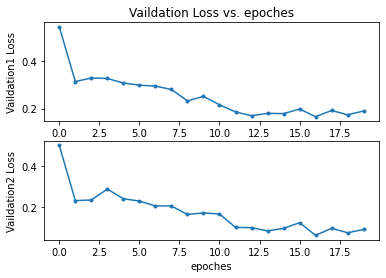

In [ ]:
#定义两个数组
# train_Loss_list = [0.92,0.42,0.33,0.28,0.25,0.21,0.19,0.17,0.16,0.14,0.123,0.121,0.128,0.131,0.114,0.104,0.0878,0.0805,0.0753,0.0709,0.0667,0.0623,0.0589,0.0549,0.0544,0.0492,0.0469,0.0442,0.0435,0.0419]
# Valid1_loss_list = [0.720,0.694,0.814,0.848,0.830,0.847,0.873,0.896,0.908,0.923,0.887,0.887,0.870,0.896,0.921,0.907,0.930,0.903,0.941,0.947,0.919,0.949,0.951,0.944,0.946,0.949,0.945,0.954,0.951,0.955]
# Valid2_loss_list = [0.656,0.642,0.769,0.807,0.781,0.821,0.846,0.891,0.912,0.919,0.889,0.878,0.864,0.890,0.922,0.904,0.931,0.905,0.949,0.956,0.930,0.965,0.961,0.956,0.958,0.964,0.961,0.970,0.965,0.967]

train_Loss_list = [0.871,0.525,0.419,0.363,0.324,0.285,0.262,0.240,0.228,0.205,0.190,0.175,0.158,0.147,0.142,0.134,0.126,0.120,0.117,0.108]
Valid1_loss_list = [0.458,0.687,0.672,0.674,0.693,0.702,0.706,0.720,0.768,0.749,0.784,0.814,0.830,0.820,0.821,0.802,0.834,0.808,0.826,0.810]
Valid2_loss_list = [0.4999,0.7681,0.7654,0.7121,0.75921,0.7706,0.7940,0.7946,0.8357,0.8281,0.8335,0.8983,0.9002,0.9155,0.9034,0.876,0.9372,0.9030,0.9248,0.9087]

for i in range(len(Valid1_loss_list)):
    Valid1_loss_list[i] = 1 - Valid1_loss_list[i]
for i in range(len(Valid2_loss_list)):
    Valid2_loss_list[i] = 1 - Valid2_loss_list[i]
# train_Loss_list.append(train_loss / (len(train_dataset)))
# Accuracy_list.append(100 * train_acc / (len(train_dataset)))

#我这里迭代了200次，所以x的取值范围为(0，200)，然后再将每次相对应的准确率以及损失率附在x上
x1 = range(0, 20)
x2 = range(0, 20)
x3 = range(0, 20)
y1 = train_Loss_list
y2 = Valid1_loss_list
y3 = Valid2_loss_list
#plt.subplot(3, 1, 1)
# plt.plot(x1, y1, 'o-')
# plt.title('Train Loss vs. epoches')
# plt.ylabel('Train Loss')
# plt.xlabel('epoches')

plt.subplot(2, 1, 1)
plt.title('Vaildation Loss vs. epoches')
plt.plot(x2, y2, '.-')
plt.xlabel('epoches')
plt.ylabel('Vaildation1 Loss')
plt.subplot(2, 1, 2)
plt.plot(x3, y3, '.-')
plt.xlabel('epoches')
plt.ylabel('Vaildation2 Loss')
plt.show()
#plt.savefig("accuracy_loss.jpg")


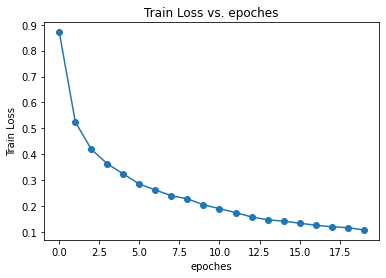

In [ ]:
plt.plot(x1, y1, 'o-')
plt.title('Train Loss vs. epoches')
plt.ylabel('Train Loss')
plt.xlabel('epoches')
plt.show()

# loss distribution

In [ ]:
import statistics
smooth=1e-5
def dice(im1, im2):
  intersection = np.logical_and(im1, im2)

  return (2. * (intersection.sum())+smooth) / (np.sum(im1>0) + np.sum(im2>0)+smooth)

def plotLoss(pred, gt):
  num = 0
  Loss_list = []
  for i in range(pred.shape[0]):
    Loss_list.append(dice(pred[i], gt[i]))
    num = i

  x1 = range(0,num+1)
  print(statistics.mean(Loss_list))
  plt.plot(x1, Loss_list, '.')
  plt.title('Dice score vs. Serial number')
  plt.ylabel('Dice score')
  plt.xlabel('Serial number')
  plt.show()
  
  

In [ ]:
pred = np.load(SAVE_PATH+'/deNoisePred3D_1.npy')
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz'

gt = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['seg'][0:734]



plotLoss(pred, gt)

# No.97:  4.761902494332146e-07
# No.98:  0.16666675347221316

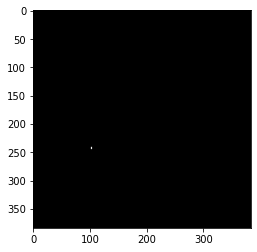

In [ ]:
plt.imshow(pred[97], cmap='gray')
plt.show()

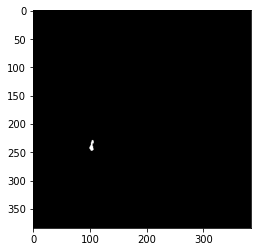

In [ ]:
plt.imshow(gt[97], cmap='gray')
plt.show()

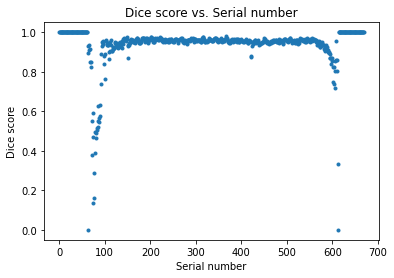

In [ ]:
pred = np.load(SAVE_PATH+'/deNoisePred3D_2.npy')
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz'

gt = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['seg'][734:1404]

# No.613: 0.33333351851846704 No.614: 7.692301775152482e-07
# No.63: 5.882349480970894e-07

plotLoss(pred, gt)

In [ ]:
# No.152:  0.372404558791664
pred[151] = (pred[150] + pred[152])//2
import SimpleITK as sitk

out = sitk.GetImageFromArray(pred)
sitk.WriteImage(out,'/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/nii/No2_axial_denoise.nii')

In [ ]:
np.save( SAVE_PATH+'/deNoisePred3D_2.npy', pred)

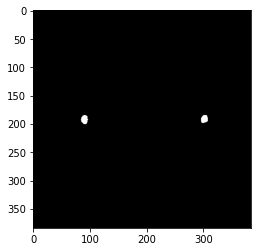

In [ ]:
plt.imshow(pred[151], cmap='gray')
plt.show()

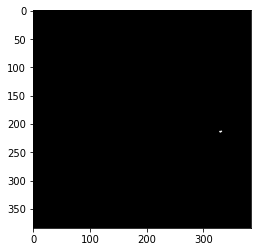

In [ ]:
plt.imshow(gt[613], cmap='gray')
plt.show()

# loss distribution sagittal

In [ ]:
smooth=1e-5
def dice(im1, im2):
  intersection = np.logical_and(im1, im2)

  return (2. * (intersection.sum())+smooth) / (np.sum(im1>0) + np.sum(im2>0)+smooth)

def plotLoss(pred, gt):
  num = 0
  Loss_list = []
  for i in range(pred.shape[0]):
    Loss_list.append(dice(pred[i], gt[i]))
    num = i

  x1 = range(0,num+1)
  plt.plot(x1, Loss_list, '.')
  plt.title('Dice score vs. Serial number')
  plt.ylabel('Dice score')
  plt.xlabel('Serial number')
  plt.show()
  

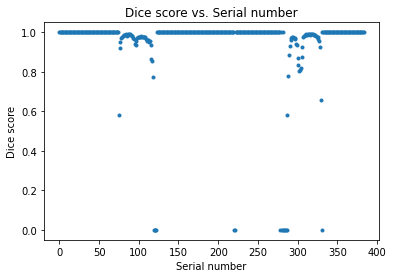

In [ ]:
# 偶数部分
pred = np.load(SAVE_PATH+'/f_pred3D_1.npy')[0:768:2]

DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz'

gt = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz')['seg'][0:768:2]

raw = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz')['img'][0:768:2]

plotLoss(pred, gt)

# No.97:  4.761902494332146e-07
# No.98:  0.16666675347221316

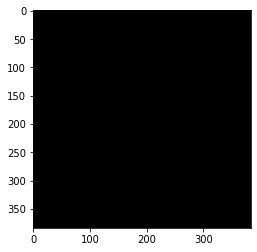

In [ ]:
plt.imshow(pred[118], cmap='gray')
plt.show()

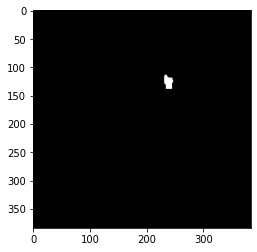

In [ ]:
plt.imshow(gt[118], cmap='gray')
plt.show()

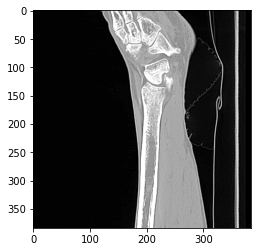

In [ ]:
plt.imshow(raw[118], cmap='gray')
plt.show()

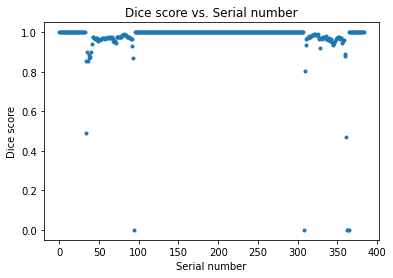

In [ ]:
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz'
pred = np.load(SAVE_PATH+'/f_pred3D_1.npy')[1:768:2]



gt = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz')['seg'][1:768:2]
raw = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz')['img'][1:768:2]


plotLoss(pred, gt)

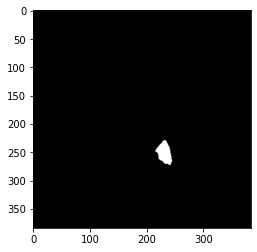

In [ ]:
plt.imshow(pred[45], cmap='gray')
plt.show()

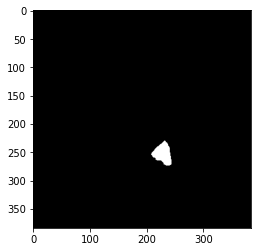

In [ ]:
plt.imshow(gt[45], cmap='gray')
plt.show()

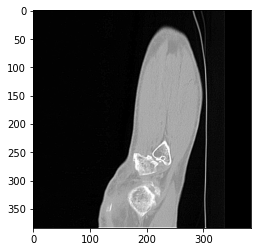

In [ ]:
plt.imshow(raw[45], cmap='gray')
plt.show()

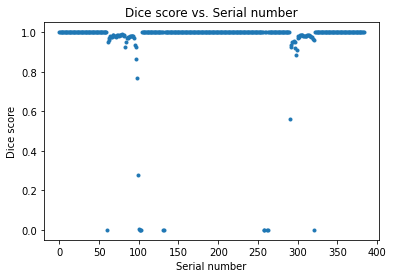

In [ ]:
# 偶数部分
pred = np.load(SAVE_PATH+'/f_pred3D_2.npy')[0:768:2]

DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz'

gt = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz')['seg'][768:1536:2]

raw = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz')['img'][768:1536:2]

plotLoss(pred, gt)

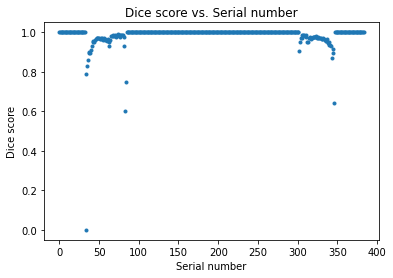

In [ ]:
# 奇数部分
pred = np.load(SAVE_PATH+'/f_pred3D_2.npy')[1:768:2]

DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz'

gt = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz')['seg'][769:1536:2]

raw = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz')['img'][769:1536:2]

plotLoss(pred, gt)

In [ ]:
np.save( SAVE_PATH+'/deNoisePred3D_2.npy', pred)

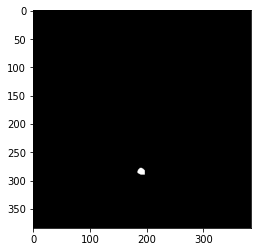

In [ ]:
plt.imshow(pred[40], cmap='gray')
plt.show()

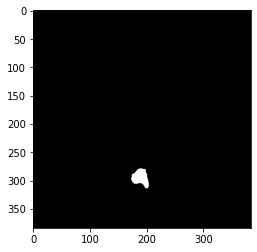

In [ ]:
plt.imshow(gt[40], cmap='gray')
plt.show()

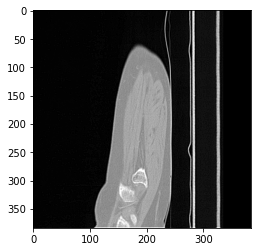

In [ ]:
plt.imshow(raw[40], cmap='gray')
plt.show()

# loss distribution coronal

In [ ]:
smooth=1e-5
def dice(im1, im2):
  intersection = np.logical_and(im1, im2)

  return (2. * (intersection.sum())+smooth) / (np.sum(im1>0) + np.sum(im2>0)+smooth)

def plotLoss(pred, gt):
  num = 0
  Loss_list = []
  for i in range(pred.shape[0]):
    Loss_list.append(dice(pred[i], gt[i]))
    num = i

  x1 = range(0,num+1)
  plt.plot(x1, Loss_list, '.')
  plt.title('Dice score vs. Serial number')
  plt.ylabel('Dice score')
  plt.xlabel('Serial number')
  plt.show()
  

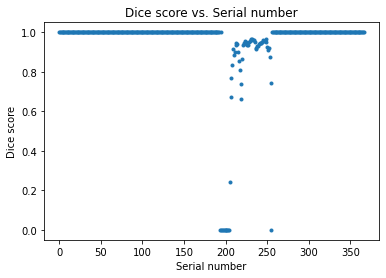

In [ ]:
# 偶数部分
pred = np.load(SAVE_PATH+'/pred3D_1.npy')[0:768:2]

DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz'

gt = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz')['seg'][0:768:2]

raw = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz')['img'][0:768:2]

plotLoss(pred, gt)


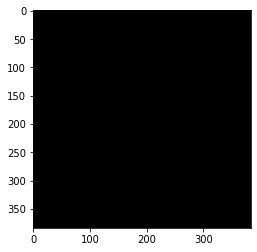

In [ ]:
plt.imshow(pred[118], cmap='gray')
plt.show()

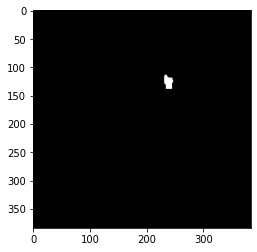

In [ ]:
plt.imshow(gt[118], cmap='gray')
plt.show()

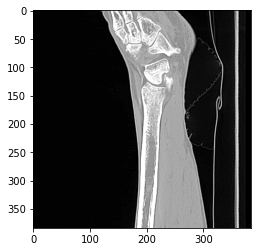

In [ ]:
plt.imshow(raw[118], cmap='gray')
plt.show()

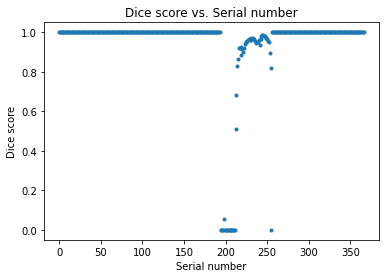

In [ ]:


pred = np.load(SAVE_PATH+'/pred3D_1.npy')[1:768:2]

DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz'

gt = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz')['seg'][1:768:2]

raw = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz')['img'][1:768:2]

plotLoss(pred, gt)

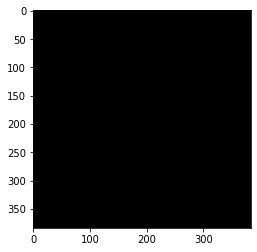

In [ ]:
plt.imshow(pred[200], cmap='gray')
plt.show()

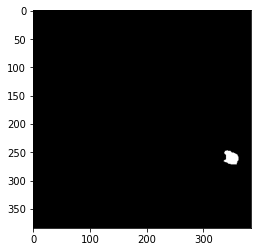

In [ ]:
plt.imshow(gt[200], cmap='gray')
plt.show()

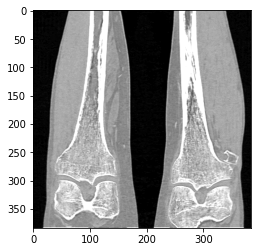

In [ ]:
plt.imshow(raw[200], cmap='gray')
plt.show()

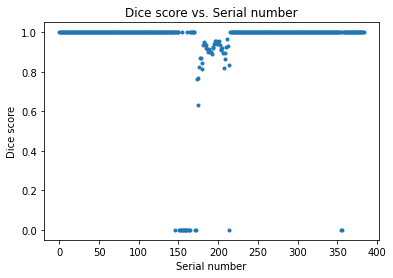

In [ ]:
# 偶数部分
pred = np.load(SAVE_PATH+'/pred3D_2.npy')[0:768:2]

DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz'

gt = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz')['seg'][768:1536:2]

raw = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz')['img'][768:1536:2]

plotLoss(pred, gt)

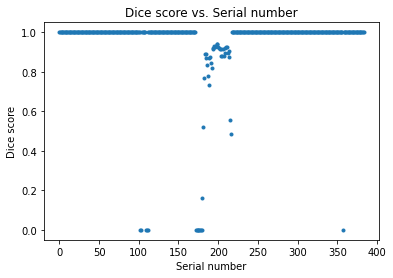

In [ ]:
# 奇数部分
pred = np.load(SAVE_PATH+'/pred3D_2.npy')[1:768:2]

DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz'

gt = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz')['seg'][769:1536:2]

raw = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz')['img'][769:1536:2]

plotLoss(pred, gt)

In [ ]:
np.save( SAVE_PATH+'/deNoisePred3D_2.npy', pred)

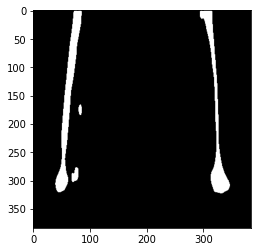

In [ ]:
plt.imshow(pred[200], cmap='gray')
plt.show()

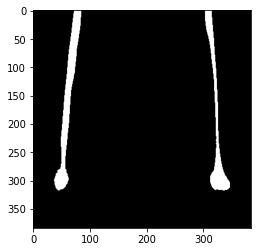

In [ ]:
plt.imshow(gt[200], cmap='gray')
plt.show()

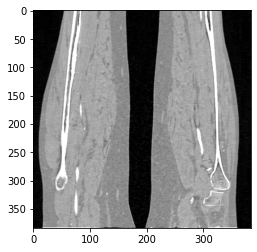

In [ ]:
plt.imshow(raw[200], cmap='gray')
plt.show()

# loss distribution axial

In [ ]:
import statistics
smooth=1e-5
def dice(im1, im2):
  intersection = np.logical_and(im1, im2)

  return (2. * (intersection.sum())+smooth) / (np.sum(im1>0) + np.sum(im2>0)+smooth)

def plotLoss(pred, gt):
  num = 0
  Loss_list = []
  for i in range(pred.shape[0]):
    Loss_list.append(dice(pred[i], gt[i]))
    num = i

  x1 = range(0,num+1)
  print(statistics.mean(Loss_list))
  plt.plot(x1, Loss_list, '.')
  plt.title('Dice score vs. Serial number')
  plt.ylabel('Dice score')
  plt.xlabel('Serial number')
  plt.show()
  

0.8628065258494588


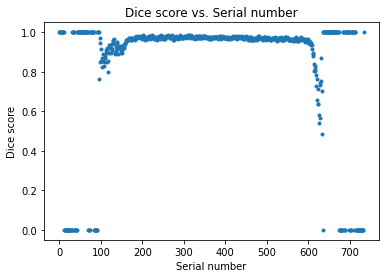

In [ ]:
SAVE_PATH+'/f_pred3D_1.npy'
# pred = np.load('/content/drive/MyDrive/ThesisProject/processed/test50/f_NoisePred3D_1.npy')
pred = np.load(SAVE_PATH+'/f_pred3D_1.npy')

DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz'

gt = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['seg'][0:734]

raw = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['img'][0:734]

plotLoss(pred, gt)


In [ ]:
plt.imshow(pred[118], cmap='gray')
plt.show()

In [ ]:
plt.imshow(gt[118], cmap='gray')
plt.show()

In [ ]:
plt.imshow(raw[118], cmap='gray')
plt.show()

0.8592940948404311


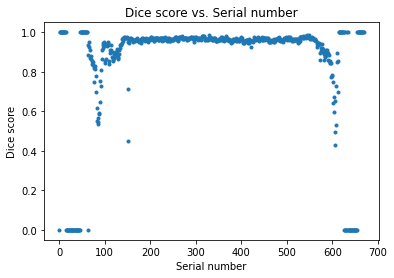

In [ ]:


# pred = np.load('/content/drive/MyDrive/ThesisProject/processed/test50/f_NoisePred3D_2.npy')
pred = np.load(SAVE_PATH+'/f_pred3D_2.npy')
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz'

gt = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['seg'][734:1404]

raw = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['img'][734:1404]

plotLoss(pred, gt)

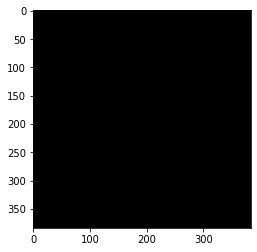

In [ ]:
plt.imshow(pred[200], cmap='gray')
plt.show()

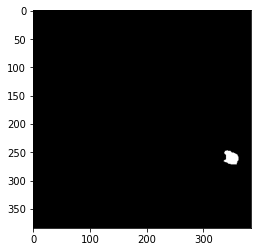

In [ ]:
plt.imshow(gt[200], cmap='gray')
plt.show()

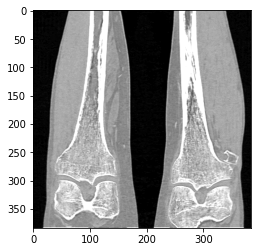

In [ ]:
plt.imshow(raw[200], cmap='gray')
plt.show()

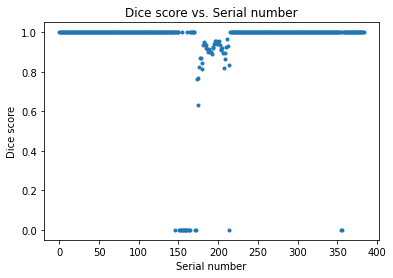

In [ ]:
# 偶数部分
pred = np.load(SAVE_PATH+'/pred3D_2.npy')[0:768:2]

DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz'

gt = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz')['seg'][768:1536:2]

raw = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz')['img'][768:1536:2]

plotLoss(pred, gt)

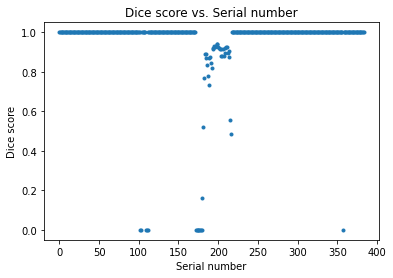

In [ ]:
# 奇数部分
pred = np.load(SAVE_PATH+'/pred3D_2.npy')[1:768:2]

DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz'

gt = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz')['seg'][769:1536:2]

raw = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz')['img'][769:1536:2]

plotLoss(pred, gt)

In [ ]:
np.save( SAVE_PATH+'/deNoisePred3D_2.npy', pred)

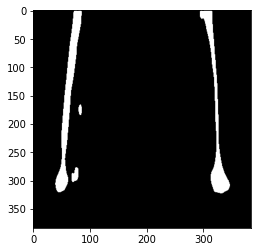

In [ ]:
plt.imshow(pred[200], cmap='gray')
plt.show()

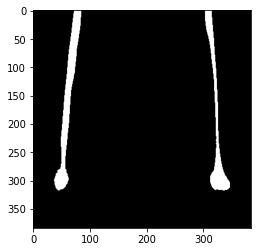

In [ ]:
plt.imshow(gt[200], cmap='gray')
plt.show()

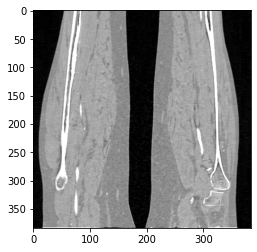

In [ ]:
plt.imshow(raw[200], cmap='gray')
plt.show()

# Merge sagittal

In [ ]:
img1 = np.load('/content/drive/MyDrive/ThesisProject/processed/test50_sagittal/f_prob_pred3D_1.npy')[0:768:2]
img2 = np.load('/content/drive/MyDrive/ThesisProject/processed/test50_sagittal/f_prob_pred3D_1.npy')[1:768:2]

In [ ]:
img3 = img1.transpose(1,2,0)
img4 = img2.transpose(1,2,0)

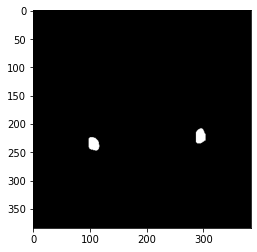

In [ ]:
plt.imshow(img3[150], cmap='gray')
plt.show()

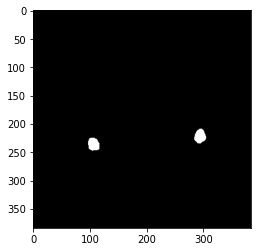

In [ ]:
plt.imshow(seg[150], cmap='gray')
plt.show()

In [ ]:
# seg = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz')['seg']

length = 734
pred = np.zeros([length,384,384], dtype = np.float)
pred1 = np.zeros([length,384,384], dtype = np.float)
pred2 = np.zeros([length,384,384], dtype = np.float)

pred1[0:384] = img1.transpose(1,2,0)
pred2[-384:] = img2.transpose(1,2,0)

pred = np.where(pred1 > pred2, pred1, pred2)





In [ ]:
# for test 1 coronal

length = 734
pred = np.zeros([length,384,384], dtype = np.float)
pred1 = np.zeros([length,384,384], dtype = np.float)
pred2 = np.zeros([length,384,384], dtype = np.float)

pred1[0:384] = img3.transpose(1,0,2)
pred2[-384:] = img4.transpose(1,0,2)

pred = np.where(pred1 > pred2, pred1, pred2)



In [ ]:
np.save('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/sagittal_test1_prob.npy',pred)

In [ ]:
# masks part
masks = np.zeros([length,384,384], dtype = np.uint8)
masks[pred >= 0.5] = 1
masks[pred < 0.5] = 0

In [ ]:
seg = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['seg'][0:length]


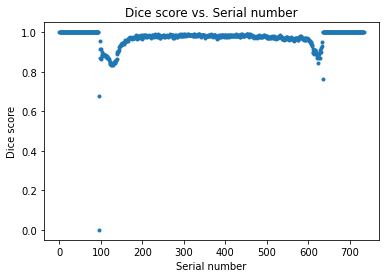

In [ ]:
plotLoss(masks, seg)

In [ ]:
vol_dice = dice(masks,seg)
vol_dice

0.9540496463261583

In [ ]:
np.save('/content/drive/MyDrive/ThesisProject/final_result/test1_DA',masks)

In [ ]:

aimg1 = np.load(SAVE_PATH+'/prob_pred3D_1.npy')
# axial prob 

In [ ]:
pred_merge = np.zeros([length,384,384], dtype = np.float)
# pred_merge = np.where(aimg1 > pred, aimg1, pred)
pred_merge = (aimg1+pred)/2

In [ ]:
masks_merge = np.zeros([length,384,384], dtype = np.uint8)
masks_merge[pred_merge >= 0.5] = 1
masks_merge[pred_merge < 0.5] = 0
masks_merge = deNoise(masks_merge)

In [ ]:
vol_dice_merge = dice(masks_merge,seg)
vol_dice_merge

0.9293525707679005

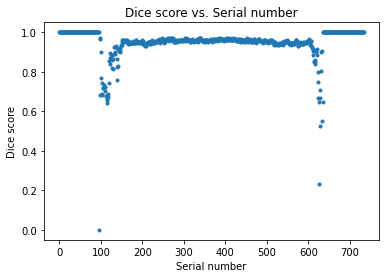

In [ ]:
plotLoss(masks_merge, seg)

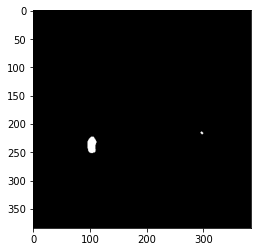

In [ ]:
plt.imshow(aimg1[105], cmap='gray')
plt.show()

In [ ]:
max = np.max(aimg1[aimg1<0.5])
max

0.41321098804473877

In [ ]:
# this code is combined three axials
result_final = np.where(temp1 > temp2, temp1, temp2)
result_final = np.where(result_final > temp2, result_final, temp2)

test 2

In [ ]:
img1 = np.load('/content/drive/MyDrive/ThesisProject/processed/test50_sagittal/f_prob_pred3D_2.npy')[0:768:2]
img2 = np.load('/content/drive/MyDrive/ThesisProject/processed/test50_sagittal/f_prob_pred3D_2.npy')[1:768:2]

In [ ]:
# seg = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz')['seg']

length = 670
pred = np.zeros([length,384,384], dtype = np.float)
pred1 = np.zeros([length,384,384], dtype = np.float)
pred2 = np.zeros([length,384,384], dtype = np.float)

pred1[0:384] = img1.transpose(1,2,0)
pred2[-384:] = img2.transpose(1,2,0)

pred = np.where(pred1 > pred2, pred1, pred2)




In [ ]:
np.save('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/sagittal_test2_prob.npy',pred)

In [ ]:
# masks part
masks = np.zeros([length,384,384], dtype = np.uint8)
masks[pred >= 0.5] = 1
masks[pred < 0.5] = 0

In [ ]:
np.save('/content/drive/MyDrive/ThesisProject/final_result/test2_DA',masks)

In [ ]:
seg = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['seg'][734:1404]


In [ ]:
whos

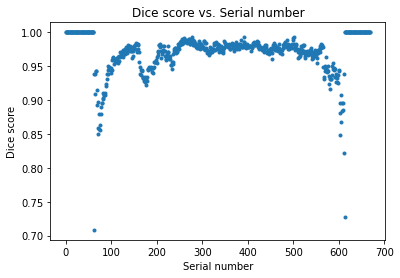

In [ ]:
plotLoss(masks, seg)

In [ ]:
vol_dice = dice(masks,seg)
vol_dice

0.9609516421006895

In [ ]:

aimg1 = np.load(SAVE_PATH+'/prob_pred3D_2.npy')
# axial prob 

In [ ]:
pred_merge = np.zeros([length,384,384], dtype = np.float)
# pred_merge = np.where(aimg1 > pred, aimg1, pred)
pred_merge = (aimg1+pred)/2

In [ ]:
masks_merge = np.zeros([length,384,384], dtype = np.uint8)
masks_merge[pred_merge >= 0.5] = 1
masks_merge[pred_merge < 0.5] = 0
masks_merge = deNoise(masks_merge)

In [ ]:
vol_dice_merge = dice(masks_merge,seg)
vol_dice_merge

0.924920939087355

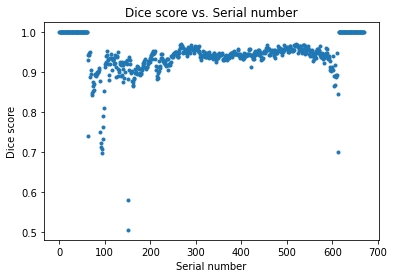

In [ ]:
plotLoss(masks_merge, seg)

# Merge axis

In [ ]:
img1 = np.load('/content/drive/MyDrive/ThesisProject/processed/test50_sagittal/prob_pred3D_1.npy')[0:768:2]
img2 = np.load('/content/drive/MyDrive/ThesisProject/processed/test50_sagittal/prob_pred3D_1.npy')[1:768:2]

In [ ]:
img3 = np.load('/content/drive/MyDrive/ThesisProject/processed/test50_coronal/prob_pred3D_1.npy')[0:768:2]
img4 = np.load('/content/drive/MyDrive/ThesisProject/processed/test50_coronal/prob_pred3D_1.npy')[1:768:2]

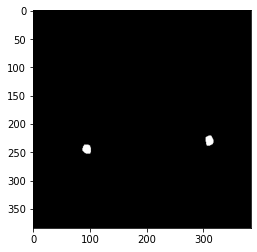

In [ ]:
plt.imshow(img3.transpose(1,0,2)[280], cmap='gray')
plt.show()

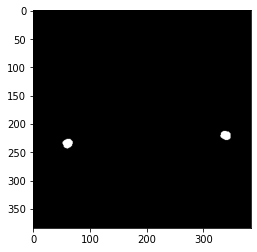

In [ ]:
plt.imshow(seg[561], cmap='gray')
plt.show()

In [ ]:
# seg = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz')['seg']

length = 734
pred = np.zeros([length,384,384], dtype = np.float)
pred1 = np.zeros([length,384,384], dtype = np.float)
pred2 = np.zeros([length,384,384], dtype = np.float)

pred1[0:384] = img1.transpose(1,2,0)
pred2[-384:] = img2.transpose(1,2,0)

pred_c = np.zeros([length,384,384], dtype = np.float)
pred3 = np.zeros([length,384,384], dtype = np.float)
pred4 = np.zeros([length,384,384], dtype = np.float)

pred3[0:384] = img3.transpose(1,0,2)
pred4[-384:] = img4.transpose(1,0,2)

pred_c = np.where(pred3 > pred4, pred3, pred4)
# pred = np.where(pred1 > pred2, pred1, pred2)
pred = np.where(pred1 > pred2, pred1, pred2)



In [ ]:
np.save('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/sagittal_test1_prob.npy',pred)

In [ ]:
# for three axis


In [ ]:
# masks part
masks = np.zeros([length,384,384], dtype = np.uint8)
masks[pred >= 0.5] = 1
masks[pred < 0.5] = 0

In [ ]:
seg = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['seg'][0:length]


In [ ]:
plotLoss(masks, seg)

In [ ]:
vol_dice = dice(masks,seg)
vol_dice

0.887073444171767

In [ ]:
SAVE_PATH = '/content/drive/MyDrive/ThesisProject/processed/test50'
aimg1 = np.load(SAVE_PATH+'/prob_pred3D_1.npy')
# axial prob 

In [ ]:
pred_merge = np.zeros([length,384,384], dtype = np.float)
pred_merge = np.where(aimg1 > pred, aimg1, pred)
pred_merge = np.where(pred_merge > pred_c, pred_merge, pred_c)
# pred_merge = (aimg1+pred+pred_c)/3

In [ ]:
masks_merge = np.zeros([length,384,384], dtype = np.uint8)
masks_merge[pred_merge >= 0.5] = 1
masks_merge[pred_merge < 0.5] = 0
masks_merge = deNoise(masks_merge)

In [ ]:
np.save('/content/drive/MyDrive/ThesisProject/final_result/test1_mergeAxis',masks_merge)

In [ ]:
vol_dice_merge = dice(masks_merge,seg)
vol_dice_merge

0.9321183492788704

0.9449007119987409


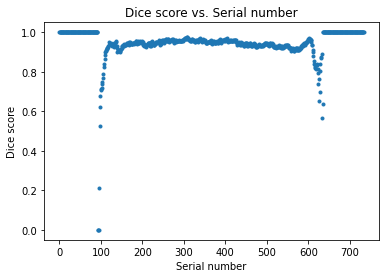

In [ ]:
plotLoss(masks_merge, seg)

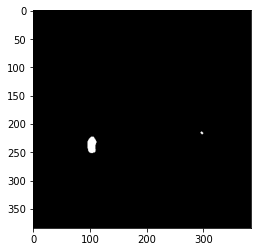

In [ ]:
plt.imshow(aimg1[105], cmap='gray')
plt.show()

In [ ]:
max = np.max(aimg1[aimg1<0.5])
max

0.41321098804473877

In [ ]:
# this code is combined three axials
result_final = np.where(temp1 > temp2, temp1, temp2)
result_final = np.where(result_final > temp2, result_final, temp2)

test 2

In [ ]:
img1 = np.load('/content/drive/MyDrive/ThesisProject/processed/test50_sagittal/prob_pred3D_2.npy')[0:768:2]
img2 = np.load('/content/drive/MyDrive/ThesisProject/processed/test50_sagittal/prob_pred3D_2.npy')[1:768:2]

In [ ]:
img3 = np.load('/content/drive/MyDrive/ThesisProject/processed/test50_coronal/prob_pred3D_2.npy')[0:768:2]
img4 = np.load('/content/drive/MyDrive/ThesisProject/processed/test50_coronal/prob_pred3D_2.npy')[1:768:2]

In [ ]:
# seg = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz')['seg']

length = 670
pred = np.zeros([length,384,384], dtype = np.float)
pred1 = np.zeros([length,384,384], dtype = np.float)
pred2 = np.zeros([length,384,384], dtype = np.float)

pred1[0:384] = img1.transpose(1,2,0)
pred2[-384:] = img2.transpose(1,2,0)

pred_c = np.zeros([length,384,384], dtype = np.float)
pred3 = np.zeros([length,384,384], dtype = np.float)
pred4 = np.zeros([length,384,384], dtype = np.float)

pred3[0:384] = img3.transpose(1,0,2)
pred4[-384:] = img4.transpose(1,0,2)

pred_c = np.where(pred3 > pred4, pred3, pred4)
# pred = np.where(pred1 > pred2, pred1, pred2)
pred = np.where(pred1 > pred2, pred1, pred2)


In [ ]:
np.save('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/sagittal_test2_prob.npy',pred)

In [ ]:
# masks part
masks = np.zeros([length,384,384], dtype = np.uint8)
masks[pred >= 0.5] = 1
masks[pred < 0.5] = 0

In [ ]:
seg = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['seg'][734:1404]


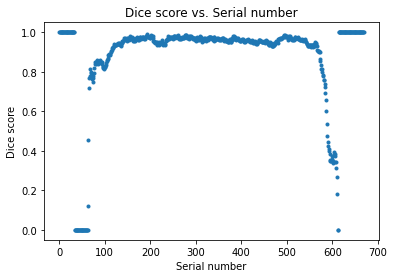

In [ ]:
plotLoss(masks, seg)

In [ ]:
vol_dice = dice(masks,seg)
vol_dice

0.901031590255329

In [ ]:
SAVE_PATH = '/content/drive/MyDrive/ThesisProject/processed/test50'
aimg1 = np.load(SAVE_PATH+'/prob_pred3D_2.npy')
# axial prob 

In [ ]:
pred_merge = np.zeros([length,384,384], dtype = np.float)
# pred_merge = np.where(aimg1 > pred, aimg1, pred)

pred_merge = np.where(aimg1 > pred, aimg1, pred)
pred_merge = np.where(pred_merge > pred_c, pred_merge, pred_c)

In [ ]:
masks_merge = np.zeros([length,384,384], dtype = np.uint8)
masks_merge[pred_merge >= 0.5] = 1
masks_merge[pred_merge < 0.5] = 0
masks_merge = deNoise(masks_merge)

In [ ]:
vol_dice_merge = dice(masks_merge,seg)
vol_dice_merge

0.882744941674432

In [ ]:
np.save('/content/drive/MyDrive/ThesisProject/final_result/test2_mergeAxis',masks_merge)

0.8561321591268436


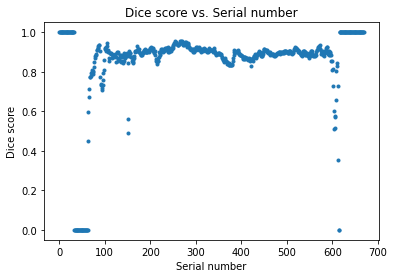

In [ ]:
plotLoss(masks_merge, seg)

# random show image example

In [ ]:
## 显示
import random
def maskSeg(img,seg):
  length = img.shape[0]
  pred = np.zeros([length,384,384,3], dtype = np.uint8)


def randomNum(pred):
  length = pred.shape[0]
  list=[]
  for n in range(length):
    if np.max(pred[n]) == 1:
      list.append(n)
  random.shuffle(list)
  return list[0:12]
# for i in range(12):
    
#     r=random.randint(0,length-1)
#     if r not in list:
#       list.append(r)
def randomShow(seg,img,list):
  alpha = 0.7
        # beta 为第二张图片的透明度
  beta = 1
  gamma = 0
  img_rgb = np.zeros([12,384,384,3], dtype = np.uint8)
  seg_rgb = np.zeros([12,384,384,3], dtype = np.uint8)
  mask_img = np.zeros([12,384,384,3], dtype = np.uint8)
  num = 0
  for i in list:
    img_rgb[num] = cv2.cvtColor(img[i],cv2.COLOR_GRAY2BGR)
    seg_rgb[num] = cv2.cvtColor(seg[i],cv2.COLOR_GRAY2BGR)
    seg_rgb[num][seg[i]==1] = [255,0,0]
    mask_img[num] = cv2.addWeighted(img_rgb[num], alpha,seg_rgb[num], beta, gamma)
    num = num+1

  plt.figure(figsize=(15, 10))
  plt.subplot(3,4,1), plt.imshow(mask_img[0],cmap='gray')
  plt.axis('off'); 
  plt.subplot(3,4,2), plt.imshow(mask_img[1],cmap='gray')
  plt.axis('off'); 
  plt.subplot(3,4,3), plt.imshow(mask_img[2],cmap='gray')
  plt.axis('off'); 
  plt.subplot(3,4,4), plt.imshow(mask_img[3],cmap='gray')
  plt.axis('off'); 
  plt.subplot(3,4,5), plt.imshow(mask_img[4],cmap='gray')
  plt.axis('off'); 
  plt.subplot(3,4,6), plt.imshow(mask_img[5],cmap='gray')
  plt.axis('off'); 
  plt.subplot(3,4,7), plt.imshow(mask_img[6],cmap='gray')
  plt.axis('off'); 
  plt.subplot(3,4,8), plt.imshow(mask_img[7],cmap='gray')
  plt.axis('off'); 
  plt.subplot(3,4,9), plt.imshow(mask_img[8],cmap='gray')
  plt.axis('off'); 
  plt.subplot(3,4,10), plt.imshow(mask_img[9],cmap='gray')
  plt.axis('off'); 
  plt.subplot(3,4,11), plt.imshow(mask_img[10],cmap='gray')
  plt.axis('off');
  plt.subplot(3,4,12), plt.imshow(mask_img[11],cmap='gray')
  plt.axis('off'); 

  plt.show()

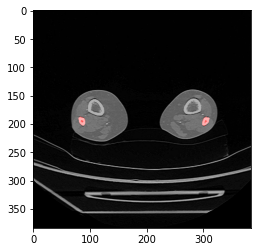

In [ ]:
import cv2 as cv

img_rgb = cv2.cvtColor(img[200],cv2.COLOR_GRAY2BGR)
seg_rgb = cv2.cvtColor(seg[200],cv2.COLOR_GRAY2BGR)
seg_rgb[seg[200]==1] = [255,0,0]



# alpha 为第一张图片的透明度
alpha = 0.7
        # beta 为第二张图片的透明度
beta = 1
gamma = 0
mask_img = cv2.addWeighted(img_rgb, alpha,seg_rgb, beta, gamma)
plt.imshow(mask_img)
plt.show()


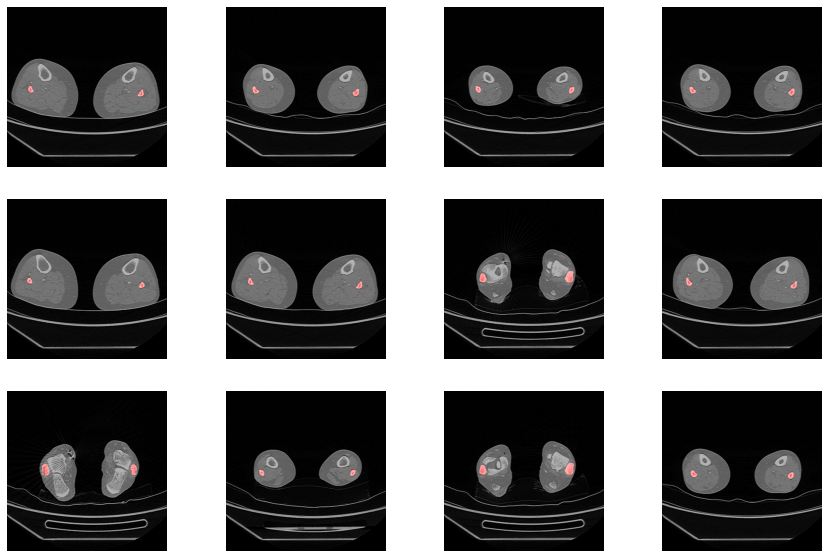

In [ ]:
# print '/content/drive/MyDrive/ThesisProject/final_result/test2_mergeAxis'
seg = np.load('/content/drive/MyDrive/ThesisProject/final_result/test2_mergeAxis.npy')
img = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['img'][734:1404]
list = []
list = randomNum(seg)
randomShow(seg,img,list)

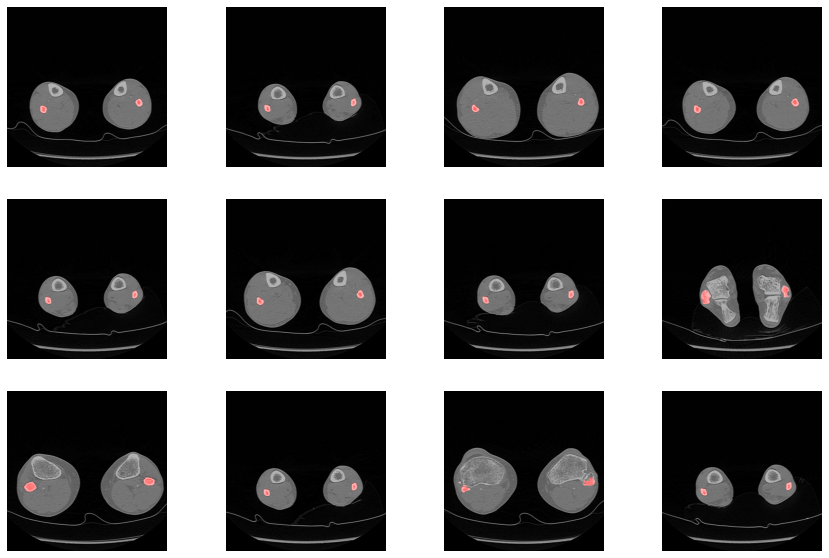

In [ ]:
seg = np.load('/content/drive/MyDrive/ThesisProject/final_result/test1_mergeAxis.npy')
img = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['img'][0:734]
list = []
list = randomNum(seg)
randomShow(seg,img,list)

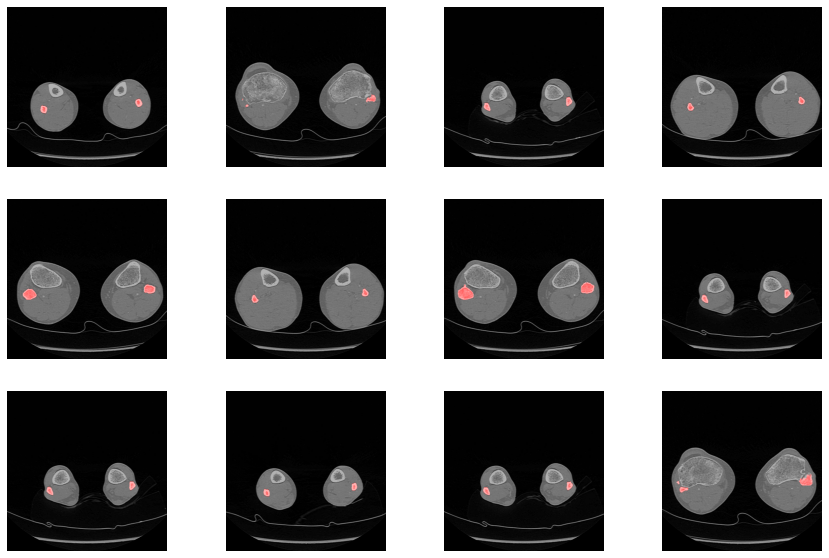

In [ ]:
seg = np.load('/content/drive/MyDrive/ThesisProject/final_result/test1_DA.npy')
img = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['img'][0:734]
list = []
list = randomNum(seg)
randomShow(seg,img,list)

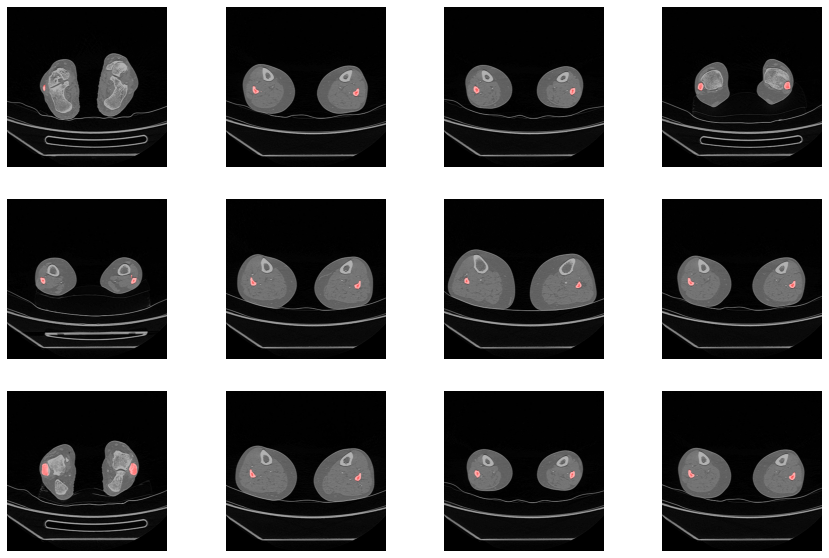

In [ ]:
seg = np.load('/content/drive/MyDrive/ThesisProject/final_result/test2_DA.npy')
img = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['img'][734:1404]
list = []
list = randomNum(seg)
randomShow(seg,img,list)

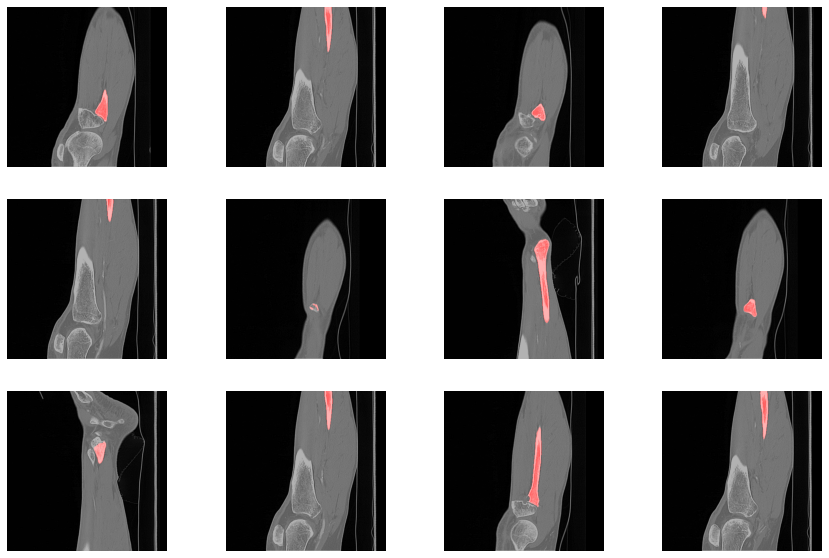

In [ ]:
seg = np.load('/content/drive/MyDrive/ThesisProject/processed/test50_sagittal/f_pred3D_1.npy')
img = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz')['img'][0:768]
list = []
list = randomNum(seg)
randomShow(seg,img,list)

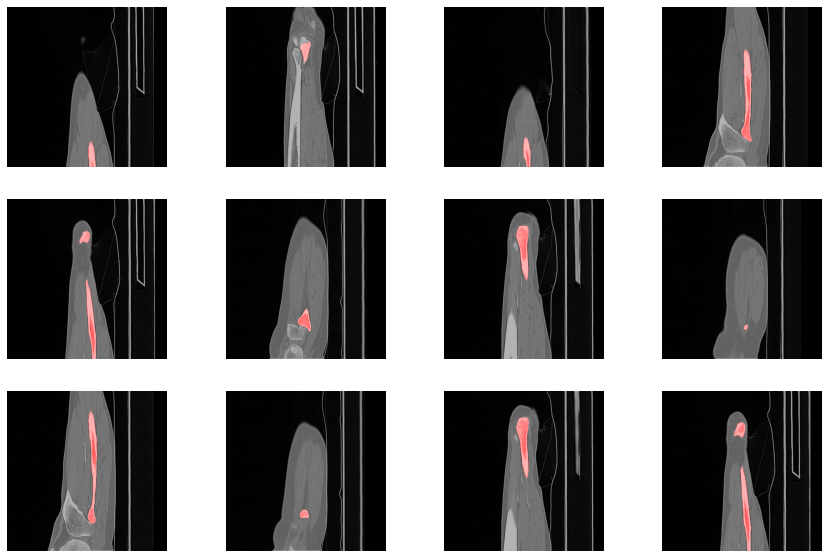

In [ ]:
seg = np.load('/content/drive/MyDrive/ThesisProject/processed/test50_sagittal/f_pred3D_2.npy')
img = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz')['img'][768:1536]
list = []
list = randomNum(seg)
randomShow(seg,img,list)

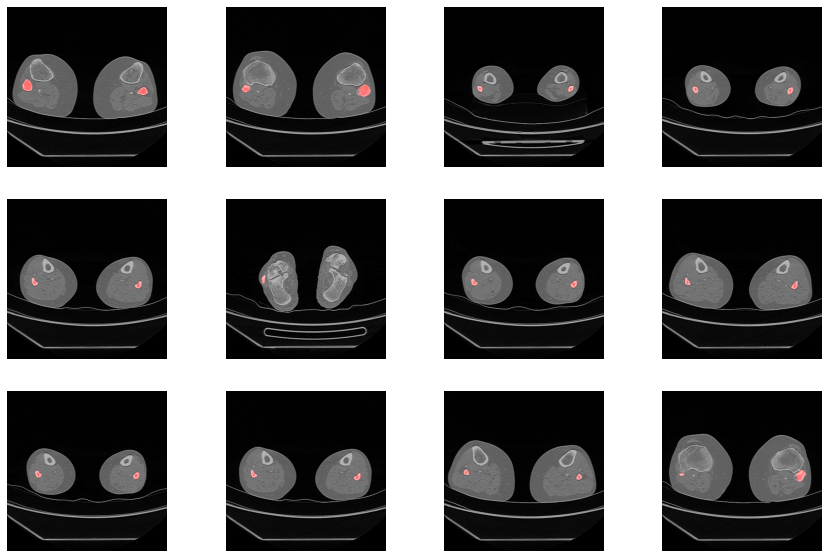

In [ ]:
seg = np.load('/content/drive/MyDrive/ThesisProject/processed/test50/deNoisePred3D_2.npy')
img = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['img'][734:1404]
list = []
list = randomNum(seg)
randomShow(seg,img,list)

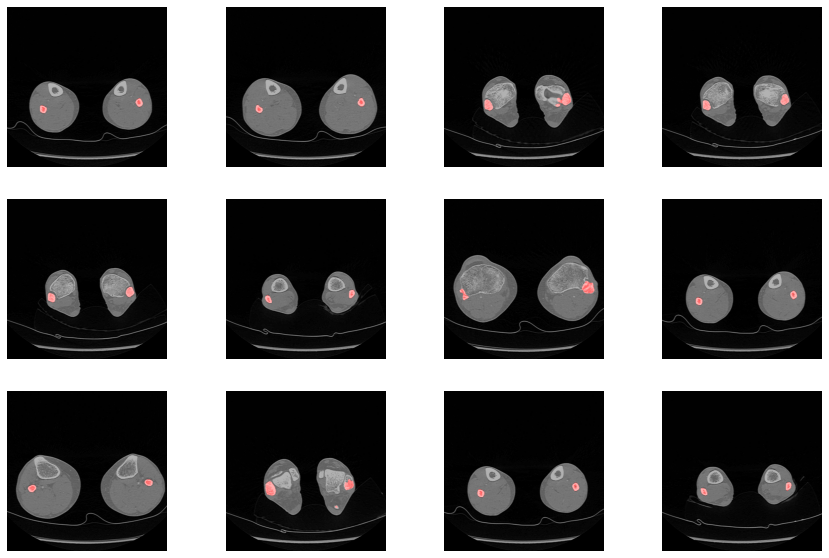

In [ ]:
seg = np.load('/content/drive/MyDrive/ThesisProject/processed/test50/deNoisePred3D_1.npy')
img = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['img'][0:734]
list = []
list = randomNum(seg)
randomShow(seg,img,list)

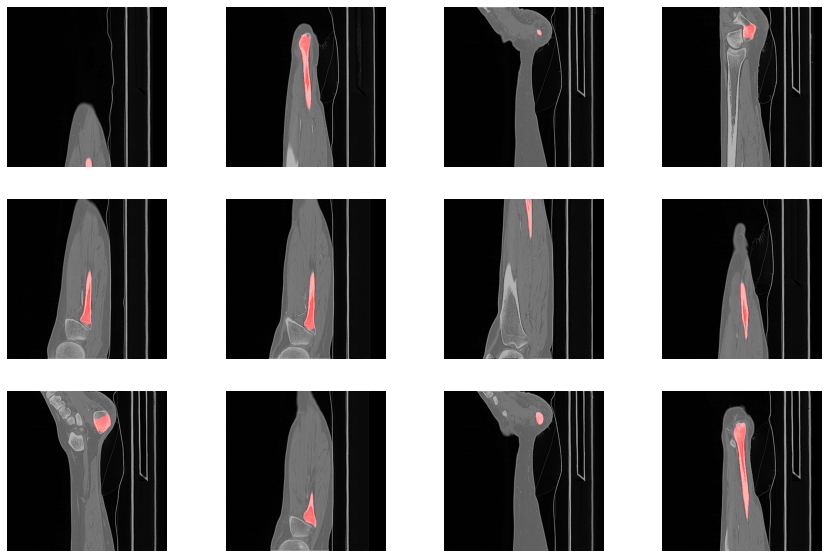

In [ ]:
seg = np.load('/content/drive/MyDrive/ThesisProject/processed/test50_sagittal/pred3D_2.npy')
img = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz')['img'][768:1536]
list = []
list = randomNum(seg)
randomShow(seg,img,list)

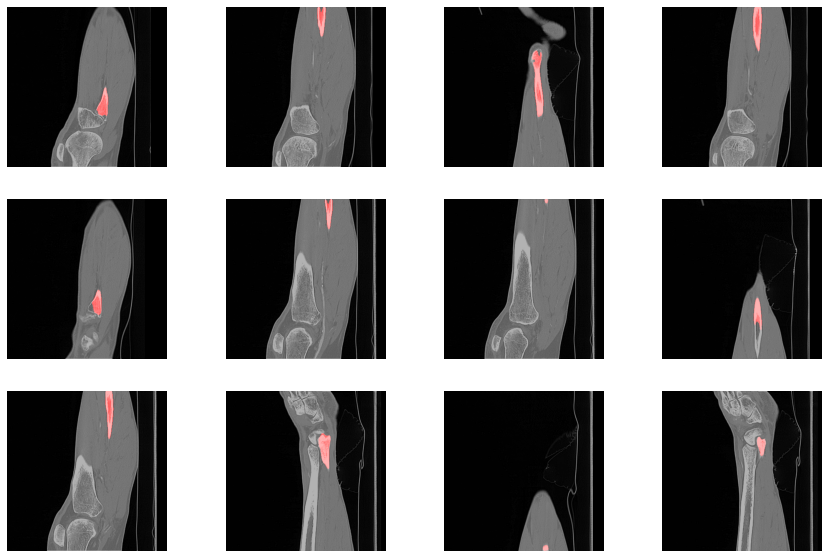

In [ ]:
seg = np.load('/content/drive/MyDrive/ThesisProject/processed/test50_sagittal/pred3D.npy')
img = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz')['img'][0:768]
list = []
list = randomNum(seg)
randomShow(seg,img,list)

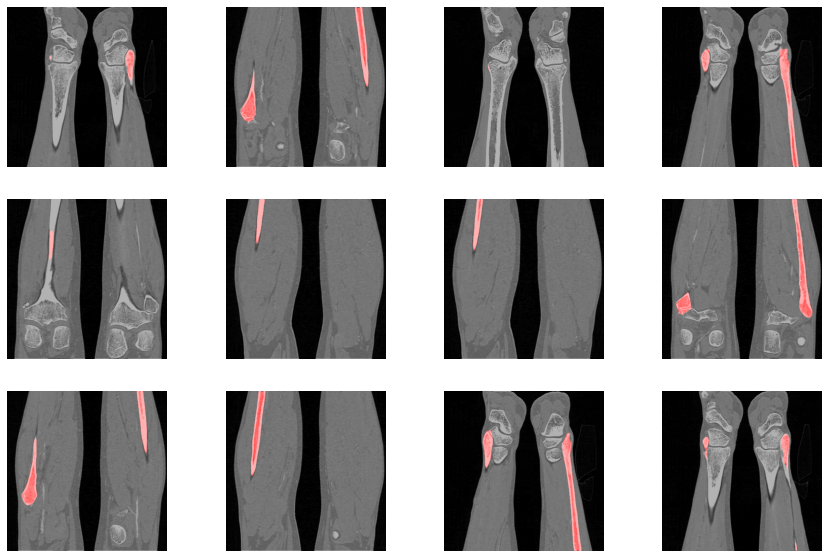

In [ ]:
seg = np.load('/content/drive/MyDrive/ThesisProject/processed/test50_coronal/pred3D_1.npy')
img = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz')['img'][0:768]
list = []
list = randomNum(seg)
randomShow(seg,img,list)



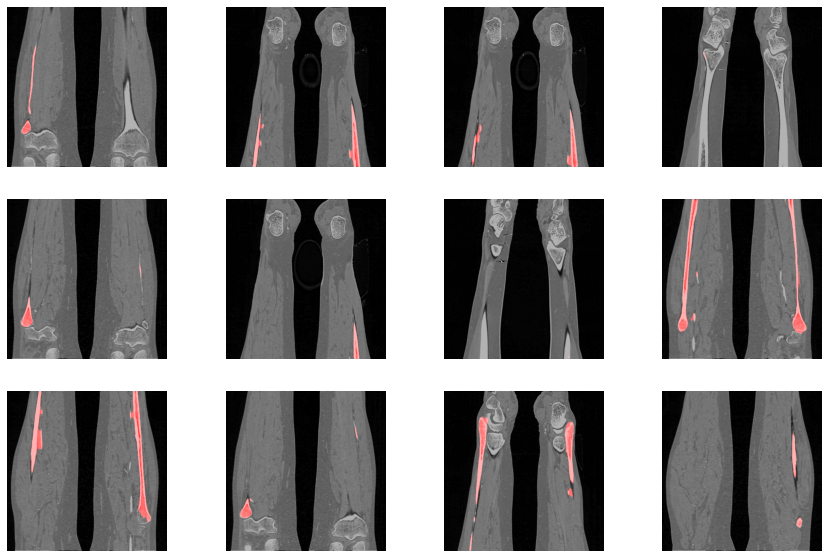

In [ ]:
seg = np.load('/content/drive/MyDrive/ThesisProject/processed/test50_coronal/pred3D_2.npy')
img = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz')['img'][768:1536]
list = []
list = randomNum(seg)
randomShow(seg,img,list)

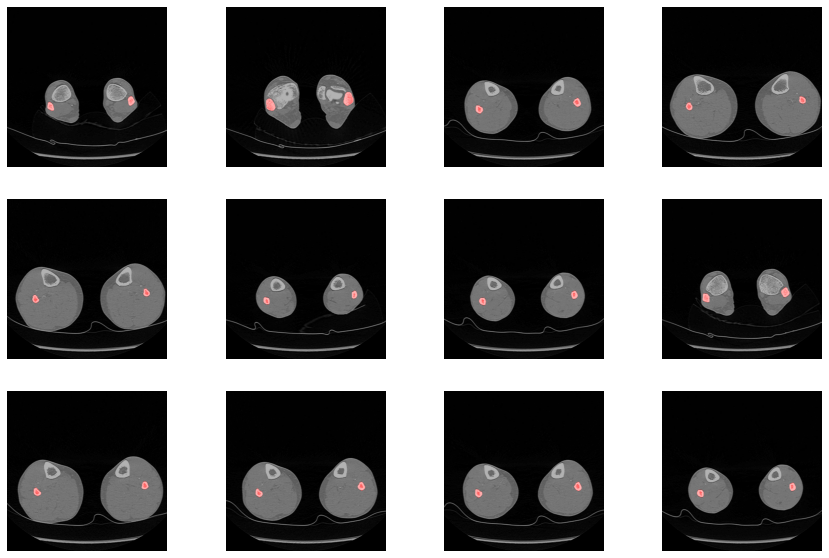

In [ ]:
seg = np.load('/content/drive/MyDrive/ThesisProject/processed/test50/f_NoisePred3D_1.npy')
img = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['img'][0:734]
list = []
list = randomNum(seg)
randomShow(seg,img,list)

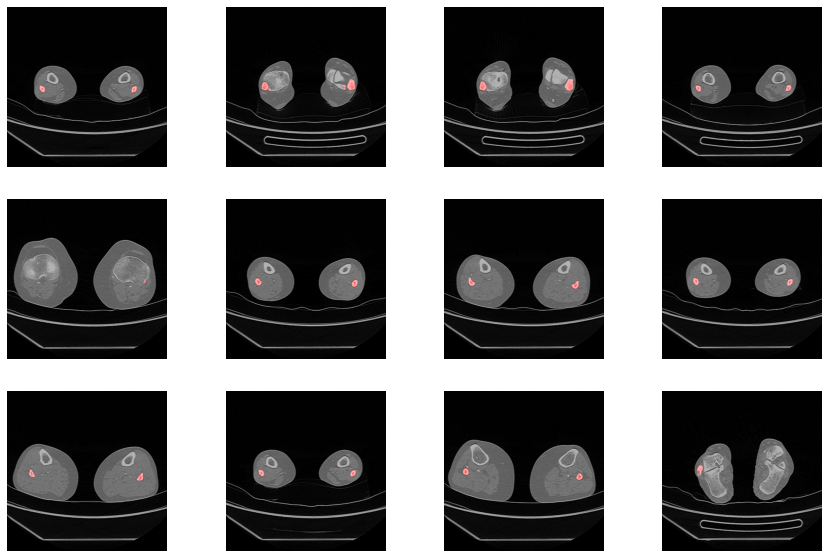

In [ ]:
seg = np.load('/content/drive/MyDrive/ThesisProject/processed/test50/f_NoisePred3D_2.npy')
img = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['img'][734:1404]
list = []
list = randomNum(seg)
randomShow(seg,img,list)

# Merge sagittal and axial

In [ ]:
img1 = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/sagittal_test1_prob.npy')
img2 = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/sagittal_test2_prob.npy')

In [ ]:
img3 = np.load('/content/drive/MyDrive/ThesisProject/processed/test50/f_NoisePred3D_1.npy')
img4 = np.load('/content/drive/MyDrive/ThesisProject/processed/test50/f_NoisePred3D_2.npy')

In [ ]:
length1 = img1.shape[0]
length2 = img2.shape[0]

pred_1 = np.zeros([length1,384,384], dtype = np.float)
pred_2 = np.zeros([length2,384,384], dtype = np.float)

pred_1 = np.where(img1 > img3, img1, img3)

pred_2 = np.where(img2 > img4, img2, img4)

# pred_1 = (img1+img3)/2
# pred_2 = (img2+img4)/2

In [ ]:
# masks part
masks_1 = np.zeros([length1,384,384], dtype = np.uint8)
masks_1[pred_1 >= 0.5] = 1
masks_1[pred_1 < 0.5] = 0

In [ ]:
np.save('/content/drive/MyDrive/ThesisProject/final_result/test1_mergeDA',masks_1)

0.9672621666978355


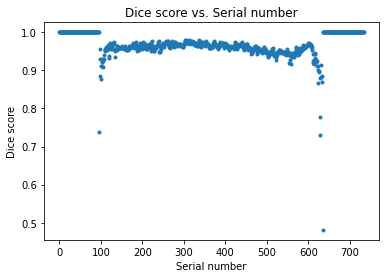

In [ ]:
gt = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['seg'][0:734]

raw = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['img'][0:734]

plotLoss(masks_1, gt)

In [ ]:
vol_dice = dice(masks_1,gt)
vol_dice

0.9574686607925179

test 2

In [ ]:
# masks part
masks_2 = np.zeros([length2,384,384], dtype = np.uint8)
masks_2[pred_2 >= 0.5] = 1
masks_2[pred_2 < 0.5] = 0

In [ ]:
np.save('/content/drive/MyDrive/ThesisProject/final_result/test2_mergeDA',masks_2)

0.9438676298958842


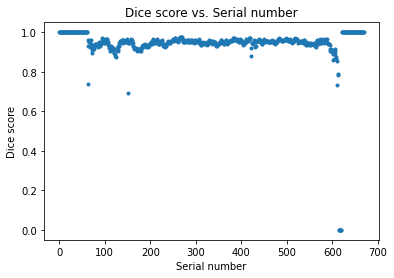

In [ ]:
gt = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['seg'][734:1404]

raw = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['img'][734:1404]

plotLoss(masks_2, gt)

In [ ]:
vol_dice = dice(masks_2,gt)
vol_dice

0.945562495015758

# flow chart


In [ ]:
img = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['img'][0:734]

In [ ]:
seg = np.load('/content/drive/MyDrive/ThesisProject/final_result/test1_mergeDA.npy')

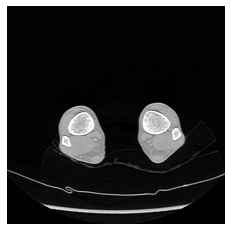

In [ ]:
plt.imshow(img[180],cmap='gray')
plt.axis('off')
plt.show()

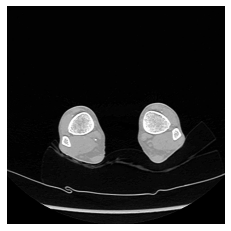

In [ ]:
plt.imshow(img[181],cmap='gray')
plt.axis('off')
plt.show()

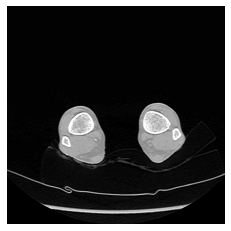

In [ ]:
plt.imshow(img[182],cmap='gray')
plt.axis('off')
plt.show()

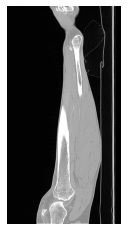

In [ ]:
plt.imshow(img[:,:,99],cmap='gray')
plt.axis('off')
plt.show()

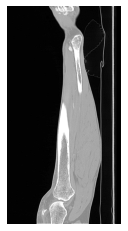

In [ ]:
plt.imshow(img[:,:,100],cmap='gray')
plt.axis('off')
plt.show()

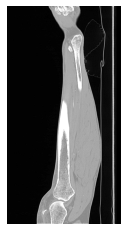

In [ ]:
plt.imshow(img[:,:,101],cmap='gray')
plt.axis('off')
plt.show()

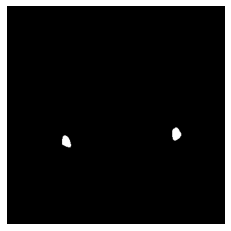

In [ ]:
plt.imshow(seg[180],cmap='gray')
plt.axis('off')
plt.show()

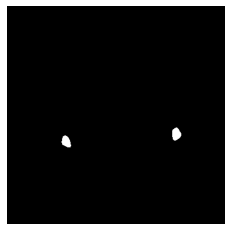

In [ ]:
plt.imshow(seg[181],cmap='gray')
plt.axis('off')
plt.show()

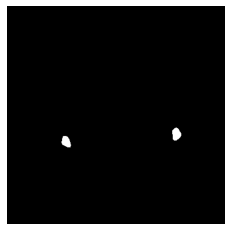

In [ ]:
plt.imshow(seg[182],cmap='gray')
plt.axis('off')
plt.show()

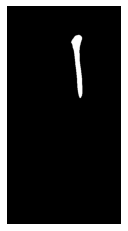

In [ ]:
plt.imshow(seg[:,:,99],cmap='gray')
plt.axis('off')
plt.show()

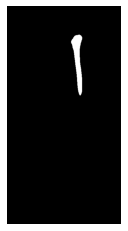

In [ ]:
plt.imshow(seg[:,:,100],cmap='gray')
plt.axis('off')
plt.show()

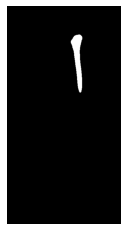

In [ ]:
plt.imshow(seg[:,:,101],cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
whos

Variable           Type        Data/Info
----------------------------------------
DataLoader         type        <class 'torch.utils.data.dataloader.DataLoader'>
Dataset            type        <class 'torch.utils.data.dataset.Dataset'>
Image              module      <module 'PIL.Image' from <...>t-packages/PIL/Image.py'>
Valid1_loss_list   list        n=20
Valid2_loss_list   list        n=20
cv2                module      <module 'cv2.cv2' from '/<...>37m-x86_64-linux-gnu.so'>
datetime           type        <class 'datetime.datetime'>
drive              module      <module 'google.colab.dri<...>s/google/colab/drive.py'>
i                  int         19
imageio            module      <module 'imageio' from '/<...>ges/imageio/__init__.py'>
img                ndarray     670x384x384: 98795520 elems, type `uint8`, 98795520 bytes (94.21875 Mb)
join               function    <function join at 0x7f91be877950>
list               list        n=12
maskSeg            function    <function maskSe

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(3,4,11), plt.imshow(mask_img[10],cmap='gray')
plt.axis('off');
plt.subplot(3,4,12), plt.imshow(mask_img[11],cmap='gray')
plt.axis('off'); 

plt.show()


# 新段落

In [ ]:
img1 = np.load('/content/drive/MyDrive/ThesisProject/processed/test50_sagittal/f_prob_pred3D_1.npy')[0:768:2]
img2 = np.load('/content/drive/MyDrive/ThesisProject/processed/test50_sagittal/f_prob_pred3D_1.npy')[1:768:2]

In [ ]:
seg = np.load('/content/drive/MyDrive/ThesisProject/processed/test50_sagittal/f_prob_pred3D_1.npy')

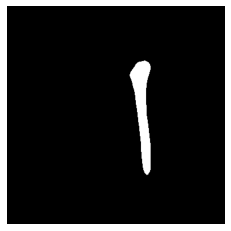

In [ ]:
plt.imshow(seg[200],cmap='gray')
plt.axis('off')
plt.show()

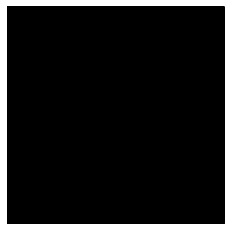

In [ ]:
plt.imshow(seg[201],cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz'

In [ ]:
img = np.load(DATA_PATH)['img'][5375:6143]

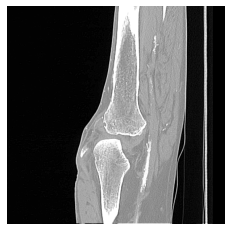

In [ ]:
plt.imshow(img[87*2],cmap='gray')
plt.axis('off')
plt.show()

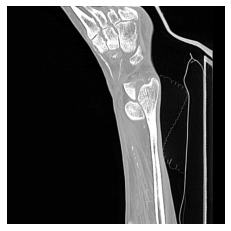

In [ ]:
plt.imshow(img[87*2+1],cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
imga = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_axial_conv020.npz')['img'][5383:6334]

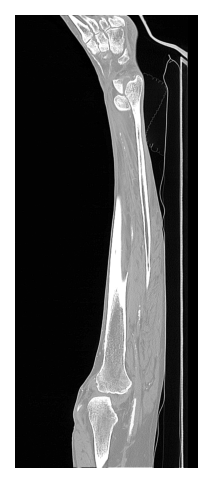

In [ ]:
plt.figure(dpi=150)
plt.imshow(imga[:,:,87],cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
DATA_PATH = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_sagittal_uint1to20.npz'
sega = np.load(DATA_PATH)['seg'][5375:6143]

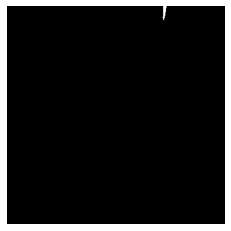

In [ ]:
plt.imshow(sega[87*2],cmap='gray')
plt.axis('off')
plt.show()

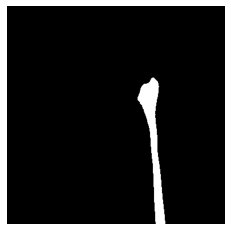

In [ ]:
plt.imshow(sega[87*2+1],cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
temp = np.zeros([951,384])
temp[:384,:] = sega[87*2+1]
temp[-384:,:] = sega[87*2]

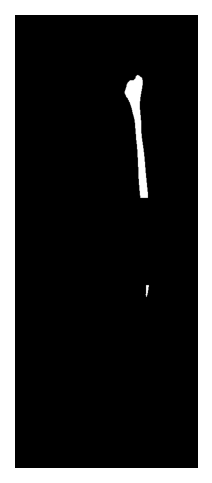

In [ ]:
plt.figure(dpi=150)
plt.imshow(temp,cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
max = np.max(sega)
max

255

In [ ]:
seg = np.load('/content/drive/MyDrive/ThesisProject/processed/test50_coronal/prob_pred3D_1.npy')


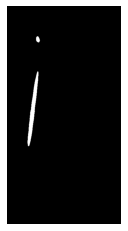

In [ ]:
plt.imshow(pred[:,250,:],cmap='gray')
plt.axis('off')
plt.show()

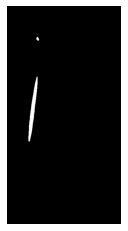

In [ ]:
plt.imshow(pred[:,251,:],cmap='gray')
plt.axis('off')
plt.show()

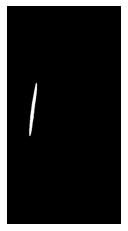

In [ ]:
plt.imshow(pred[:,252,:],cmap='gray')
plt.axis('off')
plt.show()

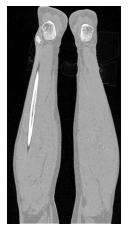

In [ ]:
plt.imshow(imga[:,250,:],cmap='gray')
plt.axis('off')
plt.show()

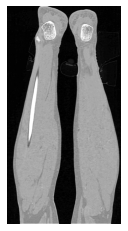

In [ ]:
plt.imshow(imga[:,251,:],cmap='gray')
plt.axis('off')
plt.show()

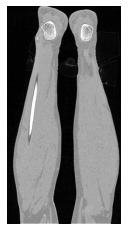

In [ ]:
plt.imshow(imga[:,252,:],cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
img = np.load('/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/npz/crop_coronal_uint1to20.npz')['img'][0:768]

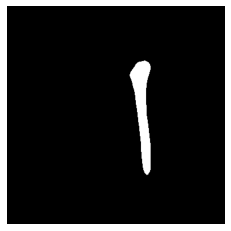

In [ ]:
plt.imshow(seg[200],cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
##read bmp file
bmp_filepath = '/content/drive/MyDrive/ThesisProject/dataset/fibuladata01/test 04/DE VOS MARCUS JOSEPH_Axial+0551.6-000.bmp'
bmp = plt.imread(bmp_filepath)
plt.imshow(bmp)
plt.axis('off')
plt.show()
pos = np.unravel_index(np.argmax(bmp),bmp.shape)

UnidentifiedImageError: ignored

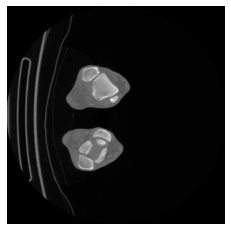

In [ ]:
bmp_filepath = '/content/drive/MyDrive/ThesisProject/dataset/leg_nii/train_set/img_npy/train05.npy'
bmp = np.load(bmp_filepath)[:,:,92]
plt.imshow(bmp,cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
%whos

Variable       Type        Data/Info
------------------------------------
DATA_PATH      str         /content/drive/MyDrive/Th<...>pz/crop_axial_conv020.npz
DataLoader     type        <class 'torch.utils.data.dataloader.DataLoader'>
Dataset        type        <class 'torch.utils.data.dataset.Dataset'>
Image          module      <module 'PIL.Image' from <...>t-packages/PIL/Image.py'>
bmp            ndarray     512x790: 404480 elems, type `uint16`, 808960 bytes (790.0 kb)
bmp_filepath   str         /content/drive/MyDrive/Th<...>n_set/img_npy/train05.npy
cv2            module      <module 'cv2.cv2' from '/<...>37m-x86_64-linux-gnu.so'>
data           NpzFile     <numpy.lib.npyio.NpzFile <...>object at 0x7fae287b0ad0>
datetime       type        <class 'datetime.datetime'>
drive          module      <module 'google.colab.dri<...>s/google/colab/drive.py'>
gt             ndarray     15830x384x384: 2334228480 elems, type `uint8`, 2334228480 bytes (2226.09375 Mb)
gt2            ndarray     1583

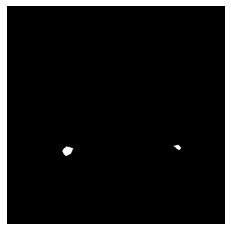

In [ ]:
src=cv2.imread(bmp_filepath)
hsv = cv2.cvtColor(src, cv2.COLOR_BGR2HSV)
low_hsv = np.array([10,10,0])
high_hsv = np.array([360,255,255])
mask = cv2.inRange(hsv,lowerb=low_hsv,upperb=high_hsv)
plt.imshow(mask,cmap='gray')
plt.axis('off')
plt.show()